## Importing the required libraries

In [299]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [300]:
from keras import regularizers

In [301]:
import os

In [302]:
mylist= os.listdir('C://Users//pranav//Desktop//SER//x2data')

In [303]:
type(mylist)

list

In [304]:
print(mylist[1800])

03-02-03-01-02-02-16.wav


In [305]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [306]:
data, sampling_rate = librosa.load('C://Users//pranav//Desktop//SER//x2data//03-02-03-01-02-02-16.wav')

Populating the interactive namespace from numpy and matplotlib


F:\New folder\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['shuffle', 'test']
`%matplotlib` prevents importing * from pylab and numpy



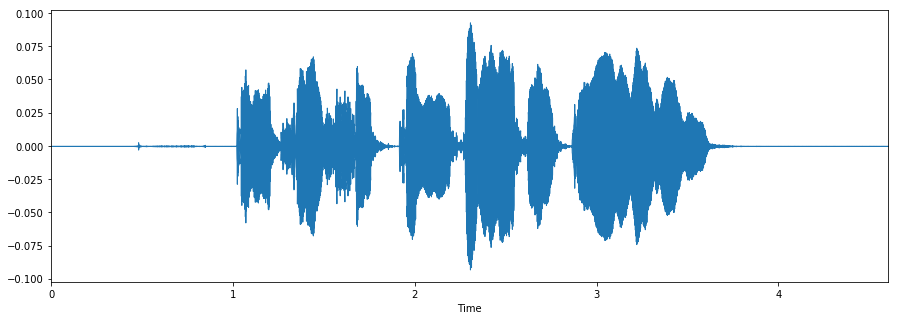

In [307]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

F:\New folder\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

F:\New folder\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

F:\New folder\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

F:\New folder\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning:

divide by zero encountered in log



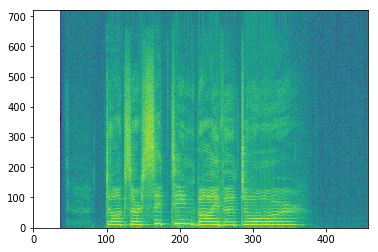

In [308]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('C://Users//pranav//Desktop//SER//x2data//03-02-03-01-02-02-16.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [309]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [310]:
labels = pd.DataFrame(feeling_list)

In [311]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [312]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('C://Users//pranav//Desktop//SER//x2data//'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [313]:
df[:5]

,feature
0,"[-70.2677641610773, -70.2677641610773, -70.267..."
1,"[-65.70765240065282, -65.70765240065282, -63.1..."
2,"[-65.4824988827423, -65.4824988827423, -65.482..."
3,"[-64.52844910346735, -64.52844910346735, -64.5..."
4,"[-62.36431052745468, -59.93472513811134, -61.8..."


In [314]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [315]:
newdf = pd.concat([df3,labels], axis=1)

In [316]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [317]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.082741,-60.234652,male_calm
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.144064,-48.705645,female_calm
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.323644,-40.710780,male_calm
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.610100,-44.698259,female_calm
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.383777,-43.965398,male_calm


In [318]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
379,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,...,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,-42.631395,female_happy
876,-64.311404,-58.837348,-57.070674,-59.403286,-59.159440,-56.119573,-56.304894,-62.215263,-62.511671,-64.500209,...,-60.223600,-57.189248,-57.962821,-60.110766,-58.582106,-56.410975,-56.471134,-58.010376,-59.470420,male_fearful
451,-79.090368,-79.090368,-79.090368,-79.090368,-79.090368,-79.090368,-79.090368,-79.090368,-79.090368,-79.090368,...,-63.005665,-67.966180,-66.269216,-63.630546,-64.212365,-68.123887,-66.041563,-65.623836,-71.447630,female_sad
1480,-49.250083,-47.862935,-47.617017,-49.317434,-47.837021,-45.822780,-43.965543,-43.504021,-44.797301,-46.603719,...,-29.019142,-29.287913,-30.068516,-30.345650,-28.860302,-28.363769,-28.490629,-23.022909,-18.276039,male_sad
547,-65.465481,-65.465481,-65.465481,-65.465481,-65.465481,-65.465481,-65.465481,-65.465481,-65.465481,-65.465481,...,-65.465922,-64.065300,-64.086878,-64.298206,-64.042103,-65.065679,-65.285933,-64.923901,-65.078600,female_sad
390,-71.188637,-71.188637,-71.188637,-71.188637,-71.188637,-69.602972,-68.462377,-67.832988,-65.815999,-65.290115,...,-59.432881,-57.374782,-55.124635,-55.970205,-60.561055,-61.474515,-60.195324,-56.605395,-59.115601,male_sad
911,-46.869321,-46.869321,-46.869321,-46.869321,-46.869321,-46.869321,-46.869321,-46.869321,-46.869321,-46.869321,...,-37.961509,-39.621291,-40.218455,-41.568279,-41.654916,-42.979392,-40.411928,-37.189513,-29.324144,female_fearful
597,-53.678315,-54.377914,-55.140844,-56.300240,-55.326932,-55.119810,-56.282534,-54.970338,-53.334915,-52.519249,...,-50.354847,-51.740110,-53.151655,-53.596402,-53.313462,-53.512526,-55.573837,-56.696713,-56.354921,female_angry
1326,-49.875624,-49.875624,-49.875624,-48.006241,-47.245683,-47.207803,-47.366410,-47.511315,-47.409282,-47.263355,...,-26.248085,-26.273129,-26.825640,-27.372468,-27.296200,-26.504254,-27.829685,-13.997399,-7.759216,male_happy
974,-51.100772,-49.108443,-49.629691,-52.753706,-54.096657,-55.859434,-54.466789,-55.492749,-57.559655,-57.487213,...,-31.491357,-31.564764,-30.882680,-27.883106,-29.869578,-30.097644,-25.671160,-21.524246,-16.765781,male_calm


In [319]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [321]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [322]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1141,-53.940489,-54.585260,-52.693097,-52.662991,-53.539774,-53.312791,-53.658248,-53.033167,-52.704671,-51.875424,...,-44.746416,-42.721836,-42.071805,-43.545584,-43.258515,-42.415665,-41.377620,-23.516232,-16.556480,female_calm
779,-53.536973,-54.117284,-54.527581,-54.527581,-52.853619,-52.647446,-52.572823,-52.529147,-53.306279,-53.073154,...,-45.253403,-44.261883,-44.015393,-42.753278,-41.122260,-41.365224,-40.587912,-40.056865,-38.881323,female_fearful
664,-54.071434,-53.270441,-55.962005,-55.425948,-56.699237,-55.350538,-52.082626,-53.349495,-54.608616,-54.911032,...,-53.482203,-53.487210,-52.997875,-52.097820,-49.879058,-51.867677,-51.888519,-52.556569,-52.861004,male_angry
827,-57.419633,-57.696347,-58.593154,-58.173707,-56.816082,-57.052646,-56.534252,-55.248651,-54.070975,-53.961269,...,-50.393697,-50.474974,-51.069885,-52.064431,-54.821356,-55.741497,-54.562802,-53.602407,-53.358295,female_fearful
1686,-49.004734,-49.004734,-49.004734,-49.004734,-49.004734,-49.004734,-49.004734,-49.004734,-49.004734,-49.004734,...,-32.870681,-35.278584,-36.010458,-37.958617,-37.812292,-37.379350,-38.106375,-18.383639,-9.647813,female_angry
312,-56.733879,-56.752659,-56.415251,-55.715674,-55.817854,-55.832755,-55.889748,-55.116522,-54.244677,-56.211891,...,-39.931887,-43.064495,-46.631511,-48.998480,-46.067905,-45.294283,-47.657379,-51.417209,-54.335337,male_happy
1666,-42.853688,-43.125471,-43.261603,-43.542698,-43.996154,-44.278831,-43.174748,-43.805186,-44.280954,-44.266471,...,-17.316529,-14.849276,-12.036559,-10.578693,-9.401792,-10.216363,-12.238476,-12.497807,-8.950676,male_angry
1565,-51.814071,-51.179072,-51.548308,-50.435058,-49.806378,-50.147107,-49.875816,-50.006132,-51.929632,-50.753609,...,-32.295638,-32.723007,-34.491825,-35.983820,-37.402741,-37.712270,-39.345481,-36.512459,-32.180346,female_angry
542,-60.879858,-60.879858,-60.879858,-59.529157,-57.068292,-56.470826,-58.132601,-60.712885,-60.090474,-58.996574,...,-47.326807,-46.939704,-48.449363,-50.575708,-50.379479,-50.060949,-49.623601,-49.845629,-52.578895,male_sad
477,-52.832334,-52.688440,-52.211688,-51.576756,-51.757801,-51.686870,-52.709010,-53.476120,-54.586895,-56.060488,...,-51.755319,-52.064901,-49.577900,-49.165910,-49.457909,-51.753365,-53.608818,-53.711087,-52.081234,female_sad


In [323]:
trainfeatures = train.iloc[:, :-1]

In [324]:
trainlabel = train.iloc[:, -1:]

In [325]:
testfeatures = test.iloc[:, :-1]

In [326]:
testlabel = test.iloc[:, -1:]

In [327]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


F:\New folder\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

F:\New folder\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [328]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [329]:
y_test


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [330]:
X_train.shape

(1525, 216)

In [331]:
shape(X_train)

(1525, 216)

In [332]:
 shape(y_train)

(1525, 10)

In [333]:
shape(X_test)

(355, 216)

In [334]:
shape(y_test)

(355, 10)

In [335]:
rnewdf=rnewdf.fillna(0)

## Changing dimension for CNN model

In [336]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [337]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [338]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_16 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_17 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 27, 128)          

In [339]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [340]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1525 samples, validate on 355 samples
Epoch 1/700
1525/1525 [==============================] - ETA: 3:07 - loss: 4.5898 - accuracy: 0.06 - ETA: 1:40 - loss: 3.9476 - accuracy: 0.09 - ETA: 1:10 - loss: 3.7577 - accuracy: 0.08 - ETA: 56s - loss: 3.7785 - accuracy: 0.0781 - ETA: 47s - loss: 3.6515 - accuracy: 0.087 - ETA: 41s - loss: 3.5898 - accuracy: 0.093 - ETA: 36s - loss: 3.4819 - accuracy: 0.098 - ETA: 33s - loss: 3.4096 - accuracy: 0.109 - ETA: 31s - loss: 3.3362 - accuracy: 0.111 - ETA: 29s - loss: 3.2897 - accuracy: 0.112 - ETA: 27s - loss: 3.2495 - accuracy: 0.113 - ETA: 25s - loss: 3.1958 - accuracy: 0.114 - ETA: 24s - loss: 3.1728 - accuracy: 0.115 - ETA: 23s - loss: 3.1437 - accuracy: 0.111 - ETA: 22s - loss: 3.1072 - accuracy: 0.104 - ETA: 21s - loss: 3.0825 - accuracy: 0.109 - ETA: 20s - loss: 3.0476 - accuracy: 0.106 - ETA: 19s - loss: 3.0248 - accuracy: 0.104 - ETA: 19s - loss: 3.0049 - accuracy: 0.105 - ETA: 18s - 

1525/1525 [==============================] - ETA: 13s - loss: 2.1934 - accuracy: 0.187 - ETA: 14s - loss: 2.1663 - accuracy: 0.250 - ETA: 14s - loss: 2.1910 - accuracy: 0.166 - ETA: 14s - loss: 2.1909 - accuracy: 0.140 - ETA: 14s - loss: 2.1892 - accuracy: 0.162 - ETA: 14s - loss: 2.1936 - accuracy: 0.145 - ETA: 13s - loss: 2.1956 - accuracy: 0.125 - ETA: 13s - loss: 2.2052 - accuracy: 0.125 - ETA: 13s - loss: 2.2097 - accuracy: 0.111 - ETA: 13s - loss: 2.2165 - accuracy: 0.106 - ETA: 13s - loss: 2.2175 - accuracy: 0.108 - ETA: 13s - loss: 2.2072 - accuracy: 0.125 - ETA: 13s - loss: 2.2001 - accuracy: 0.120 - ETA: 13s - loss: 2.2001 - accuracy: 0.120 - ETA: 13s - loss: 2.1952 - accuracy: 0.116 - ETA: 12s - loss: 2.1909 - accuracy: 0.121 - ETA: 12s - loss: 2.1868 - accuracy: 0.125 - ETA: 12s - loss: 2.1883 - accuracy: 0.125 - ETA: 12s - loss: 2.1953 - accuracy: 0.128 - ETA: 12s - loss: 2.1920 - accuracy: 0.131 - ETA: 11s - loss: 2.2006 - accuracy: 0.125 - ETA: 11s - loss: 2.1986 - accur

1525/1525 [==============================] - ETA: 14s - loss: 2.1455 - accuracy: 0.062 - ETA: 13s - loss: 2.0884 - accuracy: 0.218 - ETA: 14s - loss: 2.1049 - accuracy: 0.208 - ETA: 14s - loss: 2.1364 - accuracy: 0.156 - ETA: 13s - loss: 2.1124 - accuracy: 0.187 - ETA: 13s - loss: 2.1305 - accuracy: 0.187 - ETA: 13s - loss: 2.1405 - accuracy: 0.178 - ETA: 13s - loss: 2.1436 - accuracy: 0.171 - ETA: 13s - loss: 2.1298 - accuracy: 0.180 - ETA: 13s - loss: 2.1380 - accuracy: 0.181 - ETA: 13s - loss: 2.1319 - accuracy: 0.181 - ETA: 13s - loss: 2.1332 - accuracy: 0.182 - ETA: 13s - loss: 2.1306 - accuracy: 0.192 - ETA: 13s - loss: 2.1450 - accuracy: 0.183 - ETA: 12s - loss: 2.1357 - accuracy: 0.187 - ETA: 13s - loss: 2.1346 - accuracy: 0.187 - ETA: 12s - loss: 2.1320 - accuracy: 0.183 - ETA: 12s - loss: 2.1302 - accuracy: 0.184 - ETA: 12s - loss: 2.1325 - accuracy: 0.180 - ETA: 12s - loss: 2.1312 - accuracy: 0.181 - ETA: 12s - loss: 2.1300 - accuracy: 0.181 - ETA: 12s - loss: 2.1243 - accur

1525/1525 [==============================] - ETA: 14s - loss: 2.0497 - accuracy: 0.187 - ETA: 13s - loss: 2.0427 - accuracy: 0.156 - ETA: 14s - loss: 2.0531 - accuracy: 0.145 - ETA: 14s - loss: 2.0610 - accuracy: 0.156 - ETA: 13s - loss: 2.0447 - accuracy: 0.175 - ETA: 13s - loss: 2.0468 - accuracy: 0.177 - ETA: 13s - loss: 2.0477 - accuracy: 0.178 - ETA: 13s - loss: 2.0456 - accuracy: 0.171 - ETA: 13s - loss: 2.0433 - accuracy: 0.187 - ETA: 13s - loss: 2.0400 - accuracy: 0.193 - ETA: 13s - loss: 2.0479 - accuracy: 0.187 - ETA: 12s - loss: 2.0452 - accuracy: 0.187 - ETA: 12s - loss: 2.0503 - accuracy: 0.182 - ETA: 12s - loss: 2.0391 - accuracy: 0.196 - ETA: 12s - loss: 2.0400 - accuracy: 0.204 - ETA: 12s - loss: 2.0401 - accuracy: 0.210 - ETA: 12s - loss: 2.0399 - accuracy: 0.216 - ETA: 12s - loss: 2.0476 - accuracy: 0.211 - ETA: 11s - loss: 2.0421 - accuracy: 0.217 - ETA: 11s - loss: 2.0369 - accuracy: 0.225 - ETA: 11s - loss: 2.0427 - accuracy: 0.217 - ETA: 11s - loss: 2.0481 - accur

1525/1525 [==============================] - ETA: 12s - loss: 2.0896 - accuracy: 0.125 - ETA: 12s - loss: 1.9620 - accuracy: 0.250 - ETA: 12s - loss: 1.9702 - accuracy: 0.208 - ETA: 13s - loss: 1.9627 - accuracy: 0.234 - ETA: 12s - loss: 1.9480 - accuracy: 0.250 - ETA: 12s - loss: 1.9539 - accuracy: 0.250 - ETA: 12s - loss: 1.9365 - accuracy: 0.250 - ETA: 12s - loss: 1.9358 - accuracy: 0.250 - ETA: 12s - loss: 1.9368 - accuracy: 0.256 - ETA: 12s - loss: 1.9545 - accuracy: 0.262 - ETA: 12s - loss: 1.9472 - accuracy: 0.272 - ETA: 11s - loss: 1.9535 - accuracy: 0.260 - ETA: 11s - loss: 1.9335 - accuracy: 0.278 - ETA: 11s - loss: 1.9477 - accuracy: 0.263 - ETA: 11s - loss: 1.9445 - accuracy: 0.270 - ETA: 11s - loss: 1.9434 - accuracy: 0.269 - ETA: 11s - loss: 1.9541 - accuracy: 0.261 - ETA: 11s - loss: 1.9488 - accuracy: 0.256 - ETA: 11s - loss: 1.9422 - accuracy: 0.266 - ETA: 10s - loss: 1.9406 - accuracy: 0.265 - ETA: 10s - loss: 1.9428 - accuracy: 0.258 - ETA: 10s - loss: 1.9444 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.7532 - accuracy: 0.312 - ETA: 22s - loss: 1.8501 - accuracy: 0.281 - ETA: 23s - loss: 1.9506 - accuracy: 0.229 - ETA: 22s - loss: 1.9293 - accuracy: 0.218 - ETA: 22s - loss: 1.9007 - accuracy: 0.250 - ETA: 22s - loss: 1.8822 - accuracy: 0.250 - ETA: 22s - loss: 1.8689 - accuracy: 0.267 - ETA: 21s - loss: 1.8817 - accuracy: 0.281 - ETA: 21s - loss: 1.8992 - accuracy: 0.277 - ETA: 21s - loss: 1.9028 - accuracy: 0.275 - ETA: 21s - loss: 1.9061 - accuracy: 0.289 - ETA: 20s - loss: 1.9064 - accuracy: 0.291 - ETA: 20s - loss: 1.9159 - accuracy: 0.298 - ETA: 20s - loss: 1.9103 - accuracy: 0.303 - ETA: 20s - loss: 1.9080 - accuracy: 0.308 - ETA: 20s - loss: 1.9060 - accuracy: 0.312 - ETA: 19s - loss: 1.9089 - accuracy: 0.308 - ETA: 19s - loss: 1.9129 - accuracy: 0.302 - ETA: 19s - loss: 1.9057 - accuracy: 0.305 - ETA: 19s - loss: 1.9106 - accuracy: 0.300 - ETA: 18s - loss: 1.9139 - accuracy: 0.297 - ETA: 18s - loss: 1.9167 - accur

1525/1525 [==============================] - ETA: 26s - loss: 1.6063 - accuracy: 0.562 - ETA: 25s - loss: 1.8263 - accuracy: 0.437 - ETA: 25s - loss: 1.8166 - accuracy: 0.437 - ETA: 24s - loss: 1.8496 - accuracy: 0.390 - ETA: 24s - loss: 1.8821 - accuracy: 0.375 - ETA: 24s - loss: 1.8745 - accuracy: 0.343 - ETA: 24s - loss: 1.8593 - accuracy: 0.348 - ETA: 23s - loss: 1.8637 - accuracy: 0.343 - ETA: 23s - loss: 1.8608 - accuracy: 0.319 - ETA: 23s - loss: 1.8526 - accuracy: 0.325 - ETA: 23s - loss: 1.8523 - accuracy: 0.318 - ETA: 22s - loss: 1.8518 - accuracy: 0.317 - ETA: 22s - loss: 1.8554 - accuracy: 0.322 - ETA: 22s - loss: 1.8563 - accuracy: 0.321 - ETA: 22s - loss: 1.8662 - accuracy: 0.316 - ETA: 21s - loss: 1.8720 - accuracy: 0.324 - ETA: 22s - loss: 1.8722 - accuracy: 0.316 - ETA: 21s - loss: 1.8796 - accuracy: 0.309 - ETA: 21s - loss: 1.8666 - accuracy: 0.325 - ETA: 21s - loss: 1.8732 - accuracy: 0.321 - ETA: 21s - loss: 1.8751 - accuracy: 0.315 - ETA: 20s - loss: 1.8740 - accur

1525/1525 [==============================] - ETA: 26s - loss: 1.7283 - accuracy: 0.250 - ETA: 25s - loss: 1.7908 - accuracy: 0.312 - ETA: 27s - loss: 1.7271 - accuracy: 0.375 - ETA: 26s - loss: 1.8248 - accuracy: 0.312 - ETA: 26s - loss: 1.8179 - accuracy: 0.287 - ETA: 25s - loss: 1.7985 - accuracy: 0.302 - ETA: 25s - loss: 1.7760 - accuracy: 0.321 - ETA: 24s - loss: 1.7675 - accuracy: 0.328 - ETA: 24s - loss: 1.8062 - accuracy: 0.319 - ETA: 24s - loss: 1.7992 - accuracy: 0.318 - ETA: 23s - loss: 1.7855 - accuracy: 0.318 - ETA: 23s - loss: 1.7868 - accuracy: 0.317 - ETA: 23s - loss: 1.7769 - accuracy: 0.331 - ETA: 22s - loss: 1.7695 - accuracy: 0.334 - ETA: 22s - loss: 1.7804 - accuracy: 0.329 - ETA: 22s - loss: 1.7797 - accuracy: 0.328 - ETA: 21s - loss: 1.7938 - accuracy: 0.323 - ETA: 21s - loss: 1.7950 - accuracy: 0.326 - ETA: 21s - loss: 1.7940 - accuracy: 0.325 - ETA: 20s - loss: 1.8051 - accuracy: 0.315 - ETA: 20s - loss: 1.7990 - accuracy: 0.318 - ETA: 20s - loss: 1.7979 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.8952 - accuracy: 0.312 - ETA: 24s - loss: 1.8858 - accuracy: 0.312 - ETA: 23s - loss: 1.8534 - accuracy: 0.312 - ETA: 23s - loss: 1.8474 - accuracy: 0.343 - ETA: 23s - loss: 1.8590 - accuracy: 0.325 - ETA: 23s - loss: 1.8581 - accuracy: 0.312 - ETA: 22s - loss: 1.8525 - accuracy: 0.294 - ETA: 22s - loss: 1.8201 - accuracy: 0.304 - ETA: 22s - loss: 1.8244 - accuracy: 0.298 - ETA: 22s - loss: 1.8338 - accuracy: 0.287 - ETA: 21s - loss: 1.8242 - accuracy: 0.301 - ETA: 21s - loss: 1.8303 - accuracy: 0.296 - ETA: 21s - loss: 1.8281 - accuracy: 0.302 - ETA: 20s - loss: 1.8326 - accuracy: 0.308 - ETA: 20s - loss: 1.8368 - accuracy: 0.308 - ETA: 20s - loss: 1.8251 - accuracy: 0.312 - ETA: 20s - loss: 1.8197 - accuracy: 0.308 - ETA: 20s - loss: 1.8010 - accuracy: 0.319 - ETA: 19s - loss: 1.8096 - accuracy: 0.312 - ETA: 19s - loss: 1.8118 - accuracy: 0.309 - ETA: 19s - loss: 1.8071 - accuracy: 0.312 - ETA: 18s - loss: 1.8023 - accur

1525/1525 [==============================] - ETA: 30s - loss: 1.7172 - accuracy: 0.500 - ETA: 27s - loss: 1.7053 - accuracy: 0.468 - ETA: 26s - loss: 1.7017 - accuracy: 0.395 - ETA: 25s - loss: 1.7275 - accuracy: 0.343 - ETA: 24s - loss: 1.6876 - accuracy: 0.375 - ETA: 24s - loss: 1.6998 - accuracy: 0.364 - ETA: 24s - loss: 1.6900 - accuracy: 0.366 - ETA: 23s - loss: 1.6952 - accuracy: 0.351 - ETA: 23s - loss: 1.7081 - accuracy: 0.347 - ETA: 23s - loss: 1.7184 - accuracy: 0.343 - ETA: 22s - loss: 1.7248 - accuracy: 0.340 - ETA: 22s - loss: 1.7203 - accuracy: 0.354 - ETA: 22s - loss: 1.7350 - accuracy: 0.351 - ETA: 21s - loss: 1.7284 - accuracy: 0.357 - ETA: 21s - loss: 1.7284 - accuracy: 0.362 - ETA: 21s - loss: 1.7304 - accuracy: 0.363 - ETA: 20s - loss: 1.7245 - accuracy: 0.378 - ETA: 20s - loss: 1.7123 - accuracy: 0.395 - ETA: 20s - loss: 1.7276 - accuracy: 0.378 - ETA: 20s - loss: 1.7372 - accuracy: 0.368 - ETA: 19s - loss: 1.7384 - accuracy: 0.369 - ETA: 19s - loss: 1.7375 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.8055 - accuracy: 0.375 - ETA: 22s - loss: 1.6655 - accuracy: 0.468 - ETA: 22s - loss: 1.7535 - accuracy: 0.354 - ETA: 22s - loss: 1.7544 - accuracy: 0.359 - ETA: 22s - loss: 1.7443 - accuracy: 0.362 - ETA: 22s - loss: 1.7295 - accuracy: 0.385 - ETA: 22s - loss: 1.7013 - accuracy: 0.410 - ETA: 22s - loss: 1.7267 - accuracy: 0.398 - ETA: 21s - loss: 1.7299 - accuracy: 0.388 - ETA: 21s - loss: 1.7448 - accuracy: 0.375 - ETA: 21s - loss: 1.7502 - accuracy: 0.358 - ETA: 21s - loss: 1.7233 - accuracy: 0.380 - ETA: 21s - loss: 1.7183 - accuracy: 0.384 - ETA: 20s - loss: 1.7087 - accuracy: 0.392 - ETA: 20s - loss: 1.7015 - accuracy: 0.391 - ETA: 20s - loss: 1.7039 - accuracy: 0.382 - ETA: 20s - loss: 1.7053 - accuracy: 0.375 - ETA: 19s - loss: 1.7053 - accuracy: 0.368 - ETA: 19s - loss: 1.7002 - accuracy: 0.375 - ETA: 19s - loss: 1.7027 - accuracy: 0.371 - ETA: 19s - loss: 1.6974 - accuracy: 0.375 - ETA: 18s - loss: 1.6990 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.6239 - accuracy: 0.437 - ETA: 22s - loss: 1.6291 - accuracy: 0.406 - ETA: 22s - loss: 1.5883 - accuracy: 0.416 - ETA: 23s - loss: 1.5887 - accuracy: 0.406 - ETA: 22s - loss: 1.6177 - accuracy: 0.400 - ETA: 23s - loss: 1.6084 - accuracy: 0.427 - ETA: 22s - loss: 1.5958 - accuracy: 0.446 - ETA: 22s - loss: 1.5879 - accuracy: 0.437 - ETA: 22s - loss: 1.5964 - accuracy: 0.423 - ETA: 21s - loss: 1.6269 - accuracy: 0.406 - ETA: 21s - loss: 1.6391 - accuracy: 0.386 - ETA: 21s - loss: 1.6506 - accuracy: 0.375 - ETA: 21s - loss: 1.6387 - accuracy: 0.384 - ETA: 21s - loss: 1.6366 - accuracy: 0.392 - ETA: 20s - loss: 1.6425 - accuracy: 0.383 - ETA: 20s - loss: 1.6456 - accuracy: 0.386 - ETA: 20s - loss: 1.6558 - accuracy: 0.386 - ETA: 20s - loss: 1.6630 - accuracy: 0.378 - ETA: 19s - loss: 1.6626 - accuracy: 0.378 - ETA: 19s - loss: 1.6550 - accuracy: 0.390 - ETA: 19s - loss: 1.6527 - accuracy: 0.386 - ETA: 19s - loss: 1.6514 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.8219 - accuracy: 0.125 - ETA: 26s - loss: 1.7140 - accuracy: 0.343 - ETA: 24s - loss: 1.6774 - accuracy: 0.354 - ETA: 24s - loss: 1.7184 - accuracy: 0.343 - ETA: 25s - loss: 1.7096 - accuracy: 0.325 - ETA: 24s - loss: 1.6974 - accuracy: 0.354 - ETA: 24s - loss: 1.6661 - accuracy: 0.375 - ETA: 24s - loss: 1.6119 - accuracy: 0.398 - ETA: 23s - loss: 1.6164 - accuracy: 0.381 - ETA: 23s - loss: 1.6252 - accuracy: 0.387 - ETA: 23s - loss: 1.6306 - accuracy: 0.380 - ETA: 23s - loss: 1.6185 - accuracy: 0.390 - ETA: 22s - loss: 1.6241 - accuracy: 0.384 - ETA: 22s - loss: 1.6336 - accuracy: 0.383 - ETA: 22s - loss: 1.6492 - accuracy: 0.383 - ETA: 21s - loss: 1.6600 - accuracy: 0.375 - ETA: 21s - loss: 1.6505 - accuracy: 0.378 - ETA: 21s - loss: 1.6470 - accuracy: 0.388 - ETA: 21s - loss: 1.6666 - accuracy: 0.381 - ETA: 20s - loss: 1.6649 - accuracy: 0.371 - ETA: 20s - loss: 1.6745 - accuracy: 0.369 - ETA: 20s - loss: 1.6836 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.6849 - accuracy: 0.250 - ETA: 23s - loss: 1.6647 - accuracy: 0.343 - ETA: 23s - loss: 1.6277 - accuracy: 0.354 - ETA: 23s - loss: 1.6304 - accuracy: 0.328 - ETA: 25s - loss: 1.6132 - accuracy: 0.350 - ETA: 24s - loss: 1.5833 - accuracy: 0.375 - ETA: 24s - loss: 1.6124 - accuracy: 0.375 - ETA: 24s - loss: 1.5836 - accuracy: 0.390 - ETA: 23s - loss: 1.5683 - accuracy: 0.395 - ETA: 23s - loss: 1.5536 - accuracy: 0.400 - ETA: 22s - loss: 1.5486 - accuracy: 0.409 - ETA: 22s - loss: 1.5680 - accuracy: 0.406 - ETA: 21s - loss: 1.5651 - accuracy: 0.408 - ETA: 21s - loss: 1.5560 - accuracy: 0.410 - ETA: 21s - loss: 1.5519 - accuracy: 0.412 - ETA: 21s - loss: 1.5650 - accuracy: 0.402 - ETA: 20s - loss: 1.5690 - accuracy: 0.400 - ETA: 20s - loss: 1.5655 - accuracy: 0.402 - ETA: 20s - loss: 1.5731 - accuracy: 0.401 - ETA: 20s - loss: 1.5757 - accuracy: 0.396 - ETA: 19s - loss: 1.5774 - accuracy: 0.395 - ETA: 19s - loss: 1.5707 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.3129 - accuracy: 0.687 - ETA: 24s - loss: 1.4481 - accuracy: 0.500 - ETA: 23s - loss: 1.5363 - accuracy: 0.458 - ETA: 23s - loss: 1.5224 - accuracy: 0.468 - ETA: 22s - loss: 1.5343 - accuracy: 0.450 - ETA: 22s - loss: 1.5318 - accuracy: 0.447 - ETA: 22s - loss: 1.5475 - accuracy: 0.428 - ETA: 22s - loss: 1.5528 - accuracy: 0.421 - ETA: 22s - loss: 1.5492 - accuracy: 0.430 - ETA: 21s - loss: 1.5315 - accuracy: 0.437 - ETA: 21s - loss: 1.5326 - accuracy: 0.431 - ETA: 21s - loss: 1.5284 - accuracy: 0.427 - ETA: 21s - loss: 1.5359 - accuracy: 0.408 - ETA: 20s - loss: 1.5324 - accuracy: 0.406 - ETA: 20s - loss: 1.5474 - accuracy: 0.395 - ETA: 20s - loss: 1.5467 - accuracy: 0.390 - ETA: 20s - loss: 1.5431 - accuracy: 0.397 - ETA: 19s - loss: 1.5472 - accuracy: 0.395 - ETA: 19s - loss: 1.5415 - accuracy: 0.401 - ETA: 19s - loss: 1.5354 - accuracy: 0.409 - ETA: 19s - loss: 1.5423 - accuracy: 0.401 - ETA: 18s - loss: 1.5473 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.8188 - accuracy: 0.312 - ETA: 21s - loss: 1.6259 - accuracy: 0.312 - ETA: 21s - loss: 1.7269 - accuracy: 0.312 - ETA: 21s - loss: 1.6523 - accuracy: 0.328 - ETA: 21s - loss: 1.6576 - accuracy: 0.350 - ETA: 21s - loss: 1.6507 - accuracy: 0.333 - ETA: 20s - loss: 1.6156 - accuracy: 0.392 - ETA: 20s - loss: 1.6276 - accuracy: 0.375 - ETA: 20s - loss: 1.6217 - accuracy: 0.375 - ETA: 20s - loss: 1.6122 - accuracy: 0.375 - ETA: 19s - loss: 1.5825 - accuracy: 0.392 - ETA: 19s - loss: 1.5764 - accuracy: 0.385 - ETA: 19s - loss: 1.5690 - accuracy: 0.389 - ETA: 19s - loss: 1.5649 - accuracy: 0.388 - ETA: 18s - loss: 1.5462 - accuracy: 0.395 - ETA: 18s - loss: 1.5471 - accuracy: 0.394 - ETA: 18s - loss: 1.5390 - accuracy: 0.397 - ETA: 18s - loss: 1.5429 - accuracy: 0.395 - ETA: 18s - loss: 1.5408 - accuracy: 0.401 - ETA: 17s - loss: 1.5384 - accuracy: 0.403 - ETA: 17s - loss: 1.5426 - accuracy: 0.401 - ETA: 17s - loss: 1.5387 - accur

1525/1525 [==============================] - ETA: 20s - loss: 1.4971 - accuracy: 0.437 - ETA: 20s - loss: 1.5334 - accuracy: 0.375 - ETA: 21s - loss: 1.6343 - accuracy: 0.312 - ETA: 21s - loss: 1.6572 - accuracy: 0.296 - ETA: 21s - loss: 1.6328 - accuracy: 0.350 - ETA: 20s - loss: 1.6113 - accuracy: 0.385 - ETA: 20s - loss: 1.5853 - accuracy: 0.419 - ETA: 20s - loss: 1.5665 - accuracy: 0.437 - ETA: 20s - loss: 1.5704 - accuracy: 0.444 - ETA: 20s - loss: 1.5713 - accuracy: 0.425 - ETA: 19s - loss: 1.5683 - accuracy: 0.443 - ETA: 19s - loss: 1.5650 - accuracy: 0.442 - ETA: 19s - loss: 1.5484 - accuracy: 0.456 - ETA: 19s - loss: 1.5247 - accuracy: 0.473 - ETA: 18s - loss: 1.5402 - accuracy: 0.462 - ETA: 18s - loss: 1.5237 - accuracy: 0.472 - ETA: 18s - loss: 1.5206 - accuracy: 0.463 - ETA: 18s - loss: 1.5257 - accuracy: 0.454 - ETA: 18s - loss: 1.5270 - accuracy: 0.447 - ETA: 17s - loss: 1.5410 - accuracy: 0.431 - ETA: 17s - loss: 1.5441 - accuracy: 0.434 - ETA: 17s - loss: 1.5378 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.6141 - accuracy: 0.437 - ETA: 23s - loss: 1.5892 - accuracy: 0.406 - ETA: 22s - loss: 1.5283 - accuracy: 0.354 - ETA: 22s - loss: 1.4953 - accuracy: 0.359 - ETA: 21s - loss: 1.4740 - accuracy: 0.375 - ETA: 21s - loss: 1.4500 - accuracy: 0.406 - ETA: 21s - loss: 1.4985 - accuracy: 0.410 - ETA: 21s - loss: 1.4880 - accuracy: 0.437 - ETA: 20s - loss: 1.4755 - accuracy: 0.451 - ETA: 20s - loss: 1.4962 - accuracy: 0.431 - ETA: 20s - loss: 1.5153 - accuracy: 0.426 - ETA: 20s - loss: 1.5277 - accuracy: 0.416 - ETA: 20s - loss: 1.5326 - accuracy: 0.423 - ETA: 20s - loss: 1.5339 - accuracy: 0.424 - ETA: 20s - loss: 1.5203 - accuracy: 0.416 - ETA: 19s - loss: 1.5212 - accuracy: 0.418 - ETA: 19s - loss: 1.5365 - accuracy: 0.415 - ETA: 19s - loss: 1.5312 - accuracy: 0.423 - ETA: 19s - loss: 1.5238 - accuracy: 0.427 - ETA: 19s - loss: 1.5187 - accuracy: 0.431 - ETA: 18s - loss: 1.5191 - accuracy: 0.425 - ETA: 18s - loss: 1.5134 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.6772 - accuracy: 0.375 - ETA: 23s - loss: 1.5934 - accuracy: 0.468 - ETA: 23s - loss: 1.5033 - accuracy: 0.520 - ETA: 23s - loss: 1.4388 - accuracy: 0.546 - ETA: 23s - loss: 1.4296 - accuracy: 0.500 - ETA: 22s - loss: 1.4029 - accuracy: 0.510 - ETA: 22s - loss: 1.4110 - accuracy: 0.491 - ETA: 22s - loss: 1.3936 - accuracy: 0.476 - ETA: 23s - loss: 1.3944 - accuracy: 0.486 - ETA: 23s - loss: 1.4138 - accuracy: 0.462 - ETA: 24s - loss: 1.4332 - accuracy: 0.465 - ETA: 24s - loss: 1.4547 - accuracy: 0.442 - ETA: 23s - loss: 1.4498 - accuracy: 0.442 - ETA: 25s - loss: 1.4511 - accuracy: 0.442 - ETA: 25s - loss: 1.4564 - accuracy: 0.437 - ETA: 25s - loss: 1.4512 - accuracy: 0.437 - ETA: 25s - loss: 1.4550 - accuracy: 0.437 - ETA: 25s - loss: 1.4424 - accuracy: 0.444 - ETA: 24s - loss: 1.4378 - accuracy: 0.447 - ETA: 24s - loss: 1.4380 - accuracy: 0.446 - ETA: 23s - loss: 1.4380 - accuracy: 0.446 - ETA: 23s - loss: 1.4445 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.3615 - accuracy: 0.500 - ETA: 25s - loss: 1.3974 - accuracy: 0.437 - ETA: 26s - loss: 1.4186 - accuracy: 0.395 - ETA: 26s - loss: 1.3930 - accuracy: 0.453 - ETA: 26s - loss: 1.4084 - accuracy: 0.425 - ETA: 26s - loss: 1.3956 - accuracy: 0.437 - ETA: 25s - loss: 1.4246 - accuracy: 0.419 - ETA: 24s - loss: 1.4231 - accuracy: 0.421 - ETA: 26s - loss: 1.4238 - accuracy: 0.409 - ETA: 25s - loss: 1.4107 - accuracy: 0.425 - ETA: 25s - loss: 1.4145 - accuracy: 0.431 - ETA: 24s - loss: 1.4259 - accuracy: 0.421 - ETA: 24s - loss: 1.4179 - accuracy: 0.437 - ETA: 23s - loss: 1.4228 - accuracy: 0.428 - ETA: 23s - loss: 1.4306 - accuracy: 0.425 - ETA: 22s - loss: 1.4396 - accuracy: 0.418 - ETA: 22s - loss: 1.4274 - accuracy: 0.433 - ETA: 22s - loss: 1.4264 - accuracy: 0.434 - ETA: 21s - loss: 1.4382 - accuracy: 0.437 - ETA: 21s - loss: 1.4515 - accuracy: 0.431 - ETA: 21s - loss: 1.4569 - accuracy: 0.431 - ETA: 20s - loss: 1.4499 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.5200 - accuracy: 0.312 - ETA: 23s - loss: 1.5401 - accuracy: 0.375 - ETA: 23s - loss: 1.4946 - accuracy: 0.395 - ETA: 23s - loss: 1.4478 - accuracy: 0.437 - ETA: 22s - loss: 1.4873 - accuracy: 0.412 - ETA: 22s - loss: 1.5027 - accuracy: 0.395 - ETA: 22s - loss: 1.5092 - accuracy: 0.401 - ETA: 22s - loss: 1.5010 - accuracy: 0.414 - ETA: 22s - loss: 1.5012 - accuracy: 0.395 - ETA: 22s - loss: 1.4828 - accuracy: 0.400 - ETA: 21s - loss: 1.4482 - accuracy: 0.420 - ETA: 21s - loss: 1.4403 - accuracy: 0.427 - ETA: 21s - loss: 1.4354 - accuracy: 0.432 - ETA: 21s - loss: 1.4296 - accuracy: 0.442 - ETA: 20s - loss: 1.4235 - accuracy: 0.462 - ETA: 20s - loss: 1.4104 - accuracy: 0.468 - ETA: 20s - loss: 1.3926 - accuracy: 0.489 - ETA: 20s - loss: 1.4002 - accuracy: 0.479 - ETA: 19s - loss: 1.4070 - accuracy: 0.483 - ETA: 19s - loss: 1.4224 - accuracy: 0.475 - ETA: 19s - loss: 1.4358 - accuracy: 0.467 - ETA: 19s - loss: 1.4404 - accur

1525/1525 [==============================] - ETA: 21s - loss: 1.6081 - accuracy: 0.375 - ETA: 22s - loss: 1.5522 - accuracy: 0.343 - ETA: 22s - loss: 1.4475 - accuracy: 0.416 - ETA: 22s - loss: 1.4363 - accuracy: 0.421 - ETA: 22s - loss: 1.4594 - accuracy: 0.412 - ETA: 22s - loss: 1.4576 - accuracy: 0.406 - ETA: 22s - loss: 1.4415 - accuracy: 0.410 - ETA: 22s - loss: 1.4156 - accuracy: 0.429 - ETA: 21s - loss: 1.3984 - accuracy: 0.437 - ETA: 21s - loss: 1.3890 - accuracy: 0.437 - ETA: 21s - loss: 1.3964 - accuracy: 0.426 - ETA: 21s - loss: 1.4152 - accuracy: 0.432 - ETA: 20s - loss: 1.3955 - accuracy: 0.442 - ETA: 20s - loss: 1.3859 - accuracy: 0.455 - ETA: 20s - loss: 1.3871 - accuracy: 0.458 - ETA: 20s - loss: 1.3896 - accuracy: 0.453 - ETA: 20s - loss: 1.3975 - accuracy: 0.448 - ETA: 19s - loss: 1.4035 - accuracy: 0.451 - ETA: 19s - loss: 1.4020 - accuracy: 0.450 - ETA: 19s - loss: 1.3995 - accuracy: 0.450 - ETA: 19s - loss: 1.3982 - accuracy: 0.452 - ETA: 18s - loss: 1.3999 - accur

1525/1525 [==============================] - ETA: 21s - loss: 1.6931 - accuracy: 0.312 - ETA: 23s - loss: 1.6439 - accuracy: 0.312 - ETA: 23s - loss: 1.5544 - accuracy: 0.375 - ETA: 23s - loss: 1.6794 - accuracy: 0.359 - ETA: 22s - loss: 1.5552 - accuracy: 0.437 - ETA: 22s - loss: 1.4652 - accuracy: 0.468 - ETA: 22s - loss: 1.4724 - accuracy: 0.482 - ETA: 22s - loss: 1.4580 - accuracy: 0.460 - ETA: 22s - loss: 1.4814 - accuracy: 0.451 - ETA: 21s - loss: 1.4888 - accuracy: 0.437 - ETA: 21s - loss: 1.4699 - accuracy: 0.443 - ETA: 21s - loss: 1.4399 - accuracy: 0.458 - ETA: 21s - loss: 1.4347 - accuracy: 0.461 - ETA: 20s - loss: 1.4221 - accuracy: 0.477 - ETA: 20s - loss: 1.4401 - accuracy: 0.458 - ETA: 20s - loss: 1.4249 - accuracy: 0.472 - ETA: 20s - loss: 1.4117 - accuracy: 0.481 - ETA: 19s - loss: 1.4262 - accuracy: 0.475 - ETA: 19s - loss: 1.4205 - accuracy: 0.477 - ETA: 19s - loss: 1.4255 - accuracy: 0.462 - ETA: 19s - loss: 1.4280 - accuracy: 0.458 - ETA: 19s - loss: 1.4252 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.6283 - accuracy: 0.312 - ETA: 23s - loss: 1.4894 - accuracy: 0.406 - ETA: 23s - loss: 1.4831 - accuracy: 0.375 - ETA: 22s - loss: 1.5043 - accuracy: 0.421 - ETA: 22s - loss: 1.4868 - accuracy: 0.387 - ETA: 22s - loss: 1.4790 - accuracy: 0.395 - ETA: 22s - loss: 1.4351 - accuracy: 0.392 - ETA: 22s - loss: 1.4345 - accuracy: 0.398 - ETA: 21s - loss: 1.3939 - accuracy: 0.409 - ETA: 21s - loss: 1.3985 - accuracy: 0.418 - ETA: 21s - loss: 1.4184 - accuracy: 0.409 - ETA: 21s - loss: 1.4247 - accuracy: 0.401 - ETA: 21s - loss: 1.4599 - accuracy: 0.389 - ETA: 20s - loss: 1.4730 - accuracy: 0.388 - ETA: 20s - loss: 1.4595 - accuracy: 0.408 - ETA: 20s - loss: 1.4514 - accuracy: 0.414 - ETA: 20s - loss: 1.4569 - accuracy: 0.415 - ETA: 19s - loss: 1.4709 - accuracy: 0.395 - ETA: 19s - loss: 1.4510 - accuracy: 0.407 - ETA: 19s - loss: 1.4377 - accuracy: 0.425 - ETA: 19s - loss: 1.4489 - accuracy: 0.425 - ETA: 18s - loss: 1.4641 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.4958 - accuracy: 0.375 - ETA: 22s - loss: 1.6068 - accuracy: 0.312 - ETA: 23s - loss: 1.4909 - accuracy: 0.395 - ETA: 23s - loss: 1.5532 - accuracy: 0.343 - ETA: 22s - loss: 1.4870 - accuracy: 0.400 - ETA: 22s - loss: 1.4824 - accuracy: 0.416 - ETA: 22s - loss: 1.4806 - accuracy: 0.410 - ETA: 22s - loss: 1.5100 - accuracy: 0.398 - ETA: 21s - loss: 1.4622 - accuracy: 0.437 - ETA: 21s - loss: 1.4857 - accuracy: 0.412 - ETA: 21s - loss: 1.4921 - accuracy: 0.403 - ETA: 21s - loss: 1.4952 - accuracy: 0.411 - ETA: 21s - loss: 1.5142 - accuracy: 0.408 - ETA: 20s - loss: 1.4973 - accuracy: 0.419 - ETA: 20s - loss: 1.4912 - accuracy: 0.425 - ETA: 20s - loss: 1.4737 - accuracy: 0.433 - ETA: 20s - loss: 1.4638 - accuracy: 0.437 - ETA: 20s - loss: 1.4681 - accuracy: 0.430 - ETA: 20s - loss: 1.4675 - accuracy: 0.427 - ETA: 20s - loss: 1.4574 - accuracy: 0.431 - ETA: 19s - loss: 1.4455 - accuracy: 0.443 - ETA: 19s - loss: 1.4526 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2810 - accuracy: 0.312 - ETA: 23s - loss: 1.4661 - accuracy: 0.312 - ETA: 23s - loss: 1.3517 - accuracy: 0.416 - ETA: 23s - loss: 1.3682 - accuracy: 0.437 - ETA: 23s - loss: 1.3542 - accuracy: 0.475 - ETA: 22s - loss: 1.3685 - accuracy: 0.468 - ETA: 22s - loss: 1.3895 - accuracy: 0.464 - ETA: 22s - loss: 1.3717 - accuracy: 0.476 - ETA: 22s - loss: 1.3650 - accuracy: 0.486 - ETA: 22s - loss: 1.3541 - accuracy: 0.487 - ETA: 21s - loss: 1.3257 - accuracy: 0.505 - ETA: 21s - loss: 1.3289 - accuracy: 0.494 - ETA: 21s - loss: 1.3286 - accuracy: 0.490 - ETA: 21s - loss: 1.3171 - accuracy: 0.504 - ETA: 20s - loss: 1.3357 - accuracy: 0.487 - ETA: 20s - loss: 1.3335 - accuracy: 0.496 - ETA: 20s - loss: 1.3210 - accuracy: 0.503 - ETA: 19s - loss: 1.3203 - accuracy: 0.506 - ETA: 19s - loss: 1.3349 - accuracy: 0.503 - ETA: 19s - loss: 1.3527 - accuracy: 0.496 - ETA: 19s - loss: 1.3558 - accuracy: 0.497 - ETA: 18s - loss: 1.3564 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.5589 - accuracy: 0.312 - ETA: 22s - loss: 1.3670 - accuracy: 0.375 - ETA: 23s - loss: 1.4144 - accuracy: 0.375 - ETA: 23s - loss: 1.4266 - accuracy: 0.375 - ETA: 22s - loss: 1.3898 - accuracy: 0.412 - ETA: 22s - loss: 1.3725 - accuracy: 0.427 - ETA: 22s - loss: 1.4212 - accuracy: 0.401 - ETA: 22s - loss: 1.4136 - accuracy: 0.414 - ETA: 21s - loss: 1.4033 - accuracy: 0.437 - ETA: 21s - loss: 1.4082 - accuracy: 0.437 - ETA: 21s - loss: 1.3975 - accuracy: 0.454 - ETA: 21s - loss: 1.4206 - accuracy: 0.447 - ETA: 21s - loss: 1.4194 - accuracy: 0.442 - ETA: 20s - loss: 1.4217 - accuracy: 0.437 - ETA: 20s - loss: 1.4241 - accuracy: 0.433 - ETA: 20s - loss: 1.4390 - accuracy: 0.437 - ETA: 20s - loss: 1.4207 - accuracy: 0.448 - ETA: 19s - loss: 1.4429 - accuracy: 0.434 - ETA: 19s - loss: 1.4348 - accuracy: 0.440 - ETA: 19s - loss: 1.4398 - accuracy: 0.437 - ETA: 19s - loss: 1.4293 - accuracy: 0.434 - ETA: 18s - loss: 1.4220 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.3188 - accuracy: 0.437 - ETA: 26s - loss: 1.3796 - accuracy: 0.375 - ETA: 25s - loss: 1.3747 - accuracy: 0.354 - ETA: 27s - loss: 1.3667 - accuracy: 0.375 - ETA: 26s - loss: 1.4123 - accuracy: 0.375 - ETA: 25s - loss: 1.3920 - accuracy: 0.395 - ETA: 24s - loss: 1.3483 - accuracy: 0.437 - ETA: 24s - loss: 1.3736 - accuracy: 0.437 - ETA: 23s - loss: 1.3967 - accuracy: 0.437 - ETA: 23s - loss: 1.3653 - accuracy: 0.456 - ETA: 23s - loss: 1.3759 - accuracy: 0.454 - ETA: 22s - loss: 1.3666 - accuracy: 0.463 - ETA: 22s - loss: 1.4075 - accuracy: 0.442 - ETA: 22s - loss: 1.4098 - accuracy: 0.442 - ETA: 21s - loss: 1.3904 - accuracy: 0.458 - ETA: 21s - loss: 1.3868 - accuracy: 0.449 - ETA: 21s - loss: 1.4056 - accuracy: 0.444 - ETA: 20s - loss: 1.4225 - accuracy: 0.441 - ETA: 20s - loss: 1.4125 - accuracy: 0.447 - ETA: 20s - loss: 1.3967 - accuracy: 0.456 - ETA: 20s - loss: 1.3879 - accuracy: 0.461 - ETA: 19s - loss: 1.3702 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.3955 - accuracy: 0.562 - ETA: 23s - loss: 1.2785 - accuracy: 0.500 - ETA: 23s - loss: 1.3012 - accuracy: 0.375 - ETA: 23s - loss: 1.3320 - accuracy: 0.390 - ETA: 22s - loss: 1.3278 - accuracy: 0.412 - ETA: 22s - loss: 1.3219 - accuracy: 0.437 - ETA: 22s - loss: 1.3264 - accuracy: 0.428 - ETA: 22s - loss: 1.3217 - accuracy: 0.421 - ETA: 22s - loss: 1.3978 - accuracy: 0.402 - ETA: 21s - loss: 1.3878 - accuracy: 0.412 - ETA: 21s - loss: 1.3869 - accuracy: 0.409 - ETA: 21s - loss: 1.3990 - accuracy: 0.406 - ETA: 21s - loss: 1.3953 - accuracy: 0.408 - ETA: 21s - loss: 1.3788 - accuracy: 0.419 - ETA: 20s - loss: 1.3773 - accuracy: 0.429 - ETA: 20s - loss: 1.3788 - accuracy: 0.429 - ETA: 20s - loss: 1.3780 - accuracy: 0.437 - ETA: 20s - loss: 1.3788 - accuracy: 0.434 - ETA: 19s - loss: 1.3713 - accuracy: 0.437 - ETA: 19s - loss: 1.3790 - accuracy: 0.431 - ETA: 19s - loss: 1.3669 - accuracy: 0.434 - ETA: 18s - loss: 1.3805 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.5584 - accuracy: 0.437 - ETA: 22s - loss: 1.3820 - accuracy: 0.531 - ETA: 23s - loss: 1.2693 - accuracy: 0.541 - ETA: 23s - loss: 1.3383 - accuracy: 0.500 - ETA: 23s - loss: 1.3113 - accuracy: 0.475 - ETA: 23s - loss: 1.3242 - accuracy: 0.458 - ETA: 22s - loss: 1.3772 - accuracy: 0.455 - ETA: 22s - loss: 1.3693 - accuracy: 0.484 - ETA: 22s - loss: 1.3706 - accuracy: 0.486 - ETA: 22s - loss: 1.4014 - accuracy: 0.475 - ETA: 21s - loss: 1.3881 - accuracy: 0.477 - ETA: 21s - loss: 1.3847 - accuracy: 0.468 - ETA: 21s - loss: 1.3792 - accuracy: 0.456 - ETA: 21s - loss: 1.3827 - accuracy: 0.459 - ETA: 20s - loss: 1.3894 - accuracy: 0.450 - ETA: 20s - loss: 1.3674 - accuracy: 0.468 - ETA: 20s - loss: 1.3732 - accuracy: 0.470 - ETA: 20s - loss: 1.3732 - accuracy: 0.468 - ETA: 19s - loss: 1.3710 - accuracy: 0.470 - ETA: 19s - loss: 1.3743 - accuracy: 0.468 - ETA: 19s - loss: 1.3571 - accuracy: 0.473 - ETA: 19s - loss: 1.3647 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.2720 - accuracy: 0.437 - ETA: 25s - loss: 1.2267 - accuracy: 0.531 - ETA: 24s - loss: 1.2827 - accuracy: 0.500 - ETA: 24s - loss: 1.2585 - accuracy: 0.500 - ETA: 24s - loss: 1.2966 - accuracy: 0.487 - ETA: 23s - loss: 1.2498 - accuracy: 0.500 - ETA: 23s - loss: 1.2611 - accuracy: 0.482 - ETA: 23s - loss: 1.2902 - accuracy: 0.476 - ETA: 22s - loss: 1.2898 - accuracy: 0.472 - ETA: 22s - loss: 1.2972 - accuracy: 0.456 - ETA: 22s - loss: 1.2733 - accuracy: 0.471 - ETA: 22s - loss: 1.2801 - accuracy: 0.479 - ETA: 21s - loss: 1.2928 - accuracy: 0.476 - ETA: 21s - loss: 1.2774 - accuracy: 0.482 - ETA: 21s - loss: 1.2742 - accuracy: 0.487 - ETA: 20s - loss: 1.2900 - accuracy: 0.484 - ETA: 20s - loss: 1.2873 - accuracy: 0.481 - ETA: 20s - loss: 1.2915 - accuracy: 0.479 - ETA: 20s - loss: 1.2781 - accuracy: 0.496 - ETA: 19s - loss: 1.2697 - accuracy: 0.496 - ETA: 19s - loss: 1.2659 - accuracy: 0.500 - ETA: 19s - loss: 1.2755 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.2500 - accuracy: 0.562 - ETA: 22s - loss: 1.1629 - accuracy: 0.625 - ETA: 22s - loss: 1.1312 - accuracy: 0.583 - ETA: 22s - loss: 1.1555 - accuracy: 0.531 - ETA: 22s - loss: 1.1819 - accuracy: 0.537 - ETA: 22s - loss: 1.2734 - accuracy: 0.468 - ETA: 22s - loss: 1.2828 - accuracy: 0.473 - ETA: 22s - loss: 1.2809 - accuracy: 0.445 - ETA: 22s - loss: 1.2938 - accuracy: 0.451 - ETA: 21s - loss: 1.3325 - accuracy: 0.443 - ETA: 21s - loss: 1.3039 - accuracy: 0.471 - ETA: 21s - loss: 1.2936 - accuracy: 0.468 - ETA: 21s - loss: 1.3036 - accuracy: 0.466 - ETA: 20s - loss: 1.3030 - accuracy: 0.468 - ETA: 20s - loss: 1.2839 - accuracy: 0.479 - ETA: 20s - loss: 1.2997 - accuracy: 0.476 - ETA: 20s - loss: 1.2829 - accuracy: 0.489 - ETA: 19s - loss: 1.2988 - accuracy: 0.489 - ETA: 19s - loss: 1.2987 - accuracy: 0.483 - ETA: 19s - loss: 1.3157 - accuracy: 0.471 - ETA: 19s - loss: 1.3263 - accuracy: 0.464 - ETA: 18s - loss: 1.3220 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.8434 - accuracy: 0.250 - ETA: 23s - loss: 1.6138 - accuracy: 0.343 - ETA: 22s - loss: 1.5756 - accuracy: 0.395 - ETA: 23s - loss: 1.4924 - accuracy: 0.437 - ETA: 22s - loss: 1.4335 - accuracy: 0.425 - ETA: 22s - loss: 1.4627 - accuracy: 0.437 - ETA: 22s - loss: 1.4187 - accuracy: 0.437 - ETA: 22s - loss: 1.3812 - accuracy: 0.453 - ETA: 22s - loss: 1.3937 - accuracy: 0.472 - ETA: 21s - loss: 1.3417 - accuracy: 0.493 - ETA: 21s - loss: 1.3211 - accuracy: 0.505 - ETA: 21s - loss: 1.3052 - accuracy: 0.510 - ETA: 21s - loss: 1.3008 - accuracy: 0.509 - ETA: 20s - loss: 1.2946 - accuracy: 0.513 - ETA: 20s - loss: 1.3044 - accuracy: 0.508 - ETA: 20s - loss: 1.2899 - accuracy: 0.523 - ETA: 20s - loss: 1.3034 - accuracy: 0.511 - ETA: 19s - loss: 1.3023 - accuracy: 0.513 - ETA: 19s - loss: 1.2974 - accuracy: 0.516 - ETA: 19s - loss: 1.2808 - accuracy: 0.531 - ETA: 19s - loss: 1.2847 - accuracy: 0.532 - ETA: 18s - loss: 1.2875 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2395 - accuracy: 0.687 - ETA: 23s - loss: 1.3309 - accuracy: 0.531 - ETA: 22s - loss: 1.2253 - accuracy: 0.562 - ETA: 23s - loss: 1.3606 - accuracy: 0.468 - ETA: 23s - loss: 1.2482 - accuracy: 0.512 - ETA: 23s - loss: 1.3262 - accuracy: 0.489 - ETA: 22s - loss: 1.3339 - accuracy: 0.508 - ETA: 22s - loss: 1.3366 - accuracy: 0.515 - ETA: 22s - loss: 1.3090 - accuracy: 0.527 - ETA: 21s - loss: 1.3217 - accuracy: 0.518 - ETA: 21s - loss: 1.3324 - accuracy: 0.517 - ETA: 21s - loss: 1.3379 - accuracy: 0.510 - ETA: 21s - loss: 1.3404 - accuracy: 0.509 - ETA: 21s - loss: 1.3473 - accuracy: 0.517 - ETA: 20s - loss: 1.3371 - accuracy: 0.520 - ETA: 20s - loss: 1.3463 - accuracy: 0.503 - ETA: 20s - loss: 1.3517 - accuracy: 0.500 - ETA: 19s - loss: 1.3380 - accuracy: 0.506 - ETA: 19s - loss: 1.3448 - accuracy: 0.496 - ETA: 19s - loss: 1.3439 - accuracy: 0.500 - ETA: 19s - loss: 1.3461 - accuracy: 0.500 - ETA: 18s - loss: 1.3720 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.2964 - accuracy: 0.375 - ETA: 22s - loss: 1.3269 - accuracy: 0.343 - ETA: 23s - loss: 1.3508 - accuracy: 0.354 - ETA: 23s - loss: 1.3171 - accuracy: 0.406 - ETA: 22s - loss: 1.3281 - accuracy: 0.400 - ETA: 22s - loss: 1.3368 - accuracy: 0.406 - ETA: 22s - loss: 1.3693 - accuracy: 0.428 - ETA: 22s - loss: 1.3346 - accuracy: 0.468 - ETA: 22s - loss: 1.3039 - accuracy: 0.472 - ETA: 21s - loss: 1.2927 - accuracy: 0.475 - ETA: 21s - loss: 1.3074 - accuracy: 0.460 - ETA: 21s - loss: 1.3074 - accuracy: 0.458 - ETA: 21s - loss: 1.2838 - accuracy: 0.476 - ETA: 20s - loss: 1.3054 - accuracy: 0.473 - ETA: 20s - loss: 1.3157 - accuracy: 0.479 - ETA: 20s - loss: 1.3151 - accuracy: 0.488 - ETA: 20s - loss: 1.3305 - accuracy: 0.477 - ETA: 19s - loss: 1.3251 - accuracy: 0.479 - ETA: 19s - loss: 1.3287 - accuracy: 0.480 - ETA: 19s - loss: 1.3360 - accuracy: 0.487 - ETA: 19s - loss: 1.3308 - accuracy: 0.485 - ETA: 18s - loss: 1.3444 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.3108 - accuracy: 0.625 - ETA: 23s - loss: 1.2957 - accuracy: 0.562 - ETA: 23s - loss: 1.4642 - accuracy: 0.583 - ETA: 23s - loss: 1.5402 - accuracy: 0.515 - ETA: 23s - loss: 1.4030 - accuracy: 0.550 - ETA: 22s - loss: 1.4088 - accuracy: 0.552 - ETA: 22s - loss: 1.3871 - accuracy: 0.553 - ETA: 22s - loss: 1.4035 - accuracy: 0.531 - ETA: 22s - loss: 1.3774 - accuracy: 0.527 - ETA: 22s - loss: 1.3685 - accuracy: 0.531 - ETA: 21s - loss: 1.3624 - accuracy: 0.534 - ETA: 21s - loss: 1.3493 - accuracy: 0.541 - ETA: 21s - loss: 1.3316 - accuracy: 0.557 - ETA: 21s - loss: 1.3327 - accuracy: 0.544 - ETA: 20s - loss: 1.3161 - accuracy: 0.550 - ETA: 20s - loss: 1.3159 - accuracy: 0.543 - ETA: 20s - loss: 1.3040 - accuracy: 0.544 - ETA: 20s - loss: 1.2849 - accuracy: 0.552 - ETA: 19s - loss: 1.3002 - accuracy: 0.539 - ETA: 19s - loss: 1.2961 - accuracy: 0.550 - ETA: 19s - loss: 1.2770 - accuracy: 0.556 - ETA: 19s - loss: 1.2866 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.3499 - accuracy: 0.500 - ETA: 23s - loss: 1.4215 - accuracy: 0.437 - ETA: 24s - loss: 1.3480 - accuracy: 0.500 - ETA: 23s - loss: 1.2660 - accuracy: 0.546 - ETA: 23s - loss: 1.2097 - accuracy: 0.575 - ETA: 22s - loss: 1.2488 - accuracy: 0.531 - ETA: 22s - loss: 1.2500 - accuracy: 0.535 - ETA: 22s - loss: 1.2806 - accuracy: 0.531 - ETA: 22s - loss: 1.2882 - accuracy: 0.527 - ETA: 23s - loss: 1.2691 - accuracy: 0.518 - ETA: 23s - loss: 1.2857 - accuracy: 0.505 - ETA: 22s - loss: 1.2734 - accuracy: 0.510 - ETA: 22s - loss: 1.2842 - accuracy: 0.500 - ETA: 22s - loss: 1.3483 - accuracy: 0.482 - ETA: 21s - loss: 1.3503 - accuracy: 0.483 - ETA: 21s - loss: 1.3241 - accuracy: 0.496 - ETA: 21s - loss: 1.3278 - accuracy: 0.500 - ETA: 20s - loss: 1.3234 - accuracy: 0.503 - ETA: 20s - loss: 1.3080 - accuracy: 0.506 - ETA: 20s - loss: 1.3057 - accuracy: 0.500 - ETA: 20s - loss: 1.3180 - accuracy: 0.488 - ETA: 19s - loss: 1.2976 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.1480 - accuracy: 0.562 - ETA: 24s - loss: 1.2761 - accuracy: 0.562 - ETA: 23s - loss: 1.3213 - accuracy: 0.500 - ETA: 23s - loss: 1.3603 - accuracy: 0.515 - ETA: 23s - loss: 1.4049 - accuracy: 0.475 - ETA: 23s - loss: 1.3581 - accuracy: 0.489 - ETA: 22s - loss: 1.3135 - accuracy: 0.500 - ETA: 22s - loss: 1.3238 - accuracy: 0.476 - ETA: 22s - loss: 1.3283 - accuracy: 0.465 - ETA: 22s - loss: 1.3227 - accuracy: 0.475 - ETA: 21s - loss: 1.3102 - accuracy: 0.477 - ETA: 21s - loss: 1.3105 - accuracy: 0.463 - ETA: 21s - loss: 1.3133 - accuracy: 0.461 - ETA: 21s - loss: 1.2992 - accuracy: 0.473 - ETA: 20s - loss: 1.2790 - accuracy: 0.483 - ETA: 20s - loss: 1.2873 - accuracy: 0.480 - ETA: 20s - loss: 1.2898 - accuracy: 0.474 - ETA: 19s - loss: 1.2875 - accuracy: 0.472 - ETA: 19s - loss: 1.2999 - accuracy: 0.470 - ETA: 19s - loss: 1.2818 - accuracy: 0.484 - ETA: 19s - loss: 1.2872 - accuracy: 0.485 - ETA: 19s - loss: 1.2979 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.2206 - accuracy: 0.625 - ETA: 23s - loss: 1.1655 - accuracy: 0.562 - ETA: 23s - loss: 1.1727 - accuracy: 0.583 - ETA: 23s - loss: 1.1722 - accuracy: 0.546 - ETA: 23s - loss: 1.2535 - accuracy: 0.512 - ETA: 23s - loss: 1.2333 - accuracy: 0.520 - ETA: 23s - loss: 1.2716 - accuracy: 0.500 - ETA: 23s - loss: 1.2839 - accuracy: 0.500 - ETA: 22s - loss: 1.3118 - accuracy: 0.493 - ETA: 22s - loss: 1.3118 - accuracy: 0.500 - ETA: 22s - loss: 1.3125 - accuracy: 0.505 - ETA: 21s - loss: 1.3204 - accuracy: 0.500 - ETA: 21s - loss: 1.3477 - accuracy: 0.500 - ETA: 21s - loss: 1.3299 - accuracy: 0.504 - ETA: 21s - loss: 1.3641 - accuracy: 0.491 - ETA: 20s - loss: 1.3436 - accuracy: 0.500 - ETA: 20s - loss: 1.3485 - accuracy: 0.489 - ETA: 20s - loss: 1.3485 - accuracy: 0.479 - ETA: 20s - loss: 1.3441 - accuracy: 0.480 - ETA: 19s - loss: 1.3242 - accuracy: 0.484 - ETA: 19s - loss: 1.3232 - accuracy: 0.488 - ETA: 19s - loss: 1.3176 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2748 - accuracy: 0.562 - ETA: 23s - loss: 1.2749 - accuracy: 0.562 - ETA: 23s - loss: 1.2330 - accuracy: 0.583 - ETA: 23s - loss: 1.2002 - accuracy: 0.578 - ETA: 23s - loss: 1.1600 - accuracy: 0.587 - ETA: 23s - loss: 1.1692 - accuracy: 0.593 - ETA: 22s - loss: 1.1742 - accuracy: 0.589 - ETA: 22s - loss: 1.2121 - accuracy: 0.554 - ETA: 22s - loss: 1.2003 - accuracy: 0.562 - ETA: 22s - loss: 1.2128 - accuracy: 0.556 - ETA: 21s - loss: 1.2334 - accuracy: 0.551 - ETA: 21s - loss: 1.2356 - accuracy: 0.552 - ETA: 21s - loss: 1.2413 - accuracy: 0.548 - ETA: 20s - loss: 1.2509 - accuracy: 0.544 - ETA: 20s - loss: 1.2403 - accuracy: 0.545 - ETA: 20s - loss: 1.2296 - accuracy: 0.539 - ETA: 20s - loss: 1.2195 - accuracy: 0.547 - ETA: 19s - loss: 1.2141 - accuracy: 0.541 - ETA: 19s - loss: 1.2120 - accuracy: 0.546 - ETA: 19s - loss: 1.2171 - accuracy: 0.537 - ETA: 19s - loss: 1.2190 - accuracy: 0.532 - ETA: 18s - loss: 1.2123 - accur

1525/1525 [==============================] - ETA: 21s - loss: 1.5062 - accuracy: 0.562 - ETA: 23s - loss: 1.2834 - accuracy: 0.625 - ETA: 23s - loss: 1.2679 - accuracy: 0.583 - ETA: 23s - loss: 1.2139 - accuracy: 0.609 - ETA: 23s - loss: 1.2661 - accuracy: 0.587 - ETA: 22s - loss: 1.2181 - accuracy: 0.604 - ETA: 22s - loss: 1.2363 - accuracy: 0.562 - ETA: 22s - loss: 1.2169 - accuracy: 0.570 - ETA: 22s - loss: 1.2860 - accuracy: 0.548 - ETA: 22s - loss: 1.2926 - accuracy: 0.537 - ETA: 21s - loss: 1.2992 - accuracy: 0.522 - ETA: 21s - loss: 1.2939 - accuracy: 0.520 - ETA: 21s - loss: 1.2687 - accuracy: 0.528 - ETA: 21s - loss: 1.2856 - accuracy: 0.513 - ETA: 21s - loss: 1.2799 - accuracy: 0.516 - ETA: 21s - loss: 1.2933 - accuracy: 0.515 - ETA: 20s - loss: 1.2884 - accuracy: 0.518 - ETA: 20s - loss: 1.2887 - accuracy: 0.506 - ETA: 20s - loss: 1.2986 - accuracy: 0.503 - ETA: 20s - loss: 1.2995 - accuracy: 0.500 - ETA: 19s - loss: 1.2990 - accuracy: 0.500 - ETA: 19s - loss: 1.2901 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.3513 - accuracy: 0.500 - ETA: 23s - loss: 1.1924 - accuracy: 0.562 - ETA: 23s - loss: 1.1865 - accuracy: 0.562 - ETA: 23s - loss: 1.1711 - accuracy: 0.531 - ETA: 23s - loss: 1.1393 - accuracy: 0.550 - ETA: 22s - loss: 1.1673 - accuracy: 0.531 - ETA: 22s - loss: 1.2076 - accuracy: 0.517 - ETA: 22s - loss: 1.2171 - accuracy: 0.500 - ETA: 23s - loss: 1.2166 - accuracy: 0.486 - ETA: 23s - loss: 1.2412 - accuracy: 0.493 - ETA: 23s - loss: 1.2029 - accuracy: 0.511 - ETA: 23s - loss: 1.1960 - accuracy: 0.520 - ETA: 22s - loss: 1.2327 - accuracy: 0.519 - ETA: 22s - loss: 1.2513 - accuracy: 0.517 - ETA: 21s - loss: 1.2530 - accuracy: 0.525 - ETA: 21s - loss: 1.2555 - accuracy: 0.519 - ETA: 21s - loss: 1.2591 - accuracy: 0.522 - ETA: 20s - loss: 1.2374 - accuracy: 0.538 - ETA: 20s - loss: 1.2438 - accuracy: 0.532 - ETA: 20s - loss: 1.2517 - accuracy: 0.531 - ETA: 20s - loss: 1.2455 - accuracy: 0.526 - ETA: 19s - loss: 1.2471 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.6163 - accuracy: 0.375 - ETA: 23s - loss: 1.2338 - accuracy: 0.531 - ETA: 23s - loss: 1.3924 - accuracy: 0.416 - ETA: 22s - loss: 1.4019 - accuracy: 0.390 - ETA: 22s - loss: 1.3736 - accuracy: 0.400 - ETA: 22s - loss: 1.3004 - accuracy: 0.437 - ETA: 22s - loss: 1.3429 - accuracy: 0.410 - ETA: 22s - loss: 1.3422 - accuracy: 0.414 - ETA: 22s - loss: 1.3407 - accuracy: 0.423 - ETA: 21s - loss: 1.3321 - accuracy: 0.437 - ETA: 21s - loss: 1.3134 - accuracy: 0.431 - ETA: 21s - loss: 1.3363 - accuracy: 0.437 - ETA: 21s - loss: 1.3256 - accuracy: 0.451 - ETA: 20s - loss: 1.3277 - accuracy: 0.450 - ETA: 20s - loss: 1.3155 - accuracy: 0.458 - ETA: 20s - loss: 1.3104 - accuracy: 0.460 - ETA: 20s - loss: 1.3098 - accuracy: 0.466 - ETA: 20s - loss: 1.2968 - accuracy: 0.468 - ETA: 19s - loss: 1.2966 - accuracy: 0.463 - ETA: 19s - loss: 1.2903 - accuracy: 0.475 - ETA: 19s - loss: 1.2889 - accuracy: 0.476 - ETA: 18s - loss: 1.2866 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.2970 - accuracy: 0.500 - ETA: 23s - loss: 1.4108 - accuracy: 0.468 - ETA: 23s - loss: 1.2722 - accuracy: 0.458 - ETA: 23s - loss: 1.2742 - accuracy: 0.468 - ETA: 23s - loss: 1.2964 - accuracy: 0.437 - ETA: 23s - loss: 1.3121 - accuracy: 0.458 - ETA: 22s - loss: 1.2952 - accuracy: 0.437 - ETA: 22s - loss: 1.2815 - accuracy: 0.445 - ETA: 22s - loss: 1.2863 - accuracy: 0.437 - ETA: 22s - loss: 1.3031 - accuracy: 0.431 - ETA: 21s - loss: 1.2989 - accuracy: 0.437 - ETA: 21s - loss: 1.3068 - accuracy: 0.442 - ETA: 21s - loss: 1.3076 - accuracy: 0.442 - ETA: 21s - loss: 1.2980 - accuracy: 0.450 - ETA: 20s - loss: 1.2791 - accuracy: 0.466 - ETA: 20s - loss: 1.2982 - accuracy: 0.464 - ETA: 20s - loss: 1.3053 - accuracy: 0.470 - ETA: 20s - loss: 1.3141 - accuracy: 0.472 - ETA: 19s - loss: 1.3036 - accuracy: 0.480 - ETA: 19s - loss: 1.2865 - accuracy: 0.484 - ETA: 19s - loss: 1.3098 - accuracy: 0.470 - ETA: 19s - loss: 1.2999 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.0378 - accuracy: 0.687 - ETA: 23s - loss: 1.1699 - accuracy: 0.625 - ETA: 23s - loss: 1.1770 - accuracy: 0.562 - ETA: 23s - loss: 1.1226 - accuracy: 0.562 - ETA: 22s - loss: 1.0842 - accuracy: 0.600 - ETA: 22s - loss: 1.0705 - accuracy: 0.614 - ETA: 22s - loss: 1.0811 - accuracy: 0.625 - ETA: 22s - loss: 1.1252 - accuracy: 0.585 - ETA: 22s - loss: 1.0986 - accuracy: 0.618 - ETA: 22s - loss: 1.1035 - accuracy: 0.618 - ETA: 21s - loss: 1.1399 - accuracy: 0.596 - ETA: 21s - loss: 1.1585 - accuracy: 0.578 - ETA: 21s - loss: 1.1617 - accuracy: 0.576 - ETA: 21s - loss: 1.1881 - accuracy: 0.553 - ETA: 21s - loss: 1.1748 - accuracy: 0.562 - ETA: 20s - loss: 1.1976 - accuracy: 0.543 - ETA: 20s - loss: 1.1906 - accuracy: 0.536 - ETA: 20s - loss: 1.1944 - accuracy: 0.541 - ETA: 20s - loss: 1.2214 - accuracy: 0.539 - ETA: 19s - loss: 1.2255 - accuracy: 0.534 - ETA: 19s - loss: 1.2259 - accuracy: 0.535 - ETA: 19s - loss: 1.2198 - accur

1525/1525 [==============================] - ETA: 21s - loss: 1.3883 - accuracy: 0.312 - ETA: 22s - loss: 1.2614 - accuracy: 0.437 - ETA: 23s - loss: 1.3828 - accuracy: 0.375 - ETA: 23s - loss: 1.3479 - accuracy: 0.421 - ETA: 22s - loss: 1.3257 - accuracy: 0.450 - ETA: 22s - loss: 1.2852 - accuracy: 0.479 - ETA: 22s - loss: 1.2504 - accuracy: 0.482 - ETA: 22s - loss: 1.2813 - accuracy: 0.476 - ETA: 22s - loss: 1.2426 - accuracy: 0.479 - ETA: 21s - loss: 1.2504 - accuracy: 0.475 - ETA: 21s - loss: 1.3091 - accuracy: 0.454 - ETA: 21s - loss: 1.2908 - accuracy: 0.468 - ETA: 21s - loss: 1.2959 - accuracy: 0.461 - ETA: 21s - loss: 1.2894 - accuracy: 0.468 - ETA: 21s - loss: 1.2607 - accuracy: 0.483 - ETA: 20s - loss: 1.2709 - accuracy: 0.472 - ETA: 20s - loss: 1.2788 - accuracy: 0.470 - ETA: 20s - loss: 1.2863 - accuracy: 0.468 - ETA: 20s - loss: 1.2823 - accuracy: 0.467 - ETA: 20s - loss: 1.3078 - accuracy: 0.462 - ETA: 20s - loss: 1.3158 - accuracy: 0.464 - ETA: 20s - loss: 1.3144 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.9699 - accuracy: 0.562 - ETA: 23s - loss: 1.0965 - accuracy: 0.531 - ETA: 23s - loss: 1.0689 - accuracy: 0.562 - ETA: 23s - loss: 1.0356 - accuracy: 0.593 - ETA: 23s - loss: 1.0960 - accuracy: 0.575 - ETA: 23s - loss: 1.0886 - accuracy: 0.583 - ETA: 23s - loss: 1.1059 - accuracy: 0.562 - ETA: 22s - loss: 1.1829 - accuracy: 0.523 - ETA: 22s - loss: 1.1902 - accuracy: 0.527 - ETA: 22s - loss: 1.2011 - accuracy: 0.518 - ETA: 22s - loss: 1.2098 - accuracy: 0.528 - ETA: 21s - loss: 1.2256 - accuracy: 0.526 - ETA: 21s - loss: 1.2139 - accuracy: 0.524 - ETA: 21s - loss: 1.2122 - accuracy: 0.517 - ETA: 20s - loss: 1.2332 - accuracy: 0.508 - ETA: 20s - loss: 1.2229 - accuracy: 0.511 - ETA: 20s - loss: 1.2165 - accuracy: 0.518 - ETA: 20s - loss: 1.2224 - accuracy: 0.513 - ETA: 19s - loss: 1.2291 - accuracy: 0.506 - ETA: 19s - loss: 1.2253 - accuracy: 0.509 - ETA: 19s - loss: 1.2348 - accuracy: 0.503 - ETA: 19s - loss: 1.2287 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.4323 - accuracy: 0.562 - ETA: 22s - loss: 1.4861 - accuracy: 0.468 - ETA: 23s - loss: 1.3833 - accuracy: 0.500 - ETA: 23s - loss: 1.2716 - accuracy: 0.546 - ETA: 22s - loss: 1.2706 - accuracy: 0.537 - ETA: 23s - loss: 1.3008 - accuracy: 0.500 - ETA: 23s - loss: 1.3289 - accuracy: 0.482 - ETA: 22s - loss: 1.3037 - accuracy: 0.492 - ETA: 22s - loss: 1.2981 - accuracy: 0.500 - ETA: 22s - loss: 1.2709 - accuracy: 0.525 - ETA: 21s - loss: 1.2649 - accuracy: 0.517 - ETA: 21s - loss: 1.2423 - accuracy: 0.526 - ETA: 21s - loss: 1.2243 - accuracy: 0.543 - ETA: 21s - loss: 1.2250 - accuracy: 0.526 - ETA: 20s - loss: 1.2163 - accuracy: 0.533 - ETA: 20s - loss: 1.2336 - accuracy: 0.523 - ETA: 20s - loss: 1.2459 - accuracy: 0.522 - ETA: 20s - loss: 1.2722 - accuracy: 0.513 - ETA: 19s - loss: 1.2694 - accuracy: 0.513 - ETA: 19s - loss: 1.2832 - accuracy: 0.512 - ETA: 19s - loss: 1.2678 - accuracy: 0.520 - ETA: 19s - loss: 1.2606 - accur

1525/1525 [==============================] - ETA: 28s - loss: 1.1555 - accuracy: 0.625 - ETA: 27s - loss: 1.0712 - accuracy: 0.593 - ETA: 27s - loss: 1.1043 - accuracy: 0.562 - ETA: 28s - loss: 1.1063 - accuracy: 0.562 - ETA: 29s - loss: 1.0838 - accuracy: 0.575 - ETA: 29s - loss: 1.0801 - accuracy: 0.593 - ETA: 28s - loss: 1.0827 - accuracy: 0.580 - ETA: 27s - loss: 1.0793 - accuracy: 0.570 - ETA: 26s - loss: 1.1716 - accuracy: 0.555 - ETA: 26s - loss: 1.1780 - accuracy: 0.550 - ETA: 26s - loss: 1.1918 - accuracy: 0.539 - ETA: 26s - loss: 1.1835 - accuracy: 0.536 - ETA: 25s - loss: 1.1755 - accuracy: 0.543 - ETA: 25s - loss: 1.1590 - accuracy: 0.562 - ETA: 24s - loss: 1.1889 - accuracy: 0.554 - ETA: 24s - loss: 1.2088 - accuracy: 0.546 - ETA: 24s - loss: 1.2031 - accuracy: 0.547 - ETA: 23s - loss: 1.1999 - accuracy: 0.541 - ETA: 23s - loss: 1.2094 - accuracy: 0.539 - ETA: 23s - loss: 1.2199 - accuracy: 0.540 - ETA: 22s - loss: 1.2158 - accuracy: 0.544 - ETA: 22s - loss: 1.2065 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.2071 - accuracy: 0.562 - ETA: 24s - loss: 1.2352 - accuracy: 0.562 - ETA: 24s - loss: 1.3043 - accuracy: 0.500 - ETA: 24s - loss: 1.2563 - accuracy: 0.515 - ETA: 24s - loss: 1.2353 - accuracy: 0.512 - ETA: 24s - loss: 1.1915 - accuracy: 0.541 - ETA: 23s - loss: 1.1946 - accuracy: 0.553 - ETA: 23s - loss: 1.1631 - accuracy: 0.570 - ETA: 23s - loss: 1.1862 - accuracy: 0.569 - ETA: 23s - loss: 1.1675 - accuracy: 0.581 - ETA: 22s - loss: 1.1473 - accuracy: 0.590 - ETA: 22s - loss: 1.1824 - accuracy: 0.578 - ETA: 22s - loss: 1.1831 - accuracy: 0.581 - ETA: 22s - loss: 1.2014 - accuracy: 0.580 - ETA: 21s - loss: 1.1830 - accuracy: 0.587 - ETA: 21s - loss: 1.1939 - accuracy: 0.585 - ETA: 21s - loss: 1.1989 - accuracy: 0.569 - ETA: 20s - loss: 1.2058 - accuracy: 0.559 - ETA: 20s - loss: 1.2261 - accuracy: 0.552 - ETA: 20s - loss: 1.2165 - accuracy: 0.556 - ETA: 20s - loss: 1.2126 - accuracy: 0.562 - ETA: 19s - loss: 1.2093 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.1351 - accuracy: 0.500 - ETA: 23s - loss: 1.0060 - accuracy: 0.562 - ETA: 23s - loss: 1.0478 - accuracy: 0.562 - ETA: 23s - loss: 1.0704 - accuracy: 0.562 - ETA: 23s - loss: 1.1203 - accuracy: 0.562 - ETA: 23s - loss: 1.1102 - accuracy: 0.593 - ETA: 22s - loss: 1.1189 - accuracy: 0.580 - ETA: 22s - loss: 1.1595 - accuracy: 0.554 - ETA: 23s - loss: 1.1894 - accuracy: 0.534 - ETA: 23s - loss: 1.2173 - accuracy: 0.518 - ETA: 22s - loss: 1.2427 - accuracy: 0.511 - ETA: 22s - loss: 1.2371 - accuracy: 0.505 - ETA: 22s - loss: 1.2456 - accuracy: 0.504 - ETA: 21s - loss: 1.2464 - accuracy: 0.504 - ETA: 21s - loss: 1.2405 - accuracy: 0.495 - ETA: 21s - loss: 1.2449 - accuracy: 0.496 - ETA: 20s - loss: 1.2346 - accuracy: 0.503 - ETA: 20s - loss: 1.2392 - accuracy: 0.506 - ETA: 20s - loss: 1.2562 - accuracy: 0.500 - ETA: 19s - loss: 1.2530 - accuracy: 0.490 - ETA: 19s - loss: 1.2754 - accuracy: 0.482 - ETA: 19s - loss: 1.2696 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.9169 - accuracy: 0.750 - ETA: 23s - loss: 0.9729 - accuracy: 0.625 - ETA: 23s - loss: 1.0287 - accuracy: 0.625 - ETA: 23s - loss: 1.0995 - accuracy: 0.593 - ETA: 22s - loss: 1.1571 - accuracy: 0.562 - ETA: 22s - loss: 1.1890 - accuracy: 0.562 - ETA: 23s - loss: 1.1855 - accuracy: 0.553 - ETA: 22s - loss: 1.1887 - accuracy: 0.554 - ETA: 22s - loss: 1.1758 - accuracy: 0.548 - ETA: 22s - loss: 1.1611 - accuracy: 0.550 - ETA: 22s - loss: 1.1701 - accuracy: 0.545 - ETA: 22s - loss: 1.1803 - accuracy: 0.546 - ETA: 22s - loss: 1.1786 - accuracy: 0.548 - ETA: 21s - loss: 1.2082 - accuracy: 0.549 - ETA: 21s - loss: 1.1954 - accuracy: 0.550 - ETA: 21s - loss: 1.1895 - accuracy: 0.546 - ETA: 21s - loss: 1.1806 - accuracy: 0.544 - ETA: 20s - loss: 1.1754 - accuracy: 0.541 - ETA: 20s - loss: 1.1935 - accuracy: 0.536 - ETA: 20s - loss: 1.1976 - accuracy: 0.534 - ETA: 19s - loss: 1.2007 - accuracy: 0.535 - ETA: 19s - loss: 1.2179 - accur

1525/1525 [==============================] - ETA: 26s - loss: 1.3015 - accuracy: 0.500 - ETA: 26s - loss: 1.3556 - accuracy: 0.500 - ETA: 26s - loss: 1.3418 - accuracy: 0.479 - ETA: 25s - loss: 1.5738 - accuracy: 0.421 - ETA: 25s - loss: 1.4211 - accuracy: 0.487 - ETA: 25s - loss: 1.3400 - accuracy: 0.520 - ETA: 25s - loss: 1.3005 - accuracy: 0.517 - ETA: 24s - loss: 1.3310 - accuracy: 0.484 - ETA: 24s - loss: 1.3206 - accuracy: 0.486 - ETA: 24s - loss: 1.3211 - accuracy: 0.481 - ETA: 24s - loss: 1.3164 - accuracy: 0.477 - ETA: 23s - loss: 1.2794 - accuracy: 0.484 - ETA: 23s - loss: 1.2742 - accuracy: 0.485 - ETA: 23s - loss: 1.2691 - accuracy: 0.491 - ETA: 23s - loss: 1.2709 - accuracy: 0.491 - ETA: 22s - loss: 1.2637 - accuracy: 0.496 - ETA: 22s - loss: 1.2512 - accuracy: 0.507 - ETA: 22s - loss: 1.2378 - accuracy: 0.513 - ETA: 21s - loss: 1.2396 - accuracy: 0.513 - ETA: 21s - loss: 1.2263 - accuracy: 0.518 - ETA: 20s - loss: 1.2269 - accuracy: 0.514 - ETA: 20s - loss: 1.2259 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.4751 - accuracy: 0.437 - ETA: 23s - loss: 1.2438 - accuracy: 0.531 - ETA: 23s - loss: 1.1783 - accuracy: 0.583 - ETA: 23s - loss: 1.2438 - accuracy: 0.546 - ETA: 23s - loss: 1.2295 - accuracy: 0.550 - ETA: 23s - loss: 1.2215 - accuracy: 0.562 - ETA: 22s - loss: 1.1501 - accuracy: 0.625 - ETA: 22s - loss: 1.1856 - accuracy: 0.601 - ETA: 22s - loss: 1.1647 - accuracy: 0.611 - ETA: 22s - loss: 1.1750 - accuracy: 0.600 - ETA: 21s - loss: 1.1742 - accuracy: 0.590 - ETA: 21s - loss: 1.1835 - accuracy: 0.588 - ETA: 21s - loss: 1.1964 - accuracy: 0.581 - ETA: 21s - loss: 1.2221 - accuracy: 0.575 - ETA: 20s - loss: 1.2171 - accuracy: 0.570 - ETA: 20s - loss: 1.2233 - accuracy: 0.566 - ETA: 20s - loss: 1.2228 - accuracy: 0.566 - ETA: 20s - loss: 1.2032 - accuracy: 0.576 - ETA: 19s - loss: 1.1991 - accuracy: 0.575 - ETA: 19s - loss: 1.1938 - accuracy: 0.575 - ETA: 19s - loss: 1.2109 - accuracy: 0.556 - ETA: 19s - loss: 1.2099 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.1052 - accuracy: 0.625 - ETA: 26s - loss: 1.0113 - accuracy: 0.656 - ETA: 28s - loss: 1.1428 - accuracy: 0.604 - ETA: 28s - loss: 1.3179 - accuracy: 0.515 - ETA: 27s - loss: 1.4076 - accuracy: 0.450 - ETA: 28s - loss: 1.3651 - accuracy: 0.468 - ETA: 28s - loss: 1.3665 - accuracy: 0.473 - ETA: 27s - loss: 1.3581 - accuracy: 0.468 - ETA: 28s - loss: 1.3162 - accuracy: 0.493 - ETA: 27s - loss: 1.2747 - accuracy: 0.506 - ETA: 27s - loss: 1.2612 - accuracy: 0.511 - ETA: 26s - loss: 1.2706 - accuracy: 0.510 - ETA: 26s - loss: 1.2727 - accuracy: 0.509 - ETA: 25s - loss: 1.2650 - accuracy: 0.504 - ETA: 25s - loss: 1.2314 - accuracy: 0.525 - ETA: 25s - loss: 1.2204 - accuracy: 0.523 - ETA: 24s - loss: 1.2128 - accuracy: 0.525 - ETA: 24s - loss: 1.2112 - accuracy: 0.520 - ETA: 24s - loss: 1.2157 - accuracy: 0.509 - ETA: 23s - loss: 1.2134 - accuracy: 0.512 - ETA: 23s - loss: 1.2265 - accuracy: 0.506 - ETA: 22s - loss: 1.2194 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.7871 - accuracy: 0.375 - ETA: 28s - loss: 1.2549 - accuracy: 0.625 - ETA: 26s - loss: 1.2290 - accuracy: 0.604 - ETA: 25s - loss: 1.2267 - accuracy: 0.609 - ETA: 24s - loss: 1.2065 - accuracy: 0.600 - ETA: 23s - loss: 1.1904 - accuracy: 0.604 - ETA: 23s - loss: 1.1768 - accuracy: 0.598 - ETA: 22s - loss: 1.2073 - accuracy: 0.554 - ETA: 22s - loss: 1.2345 - accuracy: 0.555 - ETA: 22s - loss: 1.2707 - accuracy: 0.537 - ETA: 22s - loss: 1.2707 - accuracy: 0.534 - ETA: 22s - loss: 1.2707 - accuracy: 0.531 - ETA: 21s - loss: 1.2792 - accuracy: 0.533 - ETA: 21s - loss: 1.2832 - accuracy: 0.531 - ETA: 21s - loss: 1.2611 - accuracy: 0.537 - ETA: 20s - loss: 1.2490 - accuracy: 0.546 - ETA: 20s - loss: 1.2491 - accuracy: 0.544 - ETA: 20s - loss: 1.2497 - accuracy: 0.545 - ETA: 20s - loss: 1.2512 - accuracy: 0.536 - ETA: 19s - loss: 1.2309 - accuracy: 0.550 - ETA: 20s - loss: 1.2144 - accuracy: 0.559 - ETA: 19s - loss: 1.2089 - accur

1525/1525 [==============================] - ETA: 28s - loss: 0.9531 - accuracy: 0.687 - ETA: 32s - loss: 0.9967 - accuracy: 0.656 - ETA: 30s - loss: 1.0982 - accuracy: 0.562 - ETA: 28s - loss: 1.0713 - accuracy: 0.578 - ETA: 28s - loss: 1.0575 - accuracy: 0.612 - ETA: 27s - loss: 1.0655 - accuracy: 0.604 - ETA: 26s - loss: 1.0392 - accuracy: 0.616 - ETA: 25s - loss: 1.0123 - accuracy: 0.640 - ETA: 24s - loss: 1.0230 - accuracy: 0.652 - ETA: 23s - loss: 1.0033 - accuracy: 0.656 - ETA: 23s - loss: 1.0000 - accuracy: 0.670 - ETA: 22s - loss: 1.0096 - accuracy: 0.666 - ETA: 22s - loss: 1.0445 - accuracy: 0.649 - ETA: 22s - loss: 1.0661 - accuracy: 0.642 - ETA: 21s - loss: 1.0806 - accuracy: 0.633 - ETA: 21s - loss: 1.0783 - accuracy: 0.632 - ETA: 21s - loss: 1.0830 - accuracy: 0.621 - ETA: 21s - loss: 1.0958 - accuracy: 0.625 - ETA: 20s - loss: 1.1093 - accuracy: 0.618 - ETA: 20s - loss: 1.1341 - accuracy: 0.606 - ETA: 19s - loss: 1.1495 - accuracy: 0.595 - ETA: 19s - loss: 1.1405 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.1317 - accuracy: 0.562 - ETA: 24s - loss: 1.0779 - accuracy: 0.593 - ETA: 24s - loss: 1.0318 - accuracy: 0.583 - ETA: 24s - loss: 1.0495 - accuracy: 0.562 - ETA: 24s - loss: 1.0800 - accuracy: 0.550 - ETA: 24s - loss: 1.0648 - accuracy: 0.562 - ETA: 24s - loss: 1.0503 - accuracy: 0.571 - ETA: 23s - loss: 1.0630 - accuracy: 0.562 - ETA: 23s - loss: 1.0735 - accuracy: 0.569 - ETA: 23s - loss: 1.1019 - accuracy: 0.543 - ETA: 22s - loss: 1.1132 - accuracy: 0.534 - ETA: 22s - loss: 1.1111 - accuracy: 0.541 - ETA: 21s - loss: 1.1320 - accuracy: 0.528 - ETA: 21s - loss: 1.1287 - accuracy: 0.535 - ETA: 21s - loss: 1.1466 - accuracy: 0.533 - ETA: 21s - loss: 1.1358 - accuracy: 0.539 - ETA: 21s - loss: 1.1700 - accuracy: 0.529 - ETA: 20s - loss: 1.1503 - accuracy: 0.538 - ETA: 20s - loss: 1.1527 - accuracy: 0.532 - ETA: 20s - loss: 1.1599 - accuracy: 0.534 - ETA: 19s - loss: 1.1676 - accuracy: 0.532 - ETA: 19s - loss: 1.1676 - accur

1525/1525 [==============================] - ETA: 26s - loss: 1.0533 - accuracy: 0.625 - ETA: 29s - loss: 1.1851 - accuracy: 0.531 - ETA: 28s - loss: 1.2165 - accuracy: 0.541 - ETA: 28s - loss: 1.1970 - accuracy: 0.562 - ETA: 28s - loss: 1.1626 - accuracy: 0.575 - ETA: 29s - loss: 1.1315 - accuracy: 0.572 - ETA: 29s - loss: 1.1167 - accuracy: 0.571 - ETA: 30s - loss: 1.1040 - accuracy: 0.601 - ETA: 30s - loss: 1.1139 - accuracy: 0.597 - ETA: 29s - loss: 1.1364 - accuracy: 0.568 - ETA: 28s - loss: 1.1533 - accuracy: 0.556 - ETA: 28s - loss: 1.1689 - accuracy: 0.562 - ETA: 27s - loss: 1.1652 - accuracy: 0.572 - ETA: 27s - loss: 1.1836 - accuracy: 0.571 - ETA: 26s - loss: 1.1839 - accuracy: 0.566 - ETA: 26s - loss: 1.1737 - accuracy: 0.562 - ETA: 25s - loss: 1.1682 - accuracy: 0.562 - ETA: 25s - loss: 1.1831 - accuracy: 0.562 - ETA: 24s - loss: 1.1821 - accuracy: 0.562 - ETA: 24s - loss: 1.1766 - accuracy: 0.562 - ETA: 23s - loss: 1.1924 - accuracy: 0.562 - ETA: 23s - loss: 1.1860 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.1417 - accuracy: 0.500 - ETA: 25s - loss: 1.0188 - accuracy: 0.593 - ETA: 25s - loss: 1.0469 - accuracy: 0.562 - ETA: 26s - loss: 1.0313 - accuracy: 0.578 - ETA: 26s - loss: 1.1132 - accuracy: 0.550 - ETA: 25s - loss: 1.1166 - accuracy: 0.562 - ETA: 25s - loss: 1.1223 - accuracy: 0.571 - ETA: 24s - loss: 1.0800 - accuracy: 0.609 - ETA: 24s - loss: 1.1486 - accuracy: 0.597 - ETA: 24s - loss: 1.1373 - accuracy: 0.587 - ETA: 23s - loss: 1.1354 - accuracy: 0.585 - ETA: 23s - loss: 1.1140 - accuracy: 0.593 - ETA: 23s - loss: 1.1069 - accuracy: 0.596 - ETA: 22s - loss: 1.1061 - accuracy: 0.598 - ETA: 22s - loss: 1.1117 - accuracy: 0.587 - ETA: 22s - loss: 1.1156 - accuracy: 0.578 - ETA: 21s - loss: 1.1409 - accuracy: 0.577 - ETA: 21s - loss: 1.1457 - accuracy: 0.576 - ETA: 21s - loss: 1.1617 - accuracy: 0.569 - ETA: 20s - loss: 1.1664 - accuracy: 0.562 - ETA: 20s - loss: 1.1715 - accuracy: 0.565 - ETA: 20s - loss: 1.1628 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.5023 - accuracy: 0.375 - ETA: 22s - loss: 1.5012 - accuracy: 0.468 - ETA: 22s - loss: 1.5309 - accuracy: 0.395 - ETA: 22s - loss: 1.5005 - accuracy: 0.437 - ETA: 23s - loss: 1.4063 - accuracy: 0.475 - ETA: 23s - loss: 1.4177 - accuracy: 0.489 - ETA: 23s - loss: 1.3677 - accuracy: 0.491 - ETA: 22s - loss: 1.3296 - accuracy: 0.523 - ETA: 23s - loss: 1.3102 - accuracy: 0.534 - ETA: 22s - loss: 1.2882 - accuracy: 0.537 - ETA: 22s - loss: 1.2923 - accuracy: 0.539 - ETA: 22s - loss: 1.2872 - accuracy: 0.546 - ETA: 22s - loss: 1.2653 - accuracy: 0.562 - ETA: 22s - loss: 1.2364 - accuracy: 0.567 - ETA: 21s - loss: 1.2329 - accuracy: 0.562 - ETA: 21s - loss: 1.2224 - accuracy: 0.566 - ETA: 21s - loss: 1.2302 - accuracy: 0.558 - ETA: 21s - loss: 1.2509 - accuracy: 0.545 - ETA: 21s - loss: 1.2275 - accuracy: 0.559 - ETA: 21s - loss: 1.2204 - accuracy: 0.556 - ETA: 20s - loss: 1.2030 - accuracy: 0.565 - ETA: 20s - loss: 1.2079 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.3182 - accuracy: 0.375 - ETA: 21s - loss: 1.3863 - accuracy: 0.406 - ETA: 22s - loss: 1.2679 - accuracy: 0.479 - ETA: 21s - loss: 1.1988 - accuracy: 0.546 - ETA: 22s - loss: 1.2664 - accuracy: 0.550 - ETA: 21s - loss: 1.2450 - accuracy: 0.531 - ETA: 21s - loss: 1.1720 - accuracy: 0.553 - ETA: 21s - loss: 1.2117 - accuracy: 0.546 - ETA: 21s - loss: 1.1818 - accuracy: 0.562 - ETA: 20s - loss: 1.1689 - accuracy: 0.568 - ETA: 20s - loss: 1.1508 - accuracy: 0.579 - ETA: 20s - loss: 1.1562 - accuracy: 0.567 - ETA: 19s - loss: 1.1579 - accuracy: 0.562 - ETA: 19s - loss: 1.1579 - accuracy: 0.571 - ETA: 19s - loss: 1.1629 - accuracy: 0.566 - ETA: 19s - loss: 1.1712 - accuracy: 0.562 - ETA: 18s - loss: 1.1738 - accuracy: 0.555 - ETA: 18s - loss: 1.1600 - accuracy: 0.566 - ETA: 18s - loss: 1.1552 - accuracy: 0.569 - ETA: 18s - loss: 1.1545 - accuracy: 0.571 - ETA: 17s - loss: 1.1612 - accuracy: 0.571 - ETA: 17s - loss: 1.1590 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.2607 - accuracy: 0.375 - ETA: 21s - loss: 1.3015 - accuracy: 0.375 - ETA: 21s - loss: 1.2501 - accuracy: 0.437 - ETA: 21s - loss: 1.2237 - accuracy: 0.468 - ETA: 21s - loss: 1.3022 - accuracy: 0.462 - ETA: 21s - loss: 1.2980 - accuracy: 0.468 - ETA: 20s - loss: 1.2654 - accuracy: 0.491 - ETA: 20s - loss: 1.2209 - accuracy: 0.492 - ETA: 20s - loss: 1.1972 - accuracy: 0.500 - ETA: 20s - loss: 1.2282 - accuracy: 0.518 - ETA: 19s - loss: 1.2233 - accuracy: 0.517 - ETA: 19s - loss: 1.2302 - accuracy: 0.515 - ETA: 19s - loss: 1.2133 - accuracy: 0.514 - ETA: 19s - loss: 1.2296 - accuracy: 0.504 - ETA: 19s - loss: 1.2233 - accuracy: 0.508 - ETA: 18s - loss: 1.2056 - accuracy: 0.511 - ETA: 18s - loss: 1.2495 - accuracy: 0.500 - ETA: 18s - loss: 1.2456 - accuracy: 0.506 - ETA: 18s - loss: 1.2349 - accuracy: 0.513 - ETA: 18s - loss: 1.2357 - accuracy: 0.515 - ETA: 17s - loss: 1.2329 - accuracy: 0.520 - ETA: 17s - loss: 1.2130 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.1140 - accuracy: 0.687 - ETA: 22s - loss: 1.2139 - accuracy: 0.562 - ETA: 22s - loss: 1.2911 - accuracy: 0.541 - ETA: 22s - loss: 1.2284 - accuracy: 0.546 - ETA: 21s - loss: 1.1979 - accuracy: 0.550 - ETA: 23s - loss: 1.1943 - accuracy: 0.552 - ETA: 23s - loss: 1.1742 - accuracy: 0.553 - ETA: 22s - loss: 1.1695 - accuracy: 0.562 - ETA: 22s - loss: 1.1552 - accuracy: 0.562 - ETA: 22s - loss: 1.1842 - accuracy: 0.556 - ETA: 22s - loss: 1.2080 - accuracy: 0.539 - ETA: 22s - loss: 1.1921 - accuracy: 0.541 - ETA: 22s - loss: 1.1946 - accuracy: 0.538 - ETA: 22s - loss: 1.1863 - accuracy: 0.549 - ETA: 21s - loss: 1.1831 - accuracy: 0.550 - ETA: 21s - loss: 1.1654 - accuracy: 0.566 - ETA: 21s - loss: 1.1816 - accuracy: 0.566 - ETA: 21s - loss: 1.1809 - accuracy: 0.569 - ETA: 20s - loss: 1.1881 - accuracy: 0.565 - ETA: 20s - loss: 1.1879 - accuracy: 0.565 - ETA: 20s - loss: 1.1772 - accuracy: 0.574 - ETA: 19s - loss: 1.1509 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.6969 - accuracy: 0.437 - ETA: 26s - loss: 1.3862 - accuracy: 0.500 - ETA: 25s - loss: 1.3681 - accuracy: 0.437 - ETA: 25s - loss: 1.2743 - accuracy: 0.500 - ETA: 26s - loss: 1.2632 - accuracy: 0.500 - ETA: 25s - loss: 1.2518 - accuracy: 0.531 - ETA: 24s - loss: 1.3002 - accuracy: 0.491 - ETA: 23s - loss: 1.2878 - accuracy: 0.492 - ETA: 23s - loss: 1.2826 - accuracy: 0.493 - ETA: 22s - loss: 1.3003 - accuracy: 0.493 - ETA: 22s - loss: 1.3061 - accuracy: 0.500 - ETA: 22s - loss: 1.2808 - accuracy: 0.505 - ETA: 22s - loss: 1.2605 - accuracy: 0.528 - ETA: 21s - loss: 1.2483 - accuracy: 0.535 - ETA: 21s - loss: 1.2343 - accuracy: 0.541 - ETA: 20s - loss: 1.2572 - accuracy: 0.531 - ETA: 20s - loss: 1.2722 - accuracy: 0.529 - ETA: 20s - loss: 1.2716 - accuracy: 0.524 - ETA: 20s - loss: 1.2548 - accuracy: 0.529 - ETA: 20s - loss: 1.2558 - accuracy: 0.528 - ETA: 20s - loss: 1.2417 - accuracy: 0.535 - ETA: 19s - loss: 1.2446 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.7224 - accuracy: 0.312 - ETA: 24s - loss: 1.4863 - accuracy: 0.437 - ETA: 25s - loss: 1.4104 - accuracy: 0.458 - ETA: 25s - loss: 1.3941 - accuracy: 0.453 - ETA: 25s - loss: 1.3319 - accuracy: 0.487 - ETA: 25s - loss: 1.3183 - accuracy: 0.479 - ETA: 24s - loss: 1.2980 - accuracy: 0.482 - ETA: 24s - loss: 1.2655 - accuracy: 0.500 - ETA: 23s - loss: 1.2734 - accuracy: 0.506 - ETA: 23s - loss: 1.2483 - accuracy: 0.518 - ETA: 22s - loss: 1.2572 - accuracy: 0.505 - ETA: 22s - loss: 1.2678 - accuracy: 0.489 - ETA: 21s - loss: 1.2561 - accuracy: 0.504 - ETA: 21s - loss: 1.2643 - accuracy: 0.517 - ETA: 21s - loss: 1.2468 - accuracy: 0.525 - ETA: 20s - loss: 1.2416 - accuracy: 0.527 - ETA: 20s - loss: 1.2420 - accuracy: 0.540 - ETA: 20s - loss: 1.2334 - accuracy: 0.548 - ETA: 19s - loss: 1.2224 - accuracy: 0.549 - ETA: 19s - loss: 1.2058 - accuracy: 0.550 - ETA: 19s - loss: 1.2117 - accuracy: 0.547 - ETA: 18s - loss: 1.2072 - accur

1525/1525 [==============================] - ETA: 28s - loss: 1.2058 - accuracy: 0.375 - ETA: 26s - loss: 1.2009 - accuracy: 0.531 - ETA: 26s - loss: 1.2517 - accuracy: 0.500 - ETA: 25s - loss: 1.2989 - accuracy: 0.515 - ETA: 24s - loss: 1.3367 - accuracy: 0.462 - ETA: 24s - loss: 1.2794 - accuracy: 0.489 - ETA: 24s - loss: 1.3220 - accuracy: 0.446 - ETA: 24s - loss: 1.3047 - accuracy: 0.460 - ETA: 23s - loss: 1.2831 - accuracy: 0.472 - ETA: 23s - loss: 1.2724 - accuracy: 0.475 - ETA: 23s - loss: 1.2522 - accuracy: 0.477 - ETA: 22s - loss: 1.2359 - accuracy: 0.479 - ETA: 22s - loss: 1.2377 - accuracy: 0.476 - ETA: 22s - loss: 1.2165 - accuracy: 0.486 - ETA: 22s - loss: 1.2102 - accuracy: 0.500 - ETA: 21s - loss: 1.1987 - accuracy: 0.500 - ETA: 21s - loss: 1.2041 - accuracy: 0.511 - ETA: 21s - loss: 1.2134 - accuracy: 0.510 - ETA: 20s - loss: 1.1878 - accuracy: 0.526 - ETA: 20s - loss: 1.1914 - accuracy: 0.525 - ETA: 20s - loss: 1.1911 - accuracy: 0.526 - ETA: 19s - loss: 1.1768 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.4082 - accuracy: 0.437 - ETA: 24s - loss: 1.2760 - accuracy: 0.437 - ETA: 24s - loss: 1.2088 - accuracy: 0.479 - ETA: 24s - loss: 1.2569 - accuracy: 0.437 - ETA: 23s - loss: 1.2497 - accuracy: 0.475 - ETA: 23s - loss: 1.2041 - accuracy: 0.500 - ETA: 23s - loss: 1.2276 - accuracy: 0.491 - ETA: 23s - loss: 1.1889 - accuracy: 0.531 - ETA: 22s - loss: 1.1698 - accuracy: 0.541 - ETA: 22s - loss: 1.1636 - accuracy: 0.531 - ETA: 22s - loss: 1.1660 - accuracy: 0.517 - ETA: 22s - loss: 1.1655 - accuracy: 0.520 - ETA: 21s - loss: 1.1572 - accuracy: 0.528 - ETA: 21s - loss: 1.1291 - accuracy: 0.544 - ETA: 21s - loss: 1.1286 - accuracy: 0.545 - ETA: 20s - loss: 1.1430 - accuracy: 0.543 - ETA: 20s - loss: 1.1737 - accuracy: 0.533 - ETA: 20s - loss: 1.1774 - accuracy: 0.527 - ETA: 20s - loss: 1.1587 - accuracy: 0.542 - ETA: 19s - loss: 1.1372 - accuracy: 0.553 - ETA: 19s - loss: 1.1274 - accuracy: 0.559 - ETA: 19s - loss: 1.1385 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2885 - accuracy: 0.500 - ETA: 24s - loss: 1.4124 - accuracy: 0.531 - ETA: 23s - loss: 1.3120 - accuracy: 0.541 - ETA: 23s - loss: 1.2841 - accuracy: 0.546 - ETA: 23s - loss: 1.2417 - accuracy: 0.562 - ETA: 23s - loss: 1.2432 - accuracy: 0.531 - ETA: 22s - loss: 1.2311 - accuracy: 0.535 - ETA: 22s - loss: 1.1785 - accuracy: 0.562 - ETA: 22s - loss: 1.1945 - accuracy: 0.576 - ETA: 22s - loss: 1.1997 - accuracy: 0.562 - ETA: 21s - loss: 1.1818 - accuracy: 0.562 - ETA: 21s - loss: 1.1719 - accuracy: 0.562 - ETA: 21s - loss: 1.1692 - accuracy: 0.572 - ETA: 21s - loss: 1.1602 - accuracy: 0.571 - ETA: 20s - loss: 1.1641 - accuracy: 0.562 - ETA: 20s - loss: 1.1917 - accuracy: 0.550 - ETA: 20s - loss: 1.2093 - accuracy: 0.533 - ETA: 20s - loss: 1.1861 - accuracy: 0.541 - ETA: 20s - loss: 1.1792 - accuracy: 0.555 - ETA: 19s - loss: 1.1822 - accuracy: 0.553 - ETA: 19s - loss: 1.1818 - accuracy: 0.550 - ETA: 19s - loss: 1.1791 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.6514 - accuracy: 0.375 - ETA: 23s - loss: 1.3477 - accuracy: 0.500 - ETA: 23s - loss: 1.2865 - accuracy: 0.437 - ETA: 23s - loss: 1.3154 - accuracy: 0.421 - ETA: 23s - loss: 1.3119 - accuracy: 0.437 - ETA: 23s - loss: 1.2875 - accuracy: 0.479 - ETA: 23s - loss: 1.2718 - accuracy: 0.491 - ETA: 22s - loss: 1.2739 - accuracy: 0.507 - ETA: 22s - loss: 1.2616 - accuracy: 0.527 - ETA: 22s - loss: 1.2734 - accuracy: 0.518 - ETA: 22s - loss: 1.2557 - accuracy: 0.522 - ETA: 21s - loss: 1.2364 - accuracy: 0.531 - ETA: 21s - loss: 1.2250 - accuracy: 0.533 - ETA: 21s - loss: 1.2284 - accuracy: 0.531 - ETA: 21s - loss: 1.2103 - accuracy: 0.533 - ETA: 20s - loss: 1.1924 - accuracy: 0.546 - ETA: 20s - loss: 1.1854 - accuracy: 0.544 - ETA: 20s - loss: 1.1671 - accuracy: 0.548 - ETA: 20s - loss: 1.1771 - accuracy: 0.542 - ETA: 19s - loss: 1.1562 - accuracy: 0.559 - ETA: 19s - loss: 1.1917 - accuracy: 0.550 - ETA: 19s - loss: 1.1844 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.0153 - accuracy: 0.562 - ETA: 23s - loss: 1.0470 - accuracy: 0.625 - ETA: 23s - loss: 1.0213 - accuracy: 0.645 - ETA: 23s - loss: 1.0428 - accuracy: 0.625 - ETA: 23s - loss: 1.0380 - accuracy: 0.625 - ETA: 23s - loss: 1.0366 - accuracy: 0.604 - ETA: 22s - loss: 1.0448 - accuracy: 0.616 - ETA: 22s - loss: 1.0532 - accuracy: 0.609 - ETA: 22s - loss: 1.0935 - accuracy: 0.590 - ETA: 22s - loss: 1.1345 - accuracy: 0.568 - ETA: 21s - loss: 1.1134 - accuracy: 0.573 - ETA: 21s - loss: 1.1306 - accuracy: 0.567 - ETA: 21s - loss: 1.1374 - accuracy: 0.562 - ETA: 21s - loss: 1.1569 - accuracy: 0.558 - ETA: 20s - loss: 1.1614 - accuracy: 0.558 - ETA: 20s - loss: 1.1862 - accuracy: 0.554 - ETA: 20s - loss: 1.1802 - accuracy: 0.558 - ETA: 20s - loss: 1.1614 - accuracy: 0.566 - ETA: 19s - loss: 1.1686 - accuracy: 0.562 - ETA: 19s - loss: 1.1750 - accuracy: 0.568 - ETA: 19s - loss: 1.1741 - accuracy: 0.571 - ETA: 19s - loss: 1.1646 - accur

1525/1525 [==============================] - ETA: 28s - loss: 1.0892 - accuracy: 0.562 - ETA: 27s - loss: 1.0423 - accuracy: 0.593 - ETA: 27s - loss: 1.1686 - accuracy: 0.583 - ETA: 27s - loss: 1.1636 - accuracy: 0.562 - ETA: 26s - loss: 1.1738 - accuracy: 0.537 - ETA: 27s - loss: 1.1803 - accuracy: 0.562 - ETA: 27s - loss: 1.1786 - accuracy: 0.562 - ETA: 26s - loss: 1.1873 - accuracy: 0.523 - ETA: 26s - loss: 1.1780 - accuracy: 0.520 - ETA: 25s - loss: 1.1655 - accuracy: 0.537 - ETA: 25s - loss: 1.1974 - accuracy: 0.517 - ETA: 25s - loss: 1.2071 - accuracy: 0.531 - ETA: 24s - loss: 1.2089 - accuracy: 0.543 - ETA: 24s - loss: 1.1912 - accuracy: 0.553 - ETA: 24s - loss: 1.1717 - accuracy: 0.562 - ETA: 23s - loss: 1.1919 - accuracy: 0.558 - ETA: 23s - loss: 1.1761 - accuracy: 0.562 - ETA: 22s - loss: 1.1816 - accuracy: 0.555 - ETA: 22s - loss: 1.1873 - accuracy: 0.552 - ETA: 21s - loss: 1.2167 - accuracy: 0.540 - ETA: 21s - loss: 1.2146 - accuracy: 0.544 - ETA: 21s - loss: 1.2159 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.1573 - accuracy: 0.562 - ETA: 24s - loss: 1.2346 - accuracy: 0.593 - ETA: 23s - loss: 1.3440 - accuracy: 0.520 - ETA: 23s - loss: 1.2770 - accuracy: 0.562 - ETA: 23s - loss: 1.2584 - accuracy: 0.550 - ETA: 23s - loss: 1.2195 - accuracy: 0.541 - ETA: 23s - loss: 1.1934 - accuracy: 0.562 - ETA: 22s - loss: 1.1687 - accuracy: 0.578 - ETA: 22s - loss: 1.1731 - accuracy: 0.583 - ETA: 22s - loss: 1.1634 - accuracy: 0.575 - ETA: 22s - loss: 1.1855 - accuracy: 0.568 - ETA: 21s - loss: 1.1725 - accuracy: 0.567 - ETA: 21s - loss: 1.1799 - accuracy: 0.552 - ETA: 21s - loss: 1.1807 - accuracy: 0.553 - ETA: 21s - loss: 1.1791 - accuracy: 0.541 - ETA: 20s - loss: 1.1676 - accuracy: 0.543 - ETA: 20s - loss: 1.1538 - accuracy: 0.547 - ETA: 20s - loss: 1.1549 - accuracy: 0.545 - ETA: 20s - loss: 1.1528 - accuracy: 0.549 - ETA: 19s - loss: 1.1478 - accuracy: 0.556 - ETA: 19s - loss: 1.1400 - accuracy: 0.565 - ETA: 19s - loss: 1.1626 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.2817 - accuracy: 0.562 - ETA: 24s - loss: 1.1846 - accuracy: 0.593 - ETA: 24s - loss: 1.0682 - accuracy: 0.562 - ETA: 24s - loss: 1.0799 - accuracy: 0.546 - ETA: 23s - loss: 1.0461 - accuracy: 0.550 - ETA: 23s - loss: 1.1104 - accuracy: 0.531 - ETA: 23s - loss: 1.0841 - accuracy: 0.553 - ETA: 22s - loss: 1.0999 - accuracy: 0.554 - ETA: 22s - loss: 1.1154 - accuracy: 0.555 - ETA: 22s - loss: 1.0968 - accuracy: 0.581 - ETA: 22s - loss: 1.1042 - accuracy: 0.562 - ETA: 21s - loss: 1.1085 - accuracy: 0.557 - ETA: 21s - loss: 1.0993 - accuracy: 0.562 - ETA: 21s - loss: 1.0869 - accuracy: 0.571 - ETA: 20s - loss: 1.1104 - accuracy: 0.558 - ETA: 20s - loss: 1.1163 - accuracy: 0.550 - ETA: 20s - loss: 1.1096 - accuracy: 0.566 - ETA: 20s - loss: 1.0937 - accuracy: 0.576 - ETA: 19s - loss: 1.1002 - accuracy: 0.572 - ETA: 19s - loss: 1.0941 - accuracy: 0.568 - ETA: 19s - loss: 1.0785 - accuracy: 0.580 - ETA: 19s - loss: 1.0856 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2333 - accuracy: 0.437 - ETA: 24s - loss: 1.1324 - accuracy: 0.531 - ETA: 24s - loss: 1.1505 - accuracy: 0.541 - ETA: 23s - loss: 1.1108 - accuracy: 0.562 - ETA: 23s - loss: 1.0884 - accuracy: 0.575 - ETA: 23s - loss: 1.0988 - accuracy: 0.552 - ETA: 23s - loss: 1.0721 - accuracy: 0.562 - ETA: 22s - loss: 1.0198 - accuracy: 0.601 - ETA: 22s - loss: 1.0177 - accuracy: 0.604 - ETA: 22s - loss: 0.9961 - accuracy: 0.625 - ETA: 22s - loss: 1.0189 - accuracy: 0.619 - ETA: 21s - loss: 1.0392 - accuracy: 0.604 - ETA: 21s - loss: 1.0332 - accuracy: 0.610 - ETA: 21s - loss: 1.0469 - accuracy: 0.611 - ETA: 21s - loss: 1.0348 - accuracy: 0.620 - ETA: 20s - loss: 1.0428 - accuracy: 0.621 - ETA: 20s - loss: 1.0462 - accuracy: 0.625 - ETA: 20s - loss: 1.0801 - accuracy: 0.607 - ETA: 20s - loss: 1.0856 - accuracy: 0.598 - ETA: 20s - loss: 1.0786 - accuracy: 0.593 - ETA: 19s - loss: 1.0751 - accuracy: 0.592 - ETA: 19s - loss: 1.0707 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.1309 - accuracy: 0.562 - ETA: 23s - loss: 1.1321 - accuracy: 0.531 - ETA: 23s - loss: 1.0629 - accuracy: 0.541 - ETA: 23s - loss: 1.1124 - accuracy: 0.531 - ETA: 23s - loss: 1.1106 - accuracy: 0.550 - ETA: 23s - loss: 1.0645 - accuracy: 0.593 - ETA: 22s - loss: 1.0978 - accuracy: 0.598 - ETA: 22s - loss: 1.1087 - accuracy: 0.578 - ETA: 22s - loss: 1.1068 - accuracy: 0.548 - ETA: 22s - loss: 1.1572 - accuracy: 0.525 - ETA: 22s - loss: 1.1753 - accuracy: 0.522 - ETA: 21s - loss: 1.1844 - accuracy: 0.526 - ETA: 21s - loss: 1.1839 - accuracy: 0.524 - ETA: 21s - loss: 1.1781 - accuracy: 0.522 - ETA: 21s - loss: 1.1987 - accuracy: 0.520 - ETA: 20s - loss: 1.1905 - accuracy: 0.523 - ETA: 20s - loss: 1.2048 - accuracy: 0.522 - ETA: 20s - loss: 1.2003 - accuracy: 0.520 - ETA: 20s - loss: 1.1999 - accuracy: 0.519 - ETA: 19s - loss: 1.1879 - accuracy: 0.531 - ETA: 19s - loss: 1.1804 - accuracy: 0.535 - ETA: 19s - loss: 1.1669 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.9838 - accuracy: 0.687 - ETA: 26s - loss: 1.1254 - accuracy: 0.687 - ETA: 25s - loss: 1.1375 - accuracy: 0.645 - ETA: 27s - loss: 1.1640 - accuracy: 0.609 - ETA: 26s - loss: 1.1433 - accuracy: 0.587 - ETA: 26s - loss: 1.1599 - accuracy: 0.562 - ETA: 25s - loss: 1.2490 - accuracy: 0.544 - ETA: 25s - loss: 1.2495 - accuracy: 0.539 - ETA: 25s - loss: 1.2372 - accuracy: 0.534 - ETA: 24s - loss: 1.2276 - accuracy: 0.525 - ETA: 24s - loss: 1.2611 - accuracy: 0.517 - ETA: 24s - loss: 1.2395 - accuracy: 0.536 - ETA: 23s - loss: 1.2591 - accuracy: 0.524 - ETA: 23s - loss: 1.2358 - accuracy: 0.544 - ETA: 23s - loss: 1.2385 - accuracy: 0.550 - ETA: 22s - loss: 1.2074 - accuracy: 0.566 - ETA: 22s - loss: 1.1905 - accuracy: 0.580 - ETA: 22s - loss: 1.1907 - accuracy: 0.576 - ETA: 21s - loss: 1.2027 - accuracy: 0.559 - ETA: 21s - loss: 1.2004 - accuracy: 0.568 - ETA: 21s - loss: 1.2014 - accuracy: 0.556 - ETA: 21s - loss: 1.1896 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.9148 - accuracy: 0.687 - ETA: 23s - loss: 0.9330 - accuracy: 0.687 - ETA: 23s - loss: 1.0324 - accuracy: 0.666 - ETA: 23s - loss: 1.0072 - accuracy: 0.656 - ETA: 23s - loss: 1.0474 - accuracy: 0.625 - ETA: 23s - loss: 1.0749 - accuracy: 0.635 - ETA: 22s - loss: 1.1172 - accuracy: 0.616 - ETA: 22s - loss: 1.1462 - accuracy: 0.593 - ETA: 22s - loss: 1.1565 - accuracy: 0.576 - ETA: 22s - loss: 1.1407 - accuracy: 0.587 - ETA: 22s - loss: 1.1340 - accuracy: 0.596 - ETA: 21s - loss: 1.1129 - accuracy: 0.614 - ETA: 21s - loss: 1.1216 - accuracy: 0.601 - ETA: 21s - loss: 1.1457 - accuracy: 0.593 - ETA: 21s - loss: 1.1519 - accuracy: 0.595 - ETA: 21s - loss: 1.1522 - accuracy: 0.589 - ETA: 20s - loss: 1.1587 - accuracy: 0.580 - ETA: 20s - loss: 1.1557 - accuracy: 0.579 - ETA: 20s - loss: 1.1618 - accuracy: 0.578 - ETA: 20s - loss: 1.1831 - accuracy: 0.571 - ETA: 19s - loss: 1.1776 - accuracy: 0.571 - ETA: 19s - loss: 1.1630 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.4828 - accuracy: 0.500 - ETA: 23s - loss: 1.1158 - accuracy: 0.656 - ETA: 23s - loss: 1.1458 - accuracy: 0.625 - ETA: 23s - loss: 1.2868 - accuracy: 0.593 - ETA: 23s - loss: 1.2133 - accuracy: 0.600 - ETA: 23s - loss: 1.2108 - accuracy: 0.583 - ETA: 22s - loss: 1.1665 - accuracy: 0.607 - ETA: 22s - loss: 1.1542 - accuracy: 0.593 - ETA: 22s - loss: 1.1538 - accuracy: 0.590 - ETA: 22s - loss: 1.1347 - accuracy: 0.600 - ETA: 22s - loss: 1.1565 - accuracy: 0.602 - ETA: 21s - loss: 1.1346 - accuracy: 0.609 - ETA: 21s - loss: 1.0992 - accuracy: 0.625 - ETA: 21s - loss: 1.0961 - accuracy: 0.625 - ETA: 21s - loss: 1.0887 - accuracy: 0.629 - ETA: 20s - loss: 1.0973 - accuracy: 0.617 - ETA: 20s - loss: 1.1134 - accuracy: 0.606 - ETA: 20s - loss: 1.1018 - accuracy: 0.614 - ETA: 20s - loss: 1.1069 - accuracy: 0.602 - ETA: 19s - loss: 1.1223 - accuracy: 0.593 - ETA: 19s - loss: 1.1181 - accuracy: 0.601 - ETA: 19s - loss: 1.1139 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.0742 - accuracy: 0.625 - ETA: 22s - loss: 1.5711 - accuracy: 0.531 - ETA: 23s - loss: 1.4082 - accuracy: 0.541 - ETA: 23s - loss: 1.2702 - accuracy: 0.578 - ETA: 23s - loss: 1.2171 - accuracy: 0.562 - ETA: 23s - loss: 1.1535 - accuracy: 0.562 - ETA: 23s - loss: 1.2350 - accuracy: 0.535 - ETA: 22s - loss: 1.1912 - accuracy: 0.554 - ETA: 22s - loss: 1.1696 - accuracy: 0.555 - ETA: 22s - loss: 1.1883 - accuracy: 0.537 - ETA: 21s - loss: 1.1941 - accuracy: 0.539 - ETA: 21s - loss: 1.2052 - accuracy: 0.531 - ETA: 21s - loss: 1.2036 - accuracy: 0.538 - ETA: 21s - loss: 1.1858 - accuracy: 0.540 - ETA: 21s - loss: 1.1633 - accuracy: 0.558 - ETA: 20s - loss: 1.1505 - accuracy: 0.566 - ETA: 20s - loss: 1.1509 - accuracy: 0.562 - ETA: 20s - loss: 1.1290 - accuracy: 0.572 - ETA: 19s - loss: 1.1321 - accuracy: 0.575 - ETA: 19s - loss: 1.1288 - accuracy: 0.578 - ETA: 19s - loss: 1.1463 - accuracy: 0.568 - ETA: 19s - loss: 1.1475 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.9365 - accuracy: 0.625 - ETA: 23s - loss: 1.0480 - accuracy: 0.656 - ETA: 24s - loss: 1.0681 - accuracy: 0.666 - ETA: 23s - loss: 1.1237 - accuracy: 0.625 - ETA: 23s - loss: 1.1300 - accuracy: 0.587 - ETA: 23s - loss: 1.1362 - accuracy: 0.604 - ETA: 23s - loss: 1.1320 - accuracy: 0.625 - ETA: 23s - loss: 1.0953 - accuracy: 0.640 - ETA: 22s - loss: 1.1148 - accuracy: 0.625 - ETA: 22s - loss: 1.1299 - accuracy: 0.625 - ETA: 22s - loss: 1.1107 - accuracy: 0.630 - ETA: 22s - loss: 1.1093 - accuracy: 0.630 - ETA: 21s - loss: 1.1320 - accuracy: 0.610 - ETA: 21s - loss: 1.1249 - accuracy: 0.607 - ETA: 21s - loss: 1.1172 - accuracy: 0.616 - ETA: 20s - loss: 1.0978 - accuracy: 0.628 - ETA: 20s - loss: 1.0917 - accuracy: 0.636 - ETA: 20s - loss: 1.0888 - accuracy: 0.631 - ETA: 20s - loss: 1.1003 - accuracy: 0.634 - ETA: 19s - loss: 1.1098 - accuracy: 0.621 - ETA: 19s - loss: 1.1236 - accuracy: 0.622 - ETA: 19s - loss: 1.1431 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.0453 - accuracy: 0.625 - ETA: 25s - loss: 0.9731 - accuracy: 0.625 - ETA: 25s - loss: 1.0720 - accuracy: 0.562 - ETA: 25s - loss: 1.1619 - accuracy: 0.546 - ETA: 25s - loss: 1.1689 - accuracy: 0.550 - ETA: 24s - loss: 1.1717 - accuracy: 0.562 - ETA: 24s - loss: 1.1530 - accuracy: 0.553 - ETA: 24s - loss: 1.1282 - accuracy: 0.562 - ETA: 24s - loss: 1.1450 - accuracy: 0.555 - ETA: 24s - loss: 1.1518 - accuracy: 0.556 - ETA: 23s - loss: 1.1159 - accuracy: 0.573 - ETA: 23s - loss: 1.1197 - accuracy: 0.567 - ETA: 23s - loss: 1.1033 - accuracy: 0.581 - ETA: 22s - loss: 1.1152 - accuracy: 0.575 - ETA: 22s - loss: 1.1003 - accuracy: 0.587 - ETA: 22s - loss: 1.1086 - accuracy: 0.582 - ETA: 22s - loss: 1.0961 - accuracy: 0.591 - ETA: 21s - loss: 1.0878 - accuracy: 0.593 - ETA: 21s - loss: 1.1098 - accuracy: 0.582 - ETA: 21s - loss: 1.1085 - accuracy: 0.584 - ETA: 21s - loss: 1.1055 - accuracy: 0.586 - ETA: 20s - loss: 1.1000 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.2706 - accuracy: 0.562 - ETA: 23s - loss: 1.1479 - accuracy: 0.531 - ETA: 23s - loss: 1.2207 - accuracy: 0.541 - ETA: 23s - loss: 1.1951 - accuracy: 0.578 - ETA: 23s - loss: 1.2121 - accuracy: 0.575 - ETA: 23s - loss: 1.2283 - accuracy: 0.552 - ETA: 23s - loss: 1.2058 - accuracy: 0.571 - ETA: 23s - loss: 1.1475 - accuracy: 0.585 - ETA: 22s - loss: 1.1237 - accuracy: 0.597 - ETA: 22s - loss: 1.1279 - accuracy: 0.587 - ETA: 22s - loss: 1.1204 - accuracy: 0.585 - ETA: 22s - loss: 1.1199 - accuracy: 0.583 - ETA: 21s - loss: 1.1254 - accuracy: 0.596 - ETA: 21s - loss: 1.1267 - accuracy: 0.584 - ETA: 21s - loss: 1.1153 - accuracy: 0.587 - ETA: 20s - loss: 1.1044 - accuracy: 0.597 - ETA: 20s - loss: 1.0915 - accuracy: 0.602 - ETA: 20s - loss: 1.0995 - accuracy: 0.597 - ETA: 20s - loss: 1.1022 - accuracy: 0.585 - ETA: 19s - loss: 1.1085 - accuracy: 0.575 - ETA: 19s - loss: 1.0819 - accuracy: 0.586 - ETA: 19s - loss: 1.0804 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2672 - accuracy: 0.562 - ETA: 24s - loss: 1.3738 - accuracy: 0.500 - ETA: 23s - loss: 1.2917 - accuracy: 0.500 - ETA: 23s - loss: 1.3608 - accuracy: 0.468 - ETA: 23s - loss: 1.2704 - accuracy: 0.500 - ETA: 23s - loss: 1.2467 - accuracy: 0.531 - ETA: 23s - loss: 1.2215 - accuracy: 0.526 - ETA: 22s - loss: 1.1663 - accuracy: 0.546 - ETA: 22s - loss: 1.1114 - accuracy: 0.569 - ETA: 22s - loss: 1.0867 - accuracy: 0.568 - ETA: 22s - loss: 1.0831 - accuracy: 0.562 - ETA: 21s - loss: 1.0975 - accuracy: 0.557 - ETA: 21s - loss: 1.0920 - accuracy: 0.567 - ETA: 21s - loss: 1.0819 - accuracy: 0.567 - ETA: 21s - loss: 1.1023 - accuracy: 0.545 - ETA: 21s - loss: 1.1096 - accuracy: 0.550 - ETA: 21s - loss: 1.1214 - accuracy: 0.544 - ETA: 20s - loss: 1.1333 - accuracy: 0.531 - ETA: 20s - loss: 1.1148 - accuracy: 0.549 - ETA: 20s - loss: 1.1188 - accuracy: 0.546 - ETA: 20s - loss: 1.1166 - accuracy: 0.547 - ETA: 19s - loss: 1.1231 - accur

1525/1525 [==============================] - ETA: 21s - loss: 1.3163 - accuracy: 0.437 - ETA: 22s - loss: 1.1511 - accuracy: 0.531 - ETA: 22s - loss: 1.0572 - accuracy: 0.604 - ETA: 22s - loss: 1.1587 - accuracy: 0.546 - ETA: 21s - loss: 1.1691 - accuracy: 0.525 - ETA: 21s - loss: 1.1769 - accuracy: 0.520 - ETA: 21s - loss: 1.1249 - accuracy: 0.553 - ETA: 21s - loss: 1.0901 - accuracy: 0.554 - ETA: 21s - loss: 1.0951 - accuracy: 0.555 - ETA: 21s - loss: 1.1052 - accuracy: 0.543 - ETA: 20s - loss: 1.1030 - accuracy: 0.551 - ETA: 20s - loss: 1.0872 - accuracy: 0.552 - ETA: 20s - loss: 1.0767 - accuracy: 0.562 - ETA: 20s - loss: 1.0746 - accuracy: 0.553 - ETA: 19s - loss: 1.0937 - accuracy: 0.550 - ETA: 19s - loss: 1.0796 - accuracy: 0.554 - ETA: 19s - loss: 1.0713 - accuracy: 0.558 - ETA: 19s - loss: 1.0929 - accuracy: 0.559 - ETA: 18s - loss: 1.0968 - accuracy: 0.559 - ETA: 18s - loss: 1.1028 - accuracy: 0.559 - ETA: 18s - loss: 1.1024 - accuracy: 0.565 - ETA: 18s - loss: 1.1143 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.6381 - accuracy: 0.750 - ETA: 23s - loss: 0.9045 - accuracy: 0.593 - ETA: 23s - loss: 0.8639 - accuracy: 0.645 - ETA: 24s - loss: 0.9621 - accuracy: 0.625 - ETA: 23s - loss: 1.0559 - accuracy: 0.575 - ETA: 23s - loss: 1.0609 - accuracy: 0.562 - ETA: 23s - loss: 1.0571 - accuracy: 0.562 - ETA: 22s - loss: 1.0791 - accuracy: 0.546 - ETA: 22s - loss: 1.1070 - accuracy: 0.562 - ETA: 22s - loss: 1.1058 - accuracy: 0.562 - ETA: 22s - loss: 1.0859 - accuracy: 0.568 - ETA: 21s - loss: 1.0888 - accuracy: 0.557 - ETA: 21s - loss: 1.0809 - accuracy: 0.567 - ETA: 21s - loss: 1.0592 - accuracy: 0.580 - ETA: 21s - loss: 1.0334 - accuracy: 0.595 - ETA: 20s - loss: 1.0245 - accuracy: 0.605 - ETA: 20s - loss: 1.0372 - accuracy: 0.602 - ETA: 20s - loss: 1.0380 - accuracy: 0.604 - ETA: 20s - loss: 1.0342 - accuracy: 0.608 - ETA: 19s - loss: 1.0174 - accuracy: 0.615 - ETA: 19s - loss: 1.0096 - accuracy: 0.619 - ETA: 19s - loss: 1.0029 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.1432 - accuracy: 0.437 - ETA: 22s - loss: 1.1804 - accuracy: 0.437 - ETA: 23s - loss: 1.1463 - accuracy: 0.520 - ETA: 23s - loss: 1.1492 - accuracy: 0.546 - ETA: 23s - loss: 1.1331 - accuracy: 0.575 - ETA: 23s - loss: 1.1119 - accuracy: 0.572 - ETA: 23s - loss: 1.0998 - accuracy: 0.580 - ETA: 22s - loss: 1.0652 - accuracy: 0.593 - ETA: 22s - loss: 1.0525 - accuracy: 0.590 - ETA: 22s - loss: 1.0677 - accuracy: 0.587 - ETA: 22s - loss: 1.0528 - accuracy: 0.590 - ETA: 21s - loss: 1.0562 - accuracy: 0.583 - ETA: 21s - loss: 1.0599 - accuracy: 0.586 - ETA: 21s - loss: 1.0456 - accuracy: 0.593 - ETA: 21s - loss: 1.0615 - accuracy: 0.587 - ETA: 20s - loss: 1.0634 - accuracy: 0.593 - ETA: 20s - loss: 1.0697 - accuracy: 0.591 - ETA: 20s - loss: 1.0645 - accuracy: 0.593 - ETA: 20s - loss: 1.0645 - accuracy: 0.595 - ETA: 19s - loss: 1.0591 - accuracy: 0.596 - ETA: 19s - loss: 1.0670 - accuracy: 0.589 - ETA: 19s - loss: 1.0521 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2759 - accuracy: 0.437 - ETA: 23s - loss: 1.2084 - accuracy: 0.562 - ETA: 23s - loss: 1.2219 - accuracy: 0.562 - ETA: 23s - loss: 1.1721 - accuracy: 0.546 - ETA: 23s - loss: 1.1070 - accuracy: 0.562 - ETA: 23s - loss: 1.1137 - accuracy: 0.572 - ETA: 22s - loss: 1.1577 - accuracy: 0.562 - ETA: 22s - loss: 1.1869 - accuracy: 0.546 - ETA: 22s - loss: 1.1672 - accuracy: 0.548 - ETA: 22s - loss: 1.1379 - accuracy: 0.562 - ETA: 22s - loss: 1.1142 - accuracy: 0.573 - ETA: 21s - loss: 1.0963 - accuracy: 0.578 - ETA: 21s - loss: 1.1073 - accuracy: 0.562 - ETA: 21s - loss: 1.0896 - accuracy: 0.562 - ETA: 21s - loss: 1.0946 - accuracy: 0.554 - ETA: 20s - loss: 1.0939 - accuracy: 0.554 - ETA: 20s - loss: 1.0891 - accuracy: 0.551 - ETA: 20s - loss: 1.0809 - accuracy: 0.559 - ETA: 20s - loss: 1.0675 - accuracy: 0.569 - ETA: 19s - loss: 1.0608 - accuracy: 0.575 - ETA: 19s - loss: 1.0643 - accuracy: 0.565 - ETA: 19s - loss: 1.0814 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.1579 - accuracy: 0.750 - ETA: 24s - loss: 1.1921 - accuracy: 0.625 - ETA: 24s - loss: 1.1074 - accuracy: 0.687 - ETA: 24s - loss: 1.1074 - accuracy: 0.671 - ETA: 24s - loss: 1.1183 - accuracy: 0.637 - ETA: 24s - loss: 1.1426 - accuracy: 0.614 - ETA: 23s - loss: 1.1445 - accuracy: 0.589 - ETA: 23s - loss: 1.1656 - accuracy: 0.570 - ETA: 22s - loss: 1.1577 - accuracy: 0.569 - ETA: 22s - loss: 1.1617 - accuracy: 0.556 - ETA: 22s - loss: 1.1362 - accuracy: 0.573 - ETA: 22s - loss: 1.1324 - accuracy: 0.572 - ETA: 21s - loss: 1.1378 - accuracy: 0.567 - ETA: 21s - loss: 1.1392 - accuracy: 0.558 - ETA: 21s - loss: 1.1370 - accuracy: 0.558 - ETA: 21s - loss: 1.1270 - accuracy: 0.558 - ETA: 20s - loss: 1.1075 - accuracy: 0.566 - ETA: 20s - loss: 1.1032 - accuracy: 0.569 - ETA: 20s - loss: 1.0906 - accuracy: 0.572 - ETA: 19s - loss: 1.0949 - accuracy: 0.568 - ETA: 19s - loss: 1.0907 - accuracy: 0.577 - ETA: 19s - loss: 1.0940 - accur

1525/1525 [==============================] - ETA: 26s - loss: 1.1792 - accuracy: 0.500 - ETA: 24s - loss: 1.1742 - accuracy: 0.500 - ETA: 24s - loss: 1.0947 - accuracy: 0.541 - ETA: 23s - loss: 1.1028 - accuracy: 0.562 - ETA: 23s - loss: 1.1370 - accuracy: 0.562 - ETA: 23s - loss: 1.1101 - accuracy: 0.572 - ETA: 23s - loss: 1.1044 - accuracy: 0.562 - ETA: 22s - loss: 1.1216 - accuracy: 0.554 - ETA: 22s - loss: 1.0828 - accuracy: 0.576 - ETA: 22s - loss: 1.0874 - accuracy: 0.587 - ETA: 22s - loss: 1.0648 - accuracy: 0.602 - ETA: 21s - loss: 1.0835 - accuracy: 0.588 - ETA: 21s - loss: 1.0795 - accuracy: 0.591 - ETA: 21s - loss: 1.0710 - accuracy: 0.593 - ETA: 21s - loss: 1.0712 - accuracy: 0.591 - ETA: 20s - loss: 1.0622 - accuracy: 0.593 - ETA: 20s - loss: 1.0400 - accuracy: 0.610 - ETA: 20s - loss: 1.0427 - accuracy: 0.600 - ETA: 20s - loss: 1.0519 - accuracy: 0.611 - ETA: 19s - loss: 1.0501 - accuracy: 0.612 - ETA: 19s - loss: 1.0717 - accuracy: 0.604 - ETA: 19s - loss: 1.0777 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.0023 - accuracy: 0.562 - ETA: 23s - loss: 1.0966 - accuracy: 0.593 - ETA: 23s - loss: 1.1454 - accuracy: 0.541 - ETA: 23s - loss: 1.1729 - accuracy: 0.500 - ETA: 23s - loss: 1.1177 - accuracy: 0.525 - ETA: 23s - loss: 1.0777 - accuracy: 0.531 - ETA: 23s - loss: 1.0644 - accuracy: 0.562 - ETA: 22s - loss: 1.0541 - accuracy: 0.570 - ETA: 22s - loss: 1.0249 - accuracy: 0.583 - ETA: 22s - loss: 1.0260 - accuracy: 0.600 - ETA: 22s - loss: 1.0304 - accuracy: 0.596 - ETA: 21s - loss: 0.9987 - accuracy: 0.609 - ETA: 21s - loss: 1.0098 - accuracy: 0.601 - ETA: 21s - loss: 1.0160 - accuracy: 0.598 - ETA: 20s - loss: 1.0235 - accuracy: 0.600 - ETA: 20s - loss: 1.0360 - accuracy: 0.601 - ETA: 20s - loss: 1.0306 - accuracy: 0.599 - ETA: 20s - loss: 1.0276 - accuracy: 0.597 - ETA: 19s - loss: 1.0204 - accuracy: 0.608 - ETA: 19s - loss: 1.0205 - accuracy: 0.606 - ETA: 19s - loss: 1.0273 - accuracy: 0.610 - ETA: 19s - loss: 1.0415 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.1722 - accuracy: 0.500 - ETA: 23s - loss: 1.0813 - accuracy: 0.593 - ETA: 23s - loss: 1.0855 - accuracy: 0.604 - ETA: 23s - loss: 1.0449 - accuracy: 0.625 - ETA: 23s - loss: 1.0574 - accuracy: 0.587 - ETA: 23s - loss: 1.0544 - accuracy: 0.583 - ETA: 23s - loss: 1.0848 - accuracy: 0.589 - ETA: 22s - loss: 1.0833 - accuracy: 0.601 - ETA: 22s - loss: 1.0563 - accuracy: 0.618 - ETA: 22s - loss: 1.0758 - accuracy: 0.606 - ETA: 22s - loss: 1.0831 - accuracy: 0.585 - ETA: 21s - loss: 1.0763 - accuracy: 0.588 - ETA: 21s - loss: 1.0670 - accuracy: 0.601 - ETA: 21s - loss: 1.0567 - accuracy: 0.611 - ETA: 21s - loss: 1.0814 - accuracy: 0.600 - ETA: 20s - loss: 1.0754 - accuracy: 0.597 - ETA: 20s - loss: 1.0789 - accuracy: 0.591 - ETA: 20s - loss: 1.0690 - accuracy: 0.593 - ETA: 20s - loss: 1.0666 - accuracy: 0.595 - ETA: 19s - loss: 1.0665 - accuracy: 0.596 - ETA: 19s - loss: 1.0618 - accuracy: 0.595 - ETA: 19s - loss: 1.0591 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.4553 - accuracy: 0.375 - ETA: 23s - loss: 1.3987 - accuracy: 0.343 - ETA: 23s - loss: 1.3144 - accuracy: 0.354 - ETA: 23s - loss: 1.3089 - accuracy: 0.390 - ETA: 23s - loss: 1.2432 - accuracy: 0.462 - ETA: 23s - loss: 1.1880 - accuracy: 0.489 - ETA: 22s - loss: 1.1593 - accuracy: 0.491 - ETA: 22s - loss: 1.1263 - accuracy: 0.515 - ETA: 22s - loss: 1.0992 - accuracy: 0.541 - ETA: 22s - loss: 1.1020 - accuracy: 0.543 - ETA: 22s - loss: 1.0737 - accuracy: 0.551 - ETA: 21s - loss: 1.0690 - accuracy: 0.552 - ETA: 21s - loss: 1.0663 - accuracy: 0.552 - ETA: 21s - loss: 1.0524 - accuracy: 0.562 - ETA: 21s - loss: 1.0311 - accuracy: 0.575 - ETA: 20s - loss: 1.0413 - accuracy: 0.566 - ETA: 20s - loss: 1.0436 - accuracy: 0.566 - ETA: 20s - loss: 1.0455 - accuracy: 0.566 - ETA: 20s - loss: 1.0584 - accuracy: 0.559 - ETA: 19s - loss: 1.0655 - accuracy: 0.565 - ETA: 19s - loss: 1.0572 - accuracy: 0.571 - ETA: 19s - loss: 1.0505 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.9759 - accuracy: 0.562 - ETA: 23s - loss: 0.9157 - accuracy: 0.625 - ETA: 23s - loss: 0.9589 - accuracy: 0.645 - ETA: 23s - loss: 1.0115 - accuracy: 0.656 - ETA: 23s - loss: 1.0131 - accuracy: 0.650 - ETA: 24s - loss: 1.0102 - accuracy: 0.656 - ETA: 23s - loss: 1.0898 - accuracy: 0.598 - ETA: 24s - loss: 1.0842 - accuracy: 0.609 - ETA: 25s - loss: 1.0537 - accuracy: 0.631 - ETA: 25s - loss: 1.0335 - accuracy: 0.637 - ETA: 24s - loss: 1.0486 - accuracy: 0.625 - ETA: 24s - loss: 1.0315 - accuracy: 0.640 - ETA: 23s - loss: 1.0447 - accuracy: 0.634 - ETA: 23s - loss: 1.0395 - accuracy: 0.629 - ETA: 23s - loss: 1.0668 - accuracy: 0.620 - ETA: 23s - loss: 1.0693 - accuracy: 0.613 - ETA: 22s - loss: 1.0672 - accuracy: 0.617 - ETA: 22s - loss: 1.0718 - accuracy: 0.621 - ETA: 22s - loss: 1.1067 - accuracy: 0.611 - ETA: 21s - loss: 1.1012 - accuracy: 0.612 - ETA: 21s - loss: 1.0866 - accuracy: 0.619 - ETA: 20s - loss: 1.0941 - accur

1525/1525 [==============================] - ETA: 27s - loss: 0.9068 - accuracy: 0.562 - ETA: 26s - loss: 1.0162 - accuracy: 0.562 - ETA: 26s - loss: 1.1181 - accuracy: 0.520 - ETA: 25s - loss: 1.1330 - accuracy: 0.515 - ETA: 25s - loss: 1.0641 - accuracy: 0.575 - ETA: 26s - loss: 1.0468 - accuracy: 0.572 - ETA: 25s - loss: 1.0315 - accuracy: 0.589 - ETA: 25s - loss: 1.0080 - accuracy: 0.617 - ETA: 25s - loss: 1.0102 - accuracy: 0.631 - ETA: 24s - loss: 1.0198 - accuracy: 0.618 - ETA: 24s - loss: 0.9972 - accuracy: 0.636 - ETA: 24s - loss: 0.9806 - accuracy: 0.651 - ETA: 24s - loss: 0.9827 - accuracy: 0.644 - ETA: 23s - loss: 0.9853 - accuracy: 0.647 - ETA: 23s - loss: 0.9781 - accuracy: 0.641 - ETA: 23s - loss: 0.9979 - accuracy: 0.640 - ETA: 23s - loss: 1.0199 - accuracy: 0.639 - ETA: 22s - loss: 1.0246 - accuracy: 0.631 - ETA: 22s - loss: 1.0292 - accuracy: 0.628 - ETA: 22s - loss: 1.0433 - accuracy: 0.615 - ETA: 21s - loss: 1.0466 - accuracy: 0.610 - ETA: 21s - loss: 1.0558 - accur

1525/1525 [==============================] - ETA: 27s - loss: 0.7899 - accuracy: 0.750 - ETA: 29s - loss: 0.8014 - accuracy: 0.718 - ETA: 29s - loss: 0.9073 - accuracy: 0.687 - ETA: 28s - loss: 0.9128 - accuracy: 0.671 - ETA: 27s - loss: 0.9321 - accuracy: 0.637 - ETA: 30s - loss: 0.9229 - accuracy: 0.635 - ETA: 29s - loss: 0.9343 - accuracy: 0.625 - ETA: 28s - loss: 0.9778 - accuracy: 0.609 - ETA: 28s - loss: 0.9865 - accuracy: 0.604 - ETA: 29s - loss: 1.0343 - accuracy: 0.600 - ETA: 28s - loss: 1.0309 - accuracy: 0.602 - ETA: 28s - loss: 1.0060 - accuracy: 0.625 - ETA: 27s - loss: 1.0183 - accuracy: 0.620 - ETA: 27s - loss: 1.0075 - accuracy: 0.620 - ETA: 27s - loss: 1.0223 - accuracy: 0.620 - ETA: 27s - loss: 1.0426 - accuracy: 0.613 - ETA: 27s - loss: 1.0450 - accuracy: 0.610 - ETA: 26s - loss: 1.0474 - accuracy: 0.604 - ETA: 26s - loss: 1.0558 - accuracy: 0.602 - ETA: 25s - loss: 1.0609 - accuracy: 0.600 - ETA: 25s - loss: 1.0590 - accuracy: 0.601 - ETA: 25s - loss: 1.0701 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.9045 - accuracy: 0.750 - ETA: 25s - loss: 0.9648 - accuracy: 0.656 - ETA: 24s - loss: 1.1230 - accuracy: 0.583 - ETA: 26s - loss: 1.1244 - accuracy: 0.562 - ETA: 25s - loss: 1.1256 - accuracy: 0.562 - ETA: 25s - loss: 1.0837 - accuracy: 0.604 - ETA: 24s - loss: 1.0968 - accuracy: 0.598 - ETA: 24s - loss: 1.1456 - accuracy: 0.593 - ETA: 24s - loss: 1.1074 - accuracy: 0.611 - ETA: 23s - loss: 1.1026 - accuracy: 0.612 - ETA: 23s - loss: 1.0687 - accuracy: 0.636 - ETA: 23s - loss: 1.0824 - accuracy: 0.630 - ETA: 23s - loss: 1.0800 - accuracy: 0.620 - ETA: 22s - loss: 1.1174 - accuracy: 0.607 - ETA: 22s - loss: 1.1058 - accuracy: 0.604 - ETA: 22s - loss: 1.0803 - accuracy: 0.613 - ETA: 21s - loss: 1.0698 - accuracy: 0.617 - ETA: 21s - loss: 1.0641 - accuracy: 0.614 - ETA: 21s - loss: 1.0711 - accuracy: 0.615 - ETA: 21s - loss: 1.0733 - accuracy: 0.618 - ETA: 20s - loss: 1.0697 - accuracy: 0.607 - ETA: 20s - loss: 1.0641 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.5107 - accuracy: 0.375 - ETA: 22s - loss: 1.2389 - accuracy: 0.500 - ETA: 22s - loss: 1.1989 - accuracy: 0.520 - ETA: 22s - loss: 1.0796 - accuracy: 0.593 - ETA: 22s - loss: 1.0869 - accuracy: 0.600 - ETA: 23s - loss: 1.1231 - accuracy: 0.541 - ETA: 23s - loss: 1.1113 - accuracy: 0.553 - ETA: 24s - loss: 1.1197 - accuracy: 0.562 - ETA: 23s - loss: 1.1138 - accuracy: 0.555 - ETA: 23s - loss: 1.1064 - accuracy: 0.550 - ETA: 22s - loss: 1.0969 - accuracy: 0.545 - ETA: 22s - loss: 1.0731 - accuracy: 0.552 - ETA: 22s - loss: 1.0477 - accuracy: 0.576 - ETA: 21s - loss: 1.0417 - accuracy: 0.584 - ETA: 21s - loss: 1.0206 - accuracy: 0.595 - ETA: 21s - loss: 1.0131 - accuracy: 0.597 - ETA: 20s - loss: 1.0243 - accuracy: 0.595 - ETA: 20s - loss: 1.0236 - accuracy: 0.593 - ETA: 20s - loss: 1.0341 - accuracy: 0.595 - ETA: 19s - loss: 1.0489 - accuracy: 0.593 - ETA: 19s - loss: 1.0489 - accuracy: 0.595 - ETA: 19s - loss: 1.0446 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.3187 - accuracy: 0.437 - ETA: 22s - loss: 1.3793 - accuracy: 0.406 - ETA: 22s - loss: 1.3309 - accuracy: 0.437 - ETA: 22s - loss: 1.2733 - accuracy: 0.500 - ETA: 22s - loss: 1.2390 - accuracy: 0.525 - ETA: 22s - loss: 1.2097 - accuracy: 0.552 - ETA: 21s - loss: 1.2096 - accuracy: 0.544 - ETA: 21s - loss: 1.1820 - accuracy: 0.539 - ETA: 21s - loss: 1.1569 - accuracy: 0.548 - ETA: 21s - loss: 1.1359 - accuracy: 0.562 - ETA: 21s - loss: 1.1160 - accuracy: 0.562 - ETA: 20s - loss: 1.1145 - accuracy: 0.572 - ETA: 20s - loss: 1.1277 - accuracy: 0.572 - ETA: 20s - loss: 1.1195 - accuracy: 0.575 - ETA: 19s - loss: 1.1134 - accuracy: 0.570 - ETA: 19s - loss: 1.1018 - accuracy: 0.578 - ETA: 19s - loss: 1.1007 - accuracy: 0.577 - ETA: 19s - loss: 1.1055 - accuracy: 0.569 - ETA: 19s - loss: 1.1026 - accuracy: 0.569 - ETA: 19s - loss: 1.1102 - accuracy: 0.565 - ETA: 19s - loss: 1.0877 - accuracy: 0.583 - ETA: 18s - loss: 1.0891 - accur

1525/1525 [==============================] - ETA: 26s - loss: 1.0065 - accuracy: 0.562 - ETA: 25s - loss: 1.0594 - accuracy: 0.562 - ETA: 25s - loss: 1.0347 - accuracy: 0.562 - ETA: 25s - loss: 1.1436 - accuracy: 0.546 - ETA: 26s - loss: 1.1700 - accuracy: 0.562 - ETA: 27s - loss: 1.0932 - accuracy: 0.593 - ETA: 30s - loss: 1.1256 - accuracy: 0.562 - ETA: 30s - loss: 1.0920 - accuracy: 0.570 - ETA: 30s - loss: 1.0730 - accuracy: 0.562 - ETA: 30s - loss: 1.0779 - accuracy: 0.568 - ETA: 30s - loss: 1.0816 - accuracy: 0.573 - ETA: 29s - loss: 1.0732 - accuracy: 0.578 - ETA: 29s - loss: 1.0770 - accuracy: 0.572 - ETA: 29s - loss: 1.0672 - accuracy: 0.580 - ETA: 28s - loss: 1.0537 - accuracy: 0.583 - ETA: 27s - loss: 1.0873 - accuracy: 0.570 - ETA: 26s - loss: 1.0994 - accuracy: 0.562 - ETA: 26s - loss: 1.0890 - accuracy: 0.566 - ETA: 25s - loss: 1.0654 - accuracy: 0.585 - ETA: 24s - loss: 1.0504 - accuracy: 0.590 - ETA: 24s - loss: 1.0579 - accuracy: 0.586 - ETA: 23s - loss: 1.0643 - accur

1525/1525 [==============================] - ETA: 35s - loss: 0.7232 - accuracy: 0.812 - ETA: 34s - loss: 0.7181 - accuracy: 0.812 - ETA: 31s - loss: 0.7392 - accuracy: 0.791 - ETA: 30s - loss: 0.8073 - accuracy: 0.734 - ETA: 29s - loss: 0.8691 - accuracy: 0.687 - ETA: 29s - loss: 0.8615 - accuracy: 0.687 - ETA: 28s - loss: 0.8996 - accuracy: 0.669 - ETA: 28s - loss: 0.9640 - accuracy: 0.640 - ETA: 27s - loss: 0.9886 - accuracy: 0.631 - ETA: 27s - loss: 0.9809 - accuracy: 0.637 - ETA: 27s - loss: 0.9619 - accuracy: 0.659 - ETA: 26s - loss: 0.9586 - accuracy: 0.666 - ETA: 26s - loss: 0.9464 - accuracy: 0.673 - ETA: 26s - loss: 0.9590 - accuracy: 0.665 - ETA: 25s - loss: 0.9453 - accuracy: 0.670 - ETA: 24s - loss: 0.9847 - accuracy: 0.644 - ETA: 24s - loss: 0.9981 - accuracy: 0.639 - ETA: 23s - loss: 1.0093 - accuracy: 0.635 - ETA: 23s - loss: 1.0012 - accuracy: 0.638 - ETA: 22s - loss: 0.9906 - accuracy: 0.643 - ETA: 22s - loss: 0.9974 - accuracy: 0.633 - ETA: 22s - loss: 1.0137 - accur

1525/1525 [==============================] - ETA: 27s - loss: 0.9473 - accuracy: 0.750 - ETA: 28s - loss: 0.9918 - accuracy: 0.718 - ETA: 27s - loss: 1.0538 - accuracy: 0.645 - ETA: 27s - loss: 1.0394 - accuracy: 0.640 - ETA: 26s - loss: 0.9961 - accuracy: 0.675 - ETA: 26s - loss: 0.9651 - accuracy: 0.677 - ETA: 25s - loss: 0.9343 - accuracy: 0.687 - ETA: 25s - loss: 0.9605 - accuracy: 0.671 - ETA: 25s - loss: 0.9627 - accuracy: 0.673 - ETA: 25s - loss: 0.9733 - accuracy: 0.668 - ETA: 24s - loss: 0.9736 - accuracy: 0.676 - ETA: 24s - loss: 0.9639 - accuracy: 0.671 - ETA: 24s - loss: 0.9638 - accuracy: 0.668 - ETA: 24s - loss: 0.9398 - accuracy: 0.674 - ETA: 23s - loss: 0.9586 - accuracy: 0.670 - ETA: 23s - loss: 0.9655 - accuracy: 0.675 - ETA: 23s - loss: 0.9691 - accuracy: 0.665 - ETA: 22s - loss: 0.9855 - accuracy: 0.656 - ETA: 22s - loss: 0.9931 - accuracy: 0.648 - ETA: 22s - loss: 1.0300 - accuracy: 0.646 - ETA: 22s - loss: 1.0131 - accuracy: 0.648 - ETA: 22s - loss: 1.0000 - accur

1525/1525 [==============================] - ETA: 29s - loss: 1.4340 - accuracy: 0.437 - ETA: 28s - loss: 1.1575 - accuracy: 0.593 - ETA: 28s - loss: 1.0659 - accuracy: 0.604 - ETA: 27s - loss: 1.0971 - accuracy: 0.562 - ETA: 27s - loss: 1.0797 - accuracy: 0.575 - ETA: 27s - loss: 1.0816 - accuracy: 0.604 - ETA: 26s - loss: 1.1548 - accuracy: 0.580 - ETA: 26s - loss: 1.1597 - accuracy: 0.562 - ETA: 26s - loss: 1.1507 - accuracy: 0.569 - ETA: 26s - loss: 1.1196 - accuracy: 0.581 - ETA: 25s - loss: 1.1129 - accuracy: 0.579 - ETA: 25s - loss: 1.1034 - accuracy: 0.583 - ETA: 25s - loss: 1.0739 - accuracy: 0.601 - ETA: 24s - loss: 1.0739 - accuracy: 0.602 - ETA: 24s - loss: 1.0787 - accuracy: 0.591 - ETA: 24s - loss: 1.0724 - accuracy: 0.589 - ETA: 24s - loss: 1.0707 - accuracy: 0.591 - ETA: 23s - loss: 1.0609 - accuracy: 0.600 - ETA: 23s - loss: 1.0441 - accuracy: 0.608 - ETA: 23s - loss: 1.0414 - accuracy: 0.612 - ETA: 23s - loss: 1.0364 - accuracy: 0.613 - ETA: 22s - loss: 1.0204 - accur

1525/1525 [==============================] - ETA: 28s - loss: 0.9557 - accuracy: 0.625 - ETA: 28s - loss: 0.8890 - accuracy: 0.593 - ETA: 27s - loss: 0.9235 - accuracy: 0.604 - ETA: 27s - loss: 1.0240 - accuracy: 0.578 - ETA: 27s - loss: 1.0006 - accuracy: 0.587 - ETA: 26s - loss: 1.0253 - accuracy: 0.583 - ETA: 26s - loss: 1.0471 - accuracy: 0.580 - ETA: 25s - loss: 1.0403 - accuracy: 0.570 - ETA: 25s - loss: 1.0416 - accuracy: 0.576 - ETA: 25s - loss: 1.0392 - accuracy: 0.575 - ETA: 24s - loss: 1.0392 - accuracy: 0.573 - ETA: 24s - loss: 1.0554 - accuracy: 0.572 - ETA: 24s - loss: 1.0522 - accuracy: 0.576 - ETA: 23s - loss: 1.0514 - accuracy: 0.589 - ETA: 23s - loss: 1.0669 - accuracy: 0.570 - ETA: 23s - loss: 1.0534 - accuracy: 0.578 - ETA: 23s - loss: 1.0502 - accuracy: 0.580 - ETA: 22s - loss: 1.0516 - accuracy: 0.583 - ETA: 22s - loss: 1.0421 - accuracy: 0.592 - ETA: 22s - loss: 1.0565 - accuracy: 0.584 - ETA: 21s - loss: 1.0528 - accuracy: 0.586 - ETA: 21s - loss: 1.0475 - accur

1525/1525 [==============================] - ETA: 26s - loss: 1.3064 - accuracy: 0.375 - ETA: 26s - loss: 1.1523 - accuracy: 0.531 - ETA: 26s - loss: 1.1015 - accuracy: 0.520 - ETA: 25s - loss: 1.1557 - accuracy: 0.515 - ETA: 25s - loss: 1.1295 - accuracy: 0.537 - ETA: 25s - loss: 1.0953 - accuracy: 0.562 - ETA: 25s - loss: 1.0836 - accuracy: 0.562 - ETA: 25s - loss: 1.0850 - accuracy: 0.554 - ETA: 25s - loss: 1.1505 - accuracy: 0.548 - ETA: 24s - loss: 1.1222 - accuracy: 0.568 - ETA: 24s - loss: 1.1170 - accuracy: 0.556 - ETA: 24s - loss: 1.0981 - accuracy: 0.578 - ETA: 24s - loss: 1.0980 - accuracy: 0.581 - ETA: 23s - loss: 1.1075 - accuracy: 0.580 - ETA: 23s - loss: 1.1005 - accuracy: 0.575 - ETA: 23s - loss: 1.0910 - accuracy: 0.582 - ETA: 22s - loss: 1.0995 - accuracy: 0.577 - ETA: 22s - loss: 1.1171 - accuracy: 0.572 - ETA: 22s - loss: 1.1257 - accuracy: 0.569 - ETA: 21s - loss: 1.1144 - accuracy: 0.565 - ETA: 21s - loss: 1.1106 - accuracy: 0.568 - ETA: 21s - loss: 1.1157 - accur

1525/1525 [==============================] - ETA: 27s - loss: 1.0855 - accuracy: 0.562 - ETA: 25s - loss: 0.9724 - accuracy: 0.656 - ETA: 25s - loss: 1.0490 - accuracy: 0.604 - ETA: 24s - loss: 1.0353 - accuracy: 0.593 - ETA: 24s - loss: 1.0751 - accuracy: 0.600 - ETA: 24s - loss: 1.0198 - accuracy: 0.635 - ETA: 24s - loss: 1.0563 - accuracy: 0.633 - ETA: 23s - loss: 1.0439 - accuracy: 0.632 - ETA: 23s - loss: 1.0641 - accuracy: 0.618 - ETA: 23s - loss: 1.0317 - accuracy: 0.631 - ETA: 23s - loss: 1.0115 - accuracy: 0.625 - ETA: 22s - loss: 0.9894 - accuracy: 0.640 - ETA: 22s - loss: 0.9803 - accuracy: 0.639 - ETA: 22s - loss: 1.0123 - accuracy: 0.638 - ETA: 22s - loss: 1.0068 - accuracy: 0.641 - ETA: 21s - loss: 0.9785 - accuracy: 0.660 - ETA: 21s - loss: 0.9615 - accuracy: 0.672 - ETA: 21s - loss: 0.9715 - accuracy: 0.663 - ETA: 20s - loss: 0.9764 - accuracy: 0.664 - ETA: 20s - loss: 0.9701 - accuracy: 0.668 - ETA: 20s - loss: 0.9739 - accuracy: 0.666 - ETA: 20s - loss: 0.9667 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.9888 - accuracy: 0.625 - ETA: 24s - loss: 0.9499 - accuracy: 0.625 - ETA: 23s - loss: 0.9775 - accuracy: 0.625 - ETA: 24s - loss: 0.9821 - accuracy: 0.640 - ETA: 24s - loss: 0.9458 - accuracy: 0.662 - ETA: 24s - loss: 0.9861 - accuracy: 0.625 - ETA: 23s - loss: 0.9912 - accuracy: 0.616 - ETA: 23s - loss: 0.9665 - accuracy: 0.632 - ETA: 23s - loss: 0.9721 - accuracy: 0.625 - ETA: 23s - loss: 0.9552 - accuracy: 0.637 - ETA: 23s - loss: 0.9880 - accuracy: 0.619 - ETA: 22s - loss: 0.9943 - accuracy: 0.619 - ETA: 22s - loss: 0.9879 - accuracy: 0.620 - ETA: 22s - loss: 0.9863 - accuracy: 0.629 - ETA: 21s - loss: 0.9844 - accuracy: 0.641 - ETA: 21s - loss: 0.9886 - accuracy: 0.632 - ETA: 21s - loss: 0.9944 - accuracy: 0.628 - ETA: 20s - loss: 0.9829 - accuracy: 0.628 - ETA: 20s - loss: 0.9766 - accuracy: 0.631 - ETA: 20s - loss: 0.9690 - accuracy: 0.628 - ETA: 20s - loss: 0.9706 - accuracy: 0.625 - ETA: 19s - loss: 0.9721 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.6692 - accuracy: 0.375 - ETA: 24s - loss: 1.2400 - accuracy: 0.531 - ETA: 24s - loss: 1.3452 - accuracy: 0.458 - ETA: 23s - loss: 1.3158 - accuracy: 0.437 - ETA: 23s - loss: 1.2031 - accuracy: 0.487 - ETA: 23s - loss: 1.1486 - accuracy: 0.520 - ETA: 23s - loss: 1.1100 - accuracy: 0.544 - ETA: 23s - loss: 1.1116 - accuracy: 0.546 - ETA: 22s - loss: 1.0886 - accuracy: 0.569 - ETA: 22s - loss: 1.0697 - accuracy: 0.575 - ETA: 22s - loss: 1.0416 - accuracy: 0.596 - ETA: 22s - loss: 1.0326 - accuracy: 0.599 - ETA: 21s - loss: 1.0374 - accuracy: 0.586 - ETA: 21s - loss: 1.0675 - accuracy: 0.584 - ETA: 21s - loss: 1.0656 - accuracy: 0.587 - ETA: 21s - loss: 1.0738 - accuracy: 0.582 - ETA: 20s - loss: 1.0671 - accuracy: 0.584 - ETA: 20s - loss: 1.0472 - accuracy: 0.597 - ETA: 20s - loss: 1.0419 - accuracy: 0.598 - ETA: 20s - loss: 1.0441 - accuracy: 0.600 - ETA: 19s - loss: 1.0406 - accuracy: 0.601 - ETA: 19s - loss: 1.0273 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.9050 - accuracy: 0.750 - ETA: 24s - loss: 1.0130 - accuracy: 0.687 - ETA: 24s - loss: 1.0338 - accuracy: 0.625 - ETA: 23s - loss: 1.0352 - accuracy: 0.593 - ETA: 23s - loss: 1.0727 - accuracy: 0.587 - ETA: 24s - loss: 1.0158 - accuracy: 0.604 - ETA: 23s - loss: 0.9879 - accuracy: 0.616 - ETA: 23s - loss: 0.9682 - accuracy: 0.617 - ETA: 23s - loss: 1.0163 - accuracy: 0.597 - ETA: 22s - loss: 1.0086 - accuracy: 0.600 - ETA: 22s - loss: 0.9805 - accuracy: 0.619 - ETA: 22s - loss: 1.0025 - accuracy: 0.614 - ETA: 21s - loss: 0.9977 - accuracy: 0.615 - ETA: 21s - loss: 1.0101 - accuracy: 0.607 - ETA: 21s - loss: 1.0037 - accuracy: 0.620 - ETA: 21s - loss: 1.0168 - accuracy: 0.613 - ETA: 20s - loss: 1.0002 - accuracy: 0.617 - ETA: 20s - loss: 0.9918 - accuracy: 0.618 - ETA: 20s - loss: 0.9838 - accuracy: 0.625 - ETA: 20s - loss: 0.9904 - accuracy: 0.625 - ETA: 19s - loss: 0.9876 - accuracy: 0.625 - ETA: 19s - loss: 1.0127 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.7881 - accuracy: 0.562 - ETA: 24s - loss: 0.9324 - accuracy: 0.531 - ETA: 24s - loss: 1.0595 - accuracy: 0.500 - ETA: 24s - loss: 0.9554 - accuracy: 0.593 - ETA: 24s - loss: 0.9384 - accuracy: 0.600 - ETA: 23s - loss: 0.8929 - accuracy: 0.645 - ETA: 23s - loss: 0.9312 - accuracy: 0.616 - ETA: 23s - loss: 0.9379 - accuracy: 0.609 - ETA: 23s - loss: 0.9485 - accuracy: 0.590 - ETA: 22s - loss: 0.9470 - accuracy: 0.600 - ETA: 22s - loss: 0.9438 - accuracy: 0.608 - ETA: 22s - loss: 1.0030 - accuracy: 0.604 - ETA: 22s - loss: 0.9903 - accuracy: 0.605 - ETA: 21s - loss: 0.9888 - accuracy: 0.611 - ETA: 21s - loss: 0.9858 - accuracy: 0.608 - ETA: 21s - loss: 0.9748 - accuracy: 0.613 - ETA: 20s - loss: 0.9818 - accuracy: 0.610 - ETA: 20s - loss: 0.9627 - accuracy: 0.625 - ETA: 20s - loss: 0.9846 - accuracy: 0.621 - ETA: 20s - loss: 1.0027 - accuracy: 0.615 - ETA: 19s - loss: 1.0077 - accuracy: 0.610 - ETA: 19s - loss: 1.0101 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.9899 - accuracy: 0.500 - ETA: 25s - loss: 0.8861 - accuracy: 0.656 - ETA: 25s - loss: 0.9361 - accuracy: 0.604 - ETA: 25s - loss: 1.0502 - accuracy: 0.562 - ETA: 24s - loss: 1.0359 - accuracy: 0.575 - ETA: 24s - loss: 1.0404 - accuracy: 0.583 - ETA: 23s - loss: 1.0601 - accuracy: 0.589 - ETA: 23s - loss: 1.0596 - accuracy: 0.593 - ETA: 23s - loss: 1.1136 - accuracy: 0.597 - ETA: 23s - loss: 1.1385 - accuracy: 0.600 - ETA: 22s - loss: 1.1163 - accuracy: 0.602 - ETA: 22s - loss: 1.0985 - accuracy: 0.609 - ETA: 22s - loss: 1.0786 - accuracy: 0.620 - ETA: 22s - loss: 1.0653 - accuracy: 0.625 - ETA: 21s - loss: 1.0668 - accuracy: 0.625 - ETA: 21s - loss: 1.0532 - accuracy: 0.628 - ETA: 21s - loss: 1.0396 - accuracy: 0.625 - ETA: 20s - loss: 1.0467 - accuracy: 0.618 - ETA: 20s - loss: 1.0352 - accuracy: 0.621 - ETA: 20s - loss: 1.0352 - accuracy: 0.618 - ETA: 20s - loss: 1.0381 - accuracy: 0.616 - ETA: 19s - loss: 1.0255 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.8818 - accuracy: 0.562 - ETA: 24s - loss: 0.9628 - accuracy: 0.625 - ETA: 24s - loss: 0.9721 - accuracy: 0.604 - ETA: 23s - loss: 1.0638 - accuracy: 0.578 - ETA: 23s - loss: 1.0476 - accuracy: 0.575 - ETA: 23s - loss: 1.0275 - accuracy: 0.593 - ETA: 23s - loss: 1.0259 - accuracy: 0.589 - ETA: 23s - loss: 0.9882 - accuracy: 0.601 - ETA: 22s - loss: 0.9810 - accuracy: 0.611 - ETA: 22s - loss: 0.9605 - accuracy: 0.625 - ETA: 22s - loss: 0.9571 - accuracy: 0.625 - ETA: 22s - loss: 0.9372 - accuracy: 0.635 - ETA: 21s - loss: 0.9018 - accuracy: 0.649 - ETA: 21s - loss: 0.8958 - accuracy: 0.651 - ETA: 21s - loss: 0.8930 - accuracy: 0.658 - ETA: 21s - loss: 0.8808 - accuracy: 0.668 - ETA: 20s - loss: 0.8807 - accuracy: 0.669 - ETA: 20s - loss: 0.8919 - accuracy: 0.670 - ETA: 20s - loss: 0.9006 - accuracy: 0.667 - ETA: 20s - loss: 0.9370 - accuracy: 0.665 - ETA: 19s - loss: 0.9565 - accuracy: 0.648 - ETA: 19s - loss: 0.9670 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.7049 - accuracy: 0.875 - ETA: 25s - loss: 0.7628 - accuracy: 0.843 - ETA: 25s - loss: 0.8789 - accuracy: 0.770 - ETA: 24s - loss: 0.8646 - accuracy: 0.750 - ETA: 24s - loss: 0.8675 - accuracy: 0.725 - ETA: 23s - loss: 0.9373 - accuracy: 0.656 - ETA: 23s - loss: 0.9511 - accuracy: 0.642 - ETA: 23s - loss: 0.9296 - accuracy: 0.648 - ETA: 23s - loss: 0.9371 - accuracy: 0.645 - ETA: 22s - loss: 0.9193 - accuracy: 0.662 - ETA: 22s - loss: 0.9100 - accuracy: 0.664 - ETA: 22s - loss: 0.8917 - accuracy: 0.677 - ETA: 22s - loss: 0.9014 - accuracy: 0.673 - ETA: 21s - loss: 0.9033 - accuracy: 0.665 - ETA: 21s - loss: 0.9022 - accuracy: 0.666 - ETA: 21s - loss: 0.9005 - accuracy: 0.660 - ETA: 21s - loss: 0.9114 - accuracy: 0.647 - ETA: 20s - loss: 0.9178 - accuracy: 0.645 - ETA: 20s - loss: 0.9281 - accuracy: 0.638 - ETA: 20s - loss: 0.9317 - accuracy: 0.637 - ETA: 20s - loss: 0.9374 - accuracy: 0.633 - ETA: 19s - loss: 0.9425 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.9962 - accuracy: 0.687 - ETA: 24s - loss: 1.0488 - accuracy: 0.656 - ETA: 24s - loss: 1.0186 - accuracy: 0.604 - ETA: 24s - loss: 0.9112 - accuracy: 0.640 - ETA: 24s - loss: 0.9254 - accuracy: 0.637 - ETA: 25s - loss: 0.9248 - accuracy: 0.666 - ETA: 25s - loss: 0.9092 - accuracy: 0.678 - ETA: 25s - loss: 0.9124 - accuracy: 0.679 - ETA: 24s - loss: 0.9269 - accuracy: 0.673 - ETA: 24s - loss: 0.9464 - accuracy: 0.643 - ETA: 23s - loss: 0.9539 - accuracy: 0.636 - ETA: 23s - loss: 0.9670 - accuracy: 0.625 - ETA: 22s - loss: 0.9866 - accuracy: 0.605 - ETA: 22s - loss: 0.9535 - accuracy: 0.625 - ETA: 22s - loss: 0.9553 - accuracy: 0.625 - ETA: 22s - loss: 0.9398 - accuracy: 0.640 - ETA: 21s - loss: 0.9434 - accuracy: 0.639 - ETA: 21s - loss: 0.9584 - accuracy: 0.635 - ETA: 21s - loss: 0.9504 - accuracy: 0.644 - ETA: 20s - loss: 0.9555 - accuracy: 0.640 - ETA: 20s - loss: 0.9551 - accuracy: 0.645 - ETA: 20s - loss: 0.9414 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.1409 - accuracy: 0.625 - ETA: 25s - loss: 1.0437 - accuracy: 0.562 - ETA: 24s - loss: 1.0038 - accuracy: 0.562 - ETA: 24s - loss: 0.9440 - accuracy: 0.578 - ETA: 24s - loss: 0.9387 - accuracy: 0.575 - ETA: 23s - loss: 0.9575 - accuracy: 0.583 - ETA: 23s - loss: 0.9514 - accuracy: 0.589 - ETA: 23s - loss: 0.9705 - accuracy: 0.578 - ETA: 23s - loss: 1.0234 - accuracy: 0.569 - ETA: 22s - loss: 1.0170 - accuracy: 0.568 - ETA: 22s - loss: 1.0468 - accuracy: 0.573 - ETA: 22s - loss: 1.0493 - accuracy: 0.583 - ETA: 22s - loss: 1.0312 - accuracy: 0.586 - ETA: 21s - loss: 1.0251 - accuracy: 0.593 - ETA: 21s - loss: 1.0181 - accuracy: 0.600 - ETA: 21s - loss: 1.0149 - accuracy: 0.601 - ETA: 21s - loss: 1.0116 - accuracy: 0.602 - ETA: 20s - loss: 1.0160 - accuracy: 0.600 - ETA: 20s - loss: 1.0010 - accuracy: 0.611 - ETA: 20s - loss: 0.9867 - accuracy: 0.621 - ETA: 20s - loss: 0.9795 - accuracy: 0.628 - ETA: 19s - loss: 0.9858 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.7827 - accuracy: 0.687 - ETA: 26s - loss: 0.8173 - accuracy: 0.656 - ETA: 27s - loss: 0.8754 - accuracy: 0.645 - ETA: 26s - loss: 0.8566 - accuracy: 0.687 - ETA: 26s - loss: 0.8359 - accuracy: 0.725 - ETA: 26s - loss: 0.7959 - accuracy: 0.750 - ETA: 25s - loss: 0.8083 - accuracy: 0.750 - ETA: 25s - loss: 0.8615 - accuracy: 0.726 - ETA: 25s - loss: 0.8537 - accuracy: 0.729 - ETA: 25s - loss: 0.8950 - accuracy: 0.706 - ETA: 25s - loss: 0.8652 - accuracy: 0.715 - ETA: 24s - loss: 0.8718 - accuracy: 0.713 - ETA: 23s - loss: 0.8537 - accuracy: 0.721 - ETA: 23s - loss: 0.8687 - accuracy: 0.705 - ETA: 23s - loss: 0.9056 - accuracy: 0.691 - ETA: 22s - loss: 0.9202 - accuracy: 0.687 - ETA: 22s - loss: 0.8996 - accuracy: 0.694 - ETA: 22s - loss: 0.8967 - accuracy: 0.697 - ETA: 21s - loss: 0.9051 - accuracy: 0.690 - ETA: 21s - loss: 0.8991 - accuracy: 0.693 - ETA: 21s - loss: 0.9051 - accuracy: 0.684 - ETA: 20s - loss: 0.9084 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.7366 - accuracy: 0.687 - ETA: 25s - loss: 0.8538 - accuracy: 0.687 - ETA: 24s - loss: 0.8596 - accuracy: 0.708 - ETA: 24s - loss: 0.7987 - accuracy: 0.750 - ETA: 24s - loss: 0.7985 - accuracy: 0.725 - ETA: 24s - loss: 0.8311 - accuracy: 0.718 - ETA: 24s - loss: 0.8432 - accuracy: 0.714 - ETA: 23s - loss: 0.8275 - accuracy: 0.703 - ETA: 23s - loss: 0.8482 - accuracy: 0.708 - ETA: 23s - loss: 0.8779 - accuracy: 0.681 - ETA: 22s - loss: 0.9037 - accuracy: 0.687 - ETA: 22s - loss: 0.8913 - accuracy: 0.692 - ETA: 22s - loss: 0.8880 - accuracy: 0.697 - ETA: 22s - loss: 0.8819 - accuracy: 0.709 - ETA: 21s - loss: 0.9217 - accuracy: 0.687 - ETA: 21s - loss: 0.9094 - accuracy: 0.687 - ETA: 21s - loss: 0.9212 - accuracy: 0.683 - ETA: 20s - loss: 0.9288 - accuracy: 0.680 - ETA: 20s - loss: 0.9206 - accuracy: 0.684 - ETA: 20s - loss: 0.9195 - accuracy: 0.678 - ETA: 20s - loss: 0.9176 - accuracy: 0.678 - ETA: 19s - loss: 0.9078 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.0778 - accuracy: 0.562 - ETA: 24s - loss: 1.0345 - accuracy: 0.656 - ETA: 24s - loss: 0.9457 - accuracy: 0.708 - ETA: 23s - loss: 0.9094 - accuracy: 0.718 - ETA: 23s - loss: 1.0284 - accuracy: 0.662 - ETA: 23s - loss: 0.9929 - accuracy: 0.666 - ETA: 23s - loss: 0.9499 - accuracy: 0.705 - ETA: 23s - loss: 0.9371 - accuracy: 0.703 - ETA: 22s - loss: 0.9279 - accuracy: 0.708 - ETA: 22s - loss: 0.9514 - accuracy: 0.681 - ETA: 22s - loss: 0.9395 - accuracy: 0.693 - ETA: 22s - loss: 0.9362 - accuracy: 0.692 - ETA: 21s - loss: 0.9261 - accuracy: 0.692 - ETA: 21s - loss: 0.9231 - accuracy: 0.696 - ETA: 21s - loss: 0.9336 - accuracy: 0.691 - ETA: 21s - loss: 0.9447 - accuracy: 0.687 - ETA: 20s - loss: 0.9563 - accuracy: 0.680 - ETA: 20s - loss: 0.9331 - accuracy: 0.691 - ETA: 20s - loss: 0.9271 - accuracy: 0.690 - ETA: 20s - loss: 0.9256 - accuracy: 0.687 - ETA: 19s - loss: 0.9291 - accuracy: 0.687 - ETA: 19s - loss: 0.9357 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.7930 - accuracy: 0.687 - ETA: 24s - loss: 1.0536 - accuracy: 0.593 - ETA: 24s - loss: 0.9791 - accuracy: 0.625 - ETA: 24s - loss: 0.9489 - accuracy: 0.656 - ETA: 23s - loss: 0.9333 - accuracy: 0.662 - ETA: 23s - loss: 0.9414 - accuracy: 0.656 - ETA: 23s - loss: 0.9537 - accuracy: 0.651 - ETA: 24s - loss: 0.9395 - accuracy: 0.671 - ETA: 24s - loss: 0.9492 - accuracy: 0.652 - ETA: 23s - loss: 0.9408 - accuracy: 0.662 - ETA: 23s - loss: 0.9317 - accuracy: 0.676 - ETA: 23s - loss: 0.9571 - accuracy: 0.666 - ETA: 22s - loss: 0.9418 - accuracy: 0.673 - ETA: 22s - loss: 0.9590 - accuracy: 0.674 - ETA: 22s - loss: 0.9508 - accuracy: 0.675 - ETA: 21s - loss: 0.9236 - accuracy: 0.683 - ETA: 21s - loss: 0.9299 - accuracy: 0.676 - ETA: 21s - loss: 0.9217 - accuracy: 0.677 - ETA: 21s - loss: 0.9201 - accuracy: 0.671 - ETA: 20s - loss: 0.9272 - accuracy: 0.671 - ETA: 20s - loss: 0.9334 - accuracy: 0.669 - ETA: 20s - loss: 0.9406 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.0674 - accuracy: 0.562 - ETA: 25s - loss: 0.7981 - accuracy: 0.718 - ETA: 24s - loss: 0.8368 - accuracy: 0.729 - ETA: 24s - loss: 0.8923 - accuracy: 0.687 - ETA: 24s - loss: 0.9264 - accuracy: 0.700 - ETA: 24s - loss: 0.9290 - accuracy: 0.708 - ETA: 24s - loss: 0.9376 - accuracy: 0.705 - ETA: 23s - loss: 0.9626 - accuracy: 0.695 - ETA: 23s - loss: 1.0049 - accuracy: 0.659 - ETA: 23s - loss: 0.9934 - accuracy: 0.662 - ETA: 23s - loss: 0.9721 - accuracy: 0.681 - ETA: 22s - loss: 1.0053 - accuracy: 0.656 - ETA: 22s - loss: 1.0314 - accuracy: 0.629 - ETA: 22s - loss: 1.0351 - accuracy: 0.625 - ETA: 21s - loss: 1.0269 - accuracy: 0.620 - ETA: 21s - loss: 1.0812 - accuracy: 0.613 - ETA: 21s - loss: 1.0670 - accuracy: 0.610 - ETA: 21s - loss: 1.0606 - accuracy: 0.604 - ETA: 20s - loss: 1.0542 - accuracy: 0.605 - ETA: 20s - loss: 1.0503 - accuracy: 0.603 - ETA: 20s - loss: 1.0593 - accuracy: 0.604 - ETA: 19s - loss: 1.0443 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.0388 - accuracy: 0.625 - ETA: 23s - loss: 0.9122 - accuracy: 0.750 - ETA: 23s - loss: 0.9957 - accuracy: 0.687 - ETA: 23s - loss: 1.0077 - accuracy: 0.671 - ETA: 23s - loss: 1.0681 - accuracy: 0.625 - ETA: 23s - loss: 1.0638 - accuracy: 0.635 - ETA: 23s - loss: 1.0690 - accuracy: 0.633 - ETA: 24s - loss: 1.0816 - accuracy: 0.632 - ETA: 24s - loss: 1.0806 - accuracy: 0.631 - ETA: 23s - loss: 1.0657 - accuracy: 0.643 - ETA: 23s - loss: 1.0624 - accuracy: 0.642 - ETA: 23s - loss: 1.0526 - accuracy: 0.635 - ETA: 22s - loss: 1.0372 - accuracy: 0.639 - ETA: 22s - loss: 1.0231 - accuracy: 0.647 - ETA: 22s - loss: 1.0299 - accuracy: 0.637 - ETA: 21s - loss: 1.0315 - accuracy: 0.636 - ETA: 21s - loss: 1.0416 - accuracy: 0.628 - ETA: 21s - loss: 1.0385 - accuracy: 0.621 - ETA: 20s - loss: 1.0373 - accuracy: 0.625 - ETA: 20s - loss: 1.0346 - accuracy: 0.625 - ETA: 20s - loss: 1.0219 - accuracy: 0.631 - ETA: 19s - loss: 1.0148 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.1150 - accuracy: 0.562 - ETA: 24s - loss: 0.9357 - accuracy: 0.625 - ETA: 23s - loss: 0.9864 - accuracy: 0.583 - ETA: 23s - loss: 0.9978 - accuracy: 0.578 - ETA: 23s - loss: 0.9409 - accuracy: 0.612 - ETA: 23s - loss: 0.9467 - accuracy: 0.604 - ETA: 23s - loss: 0.9761 - accuracy: 0.616 - ETA: 23s - loss: 0.9399 - accuracy: 0.648 - ETA: 22s - loss: 0.9221 - accuracy: 0.673 - ETA: 22s - loss: 0.9275 - accuracy: 0.656 - ETA: 22s - loss: 0.9291 - accuracy: 0.653 - ETA: 22s - loss: 0.9348 - accuracy: 0.640 - ETA: 21s - loss: 0.9478 - accuracy: 0.625 - ETA: 21s - loss: 0.9442 - accuracy: 0.620 - ETA: 21s - loss: 0.9348 - accuracy: 0.629 - ETA: 21s - loss: 0.9310 - accuracy: 0.632 - ETA: 20s - loss: 0.9524 - accuracy: 0.625 - ETA: 20s - loss: 0.9307 - accuracy: 0.635 - ETA: 20s - loss: 0.9450 - accuracy: 0.631 - ETA: 20s - loss: 0.9466 - accuracy: 0.637 - ETA: 19s - loss: 0.9580 - accuracy: 0.631 - ETA: 19s - loss: 0.9572 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.3655 - accuracy: 0.562 - ETA: 24s - loss: 1.1277 - accuracy: 0.562 - ETA: 24s - loss: 0.9716 - accuracy: 0.645 - ETA: 24s - loss: 0.9275 - accuracy: 0.671 - ETA: 24s - loss: 0.9536 - accuracy: 0.662 - ETA: 23s - loss: 0.9630 - accuracy: 0.666 - ETA: 23s - loss: 0.9426 - accuracy: 0.669 - ETA: 23s - loss: 0.9279 - accuracy: 0.671 - ETA: 22s - loss: 0.9580 - accuracy: 0.659 - ETA: 22s - loss: 0.9407 - accuracy: 0.668 - ETA: 22s - loss: 0.9761 - accuracy: 0.659 - ETA: 22s - loss: 0.9625 - accuracy: 0.661 - ETA: 21s - loss: 0.9460 - accuracy: 0.658 - ETA: 21s - loss: 0.9507 - accuracy: 0.660 - ETA: 21s - loss: 0.9473 - accuracy: 0.658 - ETA: 21s - loss: 0.9524 - accuracy: 0.648 - ETA: 20s - loss: 0.9496 - accuracy: 0.647 - ETA: 20s - loss: 0.9583 - accuracy: 0.642 - ETA: 20s - loss: 0.9590 - accuracy: 0.634 - ETA: 20s - loss: 0.9580 - accuracy: 0.640 - ETA: 19s - loss: 0.9646 - accuracy: 0.639 - ETA: 19s - loss: 0.9629 - accur

1525/1525 [==============================] - ETA: 33s - loss: 0.8141 - accuracy: 0.750 - ETA: 28s - loss: 0.8411 - accuracy: 0.687 - ETA: 30s - loss: 0.8471 - accuracy: 0.666 - ETA: 31s - loss: 0.8956 - accuracy: 0.656 - ETA: 32s - loss: 0.8717 - accuracy: 0.687 - ETA: 33s - loss: 0.9126 - accuracy: 0.645 - ETA: 31s - loss: 0.9225 - accuracy: 0.642 - ETA: 29s - loss: 0.9473 - accuracy: 0.632 - ETA: 28s - loss: 0.9457 - accuracy: 0.638 - ETA: 27s - loss: 0.9190 - accuracy: 0.650 - ETA: 27s - loss: 0.9304 - accuracy: 0.642 - ETA: 26s - loss: 0.9229 - accuracy: 0.651 - ETA: 25s - loss: 0.9145 - accuracy: 0.649 - ETA: 25s - loss: 0.8985 - accuracy: 0.665 - ETA: 24s - loss: 0.9384 - accuracy: 0.654 - ETA: 23s - loss: 0.9445 - accuracy: 0.652 - ETA: 23s - loss: 0.9479 - accuracy: 0.647 - ETA: 22s - loss: 0.9549 - accuracy: 0.638 - ETA: 22s - loss: 0.9432 - accuracy: 0.641 - ETA: 22s - loss: 0.9423 - accuracy: 0.640 - ETA: 21s - loss: 0.9495 - accuracy: 0.639 - ETA: 21s - loss: 0.9571 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.2439 - accuracy: 0.625 - ETA: 22s - loss: 1.1631 - accuracy: 0.625 - ETA: 22s - loss: 1.0961 - accuracy: 0.583 - ETA: 22s - loss: 0.9633 - accuracy: 0.656 - ETA: 22s - loss: 0.8938 - accuracy: 0.700 - ETA: 22s - loss: 0.9064 - accuracy: 0.687 - ETA: 21s - loss: 0.9234 - accuracy: 0.678 - ETA: 21s - loss: 0.9685 - accuracy: 0.640 - ETA: 21s - loss: 0.9383 - accuracy: 0.652 - ETA: 21s - loss: 0.9367 - accuracy: 0.650 - ETA: 20s - loss: 0.9457 - accuracy: 0.647 - ETA: 20s - loss: 0.9414 - accuracy: 0.656 - ETA: 20s - loss: 0.9670 - accuracy: 0.644 - ETA: 20s - loss: 0.9680 - accuracy: 0.642 - ETA: 20s - loss: 0.9490 - accuracy: 0.654 - ETA: 20s - loss: 0.9422 - accuracy: 0.656 - ETA: 20s - loss: 0.9482 - accuracy: 0.643 - ETA: 21s - loss: 0.9633 - accuracy: 0.631 - ETA: 21s - loss: 0.9755 - accuracy: 0.621 - ETA: 21s - loss: 0.9612 - accuracy: 0.631 - ETA: 21s - loss: 0.9647 - accuracy: 0.633 - ETA: 21s - loss: 0.9677 - accur

1525/1525 [==============================] - ETA: 28s - loss: 0.5832 - accuracy: 0.875 - ETA: 29s - loss: 0.8294 - accuracy: 0.750 - ETA: 28s - loss: 0.7995 - accuracy: 0.708 - ETA: 28s - loss: 0.8602 - accuracy: 0.671 - ETA: 27s - loss: 0.9317 - accuracy: 0.650 - ETA: 27s - loss: 0.9843 - accuracy: 0.604 - ETA: 26s - loss: 0.9571 - accuracy: 0.616 - ETA: 26s - loss: 0.9804 - accuracy: 0.601 - ETA: 26s - loss: 1.0029 - accuracy: 0.597 - ETA: 29s - loss: 1.0175 - accuracy: 0.593 - ETA: 29s - loss: 0.9906 - accuracy: 0.608 - ETA: 30s - loss: 1.0105 - accuracy: 0.593 - ETA: 29s - loss: 0.9948 - accuracy: 0.586 - ETA: 29s - loss: 0.9816 - accuracy: 0.598 - ETA: 29s - loss: 0.9603 - accuracy: 0.616 - ETA: 28s - loss: 0.9399 - accuracy: 0.628 - ETA: 28s - loss: 0.9324 - accuracy: 0.632 - ETA: 27s - loss: 0.9411 - accuracy: 0.628 - ETA: 27s - loss: 0.9506 - accuracy: 0.625 - ETA: 27s - loss: 0.9410 - accuracy: 0.634 - ETA: 27s - loss: 0.9318 - accuracy: 0.642 - ETA: 26s - loss: 0.9205 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.0563 - accuracy: 0.750 - ETA: 24s - loss: 0.8969 - accuracy: 0.750 - ETA: 23s - loss: 0.8428 - accuracy: 0.729 - ETA: 24s - loss: 0.7498 - accuracy: 0.765 - ETA: 24s - loss: 0.8291 - accuracy: 0.712 - ETA: 24s - loss: 0.8764 - accuracy: 0.677 - ETA: 23s - loss: 1.0049 - accuracy: 0.642 - ETA: 23s - loss: 1.0393 - accuracy: 0.617 - ETA: 23s - loss: 1.0574 - accuracy: 0.611 - ETA: 23s - loss: 1.0151 - accuracy: 0.631 - ETA: 22s - loss: 1.0068 - accuracy: 0.625 - ETA: 22s - loss: 1.0032 - accuracy: 0.619 - ETA: 22s - loss: 0.9601 - accuracy: 0.644 - ETA: 22s - loss: 0.9354 - accuracy: 0.660 - ETA: 21s - loss: 0.9443 - accuracy: 0.650 - ETA: 21s - loss: 0.9519 - accuracy: 0.640 - ETA: 21s - loss: 0.9370 - accuracy: 0.650 - ETA: 21s - loss: 0.9274 - accuracy: 0.656 - ETA: 21s - loss: 0.9207 - accuracy: 0.657 - ETA: 21s - loss: 0.9206 - accuracy: 0.659 - ETA: 20s - loss: 0.9199 - accuracy: 0.663 - ETA: 20s - loss: 0.9207 - accur

1525/1525 [==============================] - ETA: 31s - loss: 0.7688 - accuracy: 0.687 - ETA: 33s - loss: 0.8923 - accuracy: 0.593 - ETA: 33s - loss: 1.0173 - accuracy: 0.520 - ETA: 32s - loss: 0.9733 - accuracy: 0.562 - ETA: 32s - loss: 0.9329 - accuracy: 0.575 - ETA: 30s - loss: 0.9458 - accuracy: 0.572 - ETA: 29s - loss: 0.9530 - accuracy: 0.589 - ETA: 28s - loss: 0.9487 - accuracy: 0.601 - ETA: 27s - loss: 0.9508 - accuracy: 0.604 - ETA: 26s - loss: 0.9808 - accuracy: 0.587 - ETA: 26s - loss: 0.9754 - accuracy: 0.596 - ETA: 25s - loss: 0.9753 - accuracy: 0.604 - ETA: 25s - loss: 0.9724 - accuracy: 0.615 - ETA: 25s - loss: 0.9561 - accuracy: 0.620 - ETA: 24s - loss: 0.9524 - accuracy: 0.629 - ETA: 24s - loss: 0.9310 - accuracy: 0.632 - ETA: 23s - loss: 0.9394 - accuracy: 0.628 - ETA: 23s - loss: 0.9317 - accuracy: 0.625 - ETA: 23s - loss: 0.9222 - accuracy: 0.631 - ETA: 23s - loss: 0.9226 - accuracy: 0.631 - ETA: 22s - loss: 0.9227 - accuracy: 0.631 - ETA: 22s - loss: 0.9169 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.1685 - accuracy: 0.562 - ETA: 23s - loss: 0.9464 - accuracy: 0.625 - ETA: 23s - loss: 0.8716 - accuracy: 0.708 - ETA: 23s - loss: 0.8796 - accuracy: 0.703 - ETA: 23s - loss: 0.9210 - accuracy: 0.687 - ETA: 23s - loss: 0.8858 - accuracy: 0.697 - ETA: 23s - loss: 0.8835 - accuracy: 0.696 - ETA: 23s - loss: 0.9141 - accuracy: 0.664 - ETA: 22s - loss: 0.9000 - accuracy: 0.666 - ETA: 22s - loss: 0.8709 - accuracy: 0.681 - ETA: 22s - loss: 0.8670 - accuracy: 0.681 - ETA: 22s - loss: 0.9281 - accuracy: 0.671 - ETA: 21s - loss: 0.9270 - accuracy: 0.673 - ETA: 21s - loss: 0.9254 - accuracy: 0.674 - ETA: 21s - loss: 0.9356 - accuracy: 0.666 - ETA: 21s - loss: 0.9341 - accuracy: 0.660 - ETA: 21s - loss: 0.9459 - accuracy: 0.658 - ETA: 21s - loss: 0.9394 - accuracy: 0.652 - ETA: 21s - loss: 0.9314 - accuracy: 0.654 - ETA: 20s - loss: 0.9367 - accuracy: 0.653 - ETA: 20s - loss: 0.9249 - accuracy: 0.663 - ETA: 20s - loss: 0.9277 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.9441 - accuracy: 0.562 - ETA: 13s - loss: 0.9631 - accuracy: 0.562 - ETA: 13s - loss: 0.9844 - accuracy: 0.583 - ETA: 13s - loss: 0.9390 - accuracy: 0.625 - ETA: 13s - loss: 0.8949 - accuracy: 0.650 - ETA: 13s - loss: 0.8893 - accuracy: 0.635 - ETA: 13s - loss: 0.9382 - accuracy: 0.616 - ETA: 13s - loss: 0.9466 - accuracy: 0.617 - ETA: 13s - loss: 0.9299 - accuracy: 0.638 - ETA: 13s - loss: 0.9358 - accuracy: 0.637 - ETA: 12s - loss: 0.9395 - accuracy: 0.630 - ETA: 12s - loss: 0.9436 - accuracy: 0.630 - ETA: 12s - loss: 0.9273 - accuracy: 0.634 - ETA: 12s - loss: 0.9347 - accuracy: 0.625 - ETA: 12s - loss: 0.9281 - accuracy: 0.629 - ETA: 12s - loss: 0.9351 - accuracy: 0.625 - ETA: 11s - loss: 0.9828 - accuracy: 0.617 - ETA: 11s - loss: 0.9812 - accuracy: 0.618 - ETA: 11s - loss: 0.9768 - accuracy: 0.618 - ETA: 11s - loss: 0.9674 - accuracy: 0.628 - ETA: 11s - loss: 0.9706 - accuracy: 0.631 - ETA: 11s - loss: 0.9664 - accur

1525/1525 [==============================] - ETA: 28s - loss: 1.6906 - accuracy: 0.625 - ETA: 27s - loss: 1.2713 - accuracy: 0.656 - ETA: 26s - loss: 1.1617 - accuracy: 0.645 - ETA: 26s - loss: 1.1897 - accuracy: 0.625 - ETA: 26s - loss: 1.1024 - accuracy: 0.637 - ETA: 26s - loss: 1.0708 - accuracy: 0.656 - ETA: 26s - loss: 1.0453 - accuracy: 0.660 - ETA: 25s - loss: 1.0171 - accuracy: 0.664 - ETA: 25s - loss: 0.9989 - accuracy: 0.673 - ETA: 25s - loss: 0.9742 - accuracy: 0.687 - ETA: 25s - loss: 0.9604 - accuracy: 0.693 - ETA: 24s - loss: 0.9396 - accuracy: 0.692 - ETA: 24s - loss: 0.9273 - accuracy: 0.687 - ETA: 24s - loss: 0.9317 - accuracy: 0.683 - ETA: 23s - loss: 0.9219 - accuracy: 0.679 - ETA: 23s - loss: 0.8986 - accuracy: 0.691 - ETA: 23s - loss: 0.8885 - accuracy: 0.694 - ETA: 22s - loss: 0.8873 - accuracy: 0.694 - ETA: 22s - loss: 0.8811 - accuracy: 0.690 - ETA: 22s - loss: 0.8676 - accuracy: 0.696 - ETA: 22s - loss: 0.8600 - accuracy: 0.699 - ETA: 22s - loss: 0.8561 - accur

1525/1525 [==============================] - ETA: 27s - loss: 0.9598 - accuracy: 0.625 - ETA: 27s - loss: 0.9192 - accuracy: 0.656 - ETA: 26s - loss: 0.8075 - accuracy: 0.729 - ETA: 26s - loss: 0.7546 - accuracy: 0.734 - ETA: 26s - loss: 0.7572 - accuracy: 0.712 - ETA: 25s - loss: 0.8153 - accuracy: 0.677 - ETA: 25s - loss: 0.8779 - accuracy: 0.660 - ETA: 24s - loss: 0.9327 - accuracy: 0.625 - ETA: 24s - loss: 0.9506 - accuracy: 0.611 - ETA: 24s - loss: 0.9485 - accuracy: 0.625 - ETA: 23s - loss: 0.9298 - accuracy: 0.647 - ETA: 23s - loss: 0.9338 - accuracy: 0.645 - ETA: 23s - loss: 0.9712 - accuracy: 0.644 - ETA: 23s - loss: 0.9883 - accuracy: 0.642 - ETA: 22s - loss: 0.9860 - accuracy: 0.637 - ETA: 22s - loss: 0.9825 - accuracy: 0.640 - ETA: 22s - loss: 0.9713 - accuracy: 0.650 - ETA: 22s - loss: 0.9802 - accuracy: 0.649 - ETA: 21s - loss: 0.9820 - accuracy: 0.651 - ETA: 21s - loss: 0.9758 - accuracy: 0.656 - ETA: 21s - loss: 0.9676 - accuracy: 0.660 - ETA: 21s - loss: 0.9724 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.8078 - accuracy: 0.687 - ETA: 13s - loss: 0.9449 - accuracy: 0.656 - ETA: 13s - loss: 0.8940 - accuracy: 0.666 - ETA: 13s - loss: 0.8397 - accuracy: 0.703 - ETA: 13s - loss: 0.8513 - accuracy: 0.700 - ETA: 13s - loss: 0.8593 - accuracy: 0.677 - ETA: 13s - loss: 0.8950 - accuracy: 0.669 - ETA: 13s - loss: 0.8739 - accuracy: 0.671 - ETA: 13s - loss: 0.8374 - accuracy: 0.687 - ETA: 13s - loss: 0.8403 - accuracy: 0.687 - ETA: 12s - loss: 0.8718 - accuracy: 0.670 - ETA: 12s - loss: 0.8487 - accuracy: 0.682 - ETA: 12s - loss: 0.8470 - accuracy: 0.692 - ETA: 12s - loss: 0.8428 - accuracy: 0.696 - ETA: 12s - loss: 0.8517 - accuracy: 0.687 - ETA: 12s - loss: 0.8587 - accuracy: 0.683 - ETA: 11s - loss: 0.8606 - accuracy: 0.676 - ETA: 11s - loss: 0.8728 - accuracy: 0.670 - ETA: 11s - loss: 0.8781 - accuracy: 0.667 - ETA: 11s - loss: 0.8808 - accuracy: 0.668 - ETA: 11s - loss: 0.8867 - accuracy: 0.663 - ETA: 11s - loss: 0.8972 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.9724 - accuracy: 0.500 - ETA: 24s - loss: 1.0634 - accuracy: 0.500 - ETA: 24s - loss: 1.1607 - accuracy: 0.541 - ETA: 24s - loss: 1.0773 - accuracy: 0.593 - ETA: 24s - loss: 0.9835 - accuracy: 0.637 - ETA: 23s - loss: 0.9040 - accuracy: 0.677 - ETA: 23s - loss: 0.8729 - accuracy: 0.696 - ETA: 23s - loss: 0.8561 - accuracy: 0.687 - ETA: 23s - loss: 0.8468 - accuracy: 0.687 - ETA: 22s - loss: 0.8365 - accuracy: 0.693 - ETA: 22s - loss: 0.8025 - accuracy: 0.715 - ETA: 22s - loss: 0.8233 - accuracy: 0.718 - ETA: 22s - loss: 0.8366 - accuracy: 0.706 - ETA: 22s - loss: 0.8190 - accuracy: 0.718 - ETA: 22s - loss: 0.8306 - accuracy: 0.720 - ETA: 21s - loss: 0.8657 - accuracy: 0.710 - ETA: 21s - loss: 0.8640 - accuracy: 0.713 - ETA: 21s - loss: 0.8614 - accuracy: 0.715 - ETA: 20s - loss: 0.8639 - accuracy: 0.710 - ETA: 20s - loss: 0.8597 - accuracy: 0.709 - ETA: 20s - loss: 0.8614 - accuracy: 0.702 - ETA: 20s - loss: 0.8724 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.0224 - accuracy: 0.562 - ETA: 25s - loss: 1.0370 - accuracy: 0.562 - ETA: 25s - loss: 0.9773 - accuracy: 0.583 - ETA: 25s - loss: 0.9534 - accuracy: 0.562 - ETA: 26s - loss: 0.9389 - accuracy: 0.587 - ETA: 27s - loss: 0.9787 - accuracy: 0.604 - ETA: 27s - loss: 0.9145 - accuracy: 0.651 - ETA: 26s - loss: 0.8958 - accuracy: 0.648 - ETA: 26s - loss: 0.8987 - accuracy: 0.652 - ETA: 25s - loss: 0.9204 - accuracy: 0.650 - ETA: 25s - loss: 0.9277 - accuracy: 0.647 - ETA: 25s - loss: 0.9365 - accuracy: 0.645 - ETA: 24s - loss: 0.9415 - accuracy: 0.639 - ETA: 24s - loss: 0.9485 - accuracy: 0.642 - ETA: 23s - loss: 0.9310 - accuracy: 0.645 - ETA: 23s - loss: 0.9212 - accuracy: 0.656 - ETA: 23s - loss: 0.9448 - accuracy: 0.647 - ETA: 23s - loss: 0.9393 - accuracy: 0.649 - ETA: 23s - loss: 0.9437 - accuracy: 0.644 - ETA: 23s - loss: 0.9647 - accuracy: 0.637 - ETA: 23s - loss: 0.9716 - accuracy: 0.636 - ETA: 23s - loss: 0.9784 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.7013 - accuracy: 0.875 - ETA: 24s - loss: 0.7066 - accuracy: 0.812 - ETA: 24s - loss: 0.8709 - accuracy: 0.708 - ETA: 24s - loss: 0.9641 - accuracy: 0.687 - ETA: 24s - loss: 0.8790 - accuracy: 0.737 - ETA: 24s - loss: 0.8490 - accuracy: 0.739 - ETA: 23s - loss: 0.8203 - accuracy: 0.741 - ETA: 23s - loss: 0.7828 - accuracy: 0.757 - ETA: 23s - loss: 0.7810 - accuracy: 0.750 - ETA: 22s - loss: 0.8035 - accuracy: 0.743 - ETA: 22s - loss: 0.8116 - accuracy: 0.738 - ETA: 22s - loss: 0.7860 - accuracy: 0.750 - ETA: 22s - loss: 0.7905 - accuracy: 0.735 - ETA: 21s - loss: 0.7943 - accuracy: 0.727 - ETA: 21s - loss: 0.8198 - accuracy: 0.729 - ETA: 21s - loss: 0.8199 - accuracy: 0.722 - ETA: 21s - loss: 0.8194 - accuracy: 0.727 - ETA: 20s - loss: 0.8291 - accuracy: 0.722 - ETA: 20s - loss: 0.8317 - accuracy: 0.720 - ETA: 20s - loss: 0.8324 - accuracy: 0.725 - ETA: 20s - loss: 0.8396 - accuracy: 0.720 - ETA: 19s - loss: 0.8529 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.9468 - accuracy: 0.687 - ETA: 13s - loss: 0.8001 - accuracy: 0.687 - ETA: 13s - loss: 0.9724 - accuracy: 0.666 - ETA: 13s - loss: 0.9169 - accuracy: 0.687 - ETA: 13s - loss: 0.9114 - accuracy: 0.700 - ETA: 13s - loss: 0.9491 - accuracy: 0.677 - ETA: 13s - loss: 0.9679 - accuracy: 0.678 - ETA: 13s - loss: 0.9476 - accuracy: 0.671 - ETA: 13s - loss: 0.9383 - accuracy: 0.673 - ETA: 12s - loss: 0.9329 - accuracy: 0.662 - ETA: 12s - loss: 0.9070 - accuracy: 0.670 - ETA: 12s - loss: 0.9188 - accuracy: 0.651 - ETA: 12s - loss: 0.8994 - accuracy: 0.663 - ETA: 12s - loss: 0.8915 - accuracy: 0.669 - ETA: 12s - loss: 0.8895 - accuracy: 0.675 - ETA: 12s - loss: 0.9325 - accuracy: 0.656 - ETA: 11s - loss: 0.9312 - accuracy: 0.650 - ETA: 11s - loss: 0.9412 - accuracy: 0.649 - ETA: 11s - loss: 0.9255 - accuracy: 0.657 - ETA: 11s - loss: 0.9246 - accuracy: 0.650 - ETA: 11s - loss: 0.9189 - accuracy: 0.660 - ETA: 11s - loss: 0.9019 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.6904 - accuracy: 0.812 - ETA: 25s - loss: 0.6607 - accuracy: 0.781 - ETA: 25s - loss: 0.6455 - accuracy: 0.750 - ETA: 24s - loss: 0.7154 - accuracy: 0.750 - ETA: 24s - loss: 0.8043 - accuracy: 0.675 - ETA: 23s - loss: 0.7771 - accuracy: 0.697 - ETA: 23s - loss: 0.7693 - accuracy: 0.723 - ETA: 25s - loss: 0.7725 - accuracy: 0.726 - ETA: 24s - loss: 0.8060 - accuracy: 0.722 - ETA: 24s - loss: 0.8106 - accuracy: 0.706 - ETA: 24s - loss: 0.8455 - accuracy: 0.687 - ETA: 23s - loss: 0.8555 - accuracy: 0.692 - ETA: 23s - loss: 0.8532 - accuracy: 0.697 - ETA: 23s - loss: 0.8736 - accuracy: 0.683 - ETA: 22s - loss: 0.8820 - accuracy: 0.675 - ETA: 22s - loss: 0.8755 - accuracy: 0.679 - ETA: 22s - loss: 0.8751 - accuracy: 0.683 - ETA: 21s - loss: 0.8843 - accuracy: 0.680 - ETA: 21s - loss: 0.9007 - accuracy: 0.661 - ETA: 21s - loss: 0.9003 - accuracy: 0.662 - ETA: 20s - loss: 0.8972 - accuracy: 0.660 - ETA: 20s - loss: 0.9127 - accur

1525/1525 [==============================] - ETA: 28s - loss: 0.8151 - accuracy: 0.875 - ETA: 30s - loss: 0.7819 - accuracy: 0.781 - ETA: 29s - loss: 0.8066 - accuracy: 0.770 - ETA: 29s - loss: 0.7910 - accuracy: 0.750 - ETA: 30s - loss: 0.8621 - accuracy: 0.725 - ETA: 32s - loss: 0.8760 - accuracy: 0.708 - ETA: 31s - loss: 0.8727 - accuracy: 0.678 - ETA: 30s - loss: 0.8623 - accuracy: 0.695 - ETA: 30s - loss: 0.8269 - accuracy: 0.708 - ETA: 30s - loss: 0.8403 - accuracy: 0.700 - ETA: 30s - loss: 0.8485 - accuracy: 0.693 - ETA: 29s - loss: 0.8294 - accuracy: 0.703 - ETA: 28s - loss: 0.8068 - accuracy: 0.711 - ETA: 28s - loss: 0.8065 - accuracy: 0.714 - ETA: 28s - loss: 0.8018 - accuracy: 0.716 - ETA: 27s - loss: 0.8213 - accuracy: 0.703 - ETA: 27s - loss: 0.8201 - accuracy: 0.705 - ETA: 26s - loss: 0.8337 - accuracy: 0.694 - ETA: 25s - loss: 0.8225 - accuracy: 0.694 - ETA: 25s - loss: 0.8290 - accuracy: 0.690 - ETA: 24s - loss: 0.8230 - accuracy: 0.693 - ETA: 24s - loss: 0.8208 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.6327 - accuracy: 0.875 - ETA: 13s - loss: 0.5838 - accuracy: 0.812 - ETA: 13s - loss: 0.6275 - accuracy: 0.770 - ETA: 13s - loss: 0.6915 - accuracy: 0.703 - ETA: 13s - loss: 0.7768 - accuracy: 0.675 - ETA: 15s - loss: 0.8678 - accuracy: 0.666 - ETA: 16s - loss: 0.8452 - accuracy: 0.678 - ETA: 17s - loss: 0.8568 - accuracy: 0.671 - ETA: 17s - loss: 0.8419 - accuracy: 0.680 - ETA: 18s - loss: 0.8503 - accuracy: 0.675 - ETA: 18s - loss: 0.8809 - accuracy: 0.653 - ETA: 18s - loss: 0.8778 - accuracy: 0.656 - ETA: 18s - loss: 0.8763 - accuracy: 0.668 - ETA: 18s - loss: 0.8938 - accuracy: 0.651 - ETA: 18s - loss: 0.8869 - accuracy: 0.658 - ETA: 18s - loss: 0.9254 - accuracy: 0.652 - ETA: 18s - loss: 0.9231 - accuracy: 0.658 - ETA: 18s - loss: 0.9306 - accuracy: 0.659 - ETA: 18s - loss: 0.9341 - accuracy: 0.661 - ETA: 18s - loss: 0.9268 - accuracy: 0.662 - ETA: 18s - loss: 0.9155 - accuracy: 0.663 - ETA: 17s - loss: 0.9162 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.1030 - accuracy: 0.500 - ETA: 24s - loss: 1.1719 - accuracy: 0.437 - ETA: 24s - loss: 1.1889 - accuracy: 0.479 - ETA: 24s - loss: 1.0269 - accuracy: 0.546 - ETA: 24s - loss: 0.9523 - accuracy: 0.600 - ETA: 23s - loss: 0.9319 - accuracy: 0.625 - ETA: 26s - loss: 0.9405 - accuracy: 0.625 - ETA: 25s - loss: 0.9086 - accuracy: 0.648 - ETA: 25s - loss: 0.8905 - accuracy: 0.659 - ETA: 24s - loss: 0.8827 - accuracy: 0.668 - ETA: 24s - loss: 0.8902 - accuracy: 0.670 - ETA: 23s - loss: 0.8854 - accuracy: 0.661 - ETA: 23s - loss: 0.8650 - accuracy: 0.677 - ETA: 23s - loss: 0.8434 - accuracy: 0.687 - ETA: 22s - loss: 0.8352 - accuracy: 0.687 - ETA: 22s - loss: 0.8382 - accuracy: 0.687 - ETA: 22s - loss: 0.8336 - accuracy: 0.691 - ETA: 21s - loss: 0.8353 - accuracy: 0.687 - ETA: 21s - loss: 0.8408 - accuracy: 0.690 - ETA: 21s - loss: 0.8400 - accuracy: 0.690 - ETA: 20s - loss: 0.8338 - accuracy: 0.693 - ETA: 20s - loss: 0.8287 - accur

1525/1525 [==============================] - ETA: 14s - loss: 1.3848 - accuracy: 0.500 - ETA: 14s - loss: 1.1919 - accuracy: 0.531 - ETA: 14s - loss: 1.0552 - accuracy: 0.604 - ETA: 13s - loss: 0.9492 - accuracy: 0.656 - ETA: 13s - loss: 0.9300 - accuracy: 0.662 - ETA: 13s - loss: 0.9118 - accuracy: 0.666 - ETA: 13s - loss: 0.8975 - accuracy: 0.687 - ETA: 13s - loss: 0.9453 - accuracy: 0.656 - ETA: 13s - loss: 0.9490 - accuracy: 0.645 - ETA: 13s - loss: 0.9423 - accuracy: 0.656 - ETA: 12s - loss: 0.9265 - accuracy: 0.647 - ETA: 12s - loss: 0.8949 - accuracy: 0.656 - ETA: 12s - loss: 0.8822 - accuracy: 0.663 - ETA: 12s - loss: 0.8868 - accuracy: 0.665 - ETA: 12s - loss: 0.8862 - accuracy: 0.654 - ETA: 12s - loss: 0.8985 - accuracy: 0.656 - ETA: 12s - loss: 0.8951 - accuracy: 0.654 - ETA: 11s - loss: 0.8817 - accuracy: 0.656 - ETA: 11s - loss: 0.8781 - accuracy: 0.654 - ETA: 11s - loss: 0.8907 - accuracy: 0.646 - ETA: 11s - loss: 0.8934 - accuracy: 0.654 - ETA: 11s - loss: 0.8873 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.6734 - accuracy: 0.750 - ETA: 23s - loss: 0.7608 - accuracy: 0.687 - ETA: 24s - loss: 0.7529 - accuracy: 0.666 - ETA: 23s - loss: 0.8172 - accuracy: 0.671 - ETA: 23s - loss: 0.8156 - accuracy: 0.675 - ETA: 23s - loss: 0.8128 - accuracy: 0.666 - ETA: 23s - loss: 0.8782 - accuracy: 0.607 - ETA: 23s - loss: 0.8561 - accuracy: 0.625 - ETA: 22s - loss: 0.8518 - accuracy: 0.625 - ETA: 22s - loss: 0.8322 - accuracy: 0.650 - ETA: 22s - loss: 0.8450 - accuracy: 0.630 - ETA: 22s - loss: 0.8343 - accuracy: 0.645 - ETA: 22s - loss: 0.8406 - accuracy: 0.644 - ETA: 21s - loss: 0.8381 - accuracy: 0.651 - ETA: 21s - loss: 0.8430 - accuracy: 0.654 - ETA: 21s - loss: 0.8381 - accuracy: 0.660 - ETA: 21s - loss: 0.8360 - accuracy: 0.665 - ETA: 20s - loss: 0.8506 - accuracy: 0.663 - ETA: 20s - loss: 0.8435 - accuracy: 0.664 - ETA: 20s - loss: 0.8429 - accuracy: 0.665 - ETA: 19s - loss: 0.8451 - accuracy: 0.663 - ETA: 19s - loss: 0.8577 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.8651 - accuracy: 0.625 - ETA: 23s - loss: 0.7462 - accuracy: 0.718 - ETA: 24s - loss: 0.8967 - accuracy: 0.645 - ETA: 24s - loss: 0.9626 - accuracy: 0.593 - ETA: 23s - loss: 0.9129 - accuracy: 0.612 - ETA: 23s - loss: 0.8998 - accuracy: 0.635 - ETA: 23s - loss: 0.9741 - accuracy: 0.642 - ETA: 23s - loss: 1.0135 - accuracy: 0.625 - ETA: 23s - loss: 0.9775 - accuracy: 0.638 - ETA: 22s - loss: 0.9790 - accuracy: 0.631 - ETA: 22s - loss: 0.9724 - accuracy: 0.636 - ETA: 22s - loss: 0.9690 - accuracy: 0.645 - ETA: 22s - loss: 0.9626 - accuracy: 0.653 - ETA: 21s - loss: 0.9579 - accuracy: 0.651 - ETA: 21s - loss: 0.9616 - accuracy: 0.654 - ETA: 21s - loss: 0.9401 - accuracy: 0.660 - ETA: 20s - loss: 0.9279 - accuracy: 0.665 - ETA: 20s - loss: 0.9219 - accuracy: 0.670 - ETA: 20s - loss: 0.9107 - accuracy: 0.677 - ETA: 20s - loss: 0.9084 - accuracy: 0.675 - ETA: 19s - loss: 0.9125 - accuracy: 0.675 - ETA: 19s - loss: 0.9165 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.7281 - accuracy: 0.750 - ETA: 24s - loss: 0.7271 - accuracy: 0.781 - ETA: 24s - loss: 0.8043 - accuracy: 0.770 - ETA: 24s - loss: 0.7904 - accuracy: 0.750 - ETA: 24s - loss: 0.7984 - accuracy: 0.737 - ETA: 24s - loss: 0.7723 - accuracy: 0.729 - ETA: 23s - loss: 0.7585 - accuracy: 0.741 - ETA: 23s - loss: 0.7210 - accuracy: 0.765 - ETA: 23s - loss: 0.7562 - accuracy: 0.743 - ETA: 22s - loss: 0.7436 - accuracy: 0.756 - ETA: 22s - loss: 0.7392 - accuracy: 0.767 - ETA: 22s - loss: 0.7509 - accuracy: 0.760 - ETA: 22s - loss: 0.7753 - accuracy: 0.750 - ETA: 21s - loss: 0.8248 - accuracy: 0.750 - ETA: 21s - loss: 0.8414 - accuracy: 0.737 - ETA: 21s - loss: 0.8417 - accuracy: 0.722 - ETA: 21s - loss: 0.8436 - accuracy: 0.716 - ETA: 20s - loss: 0.8272 - accuracy: 0.725 - ETA: 20s - loss: 0.8280 - accuracy: 0.720 - ETA: 20s - loss: 0.8268 - accuracy: 0.718 - ETA: 19s - loss: 0.8351 - accuracy: 0.714 - ETA: 19s - loss: 0.8242 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.0014 - accuracy: 0.562 - ETA: 24s - loss: 0.8606 - accuracy: 0.656 - ETA: 24s - loss: 0.8946 - accuracy: 0.645 - ETA: 23s - loss: 0.7792 - accuracy: 0.703 - ETA: 23s - loss: 0.8162 - accuracy: 0.700 - ETA: 23s - loss: 0.7980 - accuracy: 0.697 - ETA: 23s - loss: 0.8019 - accuracy: 0.687 - ETA: 23s - loss: 0.8291 - accuracy: 0.687 - ETA: 22s - loss: 0.8824 - accuracy: 0.659 - ETA: 22s - loss: 0.9102 - accuracy: 0.650 - ETA: 22s - loss: 0.9061 - accuracy: 0.647 - ETA: 21s - loss: 0.9092 - accuracy: 0.651 - ETA: 21s - loss: 0.9033 - accuracy: 0.649 - ETA: 21s - loss: 0.8888 - accuracy: 0.660 - ETA: 21s - loss: 0.8940 - accuracy: 0.654 - ETA: 20s - loss: 0.8800 - accuracy: 0.660 - ETA: 20s - loss: 0.8856 - accuracy: 0.658 - ETA: 20s - loss: 0.8811 - accuracy: 0.659 - ETA: 20s - loss: 0.8829 - accuracy: 0.654 - ETA: 19s - loss: 0.8758 - accuracy: 0.653 - ETA: 19s - loss: 0.8649 - accuracy: 0.657 - ETA: 19s - loss: 0.8738 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.9559 - accuracy: 0.562 - ETA: 13s - loss: 0.8219 - accuracy: 0.687 - ETA: 13s - loss: 0.7355 - accuracy: 0.729 - ETA: 13s - loss: 0.7391 - accuracy: 0.718 - ETA: 13s - loss: 0.6961 - accuracy: 0.737 - ETA: 13s - loss: 0.6891 - accuracy: 0.770 - ETA: 13s - loss: 0.7091 - accuracy: 0.750 - ETA: 13s - loss: 0.7313 - accuracy: 0.742 - ETA: 13s - loss: 0.7457 - accuracy: 0.729 - ETA: 12s - loss: 0.7461 - accuracy: 0.725 - ETA: 12s - loss: 0.7519 - accuracy: 0.733 - ETA: 12s - loss: 0.7445 - accuracy: 0.729 - ETA: 12s - loss: 0.7285 - accuracy: 0.740 - ETA: 12s - loss: 0.7192 - accuracy: 0.745 - ETA: 12s - loss: 0.7332 - accuracy: 0.733 - ETA: 12s - loss: 0.7581 - accuracy: 0.714 - ETA: 11s - loss: 0.7615 - accuracy: 0.716 - ETA: 11s - loss: 0.7685 - accuracy: 0.715 - ETA: 11s - loss: 0.7747 - accuracy: 0.700 - ETA: 11s - loss: 0.7642 - accuracy: 0.703 - ETA: 11s - loss: 0.7734 - accuracy: 0.702 - ETA: 11s - loss: 0.7767 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.7594 - accuracy: 0.812 - ETA: 23s - loss: 0.8031 - accuracy: 0.750 - ETA: 24s - loss: 0.8025 - accuracy: 0.750 - ETA: 24s - loss: 0.7536 - accuracy: 0.781 - ETA: 23s - loss: 0.7553 - accuracy: 0.787 - ETA: 23s - loss: 0.7324 - accuracy: 0.770 - ETA: 23s - loss: 0.7504 - accuracy: 0.758 - ETA: 23s - loss: 0.8034 - accuracy: 0.734 - ETA: 23s - loss: 0.8246 - accuracy: 0.722 - ETA: 22s - loss: 0.8427 - accuracy: 0.712 - ETA: 22s - loss: 0.8299 - accuracy: 0.710 - ETA: 22s - loss: 0.8344 - accuracy: 0.713 - ETA: 22s - loss: 0.8483 - accuracy: 0.706 - ETA: 21s - loss: 0.8383 - accuracy: 0.709 - ETA: 21s - loss: 0.8207 - accuracy: 0.716 - ETA: 21s - loss: 0.8217 - accuracy: 0.710 - ETA: 21s - loss: 0.8154 - accuracy: 0.716 - ETA: 20s - loss: 0.7990 - accuracy: 0.722 - ETA: 20s - loss: 0.8155 - accuracy: 0.717 - ETA: 20s - loss: 0.8228 - accuracy: 0.709 - ETA: 19s - loss: 0.8306 - accuracy: 0.708 - ETA: 19s - loss: 0.8353 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.0045 - accuracy: 0.625 - ETA: 24s - loss: 0.9981 - accuracy: 0.625 - ETA: 24s - loss: 1.0706 - accuracy: 0.645 - ETA: 24s - loss: 0.9766 - accuracy: 0.640 - ETA: 23s - loss: 0.9587 - accuracy: 0.662 - ETA: 23s - loss: 0.9704 - accuracy: 0.666 - ETA: 23s - loss: 0.9401 - accuracy: 0.678 - ETA: 23s - loss: 0.9000 - accuracy: 0.703 - ETA: 22s - loss: 0.8689 - accuracy: 0.729 - ETA: 22s - loss: 0.8532 - accuracy: 0.725 - ETA: 22s - loss: 0.8622 - accuracy: 0.721 - ETA: 21s - loss: 0.8472 - accuracy: 0.724 - ETA: 21s - loss: 0.8491 - accuracy: 0.730 - ETA: 21s - loss: 0.8279 - accuracy: 0.741 - ETA: 21s - loss: 0.8297 - accuracy: 0.733 - ETA: 20s - loss: 0.8412 - accuracy: 0.714 - ETA: 20s - loss: 0.8506 - accuracy: 0.705 - ETA: 20s - loss: 0.8446 - accuracy: 0.711 - ETA: 20s - loss: 0.8365 - accuracy: 0.713 - ETA: 19s - loss: 0.8329 - accuracy: 0.712 - ETA: 19s - loss: 0.8304 - accuracy: 0.717 - ETA: 19s - loss: 0.8224 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.9369 - accuracy: 0.625 - ETA: 24s - loss: 0.7631 - accuracy: 0.687 - ETA: 24s - loss: 0.7912 - accuracy: 0.687 - ETA: 24s - loss: 0.7812 - accuracy: 0.734 - ETA: 23s - loss: 0.7598 - accuracy: 0.737 - ETA: 23s - loss: 0.8075 - accuracy: 0.708 - ETA: 23s - loss: 0.7933 - accuracy: 0.705 - ETA: 23s - loss: 0.8349 - accuracy: 0.695 - ETA: 23s - loss: 0.8343 - accuracy: 0.701 - ETA: 22s - loss: 0.8204 - accuracy: 0.700 - ETA: 22s - loss: 0.8223 - accuracy: 0.698 - ETA: 22s - loss: 0.8160 - accuracy: 0.697 - ETA: 22s - loss: 0.8438 - accuracy: 0.692 - ETA: 21s - loss: 0.8385 - accuracy: 0.700 - ETA: 21s - loss: 0.8266 - accuracy: 0.704 - ETA: 21s - loss: 0.8018 - accuracy: 0.710 - ETA: 20s - loss: 0.7868 - accuracy: 0.716 - ETA: 20s - loss: 0.7882 - accuracy: 0.708 - ETA: 20s - loss: 0.7838 - accuracy: 0.707 - ETA: 20s - loss: 0.8059 - accuracy: 0.696 - ETA: 20s - loss: 0.8087 - accuracy: 0.693 - ETA: 19s - loss: 0.8325 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.9166 - accuracy: 0.625 - ETA: 14s - loss: 0.9055 - accuracy: 0.625 - ETA: 14s - loss: 1.0512 - accuracy: 0.562 - ETA: 14s - loss: 0.9756 - accuracy: 0.578 - ETA: 14s - loss: 1.0201 - accuracy: 0.562 - ETA: 13s - loss: 0.9590 - accuracy: 0.583 - ETA: 13s - loss: 0.9856 - accuracy: 0.553 - ETA: 13s - loss: 0.9631 - accuracy: 0.562 - ETA: 13s - loss: 0.9644 - accuracy: 0.562 - ETA: 13s - loss: 0.9706 - accuracy: 0.562 - ETA: 13s - loss: 0.9775 - accuracy: 0.556 - ETA: 12s - loss: 0.9494 - accuracy: 0.578 - ETA: 12s - loss: 0.9307 - accuracy: 0.591 - ETA: 12s - loss: 0.9372 - accuracy: 0.598 - ETA: 12s - loss: 0.9169 - accuracy: 0.608 - ETA: 12s - loss: 0.8996 - accuracy: 0.621 - ETA: 12s - loss: 0.8841 - accuracy: 0.632 - ETA: 12s - loss: 0.8642 - accuracy: 0.642 - ETA: 11s - loss: 0.8540 - accuracy: 0.651 - ETA: 12s - loss: 0.8811 - accuracy: 0.640 - ETA: 12s - loss: 0.8782 - accuracy: 0.642 - ETA: 12s - loss: 0.8708 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.6506 - accuracy: 0.812 - ETA: 24s - loss: 0.6677 - accuracy: 0.781 - ETA: 24s - loss: 0.6696 - accuracy: 0.791 - ETA: 23s - loss: 0.8166 - accuracy: 0.703 - ETA: 23s - loss: 0.7691 - accuracy: 0.725 - ETA: 23s - loss: 0.8027 - accuracy: 0.687 - ETA: 23s - loss: 0.8289 - accuracy: 0.660 - ETA: 23s - loss: 0.8287 - accuracy: 0.656 - ETA: 23s - loss: 0.8583 - accuracy: 0.638 - ETA: 23s - loss: 0.8362 - accuracy: 0.650 - ETA: 23s - loss: 0.8519 - accuracy: 0.659 - ETA: 23s - loss: 0.8460 - accuracy: 0.666 - ETA: 23s - loss: 0.8469 - accuracy: 0.668 - ETA: 23s - loss: 0.8700 - accuracy: 0.669 - ETA: 23s - loss: 0.8621 - accuracy: 0.675 - ETA: 23s - loss: 0.8515 - accuracy: 0.691 - ETA: 22s - loss: 0.8491 - accuracy: 0.691 - ETA: 22s - loss: 0.8466 - accuracy: 0.694 - ETA: 22s - loss: 0.8829 - accuracy: 0.674 - ETA: 22s - loss: 0.8823 - accuracy: 0.671 - ETA: 21s - loss: 0.8891 - accuracy: 0.666 - ETA: 21s - loss: 0.8972 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.7052 - accuracy: 0.750 - ETA: 25s - loss: 0.8650 - accuracy: 0.718 - ETA: 24s - loss: 0.8709 - accuracy: 0.687 - ETA: 24s - loss: 0.8447 - accuracy: 0.687 - ETA: 24s - loss: 0.8080 - accuracy: 0.687 - ETA: 24s - loss: 0.8300 - accuracy: 0.677 - ETA: 23s - loss: 0.8033 - accuracy: 0.687 - ETA: 23s - loss: 0.8065 - accuracy: 0.687 - ETA: 23s - loss: 0.7887 - accuracy: 0.687 - ETA: 22s - loss: 0.7933 - accuracy: 0.687 - ETA: 22s - loss: 0.8045 - accuracy: 0.681 - ETA: 22s - loss: 0.8759 - accuracy: 0.666 - ETA: 22s - loss: 0.8718 - accuracy: 0.668 - ETA: 21s - loss: 0.8782 - accuracy: 0.665 - ETA: 21s - loss: 0.8673 - accuracy: 0.670 - ETA: 21s - loss: 0.8938 - accuracy: 0.664 - ETA: 21s - loss: 0.8983 - accuracy: 0.669 - ETA: 20s - loss: 0.8868 - accuracy: 0.673 - ETA: 20s - loss: 0.8709 - accuracy: 0.684 - ETA: 20s - loss: 0.8643 - accuracy: 0.687 - ETA: 20s - loss: 0.8526 - accuracy: 0.693 - ETA: 19s - loss: 0.8496 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.6358 - accuracy: 0.750 - ETA: 24s - loss: 0.8773 - accuracy: 0.656 - ETA: 24s - loss: 0.8789 - accuracy: 0.687 - ETA: 24s - loss: 0.8603 - accuracy: 0.687 - ETA: 23s - loss: 0.9149 - accuracy: 0.687 - ETA: 23s - loss: 0.8871 - accuracy: 0.708 - ETA: 23s - loss: 0.8786 - accuracy: 0.705 - ETA: 23s - loss: 0.8464 - accuracy: 0.726 - ETA: 23s - loss: 0.8341 - accuracy: 0.736 - ETA: 22s - loss: 0.8014 - accuracy: 0.750 - ETA: 22s - loss: 0.8247 - accuracy: 0.744 - ETA: 22s - loss: 0.7998 - accuracy: 0.755 - ETA: 22s - loss: 0.8036 - accuracy: 0.750 - ETA: 21s - loss: 0.8041 - accuracy: 0.750 - ETA: 21s - loss: 0.8153 - accuracy: 0.745 - ETA: 21s - loss: 0.8104 - accuracy: 0.742 - ETA: 20s - loss: 0.8084 - accuracy: 0.735 - ETA: 20s - loss: 0.7904 - accuracy: 0.739 - ETA: 20s - loss: 0.7841 - accuracy: 0.736 - ETA: 20s - loss: 0.7837 - accuracy: 0.731 - ETA: 19s - loss: 0.7999 - accuracy: 0.723 - ETA: 19s - loss: 0.7844 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.6769 - accuracy: 0.750 - ETA: 24s - loss: 0.6763 - accuracy: 0.750 - ETA: 23s - loss: 0.6819 - accuracy: 0.770 - ETA: 23s - loss: 0.7137 - accuracy: 0.765 - ETA: 23s - loss: 0.6988 - accuracy: 0.800 - ETA: 23s - loss: 0.6750 - accuracy: 0.802 - ETA: 23s - loss: 0.6952 - accuracy: 0.794 - ETA: 23s - loss: 0.6971 - accuracy: 0.804 - ETA: 23s - loss: 0.7084 - accuracy: 0.791 - ETA: 22s - loss: 0.7428 - accuracy: 0.775 - ETA: 22s - loss: 0.7298 - accuracy: 0.778 - ETA: 22s - loss: 0.7371 - accuracy: 0.776 - ETA: 21s - loss: 0.7593 - accuracy: 0.759 - ETA: 21s - loss: 0.7556 - accuracy: 0.758 - ETA: 21s - loss: 0.7675 - accuracy: 0.754 - ETA: 21s - loss: 0.7709 - accuracy: 0.753 - ETA: 20s - loss: 0.8001 - accuracy: 0.735 - ETA: 20s - loss: 0.7994 - accuracy: 0.732 - ETA: 20s - loss: 0.7900 - accuracy: 0.733 - ETA: 20s - loss: 0.7978 - accuracy: 0.728 - ETA: 19s - loss: 0.7929 - accuracy: 0.732 - ETA: 19s - loss: 0.7956 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.6279 - accuracy: 0.750 - ETA: 24s - loss: 0.5934 - accuracy: 0.781 - ETA: 24s - loss: 0.7378 - accuracy: 0.687 - ETA: 24s - loss: 0.7813 - accuracy: 0.640 - ETA: 23s - loss: 0.8095 - accuracy: 0.625 - ETA: 23s - loss: 0.7888 - accuracy: 0.635 - ETA: 23s - loss: 0.7576 - accuracy: 0.660 - ETA: 23s - loss: 0.7553 - accuracy: 0.664 - ETA: 22s - loss: 0.7373 - accuracy: 0.666 - ETA: 22s - loss: 0.7734 - accuracy: 0.650 - ETA: 22s - loss: 0.7612 - accuracy: 0.664 - ETA: 22s - loss: 0.7754 - accuracy: 0.671 - ETA: 22s - loss: 0.7854 - accuracy: 0.677 - ETA: 21s - loss: 0.7810 - accuracy: 0.674 - ETA: 21s - loss: 0.7706 - accuracy: 0.679 - ETA: 21s - loss: 0.7896 - accuracy: 0.671 - ETA: 20s - loss: 0.7816 - accuracy: 0.680 - ETA: 20s - loss: 0.7723 - accuracy: 0.687 - ETA: 20s - loss: 0.7685 - accuracy: 0.694 - ETA: 20s - loss: 0.7760 - accuracy: 0.693 - ETA: 19s - loss: 0.7706 - accuracy: 0.702 - ETA: 19s - loss: 0.7702 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.9473 - accuracy: 0.625 - ETA: 24s - loss: 1.0523 - accuracy: 0.500 - ETA: 24s - loss: 1.1447 - accuracy: 0.458 - ETA: 23s - loss: 1.0204 - accuracy: 0.546 - ETA: 23s - loss: 0.9694 - accuracy: 0.600 - ETA: 23s - loss: 0.9827 - accuracy: 0.593 - ETA: 23s - loss: 0.9541 - accuracy: 0.616 - ETA: 23s - loss: 0.9332 - accuracy: 0.625 - ETA: 22s - loss: 0.9134 - accuracy: 0.645 - ETA: 22s - loss: 0.9044 - accuracy: 0.662 - ETA: 22s - loss: 0.9044 - accuracy: 0.659 - ETA: 22s - loss: 0.8767 - accuracy: 0.671 - ETA: 22s - loss: 0.8575 - accuracy: 0.677 - ETA: 21s - loss: 0.8405 - accuracy: 0.683 - ETA: 21s - loss: 0.8277 - accuracy: 0.687 - ETA: 21s - loss: 0.8344 - accuracy: 0.687 - ETA: 21s - loss: 0.8613 - accuracy: 0.691 - ETA: 20s - loss: 0.8680 - accuracy: 0.691 - ETA: 20s - loss: 0.8761 - accuracy: 0.690 - ETA: 20s - loss: 0.8900 - accuracy: 0.675 - ETA: 19s - loss: 0.8899 - accuracy: 0.678 - ETA: 19s - loss: 0.8790 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.6465 - accuracy: 0.687 - ETA: 24s - loss: 0.7750 - accuracy: 0.687 - ETA: 23s - loss: 0.7934 - accuracy: 0.687 - ETA: 23s - loss: 0.8034 - accuracy: 0.687 - ETA: 23s - loss: 0.7921 - accuracy: 0.662 - ETA: 23s - loss: 0.7874 - accuracy: 0.677 - ETA: 23s - loss: 0.8056 - accuracy: 0.669 - ETA: 23s - loss: 0.7804 - accuracy: 0.687 - ETA: 23s - loss: 0.8156 - accuracy: 0.666 - ETA: 22s - loss: 0.7808 - accuracy: 0.693 - ETA: 22s - loss: 0.7997 - accuracy: 0.693 - ETA: 22s - loss: 0.7945 - accuracy: 0.697 - ETA: 21s - loss: 0.7704 - accuracy: 0.711 - ETA: 21s - loss: 0.7689 - accuracy: 0.718 - ETA: 21s - loss: 0.7684 - accuracy: 0.716 - ETA: 21s - loss: 0.7800 - accuracy: 0.710 - ETA: 20s - loss: 0.7879 - accuracy: 0.705 - ETA: 20s - loss: 0.7766 - accuracy: 0.711 - ETA: 20s - loss: 0.7742 - accuracy: 0.717 - ETA: 20s - loss: 0.7690 - accuracy: 0.721 - ETA: 19s - loss: 0.7845 - accuracy: 0.711 - ETA: 19s - loss: 0.7808 - accur

1525/1525 [==============================] - ETA: 22s - loss: 1.0166 - accuracy: 0.500 - ETA: 23s - loss: 1.1228 - accuracy: 0.531 - ETA: 25s - loss: 1.0307 - accuracy: 0.604 - ETA: 24s - loss: 1.0153 - accuracy: 0.578 - ETA: 24s - loss: 0.9850 - accuracy: 0.587 - ETA: 23s - loss: 0.8922 - accuracy: 0.635 - ETA: 23s - loss: 0.8478 - accuracy: 0.660 - ETA: 23s - loss: 0.8161 - accuracy: 0.687 - ETA: 23s - loss: 0.7832 - accuracy: 0.701 - ETA: 22s - loss: 0.7916 - accuracy: 0.700 - ETA: 22s - loss: 0.7951 - accuracy: 0.693 - ETA: 22s - loss: 0.7919 - accuracy: 0.703 - ETA: 22s - loss: 0.7905 - accuracy: 0.706 - ETA: 21s - loss: 0.7980 - accuracy: 0.705 - ETA: 21s - loss: 0.7971 - accuracy: 0.695 - ETA: 21s - loss: 0.7814 - accuracy: 0.707 - ETA: 21s - loss: 0.7753 - accuracy: 0.709 - ETA: 20s - loss: 0.7586 - accuracy: 0.722 - ETA: 20s - loss: 0.7419 - accuracy: 0.733 - ETA: 20s - loss: 0.7550 - accuracy: 0.728 - ETA: 19s - loss: 0.7648 - accuracy: 0.720 - ETA: 19s - loss: 0.7579 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.1118 - accuracy: 0.562 - ETA: 24s - loss: 0.8547 - accuracy: 0.687 - ETA: 24s - loss: 0.7679 - accuracy: 0.708 - ETA: 24s - loss: 0.7436 - accuracy: 0.718 - ETA: 23s - loss: 0.7254 - accuracy: 0.725 - ETA: 23s - loss: 0.7524 - accuracy: 0.718 - ETA: 23s - loss: 0.7777 - accuracy: 0.705 - ETA: 23s - loss: 0.7819 - accuracy: 0.695 - ETA: 23s - loss: 0.7943 - accuracy: 0.687 - ETA: 22s - loss: 0.7903 - accuracy: 0.687 - ETA: 22s - loss: 0.7858 - accuracy: 0.693 - ETA: 22s - loss: 0.7803 - accuracy: 0.703 - ETA: 22s - loss: 0.7671 - accuracy: 0.711 - ETA: 21s - loss: 0.7779 - accuracy: 0.705 - ETA: 21s - loss: 0.7845 - accuracy: 0.704 - ETA: 21s - loss: 0.8055 - accuracy: 0.691 - ETA: 20s - loss: 0.7932 - accuracy: 0.698 - ETA: 20s - loss: 0.7946 - accuracy: 0.704 - ETA: 20s - loss: 0.7916 - accuracy: 0.710 - ETA: 20s - loss: 0.7968 - accuracy: 0.712 - ETA: 19s - loss: 0.8016 - accuracy: 0.714 - ETA: 19s - loss: 0.8125 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.8223 - accuracy: 0.750 - ETA: 25s - loss: 0.7293 - accuracy: 0.781 - ETA: 25s - loss: 0.7815 - accuracy: 0.729 - ETA: 24s - loss: 0.7570 - accuracy: 0.718 - ETA: 24s - loss: 0.7431 - accuracy: 0.750 - ETA: 23s - loss: 0.7766 - accuracy: 0.739 - ETA: 23s - loss: 0.8044 - accuracy: 0.732 - ETA: 23s - loss: 0.8385 - accuracy: 0.710 - ETA: 23s - loss: 0.8049 - accuracy: 0.722 - ETA: 22s - loss: 0.7994 - accuracy: 0.712 - ETA: 22s - loss: 0.8108 - accuracy: 0.698 - ETA: 22s - loss: 0.8002 - accuracy: 0.703 - ETA: 22s - loss: 0.7924 - accuracy: 0.716 - ETA: 21s - loss: 0.7796 - accuracy: 0.723 - ETA: 21s - loss: 0.7701 - accuracy: 0.725 - ETA: 21s - loss: 0.7722 - accuracy: 0.726 - ETA: 20s - loss: 0.7761 - accuracy: 0.724 - ETA: 20s - loss: 0.7752 - accuracy: 0.725 - ETA: 20s - loss: 0.7888 - accuracy: 0.720 - ETA: 20s - loss: 0.7821 - accuracy: 0.725 - ETA: 19s - loss: 0.8193 - accuracy: 0.717 - ETA: 19s - loss: 0.8249 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.7438 - accuracy: 0.750 - ETA: 24s - loss: 0.6415 - accuracy: 0.781 - ETA: 23s - loss: 0.7152 - accuracy: 0.708 - ETA: 24s - loss: 0.7894 - accuracy: 0.656 - ETA: 23s - loss: 0.8020 - accuracy: 0.637 - ETA: 24s - loss: 0.7565 - accuracy: 0.677 - ETA: 23s - loss: 0.7515 - accuracy: 0.687 - ETA: 23s - loss: 0.7646 - accuracy: 0.679 - ETA: 23s - loss: 0.7530 - accuracy: 0.687 - ETA: 23s - loss: 0.7575 - accuracy: 0.693 - ETA: 22s - loss: 0.8175 - accuracy: 0.687 - ETA: 22s - loss: 0.8132 - accuracy: 0.697 - ETA: 22s - loss: 0.8124 - accuracy: 0.697 - ETA: 22s - loss: 0.8038 - accuracy: 0.700 - ETA: 21s - loss: 0.8059 - accuracy: 0.704 - ETA: 21s - loss: 0.8014 - accuracy: 0.703 - ETA: 21s - loss: 0.8006 - accuracy: 0.716 - ETA: 20s - loss: 0.8116 - accuracy: 0.701 - ETA: 20s - loss: 0.8145 - accuracy: 0.697 - ETA: 20s - loss: 0.8113 - accuracy: 0.696 - ETA: 19s - loss: 0.8075 - accuracy: 0.696 - ETA: 19s - loss: 0.8021 - accur

1525/1525 [==============================] - ETA: 24s - loss: 1.1104 - accuracy: 0.562 - ETA: 24s - loss: 0.9979 - accuracy: 0.687 - ETA: 24s - loss: 0.9823 - accuracy: 0.645 - ETA: 23s - loss: 0.9898 - accuracy: 0.625 - ETA: 23s - loss: 0.9408 - accuracy: 0.662 - ETA: 23s - loss: 0.8860 - accuracy: 0.687 - ETA: 23s - loss: 0.8794 - accuracy: 0.705 - ETA: 23s - loss: 0.8707 - accuracy: 0.710 - ETA: 22s - loss: 0.8441 - accuracy: 0.715 - ETA: 22s - loss: 0.8656 - accuracy: 0.712 - ETA: 22s - loss: 0.8450 - accuracy: 0.721 - ETA: 22s - loss: 0.8507 - accuracy: 0.713 - ETA: 21s - loss: 0.8863 - accuracy: 0.711 - ETA: 21s - loss: 0.8839 - accuracy: 0.714 - ETA: 21s - loss: 0.8744 - accuracy: 0.712 - ETA: 21s - loss: 0.8971 - accuracy: 0.707 - ETA: 20s - loss: 0.8877 - accuracy: 0.705 - ETA: 20s - loss: 0.9031 - accuracy: 0.704 - ETA: 20s - loss: 0.9089 - accuracy: 0.694 - ETA: 20s - loss: 0.8981 - accuracy: 0.693 - ETA: 19s - loss: 0.9060 - accuracy: 0.687 - ETA: 19s - loss: 0.9029 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.1142 - accuracy: 0.625 - ETA: 24s - loss: 1.0739 - accuracy: 0.625 - ETA: 24s - loss: 0.9423 - accuracy: 0.666 - ETA: 23s - loss: 0.8502 - accuracy: 0.703 - ETA: 23s - loss: 0.8387 - accuracy: 0.725 - ETA: 23s - loss: 0.8825 - accuracy: 0.677 - ETA: 23s - loss: 0.8614 - accuracy: 0.651 - ETA: 22s - loss: 0.8488 - accuracy: 0.664 - ETA: 22s - loss: 0.8448 - accuracy: 0.659 - ETA: 22s - loss: 0.8252 - accuracy: 0.675 - ETA: 22s - loss: 0.8350 - accuracy: 0.681 - ETA: 22s - loss: 0.8311 - accuracy: 0.682 - ETA: 21s - loss: 0.8193 - accuracy: 0.682 - ETA: 21s - loss: 0.8125 - accuracy: 0.692 - ETA: 21s - loss: 0.8177 - accuracy: 0.687 - ETA: 21s - loss: 0.7978 - accuracy: 0.695 - ETA: 20s - loss: 0.8107 - accuracy: 0.687 - ETA: 20s - loss: 0.8082 - accuracy: 0.691 - ETA: 20s - loss: 0.8134 - accuracy: 0.687 - ETA: 20s - loss: 0.8024 - accuracy: 0.693 - ETA: 19s - loss: 0.8067 - accuracy: 0.693 - ETA: 19s - loss: 0.7912 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.5514 - accuracy: 0.875 - ETA: 24s - loss: 0.7649 - accuracy: 0.718 - ETA: 24s - loss: 0.8115 - accuracy: 0.687 - ETA: 24s - loss: 0.8024 - accuracy: 0.703 - ETA: 24s - loss: 0.7995 - accuracy: 0.700 - ETA: 24s - loss: 0.7804 - accuracy: 0.697 - ETA: 23s - loss: 0.7916 - accuracy: 0.705 - ETA: 23s - loss: 0.8026 - accuracy: 0.703 - ETA: 23s - loss: 0.8166 - accuracy: 0.694 - ETA: 22s - loss: 0.8177 - accuracy: 0.700 - ETA: 22s - loss: 0.8515 - accuracy: 0.676 - ETA: 22s - loss: 0.8358 - accuracy: 0.682 - ETA: 22s - loss: 0.8218 - accuracy: 0.692 - ETA: 21s - loss: 0.8431 - accuracy: 0.692 - ETA: 21s - loss: 0.8220 - accuracy: 0.700 - ETA: 21s - loss: 0.8093 - accuracy: 0.703 - ETA: 21s - loss: 0.8021 - accuracy: 0.709 - ETA: 20s - loss: 0.8011 - accuracy: 0.711 - ETA: 20s - loss: 0.7827 - accuracy: 0.723 - ETA: 20s - loss: 0.7673 - accuracy: 0.734 - ETA: 20s - loss: 0.7933 - accuracy: 0.720 - ETA: 19s - loss: 0.7920 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.9996 - accuracy: 0.500 - ETA: 24s - loss: 0.7037 - accuracy: 0.687 - ETA: 24s - loss: 0.6924 - accuracy: 0.687 - ETA: 24s - loss: 0.6484 - accuracy: 0.703 - ETA: 24s - loss: 0.7002 - accuracy: 0.700 - ETA: 24s - loss: 0.6680 - accuracy: 0.739 - ETA: 23s - loss: 0.6796 - accuracy: 0.714 - ETA: 23s - loss: 0.6912 - accuracy: 0.710 - ETA: 23s - loss: 0.6840 - accuracy: 0.708 - ETA: 23s - loss: 0.7172 - accuracy: 0.700 - ETA: 22s - loss: 0.7112 - accuracy: 0.710 - ETA: 22s - loss: 0.7171 - accuracy: 0.718 - ETA: 22s - loss: 0.7311 - accuracy: 0.716 - ETA: 21s - loss: 0.7289 - accuracy: 0.723 - ETA: 21s - loss: 0.7467 - accuracy: 0.725 - ETA: 21s - loss: 0.7490 - accuracy: 0.730 - ETA: 21s - loss: 0.7447 - accuracy: 0.731 - ETA: 20s - loss: 0.7309 - accuracy: 0.739 - ETA: 20s - loss: 0.7124 - accuracy: 0.750 - ETA: 20s - loss: 0.7273 - accuracy: 0.740 - ETA: 20s - loss: 0.7361 - accuracy: 0.732 - ETA: 19s - loss: 0.7403 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.7335 - accuracy: 0.812 - ETA: 24s - loss: 0.6811 - accuracy: 0.812 - ETA: 24s - loss: 0.7192 - accuracy: 0.791 - ETA: 24s - loss: 0.7952 - accuracy: 0.765 - ETA: 23s - loss: 0.8017 - accuracy: 0.762 - ETA: 23s - loss: 0.7806 - accuracy: 0.750 - ETA: 23s - loss: 0.7981 - accuracy: 0.741 - ETA: 22s - loss: 0.8223 - accuracy: 0.718 - ETA: 22s - loss: 0.8367 - accuracy: 0.708 - ETA: 22s - loss: 0.8352 - accuracy: 0.706 - ETA: 22s - loss: 0.8349 - accuracy: 0.698 - ETA: 22s - loss: 0.8448 - accuracy: 0.692 - ETA: 21s - loss: 0.8210 - accuracy: 0.701 - ETA: 21s - loss: 0.8095 - accuracy: 0.709 - ETA: 21s - loss: 0.8041 - accuracy: 0.708 - ETA: 21s - loss: 0.8002 - accuracy: 0.718 - ETA: 20s - loss: 0.7952 - accuracy: 0.720 - ETA: 20s - loss: 0.7778 - accuracy: 0.729 - ETA: 20s - loss: 0.7886 - accuracy: 0.730 - ETA: 20s - loss: 0.7756 - accuracy: 0.737 - ETA: 19s - loss: 0.7760 - accuracy: 0.738 - ETA: 19s - loss: 0.7722 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.5226 - accuracy: 0.875 - ETA: 13s - loss: 0.6178 - accuracy: 0.843 - ETA: 14s - loss: 0.6523 - accuracy: 0.770 - ETA: 14s - loss: 0.6574 - accuracy: 0.765 - ETA: 14s - loss: 0.6686 - accuracy: 0.762 - ETA: 13s - loss: 0.6642 - accuracy: 0.760 - ETA: 13s - loss: 0.6793 - accuracy: 0.732 - ETA: 13s - loss: 0.6833 - accuracy: 0.734 - ETA: 13s - loss: 0.7041 - accuracy: 0.729 - ETA: 13s - loss: 0.7319 - accuracy: 0.712 - ETA: 13s - loss: 0.7353 - accuracy: 0.710 - ETA: 13s - loss: 0.7480 - accuracy: 0.708 - ETA: 12s - loss: 0.7464 - accuracy: 0.701 - ETA: 12s - loss: 0.7731 - accuracy: 0.678 - ETA: 12s - loss: 0.7794 - accuracy: 0.675 - ETA: 12s - loss: 0.7848 - accuracy: 0.675 - ETA: 12s - loss: 0.7675 - accuracy: 0.687 - ETA: 12s - loss: 0.7655 - accuracy: 0.691 - ETA: 12s - loss: 0.7712 - accuracy: 0.690 - ETA: 11s - loss: 0.7679 - accuracy: 0.693 - ETA: 11s - loss: 0.7723 - accuracy: 0.690 - ETA: 11s - loss: 0.7798 - accur

1525/1525 [==============================] - ETA: 23s - loss: 1.1122 - accuracy: 0.562 - ETA: 24s - loss: 1.2066 - accuracy: 0.656 - ETA: 23s - loss: 1.2473 - accuracy: 0.625 - ETA: 23s - loss: 1.1003 - accuracy: 0.625 - ETA: 23s - loss: 1.0386 - accuracy: 0.625 - ETA: 23s - loss: 1.0120 - accuracy: 0.635 - ETA: 23s - loss: 0.9596 - accuracy: 0.642 - ETA: 23s - loss: 0.9457 - accuracy: 0.640 - ETA: 22s - loss: 0.9855 - accuracy: 0.631 - ETA: 22s - loss: 0.9725 - accuracy: 0.637 - ETA: 22s - loss: 0.9977 - accuracy: 0.625 - ETA: 22s - loss: 0.9850 - accuracy: 0.625 - ETA: 21s - loss: 0.9688 - accuracy: 0.634 - ETA: 21s - loss: 0.9589 - accuracy: 0.633 - ETA: 21s - loss: 0.9512 - accuracy: 0.633 - ETA: 21s - loss: 0.9476 - accuracy: 0.636 - ETA: 20s - loss: 0.9266 - accuracy: 0.650 - ETA: 20s - loss: 0.9256 - accuracy: 0.652 - ETA: 20s - loss: 0.9180 - accuracy: 0.654 - ETA: 20s - loss: 0.9031 - accuracy: 0.665 - ETA: 19s - loss: 0.8808 - accuracy: 0.678 - ETA: 19s - loss: 0.8695 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.7395 - accuracy: 0.750 - ETA: 24s - loss: 0.7553 - accuracy: 0.687 - ETA: 23s - loss: 0.8113 - accuracy: 0.666 - ETA: 23s - loss: 0.7617 - accuracy: 0.671 - ETA: 23s - loss: 0.7648 - accuracy: 0.675 - ETA: 23s - loss: 0.7401 - accuracy: 0.697 - ETA: 23s - loss: 0.7413 - accuracy: 0.696 - ETA: 22s - loss: 0.7246 - accuracy: 0.718 - ETA: 22s - loss: 0.7121 - accuracy: 0.736 - ETA: 22s - loss: 0.7001 - accuracy: 0.743 - ETA: 22s - loss: 0.7022 - accuracy: 0.744 - ETA: 22s - loss: 0.7281 - accuracy: 0.734 - ETA: 21s - loss: 0.7318 - accuracy: 0.726 - ETA: 21s - loss: 0.7255 - accuracy: 0.727 - ETA: 21s - loss: 0.7417 - accuracy: 0.720 - ETA: 21s - loss: 0.7542 - accuracy: 0.710 - ETA: 20s - loss: 0.7627 - accuracy: 0.702 - ETA: 20s - loss: 0.7509 - accuracy: 0.708 - ETA: 20s - loss: 0.7662 - accuracy: 0.713 - ETA: 19s - loss: 0.7877 - accuracy: 0.703 - ETA: 19s - loss: 0.7790 - accuracy: 0.705 - ETA: 19s - loss: 0.7735 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.5802 - accuracy: 0.875 - ETA: 23s - loss: 0.6868 - accuracy: 0.781 - ETA: 24s - loss: 0.6556 - accuracy: 0.812 - ETA: 24s - loss: 0.6778 - accuracy: 0.812 - ETA: 23s - loss: 0.7205 - accuracy: 0.762 - ETA: 23s - loss: 0.6762 - accuracy: 0.791 - ETA: 23s - loss: 0.6956 - accuracy: 0.758 - ETA: 23s - loss: 0.6834 - accuracy: 0.765 - ETA: 22s - loss: 0.7213 - accuracy: 0.743 - ETA: 22s - loss: 0.7400 - accuracy: 0.725 - ETA: 22s - loss: 0.7388 - accuracy: 0.721 - ETA: 22s - loss: 0.7591 - accuracy: 0.708 - ETA: 21s - loss: 0.7678 - accuracy: 0.711 - ETA: 21s - loss: 0.7772 - accuracy: 0.709 - ETA: 21s - loss: 0.7695 - accuracy: 0.720 - ETA: 21s - loss: 0.7672 - accuracy: 0.714 - ETA: 20s - loss: 0.7566 - accuracy: 0.724 - ETA: 20s - loss: 0.7620 - accuracy: 0.722 - ETA: 20s - loss: 0.7792 - accuracy: 0.717 - ETA: 19s - loss: 0.7832 - accuracy: 0.715 - ETA: 19s - loss: 0.7811 - accuracy: 0.720 - ETA: 19s - loss: 0.7775 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.7850 - accuracy: 0.687 - ETA: 24s - loss: 0.9108 - accuracy: 0.593 - ETA: 24s - loss: 0.8524 - accuracy: 0.645 - ETA: 24s - loss: 0.8167 - accuracy: 0.687 - ETA: 24s - loss: 0.8301 - accuracy: 0.687 - ETA: 23s - loss: 0.7883 - accuracy: 0.708 - ETA: 23s - loss: 0.7961 - accuracy: 0.696 - ETA: 23s - loss: 0.7702 - accuracy: 0.703 - ETA: 22s - loss: 0.7996 - accuracy: 0.687 - ETA: 22s - loss: 0.7912 - accuracy: 0.693 - ETA: 22s - loss: 0.7934 - accuracy: 0.693 - ETA: 22s - loss: 0.7850 - accuracy: 0.687 - ETA: 21s - loss: 0.7855 - accuracy: 0.692 - ETA: 21s - loss: 0.7938 - accuracy: 0.692 - ETA: 21s - loss: 0.7820 - accuracy: 0.691 - ETA: 21s - loss: 0.7696 - accuracy: 0.699 - ETA: 20s - loss: 0.7917 - accuracy: 0.694 - ETA: 20s - loss: 0.8372 - accuracy: 0.687 - ETA: 20s - loss: 0.8346 - accuracy: 0.684 - ETA: 20s - loss: 0.8248 - accuracy: 0.687 - ETA: 19s - loss: 0.8108 - accuracy: 0.699 - ETA: 19s - loss: 0.8026 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.6005 - accuracy: 0.812 - ETA: 24s - loss: 0.7488 - accuracy: 0.687 - ETA: 26s - loss: 0.7465 - accuracy: 0.687 - ETA: 26s - loss: 0.7060 - accuracy: 0.703 - ETA: 25s - loss: 0.6703 - accuracy: 0.712 - ETA: 16:55:36 - loss: 0.6871 - accuracy: 0.70 - ETA: 14:20:55 - loss: 0.7003 - accuracy: 0.71 - ETA: 12:24:50 - loss: 0.7157 - accuracy: 0.71 - ETA: 10:54:35 - loss: 0.7224 - accuracy: 0.71 - ETA: 9:42:23 - loss: 0.7630 - accuracy: 0.6875 - ETA: 8:43:17 - loss: 0.7723 - accuracy: 0.676 - ETA: 7:54:01 - loss: 0.7567 - accuracy: 0.692 - ETA: 7:12:21 - loss: 0.7575 - accuracy: 0.701 - ETA: 6:36:37 - loss: 0.7468 - accuracy: 0.709 - ETA: 6:05:41 - loss: 0.7538 - accuracy: 0.708 - ETA: 5:38:36 - loss: 0.7914 - accuracy: 0.710 - ETA: 5:14:42 - loss: 0.7858 - accuracy: 0.713 - ETA: 4:53:27 - loss: 0.7920 - accuracy: 0.715 - ETA: 4:34:26 - loss: 0.8067 - accuracy: 0.717 - ETA: 4:17:19 - loss: 0.8138 - accuracy: 0.712 - ETA: 4:01:49 -

1525/1525 [==============================] - ETA: 14s - loss: 0.7236 - accuracy: 0.562 - ETA: 15s - loss: 0.9071 - accuracy: 0.531 - ETA: 14s - loss: 0.7411 - accuracy: 0.666 - ETA: 14s - loss: 0.7764 - accuracy: 0.609 - ETA: 14s - loss: 0.8002 - accuracy: 0.637 - ETA: 14s - loss: 0.7865 - accuracy: 0.645 - ETA: 14s - loss: 0.7835 - accuracy: 0.660 - ETA: 14s - loss: 0.7822 - accuracy: 0.671 - ETA: 14s - loss: 0.8306 - accuracy: 0.659 - ETA: 14s - loss: 0.8482 - accuracy: 0.662 - ETA: 14s - loss: 0.8175 - accuracy: 0.676 - ETA: 14s - loss: 0.7898 - accuracy: 0.692 - ETA: 13s - loss: 0.7941 - accuracy: 0.687 - ETA: 13s - loss: 0.8004 - accuracy: 0.678 - ETA: 13s - loss: 0.8030 - accuracy: 0.675 - ETA: 13s - loss: 0.8126 - accuracy: 0.671 - ETA: 13s - loss: 0.7991 - accuracy: 0.683 - ETA: 13s - loss: 0.7904 - accuracy: 0.691 - ETA: 12s - loss: 0.7940 - accuracy: 0.690 - ETA: 12s - loss: 0.7921 - accuracy: 0.696 - ETA: 12s - loss: 0.7879 - accuracy: 0.705 - ETA: 12s - loss: 0.7897 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.9596 - accuracy: 0.625 - ETA: 12s - loss: 0.8889 - accuracy: 0.750 - ETA: 12s - loss: 0.7253 - accuracy: 0.812 - ETA: 12s - loss: 0.6953 - accuracy: 0.781 - ETA: 12s - loss: 0.7285 - accuracy: 0.750 - ETA: 12s - loss: 0.7176 - accuracy: 0.760 - ETA: 12s - loss: 0.7079 - accuracy: 0.758 - ETA: 12s - loss: 0.7356 - accuracy: 0.734 - ETA: 11s - loss: 0.7373 - accuracy: 0.743 - ETA: 11s - loss: 0.7165 - accuracy: 0.743 - ETA: 11s - loss: 0.7208 - accuracy: 0.744 - ETA: 11s - loss: 0.7004 - accuracy: 0.755 - ETA: 11s - loss: 0.6788 - accuracy: 0.769 - ETA: 11s - loss: 0.6789 - accuracy: 0.758 - ETA: 11s - loss: 0.6867 - accuracy: 0.754 - ETA: 11s - loss: 0.6893 - accuracy: 0.750 - ETA: 10s - loss: 0.6849 - accuracy: 0.753 - ETA: 10s - loss: 0.6753 - accuracy: 0.760 - ETA: 10s - loss: 0.6715 - accuracy: 0.756 - ETA: 10s - loss: 0.6658 - accuracy: 0.756 - ETA: 10s - loss: 0.6756 - accuracy: 0.744 - ETA: 10s - loss: 0.6713 - accur

1525/1525 [==============================] - ETA: 13s - loss: 1.0278 - accuracy: 0.625 - ETA: 13s - loss: 0.7894 - accuracy: 0.718 - ETA: 13s - loss: 0.7817 - accuracy: 0.750 - ETA: 12s - loss: 0.8294 - accuracy: 0.734 - ETA: 12s - loss: 0.7740 - accuracy: 0.762 - ETA: 12s - loss: 0.7887 - accuracy: 0.760 - ETA: 12s - loss: 0.7797 - accuracy: 0.758 - ETA: 12s - loss: 0.7763 - accuracy: 0.757 - ETA: 12s - loss: 0.7675 - accuracy: 0.750 - ETA: 12s - loss: 0.7438 - accuracy: 0.750 - ETA: 12s - loss: 0.7524 - accuracy: 0.738 - ETA: 11s - loss: 0.7474 - accuracy: 0.739 - ETA: 11s - loss: 0.7375 - accuracy: 0.740 - ETA: 11s - loss: 0.7710 - accuracy: 0.732 - ETA: 11s - loss: 0.7604 - accuracy: 0.737 - ETA: 11s - loss: 0.7623 - accuracy: 0.730 - ETA: 11s - loss: 0.7385 - accuracy: 0.746 - ETA: 11s - loss: 0.7342 - accuracy: 0.746 - ETA: 10s - loss: 0.7274 - accuracy: 0.750 - ETA: 10s - loss: 0.7299 - accuracy: 0.746 - ETA: 10s - loss: 0.7430 - accuracy: 0.741 - ETA: 10s - loss: 0.7493 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.5719 - accuracy: 0.875 - ETA: 13s - loss: 0.7018 - accuracy: 0.750 - ETA: 13s - loss: 0.7502 - accuracy: 0.750 - ETA: 13s - loss: 0.8093 - accuracy: 0.750 - ETA: 13s - loss: 0.8072 - accuracy: 0.737 - ETA: 13s - loss: 0.7810 - accuracy: 0.750 - ETA: 12s - loss: 0.8009 - accuracy: 0.750 - ETA: 12s - loss: 0.8028 - accuracy: 0.750 - ETA: 12s - loss: 0.7827 - accuracy: 0.756 - ETA: 12s - loss: 0.7832 - accuracy: 0.756 - ETA: 12s - loss: 0.7799 - accuracy: 0.738 - ETA: 12s - loss: 0.7654 - accuracy: 0.739 - ETA: 11s - loss: 0.8152 - accuracy: 0.735 - ETA: 11s - loss: 0.8089 - accuracy: 0.732 - ETA: 11s - loss: 0.8152 - accuracy: 0.729 - ETA: 11s - loss: 0.8295 - accuracy: 0.722 - ETA: 11s - loss: 0.8255 - accuracy: 0.720 - ETA: 11s - loss: 0.8345 - accuracy: 0.722 - ETA: 11s - loss: 0.8178 - accuracy: 0.727 - ETA: 11s - loss: 0.8125 - accuracy: 0.731 - ETA: 10s - loss: 0.8030 - accuracy: 0.726 - ETA: 10s - loss: 0.7995 - accur

1525/1525 [==============================] - ETA: 11s - loss: 1.2432 - accuracy: 0.500 - ETA: 12s - loss: 0.9110 - accuracy: 0.625 - ETA: 12s - loss: 0.8187 - accuracy: 0.687 - ETA: 12s - loss: 0.7936 - accuracy: 0.703 - ETA: 12s - loss: 0.8555 - accuracy: 0.675 - ETA: 12s - loss: 0.8592 - accuracy: 0.666 - ETA: 12s - loss: 0.8339 - accuracy: 0.687 - ETA: 12s - loss: 0.7958 - accuracy: 0.703 - ETA: 12s - loss: 0.7669 - accuracy: 0.715 - ETA: 11s - loss: 0.7578 - accuracy: 0.712 - ETA: 11s - loss: 0.7312 - accuracy: 0.727 - ETA: 11s - loss: 0.7562 - accuracy: 0.713 - ETA: 11s - loss: 0.7526 - accuracy: 0.711 - ETA: 11s - loss: 0.7580 - accuracy: 0.714 - ETA: 11s - loss: 0.7605 - accuracy: 0.704 - ETA: 11s - loss: 0.7575 - accuracy: 0.703 - ETA: 10s - loss: 0.7731 - accuracy: 0.694 - ETA: 10s - loss: 0.7735 - accuracy: 0.694 - ETA: 10s - loss: 0.7667 - accuracy: 0.700 - ETA: 10s - loss: 0.7777 - accuracy: 0.693 - ETA: 10s - loss: 0.7763 - accuracy: 0.696 - ETA: 10s - loss: 0.8033 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.7121 - accuracy: 0.812 - ETA: 12s - loss: 0.6705 - accuracy: 0.812 - ETA: 12s - loss: 0.6401 - accuracy: 0.812 - ETA: 12s - loss: 0.7573 - accuracy: 0.734 - ETA: 12s - loss: 0.7762 - accuracy: 0.712 - ETA: 12s - loss: 0.7274 - accuracy: 0.718 - ETA: 12s - loss: 0.7160 - accuracy: 0.705 - ETA: 11s - loss: 0.7165 - accuracy: 0.710 - ETA: 11s - loss: 0.7284 - accuracy: 0.701 - ETA: 11s - loss: 0.7400 - accuracy: 0.706 - ETA: 11s - loss: 0.7241 - accuracy: 0.710 - ETA: 11s - loss: 0.7411 - accuracy: 0.703 - ETA: 11s - loss: 0.7324 - accuracy: 0.706 - ETA: 11s - loss: 0.7179 - accuracy: 0.718 - ETA: 10s - loss: 0.7719 - accuracy: 0.712 - ETA: 10s - loss: 0.7606 - accuracy: 0.710 - ETA: 10s - loss: 0.7688 - accuracy: 0.709 - ETA: 10s - loss: 0.7769 - accuracy: 0.701 - ETA: 10s - loss: 0.7802 - accuracy: 0.697 - ETA: 10s - loss: 0.7783 - accuracy: 0.696 - ETA: 10s - loss: 0.7605 - accuracy: 0.705 - ETA: 10s - loss: 0.7644 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.7198 - accuracy: 0.812 - ETA: 12s - loss: 0.8042 - accuracy: 0.750 - ETA: 12s - loss: 0.7416 - accuracy: 0.750 - ETA: 12s - loss: 0.7384 - accuracy: 0.750 - ETA: 12s - loss: 0.7466 - accuracy: 0.762 - ETA: 12s - loss: 0.7221 - accuracy: 0.760 - ETA: 12s - loss: 0.7316 - accuracy: 0.750 - ETA: 11s - loss: 0.7044 - accuracy: 0.765 - ETA: 11s - loss: 0.7024 - accuracy: 0.756 - ETA: 11s - loss: 0.6991 - accuracy: 0.762 - ETA: 11s - loss: 0.6954 - accuracy: 0.761 - ETA: 11s - loss: 0.6924 - accuracy: 0.765 - ETA: 11s - loss: 0.6806 - accuracy: 0.769 - ETA: 11s - loss: 0.6990 - accuracy: 0.758 - ETA: 11s - loss: 0.6937 - accuracy: 0.762 - ETA: 10s - loss: 0.7026 - accuracy: 0.753 - ETA: 10s - loss: 0.6924 - accuracy: 0.757 - ETA: 10s - loss: 0.6923 - accuracy: 0.753 - ETA: 10s - loss: 0.6992 - accuracy: 0.750 - ETA: 10s - loss: 0.7101 - accuracy: 0.750 - ETA: 10s - loss: 0.7189 - accuracy: 0.744 - ETA: 10s - loss: 0.7148 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.7000 - accuracy: 0.687 - ETA: 12s - loss: 0.5610 - accuracy: 0.781 - ETA: 12s - loss: 0.5307 - accuracy: 0.791 - ETA: 12s - loss: 0.5834 - accuracy: 0.781 - ETA: 12s - loss: 0.6782 - accuracy: 0.725 - ETA: 12s - loss: 0.6992 - accuracy: 0.718 - ETA: 11s - loss: 0.7151 - accuracy: 0.732 - ETA: 12s - loss: 0.7214 - accuracy: 0.734 - ETA: 11s - loss: 0.7455 - accuracy: 0.722 - ETA: 11s - loss: 0.7349 - accuracy: 0.731 - ETA: 11s - loss: 0.7336 - accuracy: 0.733 - ETA: 11s - loss: 0.7279 - accuracy: 0.739 - ETA: 11s - loss: 0.7393 - accuracy: 0.735 - ETA: 11s - loss: 0.7355 - accuracy: 0.741 - ETA: 10s - loss: 0.7377 - accuracy: 0.741 - ETA: 10s - loss: 0.7448 - accuracy: 0.738 - ETA: 10s - loss: 0.7531 - accuracy: 0.739 - ETA: 10s - loss: 0.7523 - accuracy: 0.739 - ETA: 10s - loss: 0.7399 - accuracy: 0.743 - ETA: 10s - loss: 0.7598 - accuracy: 0.737 - ETA: 10s - loss: 0.7552 - accuracy: 0.735 - ETA: 9s - loss: 0.7468 - accura

1525/1525 [==============================] - ETA: 11s - loss: 0.9463 - accuracy: 0.625 - ETA: 11s - loss: 0.7068 - accuracy: 0.750 - ETA: 12s - loss: 0.7179 - accuracy: 0.687 - ETA: 12s - loss: 0.6719 - accuracy: 0.703 - ETA: 12s - loss: 0.6931 - accuracy: 0.725 - ETA: 12s - loss: 0.6546 - accuracy: 0.770 - ETA: 12s - loss: 0.6667 - accuracy: 0.767 - ETA: 12s - loss: 0.6652 - accuracy: 0.757 - ETA: 11s - loss: 0.6473 - accuracy: 0.763 - ETA: 11s - loss: 0.6429 - accuracy: 0.756 - ETA: 11s - loss: 0.7101 - accuracy: 0.727 - ETA: 11s - loss: 0.6888 - accuracy: 0.739 - ETA: 11s - loss: 0.6801 - accuracy: 0.750 - ETA: 11s - loss: 0.7041 - accuracy: 0.736 - ETA: 10s - loss: 0.7015 - accuracy: 0.741 - ETA: 10s - loss: 0.7069 - accuracy: 0.746 - ETA: 10s - loss: 0.7054 - accuracy: 0.746 - ETA: 10s - loss: 0.7121 - accuracy: 0.750 - ETA: 10s - loss: 0.7116 - accuracy: 0.753 - ETA: 10s - loss: 0.7090 - accuracy: 0.756 - ETA: 10s - loss: 0.7079 - accuracy: 0.758 - ETA: 10s - loss: 0.7137 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.8509 - accuracy: 0.750 - ETA: 12s - loss: 0.8323 - accuracy: 0.750 - ETA: 12s - loss: 0.7992 - accuracy: 0.729 - ETA: 12s - loss: 0.7456 - accuracy: 0.765 - ETA: 12s - loss: 0.7573 - accuracy: 0.737 - ETA: 12s - loss: 0.7347 - accuracy: 0.729 - ETA: 12s - loss: 0.7095 - accuracy: 0.750 - ETA: 12s - loss: 0.6967 - accuracy: 0.742 - ETA: 11s - loss: 0.7230 - accuracy: 0.729 - ETA: 11s - loss: 0.7331 - accuracy: 0.737 - ETA: 11s - loss: 0.7227 - accuracy: 0.733 - ETA: 11s - loss: 0.7206 - accuracy: 0.729 - ETA: 11s - loss: 0.7148 - accuracy: 0.735 - ETA: 11s - loss: 0.7235 - accuracy: 0.736 - ETA: 11s - loss: 0.7313 - accuracy: 0.729 - ETA: 10s - loss: 0.7330 - accuracy: 0.726 - ETA: 10s - loss: 0.7199 - accuracy: 0.739 - ETA: 10s - loss: 0.7271 - accuracy: 0.736 - ETA: 10s - loss: 0.7280 - accuracy: 0.740 - ETA: 10s - loss: 0.7284 - accuracy: 0.740 - ETA: 10s - loss: 0.7256 - accuracy: 0.744 - ETA: 10s - loss: 0.7236 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.8142 - accuracy: 0.812 - ETA: 12s - loss: 0.6853 - accuracy: 0.812 - ETA: 12s - loss: 0.7758 - accuracy: 0.770 - ETA: 12s - loss: 0.6826 - accuracy: 0.796 - ETA: 12s - loss: 0.6255 - accuracy: 0.825 - ETA: 12s - loss: 0.6376 - accuracy: 0.833 - ETA: 12s - loss: 0.6153 - accuracy: 0.848 - ETA: 11s - loss: 0.6692 - accuracy: 0.804 - ETA: 11s - loss: 0.7252 - accuracy: 0.784 - ETA: 11s - loss: 0.7183 - accuracy: 0.781 - ETA: 11s - loss: 0.7080 - accuracy: 0.784 - ETA: 11s - loss: 0.7088 - accuracy: 0.776 - ETA: 11s - loss: 0.7129 - accuracy: 0.769 - ETA: 11s - loss: 0.7099 - accuracy: 0.772 - ETA: 11s - loss: 0.7009 - accuracy: 0.775 - ETA: 11s - loss: 0.6943 - accuracy: 0.773 - ETA: 10s - loss: 0.6966 - accuracy: 0.772 - ETA: 10s - loss: 0.7147 - accuracy: 0.756 - ETA: 10s - loss: 0.7167 - accuracy: 0.753 - ETA: 10s - loss: 0.7146 - accuracy: 0.753 - ETA: 10s - loss: 0.7160 - accuracy: 0.753 - ETA: 10s - loss: 0.7155 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.6674 - accuracy: 0.750 - ETA: 11s - loss: 0.5988 - accuracy: 0.812 - ETA: 12s - loss: 0.6738 - accuracy: 0.750 - ETA: 12s - loss: 0.7163 - accuracy: 0.703 - ETA: 12s - loss: 0.7082 - accuracy: 0.712 - ETA: 11s - loss: 0.7206 - accuracy: 0.708 - ETA: 11s - loss: 0.7384 - accuracy: 0.714 - ETA: 11s - loss: 0.7004 - accuracy: 0.742 - ETA: 11s - loss: 0.6862 - accuracy: 0.750 - ETA: 11s - loss: 0.6874 - accuracy: 0.743 - ETA: 11s - loss: 0.6787 - accuracy: 0.755 - ETA: 11s - loss: 0.6569 - accuracy: 0.765 - ETA: 11s - loss: 0.6727 - accuracy: 0.759 - ETA: 11s - loss: 0.6954 - accuracy: 0.750 - ETA: 10s - loss: 0.6965 - accuracy: 0.754 - ETA: 10s - loss: 0.6787 - accuracy: 0.761 - ETA: 10s - loss: 0.6781 - accuracy: 0.764 - ETA: 10s - loss: 0.6789 - accuracy: 0.767 - ETA: 10s - loss: 0.6722 - accuracy: 0.773 - ETA: 10s - loss: 0.6768 - accuracy: 0.771 - ETA: 10s - loss: 0.6875 - accuracy: 0.764 - ETA: 10s - loss: 0.6869 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.6718 - accuracy: 0.687 - ETA: 12s - loss: 0.5795 - accuracy: 0.812 - ETA: 12s - loss: 0.5597 - accuracy: 0.791 - ETA: 12s - loss: 0.6408 - accuracy: 0.750 - ETA: 12s - loss: 0.7311 - accuracy: 0.750 - ETA: 12s - loss: 0.7619 - accuracy: 0.718 - ETA: 11s - loss: 0.7408 - accuracy: 0.732 - ETA: 11s - loss: 0.7335 - accuracy: 0.726 - ETA: 11s - loss: 0.7528 - accuracy: 0.715 - ETA: 11s - loss: 0.7503 - accuracy: 0.712 - ETA: 11s - loss: 0.7615 - accuracy: 0.704 - ETA: 11s - loss: 0.7569 - accuracy: 0.703 - ETA: 11s - loss: 0.7382 - accuracy: 0.711 - ETA: 11s - loss: 0.7337 - accuracy: 0.718 - ETA: 10s - loss: 0.7421 - accuracy: 0.716 - ETA: 10s - loss: 0.7279 - accuracy: 0.722 - ETA: 10s - loss: 0.7242 - accuracy: 0.724 - ETA: 10s - loss: 0.7158 - accuracy: 0.732 - ETA: 10s - loss: 0.7317 - accuracy: 0.720 - ETA: 10s - loss: 0.7369 - accuracy: 0.715 - ETA: 10s - loss: 0.7215 - accuracy: 0.726 - ETA: 9s - loss: 0.7203 - accura

1525/1525 [==============================] - ETA: 13s - loss: 0.9790 - accuracy: 0.750 - ETA: 12s - loss: 0.7980 - accuracy: 0.750 - ETA: 12s - loss: 0.8472 - accuracy: 0.687 - ETA: 12s - loss: 0.8053 - accuracy: 0.718 - ETA: 12s - loss: 0.7767 - accuracy: 0.725 - ETA: 12s - loss: 0.8820 - accuracy: 0.697 - ETA: 12s - loss: 0.9384 - accuracy: 0.651 - ETA: 12s - loss: 0.9287 - accuracy: 0.648 - ETA: 12s - loss: 0.8840 - accuracy: 0.680 - ETA: 12s - loss: 0.8519 - accuracy: 0.700 - ETA: 12s - loss: 0.8310 - accuracy: 0.698 - ETA: 12s - loss: 0.8175 - accuracy: 0.692 - ETA: 12s - loss: 0.7844 - accuracy: 0.701 - ETA: 11s - loss: 0.7726 - accuracy: 0.705 - ETA: 11s - loss: 0.7679 - accuracy: 0.716 - ETA: 11s - loss: 0.7696 - accuracy: 0.718 - ETA: 11s - loss: 0.7730 - accuracy: 0.716 - ETA: 11s - loss: 0.7739 - accuracy: 0.715 - ETA: 11s - loss: 0.7648 - accuracy: 0.720 - ETA: 10s - loss: 0.7501 - accuracy: 0.725 - ETA: 10s - loss: 0.7680 - accuracy: 0.714 - ETA: 10s - loss: 0.7667 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5868 - accuracy: 0.750 - ETA: 12s - loss: 0.6299 - accuracy: 0.781 - ETA: 12s - loss: 0.8107 - accuracy: 0.750 - ETA: 12s - loss: 0.7735 - accuracy: 0.750 - ETA: 12s - loss: 0.7569 - accuracy: 0.750 - ETA: 12s - loss: 0.7863 - accuracy: 0.729 - ETA: 12s - loss: 0.7793 - accuracy: 0.732 - ETA: 11s - loss: 0.7753 - accuracy: 0.726 - ETA: 11s - loss: 0.7736 - accuracy: 0.736 - ETA: 11s - loss: 0.8056 - accuracy: 0.725 - ETA: 11s - loss: 0.7958 - accuracy: 0.715 - ETA: 11s - loss: 0.7659 - accuracy: 0.729 - ETA: 11s - loss: 0.7681 - accuracy: 0.726 - ETA: 11s - loss: 0.7447 - accuracy: 0.741 - ETA: 11s - loss: 0.7542 - accuracy: 0.737 - ETA: 11s - loss: 0.7694 - accuracy: 0.738 - ETA: 10s - loss: 0.7595 - accuracy: 0.750 - ETA: 10s - loss: 0.7505 - accuracy: 0.756 - ETA: 10s - loss: 0.7445 - accuracy: 0.756 - ETA: 10s - loss: 0.7398 - accuracy: 0.759 - ETA: 10s - loss: 0.7713 - accuracy: 0.744 - ETA: 10s - loss: 0.7638 - accur

1525/1525 [==============================] - ETA: 20s - loss: 0.8752 - accuracy: 0.625 - ETA: 21s - loss: 0.8116 - accuracy: 0.687 - ETA: 21s - loss: 0.7332 - accuracy: 0.708 - ETA: 21s - loss: 0.6725 - accuracy: 0.765 - ETA: 20s - loss: 0.6484 - accuracy: 0.787 - ETA: 20s - loss: 0.6553 - accuracy: 0.791 - ETA: 20s - loss: 0.6695 - accuracy: 0.776 - ETA: 20s - loss: 0.6560 - accuracy: 0.773 - ETA: 20s - loss: 0.6600 - accuracy: 0.770 - ETA: 20s - loss: 0.6570 - accuracy: 0.768 - ETA: 19s - loss: 0.6722 - accuracy: 0.761 - ETA: 19s - loss: 0.6800 - accuracy: 0.744 - ETA: 19s - loss: 0.6837 - accuracy: 0.745 - ETA: 19s - loss: 0.6858 - accuracy: 0.745 - ETA: 19s - loss: 0.6874 - accuracy: 0.745 - ETA: 18s - loss: 0.7225 - accuracy: 0.742 - ETA: 18s - loss: 0.7125 - accuracy: 0.750 - ETA: 18s - loss: 0.7272 - accuracy: 0.746 - ETA: 18s - loss: 0.7230 - accuracy: 0.743 - ETA: 18s - loss: 0.7093 - accuracy: 0.750 - ETA: 17s - loss: 0.7011 - accuracy: 0.750 - ETA: 17s - loss: 0.6983 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.6238 - accuracy: 0.750 - ETA: 11s - loss: 0.7160 - accuracy: 0.750 - ETA: 12s - loss: 0.6612 - accuracy: 0.791 - ETA: 11s - loss: 0.7449 - accuracy: 0.765 - ETA: 12s - loss: 0.7004 - accuracy: 0.762 - ETA: 11s - loss: 0.6899 - accuracy: 0.770 - ETA: 11s - loss: 0.6559 - accuracy: 0.776 - ETA: 11s - loss: 0.6562 - accuracy: 0.789 - ETA: 11s - loss: 0.6637 - accuracy: 0.777 - ETA: 11s - loss: 0.6783 - accuracy: 0.781 - ETA: 12s - loss: 0.7244 - accuracy: 0.789 - ETA: 12s - loss: 0.7180 - accuracy: 0.781 - ETA: 12s - loss: 0.7099 - accuracy: 0.783 - ETA: 13s - loss: 0.6901 - accuracy: 0.790 - ETA: 13s - loss: 0.6955 - accuracy: 0.787 - ETA: 13s - loss: 0.6938 - accuracy: 0.785 - ETA: 13s - loss: 0.6839 - accuracy: 0.790 - ETA: 13s - loss: 0.6810 - accuracy: 0.791 - ETA: 13s - loss: 0.6780 - accuracy: 0.792 - ETA: 13s - loss: 0.6746 - accuracy: 0.793 - ETA: 13s - loss: 0.6610 - accuracy: 0.803 - ETA: 13s - loss: 0.6652 - accur

1525/1525 [==============================] - ETA: 13s - loss: 1.0994 - accuracy: 0.625 - ETA: 12s - loss: 0.8234 - accuracy: 0.750 - ETA: 12s - loss: 0.6830 - accuracy: 0.791 - ETA: 12s - loss: 0.6760 - accuracy: 0.765 - ETA: 12s - loss: 0.6975 - accuracy: 0.725 - ETA: 12s - loss: 0.7046 - accuracy: 0.739 - ETA: 12s - loss: 0.6862 - accuracy: 0.741 - ETA: 11s - loss: 0.6911 - accuracy: 0.742 - ETA: 11s - loss: 0.7183 - accuracy: 0.729 - ETA: 11s - loss: 0.7160 - accuracy: 0.737 - ETA: 11s - loss: 0.7148 - accuracy: 0.738 - ETA: 11s - loss: 0.7326 - accuracy: 0.739 - ETA: 11s - loss: 0.7040 - accuracy: 0.754 - ETA: 11s - loss: 0.7248 - accuracy: 0.736 - ETA: 10s - loss: 0.7164 - accuracy: 0.733 - ETA: 10s - loss: 0.7110 - accuracy: 0.730 - ETA: 10s - loss: 0.7145 - accuracy: 0.727 - ETA: 10s - loss: 0.7084 - accuracy: 0.732 - ETA: 10s - loss: 0.7240 - accuracy: 0.736 - ETA: 10s - loss: 0.7194 - accuracy: 0.743 - ETA: 10s - loss: 0.7172 - accuracy: 0.744 - ETA: 10s - loss: 0.7343 - accur

1525/1525 [==============================] - ETA: 11s - loss: 1.0394 - accuracy: 0.562 - ETA: 12s - loss: 0.7598 - accuracy: 0.750 - ETA: 12s - loss: 0.7260 - accuracy: 0.770 - ETA: 12s - loss: 0.6577 - accuracy: 0.796 - ETA: 12s - loss: 0.6785 - accuracy: 0.762 - ETA: 12s - loss: 0.6660 - accuracy: 0.770 - ETA: 12s - loss: 0.6751 - accuracy: 0.767 - ETA: 11s - loss: 0.6371 - accuracy: 0.789 - ETA: 11s - loss: 0.6636 - accuracy: 0.777 - ETA: 11s - loss: 0.6756 - accuracy: 0.775 - ETA: 11s - loss: 0.7283 - accuracy: 0.761 - ETA: 11s - loss: 0.7813 - accuracy: 0.760 - ETA: 11s - loss: 0.7816 - accuracy: 0.750 - ETA: 11s - loss: 0.7675 - accuracy: 0.754 - ETA: 11s - loss: 0.7627 - accuracy: 0.758 - ETA: 10s - loss: 0.7579 - accuracy: 0.761 - ETA: 10s - loss: 0.7450 - accuracy: 0.768 - ETA: 10s - loss: 0.7570 - accuracy: 0.760 - ETA: 10s - loss: 0.7430 - accuracy: 0.766 - ETA: 10s - loss: 0.7389 - accuracy: 0.768 - ETA: 10s - loss: 0.7411 - accuracy: 0.764 - ETA: 10s - loss: 0.7484 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.7574 - accuracy: 0.750 - ETA: 12s - loss: 0.7992 - accuracy: 0.687 - ETA: 12s - loss: 0.9037 - accuracy: 0.666 - ETA: 12s - loss: 0.7774 - accuracy: 0.718 - ETA: 12s - loss: 0.7838 - accuracy: 0.712 - ETA: 12s - loss: 0.7569 - accuracy: 0.729 - ETA: 12s - loss: 0.8133 - accuracy: 0.705 - ETA: 12s - loss: 0.7995 - accuracy: 0.726 - ETA: 12s - loss: 0.7729 - accuracy: 0.729 - ETA: 12s - loss: 0.7621 - accuracy: 0.737 - ETA: 12s - loss: 0.7975 - accuracy: 0.721 - ETA: 12s - loss: 0.8101 - accuracy: 0.729 - ETA: 12s - loss: 0.7968 - accuracy: 0.735 - ETA: 11s - loss: 0.8050 - accuracy: 0.727 - ETA: 11s - loss: 0.7943 - accuracy: 0.733 - ETA: 11s - loss: 0.8005 - accuracy: 0.718 - ETA: 11s - loss: 0.7916 - accuracy: 0.724 - ETA: 11s - loss: 0.7957 - accuracy: 0.722 - ETA: 10s - loss: 0.7875 - accuracy: 0.723 - ETA: 10s - loss: 0.7978 - accuracy: 0.718 - ETA: 10s - loss: 0.7911 - accuracy: 0.723 - ETA: 10s - loss: 0.7754 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.9519 - accuracy: 0.562 - ETA: 12s - loss: 0.7828 - accuracy: 0.656 - ETA: 13s - loss: 0.7502 - accuracy: 0.708 - ETA: 12s - loss: 0.7347 - accuracy: 0.734 - ETA: 12s - loss: 0.7679 - accuracy: 0.737 - ETA: 12s - loss: 0.8209 - accuracy: 0.729 - ETA: 12s - loss: 0.7833 - accuracy: 0.741 - ETA: 12s - loss: 0.7460 - accuracy: 0.757 - ETA: 12s - loss: 0.7552 - accuracy: 0.743 - ETA: 11s - loss: 0.7458 - accuracy: 0.756 - ETA: 11s - loss: 0.7463 - accuracy: 0.750 - ETA: 11s - loss: 0.7185 - accuracy: 0.765 - ETA: 11s - loss: 0.7431 - accuracy: 0.754 - ETA: 11s - loss: 0.7225 - accuracy: 0.763 - ETA: 11s - loss: 0.7324 - accuracy: 0.754 - ETA: 10s - loss: 0.7461 - accuracy: 0.746 - ETA: 10s - loss: 0.7460 - accuracy: 0.742 - ETA: 10s - loss: 0.7413 - accuracy: 0.736 - ETA: 10s - loss: 0.7431 - accuracy: 0.727 - ETA: 10s - loss: 0.7348 - accuracy: 0.734 - ETA: 10s - loss: 0.7252 - accuracy: 0.741 - ETA: 10s - loss: 0.7205 - accur

1525/1525 [==============================] - ETA: 20s - loss: 0.6255 - accuracy: 0.687 - ETA: 21s - loss: 0.6747 - accuracy: 0.718 - ETA: 21s - loss: 0.7478 - accuracy: 0.687 - ETA: 21s - loss: 0.8099 - accuracy: 0.656 - ETA: 21s - loss: 0.7606 - accuracy: 0.687 - ETA: 21s - loss: 0.7930 - accuracy: 0.666 - ETA: 20s - loss: 0.7600 - accuracy: 0.678 - ETA: 20s - loss: 0.7335 - accuracy: 0.695 - ETA: 20s - loss: 0.7410 - accuracy: 0.687 - ETA: 20s - loss: 0.7199 - accuracy: 0.687 - ETA: 19s - loss: 0.7432 - accuracy: 0.676 - ETA: 19s - loss: 0.7710 - accuracy: 0.666 - ETA: 19s - loss: 0.7518 - accuracy: 0.682 - ETA: 19s - loss: 0.7456 - accuracy: 0.692 - ETA: 18s - loss: 0.7535 - accuracy: 0.691 - ETA: 18s - loss: 0.7580 - accuracy: 0.687 - ETA: 18s - loss: 0.7529 - accuracy: 0.694 - ETA: 18s - loss: 0.7551 - accuracy: 0.694 - ETA: 18s - loss: 0.7492 - accuracy: 0.700 - ETA: 17s - loss: 0.7297 - accuracy: 0.712 - ETA: 17s - loss: 0.7299 - accuracy: 0.717 - ETA: 17s - loss: 0.7155 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.7182 - accuracy: 0.750 - ETA: 12s - loss: 0.7231 - accuracy: 0.687 - ETA: 12s - loss: 0.7345 - accuracy: 0.645 - ETA: 12s - loss: 0.6957 - accuracy: 0.718 - ETA: 12s - loss: 0.7253 - accuracy: 0.687 - ETA: 12s - loss: 0.7148 - accuracy: 0.697 - ETA: 12s - loss: 0.7506 - accuracy: 0.678 - ETA: 11s - loss: 0.7342 - accuracy: 0.687 - ETA: 11s - loss: 0.7270 - accuracy: 0.694 - ETA: 12s - loss: 0.7252 - accuracy: 0.693 - ETA: 13s - loss: 0.7340 - accuracy: 0.698 - ETA: 13s - loss: 0.7329 - accuracy: 0.697 - ETA: 13s - loss: 0.7430 - accuracy: 0.692 - ETA: 14s - loss: 0.7264 - accuracy: 0.700 - ETA: 14s - loss: 0.7468 - accuracy: 0.695 - ETA: 14s - loss: 0.7450 - accuracy: 0.695 - ETA: 14s - loss: 0.7532 - accuracy: 0.694 - ETA: 14s - loss: 0.7598 - accuracy: 0.694 - ETA: 14s - loss: 0.7663 - accuracy: 0.694 - ETA: 14s - loss: 0.7499 - accuracy: 0.703 - ETA: 14s - loss: 0.7527 - accuracy: 0.693 - ETA: 14s - loss: 0.7840 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.8436 - accuracy: 0.687 - ETA: 12s - loss: 0.7042 - accuracy: 0.750 - ETA: 12s - loss: 0.6892 - accuracy: 0.750 - ETA: 12s - loss: 0.6933 - accuracy: 0.734 - ETA: 12s - loss: 0.6427 - accuracy: 0.775 - ETA: 12s - loss: 0.6840 - accuracy: 0.760 - ETA: 12s - loss: 0.6601 - accuracy: 0.767 - ETA: 11s - loss: 0.6362 - accuracy: 0.773 - ETA: 11s - loss: 0.6320 - accuracy: 0.777 - ETA: 11s - loss: 0.6080 - accuracy: 0.787 - ETA: 11s - loss: 0.6335 - accuracy: 0.778 - ETA: 11s - loss: 0.6602 - accuracy: 0.765 - ETA: 11s - loss: 0.6651 - accuracy: 0.769 - ETA: 11s - loss: 0.6892 - accuracy: 0.758 - ETA: 11s - loss: 0.7026 - accuracy: 0.762 - ETA: 11s - loss: 0.7003 - accuracy: 0.757 - ETA: 10s - loss: 0.7022 - accuracy: 0.750 - ETA: 10s - loss: 0.7246 - accuracy: 0.743 - ETA: 10s - loss: 0.7181 - accuracy: 0.746 - ETA: 10s - loss: 0.7050 - accuracy: 0.756 - ETA: 10s - loss: 0.6942 - accuracy: 0.761 - ETA: 10s - loss: 0.6912 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.5423 - accuracy: 0.875 - ETA: 12s - loss: 0.7231 - accuracy: 0.781 - ETA: 12s - loss: 0.9360 - accuracy: 0.729 - ETA: 12s - loss: 0.8631 - accuracy: 0.765 - ETA: 12s - loss: 0.7844 - accuracy: 0.775 - ETA: 12s - loss: 0.7334 - accuracy: 0.781 - ETA: 12s - loss: 0.7389 - accuracy: 0.776 - ETA: 11s - loss: 0.7774 - accuracy: 0.750 - ETA: 11s - loss: 0.7878 - accuracy: 0.729 - ETA: 11s - loss: 0.7432 - accuracy: 0.756 - ETA: 11s - loss: 0.7534 - accuracy: 0.744 - ETA: 11s - loss: 0.7647 - accuracy: 0.739 - ETA: 11s - loss: 0.7314 - accuracy: 0.754 - ETA: 11s - loss: 0.7543 - accuracy: 0.763 - ETA: 11s - loss: 0.7818 - accuracy: 0.758 - ETA: 10s - loss: 0.7983 - accuracy: 0.742 - ETA: 10s - loss: 0.7897 - accuracy: 0.746 - ETA: 10s - loss: 0.7805 - accuracy: 0.750 - ETA: 10s - loss: 0.7613 - accuracy: 0.759 - ETA: 10s - loss: 0.7527 - accuracy: 0.768 - ETA: 10s - loss: 0.7346 - accuracy: 0.773 - ETA: 10s - loss: 0.7321 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.6904 - accuracy: 0.687 - ETA: 21s - loss: 0.5614 - accuracy: 0.781 - ETA: 22s - loss: 0.5450 - accuracy: 0.791 - ETA: 21s - loss: 0.5783 - accuracy: 0.781 - ETA: 21s - loss: 0.6226 - accuracy: 0.750 - ETA: 21s - loss: 0.5693 - accuracy: 0.781 - ETA: 21s - loss: 0.6108 - accuracy: 0.776 - ETA: 20s - loss: 0.6234 - accuracy: 0.781 - ETA: 20s - loss: 0.6454 - accuracy: 0.777 - ETA: 20s - loss: 0.6800 - accuracy: 0.775 - ETA: 20s - loss: 0.7115 - accuracy: 0.767 - ETA: 19s - loss: 0.6959 - accuracy: 0.781 - ETA: 18s - loss: 0.6792 - accuracy: 0.793 - ETA: 17s - loss: 0.6870 - accuracy: 0.790 - ETA: 17s - loss: 0.6810 - accuracy: 0.783 - ETA: 16s - loss: 0.6728 - accuracy: 0.789 - ETA: 15s - loss: 0.6800 - accuracy: 0.779 - ETA: 15s - loss: 0.6814 - accuracy: 0.777 - ETA: 15s - loss: 0.6711 - accuracy: 0.779 - ETA: 14s - loss: 0.6644 - accuracy: 0.787 - ETA: 14s - loss: 0.6578 - accuracy: 0.791 - ETA: 13s - loss: 0.6515 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.4365 - accuracy: 0.937 - ETA: 21s - loss: 0.5838 - accuracy: 0.875 - ETA: 21s - loss: 0.5423 - accuracy: 0.854 - ETA: 21s - loss: 0.5723 - accuracy: 0.828 - ETA: 21s - loss: 0.5816 - accuracy: 0.812 - ETA: 21s - loss: 0.6029 - accuracy: 0.822 - ETA: 20s - loss: 0.6418 - accuracy: 0.803 - ETA: 20s - loss: 0.6638 - accuracy: 0.781 - ETA: 20s - loss: 0.6593 - accuracy: 0.784 - ETA: 20s - loss: 0.6541 - accuracy: 0.787 - ETA: 19s - loss: 0.6505 - accuracy: 0.784 - ETA: 19s - loss: 0.6628 - accuracy: 0.786 - ETA: 19s - loss: 0.6562 - accuracy: 0.788 - ETA: 19s - loss: 0.6450 - accuracy: 0.794 - ETA: 19s - loss: 0.6672 - accuracy: 0.791 - ETA: 18s - loss: 0.6900 - accuracy: 0.785 - ETA: 18s - loss: 0.6824 - accuracy: 0.786 - ETA: 18s - loss: 0.6807 - accuracy: 0.784 - ETA: 18s - loss: 0.6704 - accuracy: 0.789 - ETA: 17s - loss: 0.6883 - accuracy: 0.781 - ETA: 17s - loss: 0.6894 - accuracy: 0.785 - ETA: 17s - loss: 0.6798 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.8400 - accuracy: 0.625 - ETA: 12s - loss: 0.7660 - accuracy: 0.625 - ETA: 12s - loss: 0.8308 - accuracy: 0.583 - ETA: 12s - loss: 0.8832 - accuracy: 0.640 - ETA: 12s - loss: 0.8449 - accuracy: 0.662 - ETA: 12s - loss: 0.7718 - accuracy: 0.708 - ETA: 12s - loss: 0.7451 - accuracy: 0.723 - ETA: 11s - loss: 0.7744 - accuracy: 0.718 - ETA: 11s - loss: 0.7582 - accuracy: 0.729 - ETA: 11s - loss: 0.7727 - accuracy: 0.712 - ETA: 11s - loss: 0.7639 - accuracy: 0.721 - ETA: 11s - loss: 0.7377 - accuracy: 0.734 - ETA: 11s - loss: 0.7278 - accuracy: 0.735 - ETA: 11s - loss: 0.7150 - accuracy: 0.736 - ETA: 11s - loss: 0.6985 - accuracy: 0.737 - ETA: 10s - loss: 0.6949 - accuracy: 0.742 - ETA: 10s - loss: 0.6904 - accuracy: 0.746 - ETA: 10s - loss: 0.6934 - accuracy: 0.750 - ETA: 10s - loss: 0.6795 - accuracy: 0.753 - ETA: 10s - loss: 0.6771 - accuracy: 0.759 - ETA: 10s - loss: 0.6745 - accuracy: 0.758 - ETA: 10s - loss: 0.6789 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.9367 - accuracy: 0.687 - ETA: 22s - loss: 0.8098 - accuracy: 0.750 - ETA: 21s - loss: 0.8081 - accuracy: 0.750 - ETA: 21s - loss: 0.7107 - accuracy: 0.781 - ETA: 21s - loss: 0.6569 - accuracy: 0.787 - ETA: 21s - loss: 0.6255 - accuracy: 0.791 - ETA: 20s - loss: 0.6082 - accuracy: 0.794 - ETA: 20s - loss: 0.6016 - accuracy: 0.796 - ETA: 20s - loss: 0.6274 - accuracy: 0.777 - ETA: 20s - loss: 0.6183 - accuracy: 0.787 - ETA: 20s - loss: 0.6187 - accuracy: 0.795 - ETA: 19s - loss: 0.6115 - accuracy: 0.802 - ETA: 19s - loss: 0.6340 - accuracy: 0.788 - ETA: 19s - loss: 0.6316 - accuracy: 0.781 - ETA: 19s - loss: 0.6147 - accuracy: 0.787 - ETA: 18s - loss: 0.6215 - accuracy: 0.789 - ETA: 18s - loss: 0.6334 - accuracy: 0.779 - ETA: 17s - loss: 0.6389 - accuracy: 0.781 - ETA: 17s - loss: 0.6359 - accuracy: 0.779 - ETA: 16s - loss: 0.6390 - accuracy: 0.775 - ETA: 16s - loss: 0.6306 - accuracy: 0.776 - ETA: 15s - loss: 0.6395 - accur

1525/1525 [==============================] - ETA: 16s - loss: 0.6693 - accuracy: 0.812 - ETA: 19s - loss: 0.6395 - accuracy: 0.812 - ETA: 19s - loss: 0.5738 - accuracy: 0.833 - ETA: 20s - loss: 0.5591 - accuracy: 0.828 - ETA: 20s - loss: 0.5723 - accuracy: 0.837 - ETA: 20s - loss: 0.5843 - accuracy: 0.822 - ETA: 20s - loss: 0.6199 - accuracy: 0.821 - ETA: 20s - loss: 0.6492 - accuracy: 0.812 - ETA: 19s - loss: 0.6208 - accuracy: 0.826 - ETA: 19s - loss: 0.6419 - accuracy: 0.818 - ETA: 19s - loss: 0.6230 - accuracy: 0.823 - ETA: 19s - loss: 0.6002 - accuracy: 0.828 - ETA: 19s - loss: 0.6030 - accuracy: 0.826 - ETA: 19s - loss: 0.6020 - accuracy: 0.821 - ETA: 18s - loss: 0.6198 - accuracy: 0.812 - ETA: 18s - loss: 0.6133 - accuracy: 0.812 - ETA: 18s - loss: 0.6248 - accuracy: 0.812 - ETA: 18s - loss: 0.6384 - accuracy: 0.809 - ETA: 17s - loss: 0.6347 - accuracy: 0.815 - ETA: 17s - loss: 0.6301 - accuracy: 0.815 - ETA: 17s - loss: 0.6242 - accuracy: 0.812 - ETA: 17s - loss: 0.6297 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.6958 - accuracy: 0.687 - ETA: 12s - loss: 0.5231 - accuracy: 0.812 - ETA: 12s - loss: 0.5050 - accuracy: 0.854 - ETA: 12s - loss: 0.5237 - accuracy: 0.859 - ETA: 12s - loss: 0.4951 - accuracy: 0.862 - ETA: 12s - loss: 0.6401 - accuracy: 0.822 - ETA: 12s - loss: 0.6143 - accuracy: 0.839 - ETA: 11s - loss: 0.6237 - accuracy: 0.820 - ETA: 11s - loss: 0.6476 - accuracy: 0.798 - ETA: 11s - loss: 0.6854 - accuracy: 0.775 - ETA: 11s - loss: 0.6725 - accuracy: 0.784 - ETA: 11s - loss: 0.6802 - accuracy: 0.776 - ETA: 11s - loss: 0.6802 - accuracy: 0.774 - ETA: 11s - loss: 0.6688 - accuracy: 0.781 - ETA: 11s - loss: 0.6623 - accuracy: 0.783 - ETA: 10s - loss: 0.6478 - accuracy: 0.796 - ETA: 10s - loss: 0.6528 - accuracy: 0.797 - ETA: 10s - loss: 0.6581 - accuracy: 0.798 - ETA: 10s - loss: 0.6530 - accuracy: 0.799 - ETA: 10s - loss: 0.6459 - accuracy: 0.800 - ETA: 10s - loss: 0.6442 - accuracy: 0.797 - ETA: 10s - loss: 0.6405 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.7804 - accuracy: 0.750 - ETA: 21s - loss: 0.6762 - accuracy: 0.750 - ETA: 21s - loss: 0.7044 - accuracy: 0.770 - ETA: 21s - loss: 0.6917 - accuracy: 0.765 - ETA: 21s - loss: 0.6462 - accuracy: 0.787 - ETA: 21s - loss: 0.6438 - accuracy: 0.770 - ETA: 20s - loss: 0.6454 - accuracy: 0.776 - ETA: 20s - loss: 0.6515 - accuracy: 0.757 - ETA: 20s - loss: 0.6452 - accuracy: 0.763 - ETA: 20s - loss: 0.6345 - accuracy: 0.775 - ETA: 20s - loss: 0.6300 - accuracy: 0.778 - ETA: 19s - loss: 0.6275 - accuracy: 0.781 - ETA: 19s - loss: 0.6248 - accuracy: 0.783 - ETA: 19s - loss: 0.6317 - accuracy: 0.776 - ETA: 19s - loss: 0.6205 - accuracy: 0.775 - ETA: 18s - loss: 0.6093 - accuracy: 0.785 - ETA: 18s - loss: 0.6398 - accuracy: 0.764 - ETA: 18s - loss: 0.6283 - accuracy: 0.770 - ETA: 18s - loss: 0.6557 - accuracy: 0.769 - ETA: 17s - loss: 0.6494 - accuracy: 0.771 - ETA: 17s - loss: 0.6482 - accuracy: 0.776 - ETA: 17s - loss: 0.6617 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.6598 - accuracy: 0.750 - ETA: 12s - loss: 0.6377 - accuracy: 0.812 - ETA: 12s - loss: 0.6220 - accuracy: 0.791 - ETA: 12s - loss: 0.6133 - accuracy: 0.812 - ETA: 12s - loss: 0.6126 - accuracy: 0.812 - ETA: 14s - loss: 0.5721 - accuracy: 0.822 - ETA: 14s - loss: 0.5568 - accuracy: 0.821 - ETA: 15s - loss: 0.5552 - accuracy: 0.820 - ETA: 15s - loss: 0.5564 - accuracy: 0.826 - ETA: 16s - loss: 0.5959 - accuracy: 0.800 - ETA: 16s - loss: 0.6058 - accuracy: 0.795 - ETA: 16s - loss: 0.6060 - accuracy: 0.802 - ETA: 16s - loss: 0.5881 - accuracy: 0.807 - ETA: 16s - loss: 0.6018 - accuracy: 0.803 - ETA: 16s - loss: 0.5922 - accuracy: 0.808 - ETA: 16s - loss: 0.5813 - accuracy: 0.816 - ETA: 16s - loss: 0.5827 - accuracy: 0.808 - ETA: 16s - loss: 0.5685 - accuracy: 0.819 - ETA: 16s - loss: 0.5615 - accuracy: 0.822 - ETA: 16s - loss: 0.5623 - accuracy: 0.825 - ETA: 16s - loss: 0.5708 - accuracy: 0.818 - ETA: 15s - loss: 0.5766 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.8916 - accuracy: 0.687 - ETA: 12s - loss: 0.7959 - accuracy: 0.718 - ETA: 12s - loss: 0.7206 - accuracy: 0.729 - ETA: 12s - loss: 0.6471 - accuracy: 0.765 - ETA: 12s - loss: 0.6700 - accuracy: 0.750 - ETA: 12s - loss: 0.7329 - accuracy: 0.718 - ETA: 12s - loss: 0.7224 - accuracy: 0.732 - ETA: 11s - loss: 0.6901 - accuracy: 0.750 - ETA: 11s - loss: 0.6988 - accuracy: 0.750 - ETA: 11s - loss: 0.6598 - accuracy: 0.762 - ETA: 11s - loss: 0.6434 - accuracy: 0.772 - ETA: 11s - loss: 0.6393 - accuracy: 0.781 - ETA: 11s - loss: 0.6238 - accuracy: 0.783 - ETA: 11s - loss: 0.6288 - accuracy: 0.785 - ETA: 11s - loss: 0.6571 - accuracy: 0.766 - ETA: 10s - loss: 0.6565 - accuracy: 0.765 - ETA: 10s - loss: 0.6538 - accuracy: 0.768 - ETA: 10s - loss: 0.6587 - accuracy: 0.763 - ETA: 10s - loss: 0.6551 - accuracy: 0.766 - ETA: 10s - loss: 0.6416 - accuracy: 0.775 - ETA: 10s - loss: 0.6422 - accuracy: 0.773 - ETA: 10s - loss: 0.6410 - accur

1525/1525 [==============================] - ETA: 20s - loss: 1.0056 - accuracy: 0.687 - ETA: 21s - loss: 0.7582 - accuracy: 0.843 - ETA: 21s - loss: 0.7618 - accuracy: 0.833 - ETA: 21s - loss: 0.7950 - accuracy: 0.796 - ETA: 21s - loss: 0.7554 - accuracy: 0.800 - ETA: 21s - loss: 0.7254 - accuracy: 0.791 - ETA: 20s - loss: 0.7611 - accuracy: 0.776 - ETA: 20s - loss: 0.7566 - accuracy: 0.773 - ETA: 20s - loss: 0.7176 - accuracy: 0.777 - ETA: 20s - loss: 0.6930 - accuracy: 0.793 - ETA: 20s - loss: 0.6599 - accuracy: 0.806 - ETA: 19s - loss: 0.6639 - accuracy: 0.802 - ETA: 19s - loss: 0.6520 - accuracy: 0.802 - ETA: 19s - loss: 0.6559 - accuracy: 0.808 - ETA: 19s - loss: 0.6511 - accuracy: 0.812 - ETA: 18s - loss: 0.6543 - accuracy: 0.804 - ETA: 18s - loss: 0.6619 - accuracy: 0.801 - ETA: 18s - loss: 0.6761 - accuracy: 0.795 - ETA: 18s - loss: 0.6766 - accuracy: 0.796 - ETA: 18s - loss: 0.6744 - accuracy: 0.796 - ETA: 17s - loss: 0.6708 - accuracy: 0.797 - ETA: 17s - loss: 0.6753 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.9513 - accuracy: 0.750 - ETA: 12s - loss: 0.7594 - accuracy: 0.781 - ETA: 12s - loss: 0.6130 - accuracy: 0.833 - ETA: 12s - loss: 0.6130 - accuracy: 0.812 - ETA: 12s - loss: 0.6170 - accuracy: 0.812 - ETA: 12s - loss: 0.6266 - accuracy: 0.812 - ETA: 12s - loss: 0.6268 - accuracy: 0.803 - ETA: 11s - loss: 0.5899 - accuracy: 0.828 - ETA: 12s - loss: 0.5888 - accuracy: 0.819 - ETA: 13s - loss: 0.5606 - accuracy: 0.831 - ETA: 13s - loss: 0.6021 - accuracy: 0.823 - ETA: 14s - loss: 0.6068 - accuracy: 0.822 - ETA: 14s - loss: 0.6166 - accuracy: 0.812 - ETA: 14s - loss: 0.6353 - accuracy: 0.790 - ETA: 14s - loss: 0.6301 - accuracy: 0.787 - ETA: 14s - loss: 0.6382 - accuracy: 0.777 - ETA: 14s - loss: 0.6358 - accuracy: 0.779 - ETA: 14s - loss: 0.6395 - accuracy: 0.774 - ETA: 14s - loss: 0.6280 - accuracy: 0.779 - ETA: 14s - loss: 0.6328 - accuracy: 0.778 - ETA: 14s - loss: 0.6411 - accuracy: 0.770 - ETA: 14s - loss: 0.6471 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.8485 - accuracy: 0.625 - ETA: 12s - loss: 0.6600 - accuracy: 0.718 - ETA: 12s - loss: 0.7573 - accuracy: 0.687 - ETA: 12s - loss: 0.7239 - accuracy: 0.734 - ETA: 12s - loss: 0.6698 - accuracy: 0.762 - ETA: 12s - loss: 0.6471 - accuracy: 0.781 - ETA: 12s - loss: 0.6445 - accuracy: 0.767 - ETA: 11s - loss: 0.6288 - accuracy: 0.773 - ETA: 11s - loss: 0.6216 - accuracy: 0.770 - ETA: 11s - loss: 0.6281 - accuracy: 0.762 - ETA: 11s - loss: 0.5994 - accuracy: 0.778 - ETA: 11s - loss: 0.6131 - accuracy: 0.776 - ETA: 11s - loss: 0.6032 - accuracy: 0.783 - ETA: 11s - loss: 0.5882 - accuracy: 0.799 - ETA: 11s - loss: 0.5916 - accuracy: 0.800 - ETA: 10s - loss: 0.6126 - accuracy: 0.793 - ETA: 10s - loss: 0.6173 - accuracy: 0.790 - ETA: 10s - loss: 0.5999 - accuracy: 0.798 - ETA: 10s - loss: 0.6052 - accuracy: 0.796 - ETA: 10s - loss: 0.6006 - accuracy: 0.796 - ETA: 10s - loss: 0.6015 - accuracy: 0.791 - ETA: 10s - loss: 0.6037 - accur

1525/1525 [==============================] - ETA: 21s - loss: 0.9263 - accuracy: 0.750 - ETA: 21s - loss: 0.7077 - accuracy: 0.781 - ETA: 21s - loss: 0.6911 - accuracy: 0.750 - ETA: 21s - loss: 0.6592 - accuracy: 0.718 - ETA: 21s - loss: 0.6057 - accuracy: 0.762 - ETA: 20s - loss: 0.5941 - accuracy: 0.781 - ETA: 20s - loss: 0.6221 - accuracy: 0.750 - ETA: 20s - loss: 0.6145 - accuracy: 0.757 - ETA: 20s - loss: 0.6218 - accuracy: 0.750 - ETA: 20s - loss: 0.6066 - accuracy: 0.756 - ETA: 19s - loss: 0.6044 - accuracy: 0.767 - ETA: 19s - loss: 0.6034 - accuracy: 0.765 - ETA: 19s - loss: 0.5917 - accuracy: 0.774 - ETA: 19s - loss: 0.5887 - accuracy: 0.776 - ETA: 19s - loss: 0.5964 - accuracy: 0.770 - ETA: 18s - loss: 0.6061 - accuracy: 0.769 - ETA: 18s - loss: 0.6047 - accuracy: 0.772 - ETA: 18s - loss: 0.6006 - accuracy: 0.774 - ETA: 18s - loss: 0.5995 - accuracy: 0.773 - ETA: 17s - loss: 0.6114 - accuracy: 0.765 - ETA: 17s - loss: 0.6126 - accuracy: 0.761 - ETA: 17s - loss: 0.6133 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.7717 - accuracy: 0.750 - ETA: 12s - loss: 0.7596 - accuracy: 0.750 - ETA: 12s - loss: 0.6877 - accuracy: 0.708 - ETA: 13s - loss: 0.6362 - accuracy: 0.750 - ETA: 12s - loss: 0.7023 - accuracy: 0.737 - ETA: 12s - loss: 0.6712 - accuracy: 0.750 - ETA: 12s - loss: 0.6275 - accuracy: 0.776 - ETA: 12s - loss: 0.6106 - accuracy: 0.789 - ETA: 12s - loss: 0.6223 - accuracy: 0.784 - ETA: 12s - loss: 0.6195 - accuracy: 0.787 - ETA: 12s - loss: 0.6210 - accuracy: 0.795 - ETA: 13s - loss: 0.5944 - accuracy: 0.807 - ETA: 13s - loss: 0.6116 - accuracy: 0.807 - ETA: 13s - loss: 0.6000 - accuracy: 0.817 - ETA: 13s - loss: 0.5993 - accuracy: 0.816 - ETA: 14s - loss: 0.5895 - accuracy: 0.824 - ETA: 14s - loss: 0.5899 - accuracy: 0.827 - ETA: 14s - loss: 0.5792 - accuracy: 0.836 - ETA: 14s - loss: 0.5876 - accuracy: 0.828 - ETA: 14s - loss: 0.5836 - accuracy: 0.825 - ETA: 14s - loss: 0.5967 - accuracy: 0.818 - ETA: 14s - loss: 0.6046 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.5518 - accuracy: 0.812 - ETA: 22s - loss: 0.6855 - accuracy: 0.812 - ETA: 22s - loss: 0.6965 - accuracy: 0.750 - ETA: 22s - loss: 0.6685 - accuracy: 0.781 - ETA: 22s - loss: 0.6468 - accuracy: 0.775 - ETA: 22s - loss: 0.6325 - accuracy: 0.791 - ETA: 21s - loss: 0.6361 - accuracy: 0.794 - ETA: 21s - loss: 0.6129 - accuracy: 0.804 - ETA: 21s - loss: 0.6269 - accuracy: 0.805 - ETA: 20s - loss: 0.6431 - accuracy: 0.806 - ETA: 20s - loss: 0.6374 - accuracy: 0.801 - ETA: 20s - loss: 0.6429 - accuracy: 0.791 - ETA: 20s - loss: 0.6531 - accuracy: 0.788 - ETA: 19s - loss: 0.6552 - accuracy: 0.790 - ETA: 19s - loss: 0.6643 - accuracy: 0.783 - ETA: 19s - loss: 0.6727 - accuracy: 0.781 - ETA: 19s - loss: 0.6677 - accuracy: 0.775 - ETA: 18s - loss: 0.6717 - accuracy: 0.770 - ETA: 18s - loss: 0.6715 - accuracy: 0.776 - ETA: 18s - loss: 0.6665 - accuracy: 0.778 - ETA: 18s - loss: 0.6564 - accuracy: 0.779 - ETA: 17s - loss: 0.6495 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.7776 - accuracy: 0.687 - ETA: 12s - loss: 0.7906 - accuracy: 0.687 - ETA: 12s - loss: 0.8593 - accuracy: 0.625 - ETA: 12s - loss: 0.8237 - accuracy: 0.671 - ETA: 12s - loss: 0.8055 - accuracy: 0.687 - ETA: 12s - loss: 0.7774 - accuracy: 0.708 - ETA: 12s - loss: 0.7096 - accuracy: 0.750 - ETA: 11s - loss: 0.6953 - accuracy: 0.750 - ETA: 11s - loss: 0.6792 - accuracy: 0.756 - ETA: 11s - loss: 0.6577 - accuracy: 0.768 - ETA: 11s - loss: 0.6404 - accuracy: 0.778 - ETA: 11s - loss: 0.6280 - accuracy: 0.786 - ETA: 11s - loss: 0.6361 - accuracy: 0.788 - ETA: 11s - loss: 0.6252 - accuracy: 0.790 - ETA: 11s - loss: 0.6164 - accuracy: 0.791 - ETA: 10s - loss: 0.6103 - accuracy: 0.793 - ETA: 10s - loss: 0.6120 - accuracy: 0.786 - ETA: 10s - loss: 0.6068 - accuracy: 0.791 - ETA: 10s - loss: 0.6026 - accuracy: 0.796 - ETA: 10s - loss: 0.5941 - accuracy: 0.800 - ETA: 10s - loss: 0.5994 - accuracy: 0.794 - ETA: 10s - loss: 0.5913 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.7292 - accuracy: 0.687 - ETA: 12s - loss: 0.5711 - accuracy: 0.781 - ETA: 12s - loss: 0.6641 - accuracy: 0.729 - ETA: 12s - loss: 0.8079 - accuracy: 0.718 - ETA: 12s - loss: 0.7685 - accuracy: 0.750 - ETA: 12s - loss: 0.7160 - accuracy: 0.770 - ETA: 12s - loss: 0.7291 - accuracy: 0.758 - ETA: 12s - loss: 0.6901 - accuracy: 0.781 - ETA: 11s - loss: 0.7014 - accuracy: 0.763 - ETA: 11s - loss: 0.6803 - accuracy: 0.775 - ETA: 11s - loss: 0.6874 - accuracy: 0.784 - ETA: 11s - loss: 0.6707 - accuracy: 0.791 - ETA: 11s - loss: 0.6500 - accuracy: 0.802 - ETA: 11s - loss: 0.6566 - accuracy: 0.794 - ETA: 11s - loss: 0.6582 - accuracy: 0.795 - ETA: 10s - loss: 0.6628 - accuracy: 0.789 - ETA: 10s - loss: 0.6462 - accuracy: 0.797 - ETA: 10s - loss: 0.6332 - accuracy: 0.802 - ETA: 10s - loss: 0.6324 - accuracy: 0.799 - ETA: 10s - loss: 0.6347 - accuracy: 0.793 - ETA: 10s - loss: 0.6306 - accuracy: 0.794 - ETA: 10s - loss: 0.6187 - accur

1525/1525 [==============================] - ETA: 20s - loss: 0.8371 - accuracy: 0.687 - ETA: 21s - loss: 0.7558 - accuracy: 0.750 - ETA: 21s - loss: 0.7591 - accuracy: 0.770 - ETA: 21s - loss: 0.7061 - accuracy: 0.796 - ETA: 21s - loss: 0.7091 - accuracy: 0.800 - ETA: 21s - loss: 0.6781 - accuracy: 0.791 - ETA: 21s - loss: 0.6462 - accuracy: 0.794 - ETA: 20s - loss: 0.6065 - accuracy: 0.820 - ETA: 20s - loss: 0.6317 - accuracy: 0.826 - ETA: 20s - loss: 0.6318 - accuracy: 0.825 - ETA: 20s - loss: 0.6510 - accuracy: 0.812 - ETA: 19s - loss: 0.6531 - accuracy: 0.802 - ETA: 19s - loss: 0.6394 - accuracy: 0.807 - ETA: 19s - loss: 0.6300 - accuracy: 0.812 - ETA: 19s - loss: 0.6249 - accuracy: 0.808 - ETA: 18s - loss: 0.6253 - accuracy: 0.804 - ETA: 18s - loss: 0.6172 - accuracy: 0.808 - ETA: 18s - loss: 0.6076 - accuracy: 0.809 - ETA: 17s - loss: 0.6110 - accuracy: 0.802 - ETA: 17s - loss: 0.6243 - accuracy: 0.793 - ETA: 16s - loss: 0.6188 - accuracy: 0.800 - ETA: 16s - loss: 0.6094 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.5024 - accuracy: 0.812 - ETA: 11s - loss: 0.4337 - accuracy: 0.875 - ETA: 12s - loss: 0.5484 - accuracy: 0.812 - ETA: 12s - loss: 0.5913 - accuracy: 0.812 - ETA: 12s - loss: 0.5965 - accuracy: 0.812 - ETA: 11s - loss: 0.5718 - accuracy: 0.822 - ETA: 11s - loss: 0.5960 - accuracy: 0.812 - ETA: 11s - loss: 0.5877 - accuracy: 0.812 - ETA: 11s - loss: 0.5667 - accuracy: 0.826 - ETA: 11s - loss: 0.5745 - accuracy: 0.825 - ETA: 11s - loss: 0.5725 - accuracy: 0.818 - ETA: 11s - loss: 0.5888 - accuracy: 0.812 - ETA: 11s - loss: 0.6162 - accuracy: 0.822 - ETA: 11s - loss: 0.6081 - accuracy: 0.825 - ETA: 10s - loss: 0.6182 - accuracy: 0.833 - ETA: 10s - loss: 0.6168 - accuracy: 0.828 - ETA: 10s - loss: 0.6214 - accuracy: 0.819 - ETA: 10s - loss: 0.6252 - accuracy: 0.819 - ETA: 10s - loss: 0.6050 - accuracy: 0.828 - ETA: 10s - loss: 0.5958 - accuracy: 0.831 - ETA: 10s - loss: 0.5965 - accuracy: 0.827 - ETA: 10s - loss: 0.5915 - accur

1525/1525 [==============================] - ETA: 21s - loss: 0.4927 - accuracy: 0.812 - ETA: 21s - loss: 0.8219 - accuracy: 0.812 - ETA: 21s - loss: 0.7212 - accuracy: 0.791 - ETA: 21s - loss: 0.6361 - accuracy: 0.812 - ETA: 21s - loss: 0.6291 - accuracy: 0.812 - ETA: 21s - loss: 0.6010 - accuracy: 0.833 - ETA: 20s - loss: 0.6150 - accuracy: 0.821 - ETA: 20s - loss: 0.6106 - accuracy: 0.812 - ETA: 20s - loss: 0.5859 - accuracy: 0.826 - ETA: 19s - loss: 0.5695 - accuracy: 0.825 - ETA: 18s - loss: 0.5811 - accuracy: 0.823 - ETA: 17s - loss: 0.5778 - accuracy: 0.822 - ETA: 17s - loss: 0.6022 - accuracy: 0.807 - ETA: 16s - loss: 0.6018 - accuracy: 0.808 - ETA: 15s - loss: 0.5845 - accuracy: 0.812 - ETA: 15s - loss: 0.5850 - accuracy: 0.808 - ETA: 14s - loss: 0.5730 - accuracy: 0.812 - ETA: 14s - loss: 0.5850 - accuracy: 0.802 - ETA: 14s - loss: 0.5826 - accuracy: 0.805 - ETA: 13s - loss: 0.5738 - accuracy: 0.812 - ETA: 13s - loss: 0.5735 - accuracy: 0.812 - ETA: 13s - loss: 0.5676 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.3267 - accuracy: 1.000 - ETA: 12s - loss: 0.4045 - accuracy: 0.968 - ETA: 12s - loss: 0.4357 - accuracy: 0.937 - ETA: 12s - loss: 0.4588 - accuracy: 0.875 - ETA: 12s - loss: 0.5067 - accuracy: 0.837 - ETA: 12s - loss: 0.4735 - accuracy: 0.864 - ETA: 12s - loss: 0.4849 - accuracy: 0.857 - ETA: 12s - loss: 0.4805 - accuracy: 0.867 - ETA: 12s - loss: 0.5415 - accuracy: 0.854 - ETA: 11s - loss: 0.5434 - accuracy: 0.850 - ETA: 11s - loss: 0.5446 - accuracy: 0.846 - ETA: 11s - loss: 0.5864 - accuracy: 0.828 - ETA: 11s - loss: 0.5823 - accuracy: 0.831 - ETA: 11s - loss: 0.5884 - accuracy: 0.821 - ETA: 11s - loss: 0.5974 - accuracy: 0.820 - ETA: 11s - loss: 0.5959 - accuracy: 0.820 - ETA: 10s - loss: 0.5956 - accuracy: 0.819 - ETA: 10s - loss: 0.5953 - accuracy: 0.826 - ETA: 10s - loss: 0.5937 - accuracy: 0.825 - ETA: 10s - loss: 0.5933 - accuracy: 0.821 - ETA: 10s - loss: 0.6080 - accuracy: 0.809 - ETA: 10s - loss: 0.6022 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5094 - accuracy: 0.750 - ETA: 14s - loss: 0.4159 - accuracy: 0.812 - ETA: 14s - loss: 0.5171 - accuracy: 0.812 - ETA: 14s - loss: 0.5678 - accuracy: 0.796 - ETA: 13s - loss: 0.6164 - accuracy: 0.762 - ETA: 13s - loss: 0.6426 - accuracy: 0.760 - ETA: 13s - loss: 0.6979 - accuracy: 0.741 - ETA: 12s - loss: 0.6849 - accuracy: 0.757 - ETA: 12s - loss: 0.6476 - accuracy: 0.777 - ETA: 12s - loss: 0.6207 - accuracy: 0.800 - ETA: 12s - loss: 0.6521 - accuracy: 0.801 - ETA: 12s - loss: 0.6362 - accuracy: 0.807 - ETA: 11s - loss: 0.6299 - accuracy: 0.802 - ETA: 11s - loss: 0.6170 - accuracy: 0.803 - ETA: 11s - loss: 0.6027 - accuracy: 0.812 - ETA: 11s - loss: 0.6059 - accuracy: 0.804 - ETA: 11s - loss: 0.6054 - accuracy: 0.801 - ETA: 11s - loss: 0.5920 - accuracy: 0.809 - ETA: 10s - loss: 0.6008 - accuracy: 0.799 - ETA: 10s - loss: 0.6020 - accuracy: 0.793 - ETA: 10s - loss: 0.5950 - accuracy: 0.794 - ETA: 10s - loss: 0.5914 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.6728 - accuracy: 0.687 - ETA: 13s - loss: 0.6574 - accuracy: 0.750 - ETA: 12s - loss: 0.6565 - accuracy: 0.750 - ETA: 12s - loss: 0.5718 - accuracy: 0.796 - ETA: 12s - loss: 0.5458 - accuracy: 0.800 - ETA: 12s - loss: 0.6102 - accuracy: 0.781 - ETA: 12s - loss: 0.5853 - accuracy: 0.794 - ETA: 11s - loss: 0.6023 - accuracy: 0.781 - ETA: 11s - loss: 0.5967 - accuracy: 0.791 - ETA: 11s - loss: 0.5710 - accuracy: 0.806 - ETA: 12s - loss: 0.5878 - accuracy: 0.801 - ETA: 12s - loss: 0.5722 - accuracy: 0.796 - ETA: 13s - loss: 0.5695 - accuracy: 0.798 - ETA: 13s - loss: 0.5573 - accuracy: 0.803 - ETA: 13s - loss: 0.5645 - accuracy: 0.795 - ETA: 13s - loss: 0.5617 - accuracy: 0.800 - ETA: 13s - loss: 0.5509 - accuracy: 0.808 - ETA: 14s - loss: 0.5451 - accuracy: 0.812 - ETA: 14s - loss: 0.5370 - accuracy: 0.815 - ETA: 14s - loss: 0.5472 - accuracy: 0.809 - ETA: 14s - loss: 0.5542 - accuracy: 0.809 - ETA: 14s - loss: 0.5548 - accur

1525/1525 [==============================] - ETA: 21s - loss: 0.4590 - accuracy: 0.937 - ETA: 21s - loss: 0.4647 - accuracy: 0.937 - ETA: 21s - loss: 0.4633 - accuracy: 0.895 - ETA: 21s - loss: 0.4915 - accuracy: 0.859 - ETA: 21s - loss: 0.5065 - accuracy: 0.850 - ETA: 20s - loss: 0.5139 - accuracy: 0.833 - ETA: 20s - loss: 0.5276 - accuracy: 0.830 - ETA: 20s - loss: 0.5205 - accuracy: 0.828 - ETA: 20s - loss: 0.5258 - accuracy: 0.826 - ETA: 20s - loss: 0.5418 - accuracy: 0.818 - ETA: 20s - loss: 0.5398 - accuracy: 0.823 - ETA: 19s - loss: 0.5432 - accuracy: 0.822 - ETA: 19s - loss: 0.5356 - accuracy: 0.826 - ETA: 19s - loss: 0.5855 - accuracy: 0.803 - ETA: 19s - loss: 0.5778 - accuracy: 0.808 - ETA: 18s - loss: 0.5808 - accuracy: 0.808 - ETA: 18s - loss: 0.5891 - accuracy: 0.808 - ETA: 18s - loss: 0.5803 - accuracy: 0.812 - ETA: 18s - loss: 0.5688 - accuracy: 0.819 - ETA: 17s - loss: 0.5626 - accuracy: 0.825 - ETA: 17s - loss: 0.5492 - accuracy: 0.833 - ETA: 17s - loss: 0.5528 - accur

1525/1525 [==============================] - ETA: 20s - loss: 0.7292 - accuracy: 0.750 - ETA: 18s - loss: 0.6528 - accuracy: 0.812 - ETA: 16s - loss: 0.7846 - accuracy: 0.729 - ETA: 15s - loss: 0.6870 - accuracy: 0.765 - ETA: 14s - loss: 0.6387 - accuracy: 0.775 - ETA: 13s - loss: 0.6841 - accuracy: 0.739 - ETA: 13s - loss: 0.6459 - accuracy: 0.767 - ETA: 13s - loss: 0.6326 - accuracy: 0.781 - ETA: 12s - loss: 0.6071 - accuracy: 0.791 - ETA: 12s - loss: 0.5895 - accuracy: 0.800 - ETA: 12s - loss: 0.5651 - accuracy: 0.818 - ETA: 12s - loss: 0.5885 - accuracy: 0.807 - ETA: 12s - loss: 0.5798 - accuracy: 0.807 - ETA: 11s - loss: 0.5909 - accuracy: 0.799 - ETA: 11s - loss: 0.5884 - accuracy: 0.804 - ETA: 11s - loss: 0.5775 - accuracy: 0.808 - ETA: 11s - loss: 0.5706 - accuracy: 0.808 - ETA: 11s - loss: 0.5661 - accuracy: 0.809 - ETA: 10s - loss: 0.5776 - accuracy: 0.802 - ETA: 10s - loss: 0.5849 - accuracy: 0.803 - ETA: 10s - loss: 0.5740 - accuracy: 0.809 - ETA: 10s - loss: 0.5707 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.5948 - accuracy: 0.812 - ETA: 12s - loss: 0.8573 - accuracy: 0.656 - ETA: 12s - loss: 0.8785 - accuracy: 0.687 - ETA: 12s - loss: 0.7796 - accuracy: 0.750 - ETA: 12s - loss: 0.7211 - accuracy: 0.775 - ETA: 12s - loss: 0.7300 - accuracy: 0.781 - ETA: 11s - loss: 0.7173 - accuracy: 0.767 - ETA: 11s - loss: 0.6862 - accuracy: 0.789 - ETA: 11s - loss: 0.6811 - accuracy: 0.791 - ETA: 11s - loss: 0.6691 - accuracy: 0.793 - ETA: 11s - loss: 0.6637 - accuracy: 0.795 - ETA: 11s - loss: 0.6487 - accuracy: 0.796 - ETA: 11s - loss: 0.6366 - accuracy: 0.798 - ETA: 11s - loss: 0.6107 - accuracy: 0.808 - ETA: 10s - loss: 0.6079 - accuracy: 0.808 - ETA: 10s - loss: 0.6065 - accuracy: 0.808 - ETA: 10s - loss: 0.5912 - accuracy: 0.816 - ETA: 10s - loss: 0.6080 - accuracy: 0.809 - ETA: 10s - loss: 0.6064 - accuracy: 0.812 - ETA: 10s - loss: 0.6054 - accuracy: 0.812 - ETA: 10s - loss: 0.5978 - accuracy: 0.809 - ETA: 9s - loss: 0.5929 - accura

1525/1525 [==============================] - ETA: 15s - loss: 0.3037 - accuracy: 0.937 - ETA: 18s - loss: 0.4670 - accuracy: 0.906 - ETA: 23s - loss: 0.4805 - accuracy: 0.895 - ETA: 23s - loss: 0.5674 - accuracy: 0.859 - ETA: 22s - loss: 0.5948 - accuracy: 0.850 - ETA: 20s - loss: 0.5729 - accuracy: 0.864 - ETA: 20s - loss: 0.5828 - accuracy: 0.848 - ETA: 19s - loss: 0.5804 - accuracy: 0.843 - ETA: 18s - loss: 0.5704 - accuracy: 0.854 - ETA: 19s - loss: 0.5653 - accuracy: 0.850 - ETA: 19s - loss: 0.5761 - accuracy: 0.835 - ETA: 19s - loss: 0.5751 - accuracy: 0.833 - ETA: 18s - loss: 0.5612 - accuracy: 0.836 - ETA: 18s - loss: 0.6215 - accuracy: 0.817 - ETA: 17s - loss: 0.6200 - accuracy: 0.820 - ETA: 17s - loss: 0.6194 - accuracy: 0.816 - ETA: 16s - loss: 0.6375 - accuracy: 0.801 - ETA: 16s - loss: 0.6262 - accuracy: 0.809 - ETA: 15s - loss: 0.6142 - accuracy: 0.812 - ETA: 15s - loss: 0.6104 - accuracy: 0.812 - ETA: 15s - loss: 0.6319 - accuracy: 0.806 - ETA: 14s - loss: 0.6384 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.6843 - accuracy: 0.687 - ETA: 14s - loss: 0.7133 - accuracy: 0.718 - ETA: 14s - loss: 0.7479 - accuracy: 0.708 - ETA: 14s - loss: 0.6937 - accuracy: 0.734 - ETA: 13s - loss: 0.6483 - accuracy: 0.750 - ETA: 14s - loss: 0.6613 - accuracy: 0.739 - ETA: 14s - loss: 0.6447 - accuracy: 0.741 - ETA: 13s - loss: 0.6509 - accuracy: 0.726 - ETA: 13s - loss: 0.6476 - accuracy: 0.736 - ETA: 13s - loss: 0.6509 - accuracy: 0.725 - ETA: 13s - loss: 0.6334 - accuracy: 0.733 - ETA: 13s - loss: 0.6181 - accuracy: 0.744 - ETA: 13s - loss: 0.6470 - accuracy: 0.740 - ETA: 13s - loss: 0.6379 - accuracy: 0.750 - ETA: 12s - loss: 0.6311 - accuracy: 0.758 - ETA: 12s - loss: 0.6268 - accuracy: 0.765 - ETA: 12s - loss: 0.6135 - accuracy: 0.768 - ETA: 12s - loss: 0.6042 - accuracy: 0.777 - ETA: 12s - loss: 0.6034 - accuracy: 0.776 - ETA: 12s - loss: 0.6014 - accuracy: 0.778 - ETA: 12s - loss: 0.6012 - accuracy: 0.779 - ETA: 11s - loss: 0.5961 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.5267 - accuracy: 0.875 - ETA: 13s - loss: 0.5193 - accuracy: 0.875 - ETA: 14s - loss: 0.5918 - accuracy: 0.812 - ETA: 13s - loss: 0.7147 - accuracy: 0.796 - ETA: 13s - loss: 0.6847 - accuracy: 0.787 - ETA: 13s - loss: 0.6684 - accuracy: 0.781 - ETA: 13s - loss: 0.6436 - accuracy: 0.776 - ETA: 13s - loss: 0.6138 - accuracy: 0.789 - ETA: 13s - loss: 0.6057 - accuracy: 0.798 - ETA: 12s - loss: 0.5960 - accuracy: 0.800 - ETA: 12s - loss: 0.6186 - accuracy: 0.784 - ETA: 12s - loss: 0.6326 - accuracy: 0.776 - ETA: 12s - loss: 0.6214 - accuracy: 0.769 - ETA: 12s - loss: 0.6328 - accuracy: 0.767 - ETA: 12s - loss: 0.6249 - accuracy: 0.775 - ETA: 12s - loss: 0.6451 - accuracy: 0.765 - ETA: 12s - loss: 0.6369 - accuracy: 0.761 - ETA: 11s - loss: 0.6317 - accuracy: 0.767 - ETA: 11s - loss: 0.6413 - accuracy: 0.759 - ETA: 11s - loss: 0.6392 - accuracy: 0.756 - ETA: 11s - loss: 0.6411 - accuracy: 0.758 - ETA: 11s - loss: 0.6317 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.6359 - accuracy: 0.875 - ETA: 14s - loss: 0.7362 - accuracy: 0.687 - ETA: 13s - loss: 0.5729 - accuracy: 0.770 - ETA: 14s - loss: 0.6122 - accuracy: 0.781 - ETA: 13s - loss: 0.6292 - accuracy: 0.750 - ETA: 13s - loss: 0.6655 - accuracy: 0.760 - ETA: 13s - loss: 0.6461 - accuracy: 0.767 - ETA: 13s - loss: 0.6600 - accuracy: 0.773 - ETA: 13s - loss: 0.6924 - accuracy: 0.770 - ETA: 12s - loss: 0.6856 - accuracy: 0.768 - ETA: 12s - loss: 0.6720 - accuracy: 0.767 - ETA: 12s - loss: 0.6675 - accuracy: 0.755 - ETA: 12s - loss: 0.6644 - accuracy: 0.759 - ETA: 12s - loss: 0.6528 - accuracy: 0.767 - ETA: 12s - loss: 0.6470 - accuracy: 0.775 - ETA: 12s - loss: 0.6356 - accuracy: 0.781 - ETA: 11s - loss: 0.6437 - accuracy: 0.779 - ETA: 11s - loss: 0.6342 - accuracy: 0.784 - ETA: 11s - loss: 0.6340 - accuracy: 0.786 - ETA: 11s - loss: 0.6345 - accuracy: 0.787 - ETA: 11s - loss: 0.6309 - accuracy: 0.782 - ETA: 11s - loss: 0.6290 - accur

1525/1525 [==============================] - ETA: 15s - loss: 0.5155 - accuracy: 0.875 - ETA: 15s - loss: 0.6731 - accuracy: 0.687 - ETA: 15s - loss: 0.6617 - accuracy: 0.708 - ETA: 15s - loss: 0.5951 - accuracy: 0.750 - ETA: 14s - loss: 0.5567 - accuracy: 0.787 - ETA: 14s - loss: 0.5866 - accuracy: 0.781 - ETA: 13s - loss: 0.5763 - accuracy: 0.803 - ETA: 13s - loss: 0.5818 - accuracy: 0.804 - ETA: 13s - loss: 0.5815 - accuracy: 0.812 - ETA: 13s - loss: 0.6193 - accuracy: 0.800 - ETA: 13s - loss: 0.6442 - accuracy: 0.801 - ETA: 12s - loss: 0.6136 - accuracy: 0.812 - ETA: 12s - loss: 0.5920 - accuracy: 0.822 - ETA: 12s - loss: 0.6137 - accuracy: 0.812 - ETA: 12s - loss: 0.6211 - accuracy: 0.812 - ETA: 12s - loss: 0.6029 - accuracy: 0.820 - ETA: 12s - loss: 0.6016 - accuracy: 0.816 - ETA: 11s - loss: 0.5990 - accuracy: 0.812 - ETA: 11s - loss: 0.5974 - accuracy: 0.815 - ETA: 11s - loss: 0.5886 - accuracy: 0.821 - ETA: 11s - loss: 0.5999 - accuracy: 0.818 - ETA: 11s - loss: 0.5945 - accur

1525/1525 [==============================] - ETA: 25s - loss: 1.2646 - accuracy: 0.625 - ETA: 24s - loss: 0.8854 - accuracy: 0.718 - ETA: 23s - loss: 0.7197 - accuracy: 0.812 - ETA: 23s - loss: 0.6428 - accuracy: 0.828 - ETA: 23s - loss: 0.6300 - accuracy: 0.812 - ETA: 23s - loss: 0.6053 - accuracy: 0.822 - ETA: 23s - loss: 0.6395 - accuracy: 0.821 - ETA: 23s - loss: 0.6297 - accuracy: 0.820 - ETA: 23s - loss: 0.6320 - accuracy: 0.819 - ETA: 22s - loss: 0.6211 - accuracy: 0.806 - ETA: 22s - loss: 0.6143 - accuracy: 0.801 - ETA: 21s - loss: 0.6325 - accuracy: 0.796 - ETA: 20s - loss: 0.6225 - accuracy: 0.802 - ETA: 20s - loss: 0.6068 - accuracy: 0.808 - ETA: 19s - loss: 0.5993 - accuracy: 0.816 - ETA: 18s - loss: 0.5933 - accuracy: 0.812 - ETA: 18s - loss: 0.5888 - accuracy: 0.819 - ETA: 17s - loss: 0.5914 - accuracy: 0.816 - ETA: 16s - loss: 0.5933 - accuracy: 0.815 - ETA: 16s - loss: 0.5820 - accuracy: 0.821 - ETA: 16s - loss: 0.5803 - accuracy: 0.821 - ETA: 15s - loss: 0.5788 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.7805 - accuracy: 0.750 - ETA: 13s - loss: 0.7343 - accuracy: 0.781 - ETA: 13s - loss: 0.7090 - accuracy: 0.750 - ETA: 13s - loss: 0.7244 - accuracy: 0.718 - ETA: 13s - loss: 0.6496 - accuracy: 0.750 - ETA: 13s - loss: 0.6348 - accuracy: 0.750 - ETA: 13s - loss: 0.5984 - accuracy: 0.776 - ETA: 13s - loss: 0.6164 - accuracy: 0.773 - ETA: 12s - loss: 0.6124 - accuracy: 0.763 - ETA: 12s - loss: 0.5780 - accuracy: 0.781 - ETA: 12s - loss: 0.5654 - accuracy: 0.784 - ETA: 12s - loss: 0.5471 - accuracy: 0.796 - ETA: 12s - loss: 0.5638 - accuracy: 0.793 - ETA: 12s - loss: 0.5568 - accuracy: 0.803 - ETA: 12s - loss: 0.5502 - accuracy: 0.800 - ETA: 11s - loss: 0.5433 - accuracy: 0.800 - ETA: 11s - loss: 0.5483 - accuracy: 0.797 - ETA: 11s - loss: 0.5462 - accuracy: 0.798 - ETA: 12s - loss: 0.5541 - accuracy: 0.792 - ETA: 12s - loss: 0.5463 - accuracy: 0.800 - ETA: 12s - loss: 0.5453 - accuracy: 0.806 - ETA: 12s - loss: 0.5445 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5803 - accuracy: 0.687 - ETA: 14s - loss: 0.6387 - accuracy: 0.687 - ETA: 13s - loss: 0.5782 - accuracy: 0.770 - ETA: 13s - loss: 0.5450 - accuracy: 0.781 - ETA: 13s - loss: 0.5473 - accuracy: 0.787 - ETA: 13s - loss: 0.5198 - accuracy: 0.802 - ETA: 13s - loss: 0.4832 - accuracy: 0.821 - ETA: 13s - loss: 0.4616 - accuracy: 0.835 - ETA: 12s - loss: 0.4695 - accuracy: 0.847 - ETA: 12s - loss: 0.4827 - accuracy: 0.843 - ETA: 12s - loss: 0.4801 - accuracy: 0.840 - ETA: 12s - loss: 0.4793 - accuracy: 0.843 - ETA: 12s - loss: 0.4743 - accuracy: 0.846 - ETA: 12s - loss: 0.4794 - accuracy: 0.848 - ETA: 12s - loss: 0.5206 - accuracy: 0.841 - ETA: 12s - loss: 0.5482 - accuracy: 0.832 - ETA: 12s - loss: 0.5402 - accuracy: 0.834 - ETA: 12s - loss: 0.5342 - accuracy: 0.843 - ETA: 12s - loss: 0.5239 - accuracy: 0.848 - ETA: 12s - loss: 0.5251 - accuracy: 0.846 - ETA: 11s - loss: 0.5218 - accuracy: 0.848 - ETA: 11s - loss: 0.5241 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.7004 - accuracy: 0.812 - ETA: 24s - loss: 0.6534 - accuracy: 0.750 - ETA: 24s - loss: 0.6795 - accuracy: 0.729 - ETA: 24s - loss: 0.5859 - accuracy: 0.781 - ETA: 25s - loss: 0.5969 - accuracy: 0.787 - ETA: 25s - loss: 0.5955 - accuracy: 0.770 - ETA: 25s - loss: 0.5949 - accuracy: 0.785 - ETA: 24s - loss: 0.6089 - accuracy: 0.789 - ETA: 24s - loss: 0.5807 - accuracy: 0.798 - ETA: 23s - loss: 0.5675 - accuracy: 0.793 - ETA: 23s - loss: 0.5649 - accuracy: 0.801 - ETA: 22s - loss: 0.5661 - accuracy: 0.802 - ETA: 22s - loss: 0.5729 - accuracy: 0.793 - ETA: 22s - loss: 0.5575 - accuracy: 0.808 - ETA: 21s - loss: 0.5618 - accuracy: 0.804 - ETA: 21s - loss: 0.5630 - accuracy: 0.804 - ETA: 21s - loss: 0.5576 - accuracy: 0.805 - ETA: 20s - loss: 0.5470 - accuracy: 0.816 - ETA: 20s - loss: 0.5397 - accuracy: 0.819 - ETA: 20s - loss: 0.5428 - accuracy: 0.821 - ETA: 19s - loss: 0.5316 - accuracy: 0.830 - ETA: 19s - loss: 0.5354 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5306 - accuracy: 0.875 - ETA: 13s - loss: 0.6988 - accuracy: 0.812 - ETA: 13s - loss: 0.6607 - accuracy: 0.833 - ETA: 13s - loss: 0.6462 - accuracy: 0.796 - ETA: 13s - loss: 0.7368 - accuracy: 0.775 - ETA: 13s - loss: 0.7231 - accuracy: 0.770 - ETA: 13s - loss: 0.7463 - accuracy: 0.785 - ETA: 13s - loss: 0.7386 - accuracy: 0.773 - ETA: 12s - loss: 0.7102 - accuracy: 0.791 - ETA: 12s - loss: 0.6899 - accuracy: 0.800 - ETA: 12s - loss: 0.6667 - accuracy: 0.801 - ETA: 12s - loss: 0.6669 - accuracy: 0.802 - ETA: 12s - loss: 0.6456 - accuracy: 0.812 - ETA: 12s - loss: 0.6610 - accuracy: 0.799 - ETA: 12s - loss: 0.6724 - accuracy: 0.787 - ETA: 11s - loss: 0.6615 - accuracy: 0.789 - ETA: 11s - loss: 0.6561 - accuracy: 0.786 - ETA: 11s - loss: 0.6351 - accuracy: 0.791 - ETA: 11s - loss: 0.6175 - accuracy: 0.802 - ETA: 11s - loss: 0.6176 - accuracy: 0.803 - ETA: 11s - loss: 0.6160 - accuracy: 0.800 - ETA: 11s - loss: 0.6186 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.2726 - accuracy: 0.937 - ETA: 15s - loss: 0.5339 - accuracy: 0.875 - ETA: 15s - loss: 0.4883 - accuracy: 0.833 - ETA: 15s - loss: 0.5102 - accuracy: 0.828 - ETA: 14s - loss: 0.5239 - accuracy: 0.812 - ETA: 14s - loss: 0.5031 - accuracy: 0.822 - ETA: 14s - loss: 0.4809 - accuracy: 0.839 - ETA: 13s - loss: 0.4672 - accuracy: 0.828 - ETA: 13s - loss: 0.4702 - accuracy: 0.826 - ETA: 13s - loss: 0.4648 - accuracy: 0.837 - ETA: 13s - loss: 0.4549 - accuracy: 0.835 - ETA: 13s - loss: 0.4706 - accuracy: 0.833 - ETA: 12s - loss: 0.4874 - accuracy: 0.826 - ETA: 12s - loss: 0.4898 - accuracy: 0.830 - ETA: 12s - loss: 0.4907 - accuracy: 0.837 - ETA: 12s - loss: 0.5027 - accuracy: 0.832 - ETA: 12s - loss: 0.5031 - accuracy: 0.834 - ETA: 12s - loss: 0.5070 - accuracy: 0.833 - ETA: 11s - loss: 0.5197 - accuracy: 0.838 - ETA: 11s - loss: 0.5270 - accuracy: 0.831 - ETA: 11s - loss: 0.5332 - accuracy: 0.827 - ETA: 11s - loss: 0.5429 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.8096 - accuracy: 0.625 - ETA: 13s - loss: 0.7688 - accuracy: 0.656 - ETA: 13s - loss: 0.6356 - accuracy: 0.770 - ETA: 13s - loss: 0.5548 - accuracy: 0.812 - ETA: 13s - loss: 0.5253 - accuracy: 0.812 - ETA: 13s - loss: 0.5478 - accuracy: 0.802 - ETA: 13s - loss: 0.5803 - accuracy: 0.776 - ETA: 12s - loss: 0.5813 - accuracy: 0.789 - ETA: 12s - loss: 0.5886 - accuracy: 0.784 - ETA: 12s - loss: 0.5622 - accuracy: 0.800 - ETA: 12s - loss: 0.5542 - accuracy: 0.806 - ETA: 12s - loss: 0.5474 - accuracy: 0.807 - ETA: 12s - loss: 0.5329 - accuracy: 0.812 - ETA: 12s - loss: 0.5283 - accuracy: 0.817 - ETA: 11s - loss: 0.5452 - accuracy: 0.808 - ETA: 11s - loss: 0.5399 - accuracy: 0.804 - ETA: 11s - loss: 0.5771 - accuracy: 0.797 - ETA: 11s - loss: 0.5836 - accuracy: 0.795 - ETA: 11s - loss: 0.5733 - accuracy: 0.802 - ETA: 11s - loss: 0.5609 - accuracy: 0.809 - ETA: 11s - loss: 0.5549 - accuracy: 0.812 - ETA: 10s - loss: 0.5493 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.4098 - accuracy: 0.937 - ETA: 23s - loss: 0.4088 - accuracy: 0.906 - ETA: 23s - loss: 0.4206 - accuracy: 0.916 - ETA: 23s - loss: 0.4882 - accuracy: 0.859 - ETA: 23s - loss: 0.5189 - accuracy: 0.837 - ETA: 23s - loss: 0.4914 - accuracy: 0.843 - ETA: 23s - loss: 0.4935 - accuracy: 0.848 - ETA: 22s - loss: 0.5000 - accuracy: 0.851 - ETA: 22s - loss: 0.4950 - accuracy: 0.847 - ETA: 22s - loss: 0.4780 - accuracy: 0.862 - ETA: 22s - loss: 0.5291 - accuracy: 0.858 - ETA: 21s - loss: 0.5243 - accuracy: 0.859 - ETA: 21s - loss: 0.5444 - accuracy: 0.855 - ETA: 21s - loss: 0.5644 - accuracy: 0.843 - ETA: 21s - loss: 0.5492 - accuracy: 0.854 - ETA: 20s - loss: 0.5592 - accuracy: 0.847 - ETA: 20s - loss: 0.5520 - accuracy: 0.845 - ETA: 20s - loss: 0.5411 - accuracy: 0.847 - ETA: 20s - loss: 0.5330 - accuracy: 0.852 - ETA: 19s - loss: 0.5336 - accuracy: 0.850 - ETA: 19s - loss: 0.5343 - accuracy: 0.851 - ETA: 19s - loss: 0.5352 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.3560 - accuracy: 0.937 - ETA: 13s - loss: 0.3375 - accuracy: 0.906 - ETA: 13s - loss: 0.3827 - accuracy: 0.875 - ETA: 13s - loss: 0.4145 - accuracy: 0.859 - ETA: 13s - loss: 0.4328 - accuracy: 0.850 - ETA: 13s - loss: 0.5003 - accuracy: 0.802 - ETA: 13s - loss: 0.5158 - accuracy: 0.785 - ETA: 12s - loss: 0.5047 - accuracy: 0.804 - ETA: 12s - loss: 0.4975 - accuracy: 0.812 - ETA: 12s - loss: 0.5157 - accuracy: 0.812 - ETA: 12s - loss: 0.4968 - accuracy: 0.823 - ETA: 12s - loss: 0.5009 - accuracy: 0.828 - ETA: 12s - loss: 0.5019 - accuracy: 0.831 - ETA: 12s - loss: 0.4936 - accuracy: 0.834 - ETA: 13s - loss: 0.5125 - accuracy: 0.837 - ETA: 13s - loss: 0.5144 - accuracy: 0.828 - ETA: 13s - loss: 0.5143 - accuracy: 0.830 - ETA: 14s - loss: 0.5093 - accuracy: 0.836 - ETA: 14s - loss: 0.5100 - accuracy: 0.842 - ETA: 14s - loss: 0.5047 - accuracy: 0.837 - ETA: 14s - loss: 0.5050 - accuracy: 0.833 - ETA: 14s - loss: 0.4980 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5091 - accuracy: 0.812 - ETA: 12s - loss: 0.5286 - accuracy: 0.781 - ETA: 13s - loss: 0.4837 - accuracy: 0.791 - ETA: 13s - loss: 0.4494 - accuracy: 0.828 - ETA: 13s - loss: 0.4914 - accuracy: 0.812 - ETA: 13s - loss: 0.5240 - accuracy: 0.802 - ETA: 13s - loss: 0.5387 - accuracy: 0.803 - ETA: 13s - loss: 0.5427 - accuracy: 0.804 - ETA: 14s - loss: 0.5559 - accuracy: 0.798 - ETA: 14s - loss: 0.5635 - accuracy: 0.787 - ETA: 15s - loss: 0.5356 - accuracy: 0.801 - ETA: 15s - loss: 0.5245 - accuracy: 0.812 - ETA: 16s - loss: 0.5189 - accuracy: 0.817 - ETA: 16s - loss: 0.5102 - accuracy: 0.817 - ETA: 16s - loss: 0.5124 - accuracy: 0.812 - ETA: 16s - loss: 0.5180 - accuracy: 0.812 - ETA: 16s - loss: 0.5073 - accuracy: 0.819 - ETA: 16s - loss: 0.5179 - accuracy: 0.812 - ETA: 16s - loss: 0.5231 - accuracy: 0.809 - ETA: 16s - loss: 0.5180 - accuracy: 0.815 - ETA: 16s - loss: 0.5279 - accuracy: 0.812 - ETA: 16s - loss: 0.5318 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.4642 - accuracy: 0.937 - ETA: 13s - loss: 0.5106 - accuracy: 0.875 - ETA: 13s - loss: 0.4713 - accuracy: 0.895 - ETA: 13s - loss: 0.4690 - accuracy: 0.890 - ETA: 13s - loss: 0.4783 - accuracy: 0.875 - ETA: 13s - loss: 0.4849 - accuracy: 0.864 - ETA: 13s - loss: 0.5110 - accuracy: 0.839 - ETA: 12s - loss: 0.5291 - accuracy: 0.820 - ETA: 12s - loss: 0.5124 - accuracy: 0.833 - ETA: 12s - loss: 0.5040 - accuracy: 0.850 - ETA: 12s - loss: 0.4970 - accuracy: 0.852 - ETA: 12s - loss: 0.4853 - accuracy: 0.854 - ETA: 12s - loss: 0.4884 - accuracy: 0.846 - ETA: 12s - loss: 0.4868 - accuracy: 0.848 - ETA: 11s - loss: 0.4894 - accuracy: 0.850 - ETA: 11s - loss: 0.4960 - accuracy: 0.851 - ETA: 11s - loss: 0.4968 - accuracy: 0.852 - ETA: 11s - loss: 0.5035 - accuracy: 0.847 - ETA: 11s - loss: 0.5029 - accuracy: 0.848 - ETA: 11s - loss: 0.4967 - accuracy: 0.853 - ETA: 11s - loss: 0.5002 - accuracy: 0.848 - ETA: 10s - loss: 0.4955 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.6445 - accuracy: 0.687 - ETA: 13s - loss: 0.4568 - accuracy: 0.781 - ETA: 13s - loss: 0.4457 - accuracy: 0.812 - ETA: 13s - loss: 0.4491 - accuracy: 0.812 - ETA: 13s - loss: 0.4492 - accuracy: 0.825 - ETA: 13s - loss: 0.4331 - accuracy: 0.833 - ETA: 13s - loss: 0.4542 - accuracy: 0.830 - ETA: 13s - loss: 0.4443 - accuracy: 0.835 - ETA: 13s - loss: 0.4545 - accuracy: 0.826 - ETA: 13s - loss: 0.4514 - accuracy: 0.831 - ETA: 12s - loss: 0.4466 - accuracy: 0.835 - ETA: 12s - loss: 0.4559 - accuracy: 0.833 - ETA: 12s - loss: 0.4828 - accuracy: 0.831 - ETA: 12s - loss: 0.4896 - accuracy: 0.821 - ETA: 12s - loss: 0.5012 - accuracy: 0.812 - ETA: 12s - loss: 0.4976 - accuracy: 0.820 - ETA: 11s - loss: 0.4916 - accuracy: 0.823 - ETA: 11s - loss: 0.4990 - accuracy: 0.822 - ETA: 11s - loss: 0.5059 - accuracy: 0.819 - ETA: 11s - loss: 0.4997 - accuracy: 0.825 - ETA: 11s - loss: 0.5005 - accuracy: 0.824 - ETA: 11s - loss: 0.5007 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.8150 - accuracy: 0.625 - ETA: 13s - loss: 0.5983 - accuracy: 0.781 - ETA: 14s - loss: 0.5006 - accuracy: 0.854 - ETA: 14s - loss: 0.5130 - accuracy: 0.828 - ETA: 13s - loss: 0.4733 - accuracy: 0.850 - ETA: 13s - loss: 0.4821 - accuracy: 0.843 - ETA: 13s - loss: 0.4535 - accuracy: 0.857 - ETA: 13s - loss: 0.4813 - accuracy: 0.851 - ETA: 13s - loss: 0.4693 - accuracy: 0.868 - ETA: 13s - loss: 0.4531 - accuracy: 0.875 - ETA: 13s - loss: 0.4795 - accuracy: 0.858 - ETA: 13s - loss: 0.4734 - accuracy: 0.864 - ETA: 12s - loss: 0.4708 - accuracy: 0.865 - ETA: 12s - loss: 0.4589 - accuracy: 0.870 - ETA: 12s - loss: 0.4608 - accuracy: 0.870 - ETA: 12s - loss: 0.4687 - accuracy: 0.867 - ETA: 12s - loss: 0.4645 - accuracy: 0.871 - ETA: 12s - loss: 0.4647 - accuracy: 0.871 - ETA: 12s - loss: 0.4647 - accuracy: 0.868 - ETA: 11s - loss: 0.4773 - accuracy: 0.862 - ETA: 11s - loss: 0.4824 - accuracy: 0.857 - ETA: 11s - loss: 0.4767 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.6661 - accuracy: 0.812 - ETA: 25s - loss: 0.5899 - accuracy: 0.781 - ETA: 24s - loss: 0.6281 - accuracy: 0.812 - ETA: 24s - loss: 0.5702 - accuracy: 0.843 - ETA: 24s - loss: 0.5281 - accuracy: 0.862 - ETA: 24s - loss: 0.6016 - accuracy: 0.833 - ETA: 23s - loss: 0.5547 - accuracy: 0.857 - ETA: 23s - loss: 0.5397 - accuracy: 0.859 - ETA: 23s - loss: 0.5340 - accuracy: 0.847 - ETA: 22s - loss: 0.5161 - accuracy: 0.856 - ETA: 22s - loss: 0.5192 - accuracy: 0.846 - ETA: 22s - loss: 0.5241 - accuracy: 0.833 - ETA: 21s - loss: 0.5111 - accuracy: 0.836 - ETA: 21s - loss: 0.5011 - accuracy: 0.834 - ETA: 21s - loss: 0.5018 - accuracy: 0.841 - ETA: 21s - loss: 0.4930 - accuracy: 0.847 - ETA: 20s - loss: 0.4976 - accuracy: 0.849 - ETA: 20s - loss: 0.4822 - accuracy: 0.857 - ETA: 20s - loss: 0.4888 - accuracy: 0.858 - ETA: 20s - loss: 0.4905 - accuracy: 0.856 - ETA: 19s - loss: 0.5020 - accuracy: 0.848 - ETA: 19s - loss: 0.4975 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.6393 - accuracy: 0.812 - ETA: 13s - loss: 0.5809 - accuracy: 0.812 - ETA: 13s - loss: 0.5612 - accuracy: 0.812 - ETA: 13s - loss: 0.4983 - accuracy: 0.843 - ETA: 13s - loss: 0.4675 - accuracy: 0.862 - ETA: 13s - loss: 0.4848 - accuracy: 0.864 - ETA: 13s - loss: 0.4865 - accuracy: 0.866 - ETA: 13s - loss: 0.4608 - accuracy: 0.875 - ETA: 12s - loss: 0.4862 - accuracy: 0.861 - ETA: 12s - loss: 0.4996 - accuracy: 0.850 - ETA: 12s - loss: 0.4966 - accuracy: 0.852 - ETA: 12s - loss: 0.5100 - accuracy: 0.854 - ETA: 12s - loss: 0.4982 - accuracy: 0.855 - ETA: 12s - loss: 0.4932 - accuracy: 0.852 - ETA: 12s - loss: 0.4909 - accuracy: 0.854 - ETA: 11s - loss: 0.4952 - accuracy: 0.847 - ETA: 11s - loss: 0.4911 - accuracy: 0.849 - ETA: 11s - loss: 0.5044 - accuracy: 0.836 - ETA: 11s - loss: 0.4978 - accuracy: 0.842 - ETA: 11s - loss: 0.4890 - accuracy: 0.846 - ETA: 11s - loss: 0.4858 - accuracy: 0.854 - ETA: 11s - loss: 0.4771 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.4080 - accuracy: 0.875 - ETA: 24s - loss: 0.5483 - accuracy: 0.781 - ETA: 25s - loss: 0.4850 - accuracy: 0.833 - ETA: 25s - loss: 0.4985 - accuracy: 0.843 - ETA: 24s - loss: 0.4839 - accuracy: 0.850 - ETA: 24s - loss: 0.4825 - accuracy: 0.843 - ETA: 23s - loss: 0.4631 - accuracy: 0.857 - ETA: 23s - loss: 0.4756 - accuracy: 0.835 - ETA: 23s - loss: 0.4734 - accuracy: 0.826 - ETA: 23s - loss: 0.4783 - accuracy: 0.837 - ETA: 22s - loss: 0.4867 - accuracy: 0.835 - ETA: 22s - loss: 0.4832 - accuracy: 0.838 - ETA: 22s - loss: 0.4813 - accuracy: 0.831 - ETA: 21s - loss: 0.4748 - accuracy: 0.834 - ETA: 21s - loss: 0.4860 - accuracy: 0.829 - ETA: 21s - loss: 0.4826 - accuracy: 0.828 - ETA: 21s - loss: 0.4926 - accuracy: 0.830 - ETA: 21s - loss: 0.4890 - accuracy: 0.833 - ETA: 20s - loss: 0.5009 - accuracy: 0.838 - ETA: 20s - loss: 0.5007 - accuracy: 0.834 - ETA: 20s - loss: 0.4929 - accuracy: 0.836 - ETA: 20s - loss: 0.4847 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5565 - accuracy: 0.937 - ETA: 12s - loss: 0.5390 - accuracy: 0.843 - ETA: 13s - loss: 0.5624 - accuracy: 0.833 - ETA: 13s - loss: 0.5153 - accuracy: 0.859 - ETA: 13s - loss: 0.5369 - accuracy: 0.862 - ETA: 13s - loss: 0.5236 - accuracy: 0.875 - ETA: 13s - loss: 0.5340 - accuracy: 0.857 - ETA: 13s - loss: 0.5404 - accuracy: 0.851 - ETA: 12s - loss: 0.5459 - accuracy: 0.840 - ETA: 12s - loss: 0.5190 - accuracy: 0.850 - ETA: 12s - loss: 0.5249 - accuracy: 0.835 - ETA: 12s - loss: 0.5073 - accuracy: 0.838 - ETA: 12s - loss: 0.4989 - accuracy: 0.831 - ETA: 12s - loss: 0.4887 - accuracy: 0.839 - ETA: 11s - loss: 0.4885 - accuracy: 0.837 - ETA: 11s - loss: 0.4935 - accuracy: 0.828 - ETA: 11s - loss: 0.4914 - accuracy: 0.827 - ETA: 11s - loss: 0.4835 - accuracy: 0.829 - ETA: 11s - loss: 0.4769 - accuracy: 0.835 - ETA: 11s - loss: 0.4870 - accuracy: 0.837 - ETA: 11s - loss: 0.4822 - accuracy: 0.836 - ETA: 11s - loss: 0.4673 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.3670 - accuracy: 0.875 - ETA: 13s - loss: 0.3715 - accuracy: 0.906 - ETA: 13s - loss: 0.3555 - accuracy: 0.895 - ETA: 13s - loss: 0.4130 - accuracy: 0.859 - ETA: 13s - loss: 0.4219 - accuracy: 0.862 - ETA: 13s - loss: 0.4811 - accuracy: 0.843 - ETA: 13s - loss: 0.4731 - accuracy: 0.857 - ETA: 13s - loss: 0.4890 - accuracy: 0.859 - ETA: 13s - loss: 0.4746 - accuracy: 0.868 - ETA: 13s - loss: 0.4778 - accuracy: 0.850 - ETA: 12s - loss: 0.4951 - accuracy: 0.846 - ETA: 12s - loss: 0.4764 - accuracy: 0.854 - ETA: 12s - loss: 0.4942 - accuracy: 0.846 - ETA: 12s - loss: 0.4917 - accuracy: 0.848 - ETA: 12s - loss: 0.4904 - accuracy: 0.854 - ETA: 12s - loss: 0.4825 - accuracy: 0.859 - ETA: 11s - loss: 0.4804 - accuracy: 0.860 - ETA: 11s - loss: 0.5000 - accuracy: 0.864 - ETA: 11s - loss: 0.4942 - accuracy: 0.868 - ETA: 11s - loss: 0.4969 - accuracy: 0.862 - ETA: 11s - loss: 0.4965 - accuracy: 0.863 - ETA: 11s - loss: 0.5033 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.4921 - accuracy: 0.812 - ETA: 13s - loss: 0.4582 - accuracy: 0.875 - ETA: 13s - loss: 0.4488 - accuracy: 0.875 - ETA: 13s - loss: 0.4245 - accuracy: 0.906 - ETA: 13s - loss: 0.4989 - accuracy: 0.875 - ETA: 13s - loss: 0.5339 - accuracy: 0.833 - ETA: 13s - loss: 0.5085 - accuracy: 0.839 - ETA: 12s - loss: 0.4920 - accuracy: 0.851 - ETA: 12s - loss: 0.5182 - accuracy: 0.826 - ETA: 12s - loss: 0.5079 - accuracy: 0.831 - ETA: 12s - loss: 0.4926 - accuracy: 0.835 - ETA: 12s - loss: 0.4922 - accuracy: 0.843 - ETA: 12s - loss: 0.4898 - accuracy: 0.836 - ETA: 11s - loss: 0.4957 - accuracy: 0.830 - ETA: 11s - loss: 0.4963 - accuracy: 0.829 - ETA: 11s - loss: 0.5349 - accuracy: 0.828 - ETA: 11s - loss: 0.5205 - accuracy: 0.838 - ETA: 11s - loss: 0.5132 - accuracy: 0.843 - ETA: 11s - loss: 0.5138 - accuracy: 0.838 - ETA: 11s - loss: 0.5017 - accuracy: 0.846 - ETA: 11s - loss: 0.4948 - accuracy: 0.848 - ETA: 10s - loss: 0.4869 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2131 - accuracy: 1.000 - ETA: 24s - loss: 0.2355 - accuracy: 1.000 - ETA: 23s - loss: 0.3807 - accuracy: 0.916 - ETA: 23s - loss: 0.3708 - accuracy: 0.906 - ETA: 23s - loss: 0.3810 - accuracy: 0.912 - ETA: 23s - loss: 0.3616 - accuracy: 0.927 - ETA: 23s - loss: 0.3569 - accuracy: 0.928 - ETA: 22s - loss: 0.3626 - accuracy: 0.921 - ETA: 22s - loss: 0.3558 - accuracy: 0.923 - ETA: 22s - loss: 0.3634 - accuracy: 0.918 - ETA: 22s - loss: 0.3682 - accuracy: 0.914 - ETA: 22s - loss: 0.3773 - accuracy: 0.906 - ETA: 21s - loss: 0.3911 - accuracy: 0.903 - ETA: 21s - loss: 0.3909 - accuracy: 0.901 - ETA: 21s - loss: 0.3816 - accuracy: 0.904 - ETA: 20s - loss: 0.3931 - accuracy: 0.894 - ETA: 20s - loss: 0.3981 - accuracy: 0.889 - ETA: 20s - loss: 0.4067 - accuracy: 0.885 - ETA: 19s - loss: 0.4004 - accuracy: 0.888 - ETA: 19s - loss: 0.4121 - accuracy: 0.881 - ETA: 18s - loss: 0.4153 - accuracy: 0.881 - ETA: 17s - loss: 0.4156 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.4243 - accuracy: 0.875 - ETA: 24s - loss: 0.4400 - accuracy: 0.843 - ETA: 24s - loss: 0.4506 - accuracy: 0.875 - ETA: 23s - loss: 0.4641 - accuracy: 0.828 - ETA: 23s - loss: 0.4137 - accuracy: 0.862 - ETA: 23s - loss: 0.4088 - accuracy: 0.885 - ETA: 23s - loss: 0.3716 - accuracy: 0.901 - ETA: 22s - loss: 0.4023 - accuracy: 0.875 - ETA: 22s - loss: 0.3992 - accuracy: 0.875 - ETA: 22s - loss: 0.4146 - accuracy: 0.868 - ETA: 22s - loss: 0.4406 - accuracy: 0.863 - ETA: 21s - loss: 0.4544 - accuracy: 0.854 - ETA: 21s - loss: 0.4639 - accuracy: 0.851 - ETA: 21s - loss: 0.4770 - accuracy: 0.848 - ETA: 21s - loss: 0.4866 - accuracy: 0.841 - ETA: 20s - loss: 0.4910 - accuracy: 0.839 - ETA: 20s - loss: 0.4890 - accuracy: 0.845 - ETA: 20s - loss: 0.4862 - accuracy: 0.847 - ETA: 20s - loss: 0.4805 - accuracy: 0.848 - ETA: 19s - loss: 0.4920 - accuracy: 0.840 - ETA: 19s - loss: 0.5003 - accuracy: 0.836 - ETA: 19s - loss: 0.5097 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.4616 - accuracy: 0.937 - ETA: 18s - loss: 0.4547 - accuracy: 0.906 - ETA: 16s - loss: 0.5103 - accuracy: 0.833 - ETA: 15s - loss: 0.5072 - accuracy: 0.812 - ETA: 15s - loss: 0.4958 - accuracy: 0.825 - ETA: 14s - loss: 0.4366 - accuracy: 0.854 - ETA: 14s - loss: 0.4415 - accuracy: 0.839 - ETA: 14s - loss: 0.4440 - accuracy: 0.843 - ETA: 13s - loss: 0.4396 - accuracy: 0.840 - ETA: 13s - loss: 0.4494 - accuracy: 0.837 - ETA: 13s - loss: 0.4465 - accuracy: 0.846 - ETA: 13s - loss: 0.4375 - accuracy: 0.849 - ETA: 13s - loss: 0.4251 - accuracy: 0.855 - ETA: 12s - loss: 0.4306 - accuracy: 0.852 - ETA: 12s - loss: 0.4439 - accuracy: 0.850 - ETA: 12s - loss: 0.4363 - accuracy: 0.855 - ETA: 12s - loss: 0.4406 - accuracy: 0.849 - ETA: 12s - loss: 0.4330 - accuracy: 0.857 - ETA: 11s - loss: 0.4274 - accuracy: 0.858 - ETA: 11s - loss: 0.4459 - accuracy: 0.850 - ETA: 11s - loss: 0.4386 - accuracy: 0.854 - ETA: 11s - loss: 0.4307 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.6306 - accuracy: 0.750 - ETA: 24s - loss: 0.6576 - accuracy: 0.718 - ETA: 24s - loss: 0.6575 - accuracy: 0.708 - ETA: 24s - loss: 0.5923 - accuracy: 0.750 - ETA: 23s - loss: 0.5939 - accuracy: 0.762 - ETA: 23s - loss: 0.5662 - accuracy: 0.770 - ETA: 23s - loss: 0.5397 - accuracy: 0.803 - ETA: 22s - loss: 0.5415 - accuracy: 0.804 - ETA: 22s - loss: 0.5481 - accuracy: 0.798 - ETA: 22s - loss: 0.5368 - accuracy: 0.812 - ETA: 22s - loss: 0.5063 - accuracy: 0.829 - ETA: 21s - loss: 0.4990 - accuracy: 0.828 - ETA: 21s - loss: 0.4912 - accuracy: 0.836 - ETA: 21s - loss: 0.4969 - accuracy: 0.825 - ETA: 20s - loss: 0.5059 - accuracy: 0.825 - ETA: 20s - loss: 0.5118 - accuracy: 0.824 - ETA: 20s - loss: 0.4993 - accuracy: 0.834 - ETA: 20s - loss: 0.4970 - accuracy: 0.836 - ETA: 19s - loss: 0.5173 - accuracy: 0.835 - ETA: 19s - loss: 0.5069 - accuracy: 0.837 - ETA: 19s - loss: 0.5113 - accuracy: 0.839 - ETA: 19s - loss: 0.4968 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2864 - accuracy: 0.937 - ETA: 13s - loss: 0.4240 - accuracy: 0.906 - ETA: 13s - loss: 0.4781 - accuracy: 0.854 - ETA: 13s - loss: 0.4879 - accuracy: 0.859 - ETA: 13s - loss: 0.4998 - accuracy: 0.837 - ETA: 13s - loss: 0.4878 - accuracy: 0.843 - ETA: 13s - loss: 0.5347 - accuracy: 0.794 - ETA: 13s - loss: 0.5138 - accuracy: 0.796 - ETA: 12s - loss: 0.4944 - accuracy: 0.812 - ETA: 12s - loss: 0.5077 - accuracy: 0.806 - ETA: 12s - loss: 0.5025 - accuracy: 0.818 - ETA: 13s - loss: 0.5274 - accuracy: 0.817 - ETA: 13s - loss: 0.5179 - accuracy: 0.822 - ETA: 14s - loss: 0.5066 - accuracy: 0.825 - ETA: 14s - loss: 0.5074 - accuracy: 0.825 - ETA: 14s - loss: 0.4987 - accuracy: 0.832 - ETA: 15s - loss: 0.4843 - accuracy: 0.838 - ETA: 15s - loss: 0.4951 - accuracy: 0.836 - ETA: 15s - loss: 0.4912 - accuracy: 0.842 - ETA: 15s - loss: 0.4815 - accuracy: 0.850 - ETA: 15s - loss: 0.4770 - accuracy: 0.851 - ETA: 15s - loss: 0.4691 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.7034 - accuracy: 0.812 - ETA: 13s - loss: 0.5313 - accuracy: 0.906 - ETA: 13s - loss: 0.5819 - accuracy: 0.833 - ETA: 13s - loss: 0.5061 - accuracy: 0.875 - ETA: 12s - loss: 0.4984 - accuracy: 0.862 - ETA: 13s - loss: 0.5220 - accuracy: 0.864 - ETA: 13s - loss: 0.5191 - accuracy: 0.857 - ETA: 12s - loss: 0.5042 - accuracy: 0.859 - ETA: 12s - loss: 0.4964 - accuracy: 0.854 - ETA: 12s - loss: 0.5205 - accuracy: 0.843 - ETA: 12s - loss: 0.5058 - accuracy: 0.846 - ETA: 12s - loss: 0.4988 - accuracy: 0.843 - ETA: 12s - loss: 0.5132 - accuracy: 0.836 - ETA: 12s - loss: 0.5244 - accuracy: 0.830 - ETA: 12s - loss: 0.5162 - accuracy: 0.837 - ETA: 11s - loss: 0.5050 - accuracy: 0.847 - ETA: 11s - loss: 0.4915 - accuracy: 0.852 - ETA: 11s - loss: 0.4861 - accuracy: 0.850 - ETA: 12s - loss: 0.4735 - accuracy: 0.855 - ETA: 12s - loss: 0.4708 - accuracy: 0.859 - ETA: 12s - loss: 0.4607 - accuracy: 0.863 - ETA: 12s - loss: 0.4565 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.4897 - accuracy: 0.812 - ETA: 13s - loss: 0.4920 - accuracy: 0.812 - ETA: 14s - loss: 0.6225 - accuracy: 0.812 - ETA: 13s - loss: 0.5470 - accuracy: 0.843 - ETA: 13s - loss: 0.5418 - accuracy: 0.850 - ETA: 13s - loss: 0.4826 - accuracy: 0.875 - ETA: 13s - loss: 0.5021 - accuracy: 0.866 - ETA: 13s - loss: 0.5202 - accuracy: 0.851 - ETA: 12s - loss: 0.5406 - accuracy: 0.840 - ETA: 12s - loss: 0.5195 - accuracy: 0.843 - ETA: 12s - loss: 0.5152 - accuracy: 0.835 - ETA: 12s - loss: 0.5273 - accuracy: 0.828 - ETA: 12s - loss: 0.5373 - accuracy: 0.817 - ETA: 12s - loss: 0.5261 - accuracy: 0.821 - ETA: 11s - loss: 0.5177 - accuracy: 0.829 - ETA: 11s - loss: 0.5096 - accuracy: 0.828 - ETA: 11s - loss: 0.5075 - accuracy: 0.830 - ETA: 11s - loss: 0.5005 - accuracy: 0.836 - ETA: 11s - loss: 0.4932 - accuracy: 0.835 - ETA: 11s - loss: 0.4972 - accuracy: 0.834 - ETA: 11s - loss: 0.5051 - accuracy: 0.830 - ETA: 10s - loss: 0.5045 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.3945 - accuracy: 0.875 - ETA: 24s - loss: 0.3693 - accuracy: 0.906 - ETA: 24s - loss: 0.4371 - accuracy: 0.875 - ETA: 23s - loss: 0.4567 - accuracy: 0.859 - ETA: 23s - loss: 0.4893 - accuracy: 0.850 - ETA: 23s - loss: 0.4964 - accuracy: 0.843 - ETA: 23s - loss: 0.4895 - accuracy: 0.848 - ETA: 22s - loss: 0.4560 - accuracy: 0.867 - ETA: 22s - loss: 0.4206 - accuracy: 0.881 - ETA: 22s - loss: 0.4346 - accuracy: 0.881 - ETA: 22s - loss: 0.4403 - accuracy: 0.875 - ETA: 22s - loss: 0.4295 - accuracy: 0.885 - ETA: 22s - loss: 0.4210 - accuracy: 0.884 - ETA: 23s - loss: 0.4199 - accuracy: 0.888 - ETA: 23s - loss: 0.4270 - accuracy: 0.879 - ETA: 22s - loss: 0.4224 - accuracy: 0.882 - ETA: 22s - loss: 0.4243 - accuracy: 0.882 - ETA: 22s - loss: 0.4171 - accuracy: 0.885 - ETA: 21s - loss: 0.4246 - accuracy: 0.881 - ETA: 21s - loss: 0.4218 - accuracy: 0.881 - ETA: 21s - loss: 0.4179 - accuracy: 0.883 - ETA: 21s - loss: 0.4110 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.4492 - accuracy: 0.875 - ETA: 14s - loss: 0.4558 - accuracy: 0.875 - ETA: 13s - loss: 0.4202 - accuracy: 0.916 - ETA: 14s - loss: 0.4350 - accuracy: 0.859 - ETA: 14s - loss: 0.4201 - accuracy: 0.875 - ETA: 13s - loss: 0.4306 - accuracy: 0.885 - ETA: 13s - loss: 0.4052 - accuracy: 0.892 - ETA: 13s - loss: 0.4265 - accuracy: 0.898 - ETA: 13s - loss: 0.4181 - accuracy: 0.902 - ETA: 13s - loss: 0.4329 - accuracy: 0.881 - ETA: 13s - loss: 0.4400 - accuracy: 0.875 - ETA: 13s - loss: 0.4319 - accuracy: 0.885 - ETA: 13s - loss: 0.4370 - accuracy: 0.884 - ETA: 12s - loss: 0.4516 - accuracy: 0.879 - ETA: 12s - loss: 0.4689 - accuracy: 0.875 - ETA: 12s - loss: 0.4585 - accuracy: 0.882 - ETA: 12s - loss: 0.4473 - accuracy: 0.889 - ETA: 12s - loss: 0.4467 - accuracy: 0.892 - ETA: 12s - loss: 0.4450 - accuracy: 0.898 - ETA: 11s - loss: 0.4397 - accuracy: 0.903 - ETA: 11s - loss: 0.4383 - accuracy: 0.898 - ETA: 11s - loss: 0.4500 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.3807 - accuracy: 0.875 - ETA: 13s - loss: 0.4567 - accuracy: 0.843 - ETA: 13s - loss: 0.4212 - accuracy: 0.812 - ETA: 13s - loss: 0.3900 - accuracy: 0.843 - ETA: 13s - loss: 0.4540 - accuracy: 0.850 - ETA: 13s - loss: 0.4197 - accuracy: 0.864 - ETA: 13s - loss: 0.4359 - accuracy: 0.857 - ETA: 13s - loss: 0.4551 - accuracy: 0.859 - ETA: 12s - loss: 0.4686 - accuracy: 0.847 - ETA: 12s - loss: 0.4534 - accuracy: 0.856 - ETA: 12s - loss: 0.4545 - accuracy: 0.858 - ETA: 12s - loss: 0.4372 - accuracy: 0.864 - ETA: 12s - loss: 0.4371 - accuracy: 0.870 - ETA: 12s - loss: 0.4441 - accuracy: 0.870 - ETA: 11s - loss: 0.4381 - accuracy: 0.870 - ETA: 11s - loss: 0.4300 - accuracy: 0.875 - ETA: 11s - loss: 0.4372 - accuracy: 0.871 - ETA: 11s - loss: 0.4401 - accuracy: 0.868 - ETA: 11s - loss: 0.4340 - accuracy: 0.868 - ETA: 11s - loss: 0.4286 - accuracy: 0.871 - ETA: 11s - loss: 0.4228 - accuracy: 0.872 - ETA: 10s - loss: 0.4311 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.6943 - accuracy: 0.750 - ETA: 24s - loss: 0.5609 - accuracy: 0.812 - ETA: 24s - loss: 0.4877 - accuracy: 0.854 - ETA: 24s - loss: 0.5751 - accuracy: 0.828 - ETA: 23s - loss: 0.5459 - accuracy: 0.837 - ETA: 23s - loss: 0.5122 - accuracy: 0.854 - ETA: 22s - loss: 0.4904 - accuracy: 0.857 - ETA: 21s - loss: 0.4828 - accuracy: 0.859 - ETA: 20s - loss: 0.4649 - accuracy: 0.861 - ETA: 19s - loss: 0.4503 - accuracy: 0.862 - ETA: 18s - loss: 0.4547 - accuracy: 0.858 - ETA: 17s - loss: 0.4498 - accuracy: 0.859 - ETA: 17s - loss: 0.4619 - accuracy: 0.860 - ETA: 16s - loss: 0.4460 - accuracy: 0.870 - ETA: 16s - loss: 0.4335 - accuracy: 0.879 - ETA: 15s - loss: 0.4235 - accuracy: 0.882 - ETA: 15s - loss: 0.4203 - accuracy: 0.882 - ETA: 15s - loss: 0.4200 - accuracy: 0.885 - ETA: 14s - loss: 0.4182 - accuracy: 0.884 - ETA: 14s - loss: 0.4184 - accuracy: 0.887 - ETA: 13s - loss: 0.4237 - accuracy: 0.889 - ETA: 13s - loss: 0.4255 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5428 - accuracy: 0.812 - ETA: 13s - loss: 0.5137 - accuracy: 0.843 - ETA: 13s - loss: 0.5068 - accuracy: 0.833 - ETA: 13s - loss: 0.4989 - accuracy: 0.843 - ETA: 13s - loss: 0.4464 - accuracy: 0.862 - ETA: 13s - loss: 0.4320 - accuracy: 0.875 - ETA: 13s - loss: 0.4287 - accuracy: 0.866 - ETA: 13s - loss: 0.4577 - accuracy: 0.835 - ETA: 12s - loss: 0.4736 - accuracy: 0.826 - ETA: 12s - loss: 0.5013 - accuracy: 0.825 - ETA: 12s - loss: 0.4782 - accuracy: 0.840 - ETA: 12s - loss: 0.4588 - accuracy: 0.854 - ETA: 12s - loss: 0.4613 - accuracy: 0.851 - ETA: 13s - loss: 0.4552 - accuracy: 0.852 - ETA: 13s - loss: 0.4390 - accuracy: 0.862 - ETA: 13s - loss: 0.4289 - accuracy: 0.871 - ETA: 14s - loss: 0.4365 - accuracy: 0.864 - ETA: 14s - loss: 0.4326 - accuracy: 0.861 - ETA: 14s - loss: 0.4301 - accuracy: 0.865 - ETA: 14s - loss: 0.4259 - accuracy: 0.865 - ETA: 14s - loss: 0.4237 - accuracy: 0.869 - ETA: 14s - loss: 0.4699 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.3023 - accuracy: 0.875 - ETA: 12s - loss: 0.2638 - accuracy: 0.906 - ETA: 13s - loss: 0.3472 - accuracy: 0.875 - ETA: 13s - loss: 0.3274 - accuracy: 0.890 - ETA: 13s - loss: 0.3507 - accuracy: 0.887 - ETA: 13s - loss: 0.3522 - accuracy: 0.885 - ETA: 13s - loss: 0.3723 - accuracy: 0.892 - ETA: 12s - loss: 0.3620 - accuracy: 0.898 - ETA: 12s - loss: 0.3740 - accuracy: 0.895 - ETA: 12s - loss: 0.3727 - accuracy: 0.893 - ETA: 12s - loss: 0.3831 - accuracy: 0.892 - ETA: 12s - loss: 0.3764 - accuracy: 0.890 - ETA: 12s - loss: 0.3804 - accuracy: 0.884 - ETA: 12s - loss: 0.3753 - accuracy: 0.892 - ETA: 11s - loss: 0.3762 - accuracy: 0.891 - ETA: 11s - loss: 0.3757 - accuracy: 0.886 - ETA: 11s - loss: 0.3749 - accuracy: 0.889 - ETA: 11s - loss: 0.3816 - accuracy: 0.892 - ETA: 11s - loss: 0.3826 - accuracy: 0.894 - ETA: 11s - loss: 0.3852 - accuracy: 0.893 - ETA: 12s - loss: 0.3973 - accuracy: 0.892 - ETA: 12s - loss: 0.3952 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5099 - accuracy: 0.812 - ETA: 13s - loss: 0.3837 - accuracy: 0.906 - ETA: 13s - loss: 0.4017 - accuracy: 0.875 - ETA: 13s - loss: 0.3974 - accuracy: 0.890 - ETA: 13s - loss: 0.3910 - accuracy: 0.887 - ETA: 13s - loss: 0.3839 - accuracy: 0.906 - ETA: 13s - loss: 0.3856 - accuracy: 0.892 - ETA: 12s - loss: 0.3947 - accuracy: 0.890 - ETA: 12s - loss: 0.3924 - accuracy: 0.888 - ETA: 12s - loss: 0.3981 - accuracy: 0.887 - ETA: 12s - loss: 0.4246 - accuracy: 0.869 - ETA: 12s - loss: 0.4117 - accuracy: 0.875 - ETA: 12s - loss: 0.3979 - accuracy: 0.884 - ETA: 12s - loss: 0.3853 - accuracy: 0.892 - ETA: 11s - loss: 0.3770 - accuracy: 0.900 - ETA: 11s - loss: 0.3709 - accuracy: 0.898 - ETA: 11s - loss: 0.3836 - accuracy: 0.889 - ETA: 11s - loss: 0.3871 - accuracy: 0.888 - ETA: 11s - loss: 0.3891 - accuracy: 0.888 - ETA: 11s - loss: 0.3970 - accuracy: 0.881 - ETA: 11s - loss: 0.4016 - accuracy: 0.881 - ETA: 10s - loss: 0.3991 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.9895 - accuracy: 0.750 - ETA: 23s - loss: 0.6176 - accuracy: 0.843 - ETA: 23s - loss: 0.5037 - accuracy: 0.875 - ETA: 24s - loss: 0.4508 - accuracy: 0.890 - ETA: 23s - loss: 0.4265 - accuracy: 0.900 - ETA: 23s - loss: 0.4387 - accuracy: 0.875 - ETA: 23s - loss: 0.4137 - accuracy: 0.892 - ETA: 22s - loss: 0.4174 - accuracy: 0.882 - ETA: 22s - loss: 0.3957 - accuracy: 0.888 - ETA: 22s - loss: 0.3943 - accuracy: 0.881 - ETA: 22s - loss: 0.4099 - accuracy: 0.875 - ETA: 22s - loss: 0.3981 - accuracy: 0.880 - ETA: 21s - loss: 0.4367 - accuracy: 0.870 - ETA: 21s - loss: 0.4395 - accuracy: 0.870 - ETA: 22s - loss: 0.4384 - accuracy: 0.870 - ETA: 22s - loss: 0.4254 - accuracy: 0.875 - ETA: 22s - loss: 0.4268 - accuracy: 0.878 - ETA: 21s - loss: 0.4284 - accuracy: 0.878 - ETA: 21s - loss: 0.4245 - accuracy: 0.881 - ETA: 21s - loss: 0.4294 - accuracy: 0.878 - ETA: 21s - loss: 0.4252 - accuracy: 0.881 - ETA: 21s - loss: 0.4209 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2476 - accuracy: 0.937 - ETA: 12s - loss: 0.2670 - accuracy: 0.906 - ETA: 13s - loss: 0.3187 - accuracy: 0.875 - ETA: 13s - loss: 0.2778 - accuracy: 0.906 - ETA: 13s - loss: 0.2799 - accuracy: 0.925 - ETA: 13s - loss: 0.3310 - accuracy: 0.895 - ETA: 14s - loss: 0.3423 - accuracy: 0.892 - ETA: 15s - loss: 0.3666 - accuracy: 0.875 - ETA: 16s - loss: 0.3678 - accuracy: 0.881 - ETA: 16s - loss: 0.3650 - accuracy: 0.887 - ETA: 16s - loss: 0.3732 - accuracy: 0.880 - ETA: 17s - loss: 0.4046 - accuracy: 0.864 - ETA: 17s - loss: 0.4203 - accuracy: 0.860 - ETA: 17s - loss: 0.4370 - accuracy: 0.857 - ETA: 17s - loss: 0.4280 - accuracy: 0.866 - ETA: 17s - loss: 0.4465 - accuracy: 0.863 - ETA: 17s - loss: 0.4429 - accuracy: 0.860 - ETA: 17s - loss: 0.4428 - accuracy: 0.861 - ETA: 17s - loss: 0.4532 - accuracy: 0.855 - ETA: 17s - loss: 0.4496 - accuracy: 0.859 - ETA: 16s - loss: 0.4437 - accuracy: 0.863 - ETA: 16s - loss: 0.4464 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.7659 - accuracy: 0.625 - ETA: 14s - loss: 0.7304 - accuracy: 0.687 - ETA: 14s - loss: 0.6134 - accuracy: 0.770 - ETA: 13s - loss: 0.5557 - accuracy: 0.796 - ETA: 13s - loss: 0.5103 - accuracy: 0.825 - ETA: 13s - loss: 0.4625 - accuracy: 0.854 - ETA: 13s - loss: 0.5001 - accuracy: 0.857 - ETA: 13s - loss: 0.4886 - accuracy: 0.867 - ETA: 13s - loss: 0.4711 - accuracy: 0.868 - ETA: 13s - loss: 0.4595 - accuracy: 0.875 - ETA: 12s - loss: 0.4313 - accuracy: 0.886 - ETA: 12s - loss: 0.4276 - accuracy: 0.890 - ETA: 12s - loss: 0.4381 - accuracy: 0.884 - ETA: 12s - loss: 0.4342 - accuracy: 0.888 - ETA: 12s - loss: 0.4333 - accuracy: 0.887 - ETA: 12s - loss: 0.4297 - accuracy: 0.886 - ETA: 11s - loss: 0.4187 - accuracy: 0.893 - ETA: 11s - loss: 0.4138 - accuracy: 0.899 - ETA: 11s - loss: 0.4066 - accuracy: 0.904 - ETA: 11s - loss: 0.4090 - accuracy: 0.906 - ETA: 11s - loss: 0.4072 - accuracy: 0.904 - ETA: 11s - loss: 0.4152 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2361 - accuracy: 0.937 - ETA: 24s - loss: 0.2741 - accuracy: 0.937 - ETA: 24s - loss: 0.3675 - accuracy: 0.916 - ETA: 23s - loss: 0.4000 - accuracy: 0.875 - ETA: 23s - loss: 0.3710 - accuracy: 0.875 - ETA: 23s - loss: 0.3710 - accuracy: 0.885 - ETA: 23s - loss: 0.3483 - accuracy: 0.901 - ETA: 22s - loss: 0.3647 - accuracy: 0.898 - ETA: 22s - loss: 0.3749 - accuracy: 0.895 - ETA: 22s - loss: 0.3699 - accuracy: 0.900 - ETA: 22s - loss: 0.3671 - accuracy: 0.897 - ETA: 22s - loss: 0.3664 - accuracy: 0.901 - ETA: 21s - loss: 0.3795 - accuracy: 0.903 - ETA: 21s - loss: 0.4137 - accuracy: 0.888 - ETA: 21s - loss: 0.4023 - accuracy: 0.895 - ETA: 21s - loss: 0.3960 - accuracy: 0.898 - ETA: 20s - loss: 0.3994 - accuracy: 0.893 - ETA: 20s - loss: 0.4013 - accuracy: 0.888 - ETA: 20s - loss: 0.3904 - accuracy: 0.891 - ETA: 20s - loss: 0.3881 - accuracy: 0.890 - ETA: 19s - loss: 0.3900 - accuracy: 0.889 - ETA: 19s - loss: 0.3903 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.5662 - accuracy: 0.750 - ETA: 24s - loss: 0.4330 - accuracy: 0.875 - ETA: 21s - loss: 0.4100 - accuracy: 0.875 - ETA: 19s - loss: 0.3848 - accuracy: 0.890 - ETA: 18s - loss: 0.4032 - accuracy: 0.875 - ETA: 17s - loss: 0.3864 - accuracy: 0.875 - ETA: 16s - loss: 0.4353 - accuracy: 0.875 - ETA: 16s - loss: 0.4130 - accuracy: 0.882 - ETA: 15s - loss: 0.4331 - accuracy: 0.888 - ETA: 15s - loss: 0.4346 - accuracy: 0.893 - ETA: 14s - loss: 0.4288 - accuracy: 0.897 - ETA: 14s - loss: 0.4252 - accuracy: 0.901 - ETA: 14s - loss: 0.4294 - accuracy: 0.894 - ETA: 14s - loss: 0.4163 - accuracy: 0.901 - ETA: 13s - loss: 0.4230 - accuracy: 0.891 - ETA: 13s - loss: 0.4372 - accuracy: 0.886 - ETA: 13s - loss: 0.4431 - accuracy: 0.882 - ETA: 13s - loss: 0.4354 - accuracy: 0.885 - ETA: 12s - loss: 0.4302 - accuracy: 0.888 - ETA: 12s - loss: 0.4284 - accuracy: 0.884 - ETA: 12s - loss: 0.4252 - accuracy: 0.883 - ETA: 12s - loss: 0.4189 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.3868 - accuracy: 0.875 - ETA: 24s - loss: 0.3540 - accuracy: 0.906 - ETA: 23s - loss: 0.3670 - accuracy: 0.895 - ETA: 24s - loss: 0.3691 - accuracy: 0.890 - ETA: 23s - loss: 0.3711 - accuracy: 0.862 - ETA: 23s - loss: 0.4047 - accuracy: 0.854 - ETA: 23s - loss: 0.4307 - accuracy: 0.839 - ETA: 22s - loss: 0.4766 - accuracy: 0.828 - ETA: 22s - loss: 0.4604 - accuracy: 0.833 - ETA: 22s - loss: 0.4593 - accuracy: 0.837 - ETA: 22s - loss: 0.4345 - accuracy: 0.852 - ETA: 22s - loss: 0.4331 - accuracy: 0.849 - ETA: 21s - loss: 0.4681 - accuracy: 0.841 - ETA: 21s - loss: 0.4611 - accuracy: 0.843 - ETA: 21s - loss: 0.4729 - accuracy: 0.841 - ETA: 21s - loss: 0.4654 - accuracy: 0.847 - ETA: 20s - loss: 0.4554 - accuracy: 0.849 - ETA: 20s - loss: 0.4444 - accuracy: 0.850 - ETA: 20s - loss: 0.4378 - accuracy: 0.858 - ETA: 20s - loss: 0.4315 - accuracy: 0.865 - ETA: 20s - loss: 0.4295 - accuracy: 0.866 - ETA: 19s - loss: 0.4305 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2061 - accuracy: 1.000 - ETA: 24s - loss: 0.3747 - accuracy: 0.843 - ETA: 24s - loss: 0.3380 - accuracy: 0.875 - ETA: 24s - loss: 0.3267 - accuracy: 0.890 - ETA: 24s - loss: 0.3146 - accuracy: 0.900 - ETA: 23s - loss: 0.3246 - accuracy: 0.906 - ETA: 23s - loss: 0.3416 - accuracy: 0.901 - ETA: 23s - loss: 0.3554 - accuracy: 0.906 - ETA: 23s - loss: 0.3710 - accuracy: 0.895 - ETA: 23s - loss: 0.4384 - accuracy: 0.875 - ETA: 22s - loss: 0.4576 - accuracy: 0.863 - ETA: 22s - loss: 0.4687 - accuracy: 0.859 - ETA: 22s - loss: 0.4693 - accuracy: 0.855 - ETA: 21s - loss: 0.4906 - accuracy: 0.848 - ETA: 21s - loss: 0.4899 - accuracy: 0.850 - ETA: 21s - loss: 0.4749 - accuracy: 0.859 - ETA: 21s - loss: 0.4737 - accuracy: 0.856 - ETA: 20s - loss: 0.4655 - accuracy: 0.861 - ETA: 20s - loss: 0.4642 - accuracy: 0.861 - ETA: 20s - loss: 0.4672 - accuracy: 0.859 - ETA: 19s - loss: 0.4668 - accuracy: 0.863 - ETA: 19s - loss: 0.4771 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.6203 - accuracy: 0.750 - ETA: 13s - loss: 0.3967 - accuracy: 0.875 - ETA: 13s - loss: 0.3984 - accuracy: 0.895 - ETA: 13s - loss: 0.3814 - accuracy: 0.906 - ETA: 13s - loss: 0.5155 - accuracy: 0.887 - ETA: 13s - loss: 0.4850 - accuracy: 0.895 - ETA: 13s - loss: 0.4830 - accuracy: 0.892 - ETA: 13s - loss: 0.5041 - accuracy: 0.875 - ETA: 12s - loss: 0.4925 - accuracy: 0.875 - ETA: 12s - loss: 0.5236 - accuracy: 0.862 - ETA: 12s - loss: 0.5003 - accuracy: 0.869 - ETA: 12s - loss: 0.4926 - accuracy: 0.864 - ETA: 12s - loss: 0.5108 - accuracy: 0.855 - ETA: 12s - loss: 0.5009 - accuracy: 0.861 - ETA: 12s - loss: 0.5034 - accuracy: 0.854 - ETA: 12s - loss: 0.5080 - accuracy: 0.847 - ETA: 12s - loss: 0.5160 - accuracy: 0.845 - ETA: 12s - loss: 0.5034 - accuracy: 0.847 - ETA: 11s - loss: 0.4941 - accuracy: 0.852 - ETA: 11s - loss: 0.4832 - accuracy: 0.856 - ETA: 11s - loss: 0.4905 - accuracy: 0.848 - ETA: 11s - loss: 0.4953 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.3755 - accuracy: 0.875 - ETA: 24s - loss: 0.3650 - accuracy: 0.906 - ETA: 23s - loss: 0.3549 - accuracy: 0.937 - ETA: 24s - loss: 0.3946 - accuracy: 0.906 - ETA: 23s - loss: 0.3924 - accuracy: 0.900 - ETA: 23s - loss: 0.4418 - accuracy: 0.895 - ETA: 23s - loss: 0.4799 - accuracy: 0.875 - ETA: 23s - loss: 0.4600 - accuracy: 0.882 - ETA: 22s - loss: 0.4471 - accuracy: 0.888 - ETA: 23s - loss: 0.4794 - accuracy: 0.875 - ETA: 22s - loss: 0.4831 - accuracy: 0.863 - ETA: 22s - loss: 0.4936 - accuracy: 0.859 - ETA: 22s - loss: 0.4782 - accuracy: 0.865 - ETA: 22s - loss: 0.5162 - accuracy: 0.852 - ETA: 21s - loss: 0.5000 - accuracy: 0.858 - ETA: 21s - loss: 0.4825 - accuracy: 0.867 - ETA: 21s - loss: 0.5224 - accuracy: 0.856 - ETA: 20s - loss: 0.5183 - accuracy: 0.857 - ETA: 20s - loss: 0.5112 - accuracy: 0.858 - ETA: 20s - loss: 0.5059 - accuracy: 0.862 - ETA: 19s - loss: 0.5155 - accuracy: 0.854 - ETA: 19s - loss: 0.5067 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.2429 - accuracy: 0.937 - ETA: 13s - loss: 0.3967 - accuracy: 0.875 - ETA: 14s - loss: 0.3569 - accuracy: 0.895 - ETA: 13s - loss: 0.4544 - accuracy: 0.859 - ETA: 13s - loss: 0.4722 - accuracy: 0.837 - ETA: 13s - loss: 0.4632 - accuracy: 0.854 - ETA: 13s - loss: 0.4558 - accuracy: 0.866 - ETA: 13s - loss: 0.4251 - accuracy: 0.882 - ETA: 13s - loss: 0.4546 - accuracy: 0.868 - ETA: 13s - loss: 0.4673 - accuracy: 0.868 - ETA: 12s - loss: 0.4998 - accuracy: 0.863 - ETA: 12s - loss: 0.4994 - accuracy: 0.859 - ETA: 12s - loss: 0.4925 - accuracy: 0.865 - ETA: 12s - loss: 0.4741 - accuracy: 0.875 - ETA: 12s - loss: 0.4784 - accuracy: 0.875 - ETA: 12s - loss: 0.4723 - accuracy: 0.875 - ETA: 11s - loss: 0.4695 - accuracy: 0.875 - ETA: 12s - loss: 0.4682 - accuracy: 0.871 - ETA: 12s - loss: 0.4684 - accuracy: 0.871 - ETA: 12s - loss: 0.4657 - accuracy: 0.871 - ETA: 12s - loss: 0.4703 - accuracy: 0.869 - ETA: 12s - loss: 0.4650 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.3276 - accuracy: 1.000 - ETA: 13s - loss: 0.3706 - accuracy: 0.875 - ETA: 13s - loss: 0.3380 - accuracy: 0.895 - ETA: 13s - loss: 0.3237 - accuracy: 0.906 - ETA: 13s - loss: 0.3729 - accuracy: 0.875 - ETA: 13s - loss: 0.3780 - accuracy: 0.875 - ETA: 13s - loss: 0.3700 - accuracy: 0.875 - ETA: 12s - loss: 0.3561 - accuracy: 0.875 - ETA: 12s - loss: 0.3479 - accuracy: 0.881 - ETA: 12s - loss: 0.3515 - accuracy: 0.881 - ETA: 12s - loss: 0.3601 - accuracy: 0.875 - ETA: 12s - loss: 0.3990 - accuracy: 0.854 - ETA: 12s - loss: 0.3996 - accuracy: 0.851 - ETA: 12s - loss: 0.4023 - accuracy: 0.848 - ETA: 11s - loss: 0.4169 - accuracy: 0.841 - ETA: 11s - loss: 0.4184 - accuracy: 0.847 - ETA: 11s - loss: 0.4326 - accuracy: 0.841 - ETA: 11s - loss: 0.4216 - accuracy: 0.847 - ETA: 11s - loss: 0.4243 - accuracy: 0.845 - ETA: 11s - loss: 0.4399 - accuracy: 0.837 - ETA: 11s - loss: 0.4435 - accuracy: 0.836 - ETA: 10s - loss: 0.4333 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.2820 - accuracy: 0.937 - ETA: 23s - loss: 0.6270 - accuracy: 0.875 - ETA: 23s - loss: 0.5690 - accuracy: 0.854 - ETA: 23s - loss: 0.4788 - accuracy: 0.890 - ETA: 23s - loss: 0.4355 - accuracy: 0.912 - ETA: 23s - loss: 0.4044 - accuracy: 0.916 - ETA: 22s - loss: 0.3905 - accuracy: 0.919 - ETA: 22s - loss: 0.3762 - accuracy: 0.914 - ETA: 22s - loss: 0.3703 - accuracy: 0.916 - ETA: 22s - loss: 0.3864 - accuracy: 0.900 - ETA: 22s - loss: 0.3758 - accuracy: 0.903 - ETA: 22s - loss: 0.3751 - accuracy: 0.906 - ETA: 22s - loss: 0.3601 - accuracy: 0.913 - ETA: 21s - loss: 0.3608 - accuracy: 0.915 - ETA: 21s - loss: 0.3871 - accuracy: 0.908 - ETA: 21s - loss: 0.3853 - accuracy: 0.910 - ETA: 20s - loss: 0.3863 - accuracy: 0.911 - ETA: 20s - loss: 0.3801 - accuracy: 0.913 - ETA: 20s - loss: 0.3868 - accuracy: 0.907 - ETA: 20s - loss: 0.3888 - accuracy: 0.909 - ETA: 19s - loss: 0.3865 - accuracy: 0.910 - ETA: 19s - loss: 0.3798 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.3042 - accuracy: 0.875 - ETA: 25s - loss: 0.3534 - accuracy: 0.843 - ETA: 25s - loss: 0.3465 - accuracy: 0.854 - ETA: 26s - loss: 0.4190 - accuracy: 0.843 - ETA: 26s - loss: 0.3929 - accuracy: 0.862 - ETA: 25s - loss: 0.3991 - accuracy: 0.864 - ETA: 25s - loss: 0.3721 - accuracy: 0.883 - ETA: 25s - loss: 0.3730 - accuracy: 0.890 - ETA: 25s - loss: 0.4304 - accuracy: 0.875 - ETA: 25s - loss: 0.4494 - accuracy: 0.862 - ETA: 25s - loss: 0.4383 - accuracy: 0.869 - ETA: 24s - loss: 0.4264 - accuracy: 0.869 - ETA: 24s - loss: 0.4162 - accuracy: 0.875 - ETA: 23s - loss: 0.4321 - accuracy: 0.866 - ETA: 23s - loss: 0.4598 - accuracy: 0.862 - ETA: 22s - loss: 0.4514 - accuracy: 0.863 - ETA: 22s - loss: 0.4526 - accuracy: 0.867 - ETA: 22s - loss: 0.4444 - accuracy: 0.868 - ETA: 21s - loss: 0.4418 - accuracy: 0.861 - ETA: 21s - loss: 0.4433 - accuracy: 0.859 - ETA: 21s - loss: 0.4354 - accuracy: 0.863 - ETA: 20s - loss: 0.4245 - accur

1525/1525 [==============================] - ETA: 16s - loss: 0.3761 - accuracy: 0.875 - ETA: 15s - loss: 0.4538 - accuracy: 0.843 - ETA: 15s - loss: 0.4169 - accuracy: 0.875 - ETA: 16s - loss: 0.3645 - accuracy: 0.875 - ETA: 16s - loss: 0.3804 - accuracy: 0.850 - ETA: 15s - loss: 0.3799 - accuracy: 0.843 - ETA: 15s - loss: 0.3838 - accuracy: 0.857 - ETA: 14s - loss: 0.3548 - accuracy: 0.875 - ETA: 14s - loss: 0.3527 - accuracy: 0.881 - ETA: 14s - loss: 0.3613 - accuracy: 0.881 - ETA: 14s - loss: 0.3449 - accuracy: 0.892 - ETA: 13s - loss: 0.3353 - accuracy: 0.895 - ETA: 13s - loss: 0.3387 - accuracy: 0.899 - ETA: 13s - loss: 0.3585 - accuracy: 0.892 - ETA: 13s - loss: 0.3651 - accuracy: 0.887 - ETA: 13s - loss: 0.3655 - accuracy: 0.886 - ETA: 12s - loss: 0.3806 - accuracy: 0.882 - ETA: 12s - loss: 0.3816 - accuracy: 0.885 - ETA: 12s - loss: 0.3725 - accuracy: 0.888 - ETA: 12s - loss: 0.3661 - accuracy: 0.890 - ETA: 12s - loss: 0.3709 - accuracy: 0.889 - ETA: 12s - loss: 0.3916 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.4626 - accuracy: 0.875 - ETA: 13s - loss: 0.3943 - accuracy: 0.906 - ETA: 13s - loss: 0.3622 - accuracy: 0.916 - ETA: 13s - loss: 0.3900 - accuracy: 0.890 - ETA: 13s - loss: 0.4509 - accuracy: 0.875 - ETA: 13s - loss: 0.4813 - accuracy: 0.885 - ETA: 13s - loss: 0.4648 - accuracy: 0.875 - ETA: 12s - loss: 0.4630 - accuracy: 0.867 - ETA: 12s - loss: 0.4475 - accuracy: 0.875 - ETA: 12s - loss: 0.4390 - accuracy: 0.875 - ETA: 12s - loss: 0.4240 - accuracy: 0.869 - ETA: 12s - loss: 0.4139 - accuracy: 0.864 - ETA: 12s - loss: 0.4088 - accuracy: 0.870 - ETA: 12s - loss: 0.4154 - accuracy: 0.870 - ETA: 12s - loss: 0.4186 - accuracy: 0.870 - ETA: 11s - loss: 0.4176 - accuracy: 0.871 - ETA: 11s - loss: 0.4208 - accuracy: 0.867 - ETA: 11s - loss: 0.4136 - accuracy: 0.871 - ETA: 11s - loss: 0.4139 - accuracy: 0.875 - ETA: 11s - loss: 0.4077 - accuracy: 0.878 - ETA: 11s - loss: 0.4021 - accuracy: 0.881 - ETA: 10s - loss: 0.4036 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.5718 - accuracy: 0.937 - ETA: 24s - loss: 0.4094 - accuracy: 0.937 - ETA: 24s - loss: 0.4046 - accuracy: 0.937 - ETA: 24s - loss: 0.4433 - accuracy: 0.921 - ETA: 23s - loss: 0.4761 - accuracy: 0.900 - ETA: 23s - loss: 0.4510 - accuracy: 0.906 - ETA: 23s - loss: 0.4096 - accuracy: 0.919 - ETA: 22s - loss: 0.4505 - accuracy: 0.890 - ETA: 20s - loss: 0.4316 - accuracy: 0.895 - ETA: 19s - loss: 0.4381 - accuracy: 0.881 - ETA: 19s - loss: 0.4518 - accuracy: 0.863 - ETA: 18s - loss: 0.4472 - accuracy: 0.864 - ETA: 17s - loss: 0.4335 - accuracy: 0.870 - ETA: 17s - loss: 0.4364 - accuracy: 0.875 - ETA: 16s - loss: 0.4439 - accuracy: 0.870 - ETA: 16s - loss: 0.4450 - accuracy: 0.871 - ETA: 15s - loss: 0.4506 - accuracy: 0.867 - ETA: 15s - loss: 0.4454 - accuracy: 0.868 - ETA: 14s - loss: 0.4453 - accuracy: 0.868 - ETA: 14s - loss: 0.4810 - accuracy: 0.859 - ETA: 14s - loss: 0.4742 - accuracy: 0.866 - ETA: 13s - loss: 0.4676 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.5207 - accuracy: 0.875 - ETA: 23s - loss: 0.5768 - accuracy: 0.843 - ETA: 24s - loss: 0.5398 - accuracy: 0.833 - ETA: 24s - loss: 0.5156 - accuracy: 0.859 - ETA: 24s - loss: 0.4725 - accuracy: 0.862 - ETA: 23s - loss: 0.4901 - accuracy: 0.843 - ETA: 23s - loss: 0.4582 - accuracy: 0.866 - ETA: 23s - loss: 0.4669 - accuracy: 0.859 - ETA: 22s - loss: 0.4474 - accuracy: 0.861 - ETA: 22s - loss: 0.4510 - accuracy: 0.868 - ETA: 22s - loss: 0.4580 - accuracy: 0.858 - ETA: 22s - loss: 0.4381 - accuracy: 0.864 - ETA: 21s - loss: 0.4333 - accuracy: 0.865 - ETA: 21s - loss: 0.4125 - accuracy: 0.875 - ETA: 20s - loss: 0.4106 - accuracy: 0.879 - ETA: 19s - loss: 0.4049 - accuracy: 0.882 - ETA: 19s - loss: 0.3937 - accuracy: 0.886 - ETA: 18s - loss: 0.3870 - accuracy: 0.892 - ETA: 17s - loss: 0.4017 - accuracy: 0.884 - ETA: 17s - loss: 0.4009 - accuracy: 0.884 - ETA: 16s - loss: 0.4064 - accuracy: 0.881 - ETA: 16s - loss: 0.4050 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.4281 - accuracy: 0.875 - ETA: 13s - loss: 0.3157 - accuracy: 0.937 - ETA: 13s - loss: 0.2899 - accuracy: 0.937 - ETA: 13s - loss: 0.3083 - accuracy: 0.921 - ETA: 14s - loss: 0.3213 - accuracy: 0.925 - ETA: 15s - loss: 0.3284 - accuracy: 0.906 - ETA: 17s - loss: 0.3162 - accuracy: 0.919 - ETA: 18s - loss: 0.3453 - accuracy: 0.906 - ETA: 18s - loss: 0.3412 - accuracy: 0.909 - ETA: 19s - loss: 0.3468 - accuracy: 0.906 - ETA: 19s - loss: 0.3416 - accuracy: 0.909 - ETA: 19s - loss: 0.3489 - accuracy: 0.906 - ETA: 19s - loss: 0.3635 - accuracy: 0.903 - ETA: 19s - loss: 0.3728 - accuracy: 0.897 - ETA: 19s - loss: 0.3649 - accuracy: 0.895 - ETA: 19s - loss: 0.3817 - accuracy: 0.890 - ETA: 19s - loss: 0.3855 - accuracy: 0.889 - ETA: 18s - loss: 0.3846 - accuracy: 0.892 - ETA: 18s - loss: 0.4098 - accuracy: 0.888 - ETA: 18s - loss: 0.4195 - accuracy: 0.878 - ETA: 18s - loss: 0.4131 - accuracy: 0.881 - ETA: 18s - loss: 0.4109 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.3115 - accuracy: 0.937 - ETA: 14s - loss: 0.2832 - accuracy: 0.906 - ETA: 14s - loss: 0.3195 - accuracy: 0.875 - ETA: 14s - loss: 0.3762 - accuracy: 0.859 - ETA: 13s - loss: 0.3431 - accuracy: 0.875 - ETA: 13s - loss: 0.3287 - accuracy: 0.895 - ETA: 13s - loss: 0.3188 - accuracy: 0.910 - ETA: 13s - loss: 0.3127 - accuracy: 0.921 - ETA: 13s - loss: 0.3139 - accuracy: 0.923 - ETA: 13s - loss: 0.3079 - accuracy: 0.925 - ETA: 12s - loss: 0.3000 - accuracy: 0.931 - ETA: 12s - loss: 0.3128 - accuracy: 0.921 - ETA: 12s - loss: 0.3211 - accuracy: 0.927 - ETA: 12s - loss: 0.3125 - accuracy: 0.928 - ETA: 13s - loss: 0.3097 - accuracy: 0.929 - ETA: 13s - loss: 0.3068 - accuracy: 0.929 - ETA: 13s - loss: 0.3094 - accuracy: 0.926 - ETA: 14s - loss: 0.3244 - accuracy: 0.920 - ETA: 14s - loss: 0.3275 - accuracy: 0.924 - ETA: 14s - loss: 0.3313 - accuracy: 0.918 - ETA: 14s - loss: 0.3255 - accuracy: 0.919 - ETA: 14s - loss: 0.3290 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2792 - accuracy: 0.937 - ETA: 13s - loss: 0.2526 - accuracy: 0.968 - ETA: 13s - loss: 0.3124 - accuracy: 0.937 - ETA: 13s - loss: 0.3174 - accuracy: 0.937 - ETA: 13s - loss: 0.3323 - accuracy: 0.925 - ETA: 13s - loss: 0.3413 - accuracy: 0.916 - ETA: 13s - loss: 0.3316 - accuracy: 0.928 - ETA: 12s - loss: 0.3333 - accuracy: 0.921 - ETA: 12s - loss: 0.3472 - accuracy: 0.916 - ETA: 12s - loss: 0.3558 - accuracy: 0.906 - ETA: 12s - loss: 0.3815 - accuracy: 0.886 - ETA: 12s - loss: 0.3808 - accuracy: 0.885 - ETA: 12s - loss: 0.3701 - accuracy: 0.889 - ETA: 12s - loss: 0.3712 - accuracy: 0.888 - ETA: 11s - loss: 0.3720 - accuracy: 0.891 - ETA: 11s - loss: 0.3722 - accuracy: 0.886 - ETA: 11s - loss: 0.4054 - accuracy: 0.864 - ETA: 11s - loss: 0.4023 - accuracy: 0.864 - ETA: 11s - loss: 0.3961 - accuracy: 0.868 - ETA: 11s - loss: 0.3980 - accuracy: 0.871 - ETA: 11s - loss: 0.4006 - accuracy: 0.875 - ETA: 10s - loss: 0.4067 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.6166 - accuracy: 0.812 - ETA: 24s - loss: 0.5030 - accuracy: 0.843 - ETA: 24s - loss: 0.4310 - accuracy: 0.875 - ETA: 24s - loss: 0.5506 - accuracy: 0.843 - ETA: 23s - loss: 0.5090 - accuracy: 0.850 - ETA: 23s - loss: 0.5017 - accuracy: 0.854 - ETA: 23s - loss: 0.4976 - accuracy: 0.857 - ETA: 22s - loss: 0.4761 - accuracy: 0.867 - ETA: 22s - loss: 0.4736 - accuracy: 0.861 - ETA: 22s - loss: 0.4790 - accuracy: 0.856 - ETA: 22s - loss: 0.4728 - accuracy: 0.858 - ETA: 21s - loss: 0.4569 - accuracy: 0.864 - ETA: 21s - loss: 0.4414 - accuracy: 0.865 - ETA: 21s - loss: 0.4223 - accuracy: 0.875 - ETA: 21s - loss: 0.4109 - accuracy: 0.879 - ETA: 20s - loss: 0.4076 - accuracy: 0.878 - ETA: 20s - loss: 0.4125 - accuracy: 0.875 - ETA: 20s - loss: 0.4006 - accuracy: 0.878 - ETA: 20s - loss: 0.4122 - accuracy: 0.878 - ETA: 19s - loss: 0.4118 - accuracy: 0.878 - ETA: 19s - loss: 0.3997 - accuracy: 0.883 - ETA: 19s - loss: 0.3933 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.4959 - accuracy: 0.812 - ETA: 13s - loss: 0.4366 - accuracy: 0.781 - ETA: 15s - loss: 0.4073 - accuracy: 0.833 - ETA: 15s - loss: 0.4291 - accuracy: 0.828 - ETA: 14s - loss: 0.4433 - accuracy: 0.812 - ETA: 14s - loss: 0.4489 - accuracy: 0.812 - ETA: 14s - loss: 0.4507 - accuracy: 0.812 - ETA: 14s - loss: 0.4208 - accuracy: 0.828 - ETA: 13s - loss: 0.4107 - accuracy: 0.833 - ETA: 13s - loss: 0.4104 - accuracy: 0.837 - ETA: 13s - loss: 0.3858 - accuracy: 0.852 - ETA: 13s - loss: 0.3776 - accuracy: 0.859 - ETA: 12s - loss: 0.3694 - accuracy: 0.865 - ETA: 12s - loss: 0.3716 - accuracy: 0.870 - ETA: 12s - loss: 0.3624 - accuracy: 0.875 - ETA: 12s - loss: 0.3486 - accuracy: 0.882 - ETA: 12s - loss: 0.3447 - accuracy: 0.886 - ETA: 11s - loss: 0.3429 - accuracy: 0.888 - ETA: 11s - loss: 0.3782 - accuracy: 0.881 - ETA: 11s - loss: 0.3746 - accuracy: 0.881 - ETA: 11s - loss: 0.3759 - accuracy: 0.881 - ETA: 11s - loss: 0.3821 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.3026 - accuracy: 0.875 - ETA: 13s - loss: 0.3906 - accuracy: 0.843 - ETA: 13s - loss: 0.3308 - accuracy: 0.895 - ETA: 13s - loss: 0.3288 - accuracy: 0.890 - ETA: 13s - loss: 0.3635 - accuracy: 0.887 - ETA: 13s - loss: 0.3721 - accuracy: 0.885 - ETA: 13s - loss: 0.3729 - accuracy: 0.892 - ETA: 12s - loss: 0.3584 - accuracy: 0.890 - ETA: 12s - loss: 0.3510 - accuracy: 0.888 - ETA: 12s - loss: 0.3290 - accuracy: 0.900 - ETA: 12s - loss: 0.3319 - accuracy: 0.892 - ETA: 12s - loss: 0.3569 - accuracy: 0.885 - ETA: 12s - loss: 0.3493 - accuracy: 0.889 - ETA: 12s - loss: 0.3388 - accuracy: 0.892 - ETA: 12s - loss: 0.3295 - accuracy: 0.900 - ETA: 11s - loss: 0.3335 - accuracy: 0.898 - ETA: 11s - loss: 0.3319 - accuracy: 0.904 - ETA: 11s - loss: 0.3422 - accuracy: 0.899 - ETA: 11s - loss: 0.3381 - accuracy: 0.901 - ETA: 11s - loss: 0.3401 - accuracy: 0.903 - ETA: 11s - loss: 0.3470 - accuracy: 0.904 - ETA: 11s - loss: 0.3501 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.3997 - accuracy: 0.875 - ETA: 13s - loss: 0.3297 - accuracy: 0.937 - ETA: 13s - loss: 0.3315 - accuracy: 0.937 - ETA: 13s - loss: 0.3436 - accuracy: 0.937 - ETA: 14s - loss: 0.3331 - accuracy: 0.937 - ETA: 13s - loss: 0.3646 - accuracy: 0.916 - ETA: 13s - loss: 0.3528 - accuracy: 0.928 - ETA: 13s - loss: 0.3371 - accuracy: 0.929 - ETA: 13s - loss: 0.3495 - accuracy: 0.916 - ETA: 13s - loss: 0.3456 - accuracy: 0.918 - ETA: 12s - loss: 0.3456 - accuracy: 0.914 - ETA: 12s - loss: 0.3345 - accuracy: 0.916 - ETA: 12s - loss: 0.3265 - accuracy: 0.918 - ETA: 12s - loss: 0.3242 - accuracy: 0.924 - ETA: 12s - loss: 0.3227 - accuracy: 0.925 - ETA: 12s - loss: 0.3149 - accuracy: 0.929 - ETA: 11s - loss: 0.3118 - accuracy: 0.926 - ETA: 11s - loss: 0.3071 - accuracy: 0.927 - ETA: 11s - loss: 0.3119 - accuracy: 0.927 - ETA: 11s - loss: 0.3330 - accuracy: 0.915 - ETA: 11s - loss: 0.3251 - accuracy: 0.919 - ETA: 11s - loss: 0.3278 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.4057 - accuracy: 0.875 - ETA: 24s - loss: 0.3519 - accuracy: 0.906 - ETA: 24s - loss: 0.3174 - accuracy: 0.937 - ETA: 24s - loss: 0.3332 - accuracy: 0.906 - ETA: 24s - loss: 0.3813 - accuracy: 0.875 - ETA: 24s - loss: 0.3565 - accuracy: 0.885 - ETA: 23s - loss: 0.3429 - accuracy: 0.901 - ETA: 23s - loss: 0.3364 - accuracy: 0.914 - ETA: 23s - loss: 0.3664 - accuracy: 0.881 - ETA: 22s - loss: 0.3491 - accuracy: 0.893 - ETA: 22s - loss: 0.3450 - accuracy: 0.886 - ETA: 22s - loss: 0.3456 - accuracy: 0.885 - ETA: 21s - loss: 0.3486 - accuracy: 0.884 - ETA: 21s - loss: 0.3594 - accuracy: 0.879 - ETA: 21s - loss: 0.3578 - accuracy: 0.883 - ETA: 21s - loss: 0.3591 - accuracy: 0.878 - ETA: 20s - loss: 0.3558 - accuracy: 0.886 - ETA: 20s - loss: 0.3494 - accuracy: 0.888 - ETA: 20s - loss: 0.3427 - accuracy: 0.894 - ETA: 19s - loss: 0.3335 - accuracy: 0.900 - ETA: 19s - loss: 0.3348 - accuracy: 0.898 - ETA: 18s - loss: 0.3290 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2763 - accuracy: 0.937 - ETA: 13s - loss: 0.3027 - accuracy: 0.937 - ETA: 13s - loss: 0.3984 - accuracy: 0.854 - ETA: 13s - loss: 0.3669 - accuracy: 0.890 - ETA: 13s - loss: 0.4233 - accuracy: 0.887 - ETA: 13s - loss: 0.4153 - accuracy: 0.895 - ETA: 12s - loss: 0.3892 - accuracy: 0.901 - ETA: 12s - loss: 0.4072 - accuracy: 0.898 - ETA: 12s - loss: 0.4074 - accuracy: 0.895 - ETA: 12s - loss: 0.3943 - accuracy: 0.893 - ETA: 12s - loss: 0.3900 - accuracy: 0.897 - ETA: 12s - loss: 0.3779 - accuracy: 0.906 - ETA: 12s - loss: 0.3677 - accuracy: 0.908 - ETA: 11s - loss: 0.3633 - accuracy: 0.906 - ETA: 11s - loss: 0.3595 - accuracy: 0.908 - ETA: 11s - loss: 0.3498 - accuracy: 0.914 - ETA: 11s - loss: 0.3509 - accuracy: 0.915 - ETA: 11s - loss: 0.3555 - accuracy: 0.906 - ETA: 11s - loss: 0.3584 - accuracy: 0.904 - ETA: 11s - loss: 0.3587 - accuracy: 0.909 - ETA: 11s - loss: 0.3520 - accuracy: 0.913 - ETA: 11s - loss: 0.3527 - accur

1525/1525 [==============================] - ETA: 18s - loss: 0.2686 - accuracy: 0.875 - ETA: 16s - loss: 0.2561 - accuracy: 0.937 - ETA: 16s - loss: 0.3103 - accuracy: 0.916 - ETA: 15s - loss: 0.2876 - accuracy: 0.921 - ETA: 15s - loss: 0.3021 - accuracy: 0.925 - ETA: 15s - loss: 0.2885 - accuracy: 0.937 - ETA: 15s - loss: 0.2692 - accuracy: 0.946 - ETA: 14s - loss: 0.2737 - accuracy: 0.945 - ETA: 14s - loss: 0.2797 - accuracy: 0.944 - ETA: 14s - loss: 0.3193 - accuracy: 0.931 - ETA: 14s - loss: 0.3200 - accuracy: 0.926 - ETA: 14s - loss: 0.3199 - accuracy: 0.921 - ETA: 13s - loss: 0.3288 - accuracy: 0.913 - ETA: 13s - loss: 0.3179 - accuracy: 0.915 - ETA: 13s - loss: 0.3057 - accuracy: 0.920 - ETA: 13s - loss: 0.3063 - accuracy: 0.918 - ETA: 13s - loss: 0.3033 - accuracy: 0.919 - ETA: 12s - loss: 0.3147 - accuracy: 0.909 - ETA: 12s - loss: 0.3124 - accuracy: 0.911 - ETA: 12s - loss: 0.3128 - accuracy: 0.912 - ETA: 12s - loss: 0.3297 - accuracy: 0.907 - ETA: 12s - loss: 0.3373 - accur

1525/1525 [==============================] - ETA: 16s - loss: 0.4176 - accuracy: 0.875 - ETA: 17s - loss: 0.3034 - accuracy: 0.937 - ETA: 17s - loss: 0.3149 - accuracy: 0.937 - ETA: 16s - loss: 0.3347 - accuracy: 0.906 - ETA: 16s - loss: 0.3619 - accuracy: 0.887 - ETA: 16s - loss: 0.3315 - accuracy: 0.895 - ETA: 16s - loss: 0.3444 - accuracy: 0.901 - ETA: 16s - loss: 0.3390 - accuracy: 0.914 - ETA: 15s - loss: 0.3359 - accuracy: 0.916 - ETA: 15s - loss: 0.3780 - accuracy: 0.906 - ETA: 15s - loss: 0.3815 - accuracy: 0.903 - ETA: 14s - loss: 0.3716 - accuracy: 0.911 - ETA: 14s - loss: 0.3696 - accuracy: 0.908 - ETA: 14s - loss: 0.3608 - accuracy: 0.910 - ETA: 14s - loss: 0.3519 - accuracy: 0.912 - ETA: 13s - loss: 0.3470 - accuracy: 0.910 - ETA: 13s - loss: 0.3410 - accuracy: 0.915 - ETA: 13s - loss: 0.3515 - accuracy: 0.909 - ETA: 13s - loss: 0.3515 - accuracy: 0.907 - ETA: 13s - loss: 0.3591 - accuracy: 0.906 - ETA: 13s - loss: 0.3528 - accuracy: 0.910 - ETA: 13s - loss: 0.3565 - accur

1525/1525 [==============================] - ETA: 15s - loss: 0.2658 - accuracy: 0.937 - ETA: 15s - loss: 0.2961 - accuracy: 0.937 - ETA: 15s - loss: 0.4138 - accuracy: 0.895 - ETA: 15s - loss: 0.4689 - accuracy: 0.875 - ETA: 15s - loss: 0.4389 - accuracy: 0.887 - ETA: 15s - loss: 0.3895 - accuracy: 0.906 - ETA: 15s - loss: 0.3913 - accuracy: 0.892 - ETA: 14s - loss: 0.3714 - accuracy: 0.906 - ETA: 14s - loss: 0.3758 - accuracy: 0.888 - ETA: 14s - loss: 0.3637 - accuracy: 0.893 - ETA: 14s - loss: 0.3852 - accuracy: 0.892 - ETA: 14s - loss: 0.3747 - accuracy: 0.901 - ETA: 13s - loss: 0.3760 - accuracy: 0.894 - ETA: 13s - loss: 0.3581 - accuracy: 0.901 - ETA: 13s - loss: 0.3522 - accuracy: 0.908 - ETA: 13s - loss: 0.3443 - accuracy: 0.914 - ETA: 13s - loss: 0.3478 - accuracy: 0.908 - ETA: 13s - loss: 0.3503 - accuracy: 0.906 - ETA: 13s - loss: 0.3396 - accuracy: 0.907 - ETA: 13s - loss: 0.3376 - accuracy: 0.906 - ETA: 13s - loss: 0.3371 - accuracy: 0.907 - ETA: 14s - loss: 0.3414 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2775 - accuracy: 1.000 - ETA: 26s - loss: 0.2089 - accuracy: 1.000 - ETA: 26s - loss: 0.2653 - accuracy: 0.958 - ETA: 26s - loss: 0.2921 - accuracy: 0.953 - ETA: 26s - loss: 0.3215 - accuracy: 0.937 - ETA: 25s - loss: 0.3287 - accuracy: 0.916 - ETA: 26s - loss: 0.3175 - accuracy: 0.919 - ETA: 25s - loss: 0.3198 - accuracy: 0.921 - ETA: 25s - loss: 0.3084 - accuracy: 0.923 - ETA: 25s - loss: 0.3077 - accuracy: 0.925 - ETA: 25s - loss: 0.3345 - accuracy: 0.914 - ETA: 25s - loss: 0.3290 - accuracy: 0.906 - ETA: 25s - loss: 0.3412 - accuracy: 0.899 - ETA: 25s - loss: 0.3285 - accuracy: 0.906 - ETA: 24s - loss: 0.3216 - accuracy: 0.904 - ETA: 24s - loss: 0.3227 - accuracy: 0.902 - ETA: 24s - loss: 0.3392 - accuracy: 0.889 - ETA: 23s - loss: 0.3388 - accuracy: 0.888 - ETA: 22s - loss: 0.3304 - accuracy: 0.891 - ETA: 22s - loss: 0.3259 - accuracy: 0.896 - ETA: 22s - loss: 0.3308 - accuracy: 0.898 - ETA: 21s - loss: 0.3317 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2047 - accuracy: 1.000 - ETA: 13s - loss: 0.4638 - accuracy: 0.906 - ETA: 12s - loss: 0.4432 - accuracy: 0.895 - ETA: 13s - loss: 0.4461 - accuracy: 0.890 - ETA: 14s - loss: 0.4351 - accuracy: 0.900 - ETA: 15s - loss: 0.3956 - accuracy: 0.916 - ETA: 15s - loss: 0.3850 - accuracy: 0.910 - ETA: 16s - loss: 0.3692 - accuracy: 0.914 - ETA: 16s - loss: 0.3762 - accuracy: 0.909 - ETA: 16s - loss: 0.3804 - accuracy: 0.912 - ETA: 17s - loss: 0.3836 - accuracy: 0.914 - ETA: 17s - loss: 0.3905 - accuracy: 0.911 - ETA: 17s - loss: 0.3874 - accuracy: 0.913 - ETA: 18s - loss: 0.3952 - accuracy: 0.910 - ETA: 18s - loss: 0.3814 - accuracy: 0.912 - ETA: 18s - loss: 0.3767 - accuracy: 0.914 - ETA: 18s - loss: 0.3765 - accuracy: 0.915 - ETA: 17s - loss: 0.3764 - accuracy: 0.913 - ETA: 17s - loss: 0.3877 - accuracy: 0.904 - ETA: 17s - loss: 0.3816 - accuracy: 0.906 - ETA: 17s - loss: 0.3754 - accuracy: 0.910 - ETA: 17s - loss: 0.3714 - accur

1525/1525 [==============================] - ETA: 15s - loss: 0.3407 - accuracy: 0.875 - ETA: 15s - loss: 0.2621 - accuracy: 0.937 - ETA: 16s - loss: 0.2938 - accuracy: 0.937 - ETA: 16s - loss: 0.3154 - accuracy: 0.921 - ETA: 16s - loss: 0.2974 - accuracy: 0.925 - ETA: 15s - loss: 0.3251 - accuracy: 0.906 - ETA: 15s - loss: 0.3229 - accuracy: 0.892 - ETA: 15s - loss: 0.3245 - accuracy: 0.898 - ETA: 14s - loss: 0.3540 - accuracy: 0.881 - ETA: 14s - loss: 0.3544 - accuracy: 0.875 - ETA: 14s - loss: 0.3508 - accuracy: 0.875 - ETA: 15s - loss: 0.3457 - accuracy: 0.880 - ETA: 16s - loss: 0.3639 - accuracy: 0.884 - ETA: 17s - loss: 0.3582 - accuracy: 0.883 - ETA: 17s - loss: 0.3476 - accuracy: 0.891 - ETA: 17s - loss: 0.3409 - accuracy: 0.898 - ETA: 17s - loss: 0.3358 - accuracy: 0.900 - ETA: 17s - loss: 0.3296 - accuracy: 0.902 - ETA: 17s - loss: 0.3269 - accuracy: 0.904 - ETA: 17s - loss: 0.3285 - accuracy: 0.906 - ETA: 17s - loss: 0.3271 - accuracy: 0.904 - ETA: 17s - loss: 0.3232 - accur

1525/1525 [==============================] - ETA: 11s - loss: 0.3114 - accuracy: 0.875 - ETA: 12s - loss: 0.3175 - accuracy: 0.906 - ETA: 12s - loss: 0.3358 - accuracy: 0.875 - ETA: 12s - loss: 0.3488 - accuracy: 0.875 - ETA: 12s - loss: 0.4028 - accuracy: 0.862 - ETA: 12s - loss: 0.3770 - accuracy: 0.854 - ETA: 12s - loss: 0.3761 - accuracy: 0.866 - ETA: 11s - loss: 0.3773 - accuracy: 0.875 - ETA: 11s - loss: 0.3666 - accuracy: 0.875 - ETA: 11s - loss: 0.3742 - accuracy: 0.868 - ETA: 11s - loss: 0.3711 - accuracy: 0.869 - ETA: 11s - loss: 0.3728 - accuracy: 0.854 - ETA: 11s - loss: 0.3645 - accuracy: 0.865 - ETA: 11s - loss: 0.3485 - accuracy: 0.875 - ETA: 11s - loss: 0.3637 - accuracy: 0.875 - ETA: 10s - loss: 0.3539 - accuracy: 0.878 - ETA: 10s - loss: 0.3619 - accuracy: 0.878 - ETA: 10s - loss: 0.3499 - accuracy: 0.885 - ETA: 10s - loss: 0.3516 - accuracy: 0.881 - ETA: 10s - loss: 0.3584 - accuracy: 0.878 - ETA: 10s - loss: 0.3499 - accuracy: 0.883 - ETA: 10s - loss: 0.3462 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.4548 - accuracy: 0.812 - ETA: 13s - loss: 0.3796 - accuracy: 0.875 - ETA: 14s - loss: 0.3557 - accuracy: 0.895 - ETA: 14s - loss: 0.3650 - accuracy: 0.890 - ETA: 14s - loss: 0.3879 - accuracy: 0.875 - ETA: 14s - loss: 0.3811 - accuracy: 0.864 - ETA: 14s - loss: 0.3737 - accuracy: 0.875 - ETA: 14s - loss: 0.4035 - accuracy: 0.882 - ETA: 13s - loss: 0.3970 - accuracy: 0.875 - ETA: 13s - loss: 0.3897 - accuracy: 0.881 - ETA: 13s - loss: 0.4068 - accuracy: 0.869 - ETA: 13s - loss: 0.4116 - accuracy: 0.869 - ETA: 13s - loss: 0.3973 - accuracy: 0.879 - ETA: 13s - loss: 0.3801 - accuracy: 0.883 - ETA: 13s - loss: 0.3666 - accuracy: 0.891 - ETA: 12s - loss: 0.3588 - accuracy: 0.898 - ETA: 12s - loss: 0.3738 - accuracy: 0.897 - ETA: 12s - loss: 0.3686 - accuracy: 0.899 - ETA: 12s - loss: 0.3637 - accuracy: 0.898 - ETA: 12s - loss: 0.3565 - accuracy: 0.900 - ETA: 12s - loss: 0.3465 - accuracy: 0.904 - ETA: 12s - loss: 0.3513 - accur

1525/1525 [==============================] - ETA: 16s - loss: 0.5359 - accuracy: 0.875 - ETA: 15s - loss: 0.3388 - accuracy: 0.937 - ETA: 15s - loss: 0.3674 - accuracy: 0.916 - ETA: 15s - loss: 0.3485 - accuracy: 0.890 - ETA: 15s - loss: 0.3854 - accuracy: 0.875 - ETA: 14s - loss: 0.3751 - accuracy: 0.885 - ETA: 14s - loss: 0.3991 - accuracy: 0.883 - ETA: 14s - loss: 0.3932 - accuracy: 0.882 - ETA: 14s - loss: 0.3824 - accuracy: 0.881 - ETA: 14s - loss: 0.3749 - accuracy: 0.887 - ETA: 13s - loss: 0.3611 - accuracy: 0.892 - ETA: 13s - loss: 0.3557 - accuracy: 0.895 - ETA: 13s - loss: 0.3560 - accuracy: 0.889 - ETA: 13s - loss: 0.3487 - accuracy: 0.892 - ETA: 13s - loss: 0.3415 - accuracy: 0.900 - ETA: 13s - loss: 0.3608 - accuracy: 0.902 - ETA: 13s - loss: 0.3621 - accuracy: 0.900 - ETA: 12s - loss: 0.3593 - accuracy: 0.902 - ETA: 12s - loss: 0.3557 - accuracy: 0.904 - ETA: 12s - loss: 0.3485 - accuracy: 0.906 - ETA: 12s - loss: 0.3392 - accuracy: 0.910 - ETA: 12s - loss: 0.3348 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5135 - accuracy: 0.812 - ETA: 13s - loss: 0.3445 - accuracy: 0.906 - ETA: 13s - loss: 0.2832 - accuracy: 0.937 - ETA: 13s - loss: 0.2915 - accuracy: 0.953 - ETA: 13s - loss: 0.3072 - accuracy: 0.950 - ETA: 13s - loss: 0.2993 - accuracy: 0.958 - ETA: 13s - loss: 0.2962 - accuracy: 0.955 - ETA: 13s - loss: 0.3015 - accuracy: 0.937 - ETA: 13s - loss: 0.3122 - accuracy: 0.930 - ETA: 13s - loss: 0.3643 - accuracy: 0.925 - ETA: 12s - loss: 0.3689 - accuracy: 0.920 - ETA: 12s - loss: 0.3622 - accuracy: 0.921 - ETA: 12s - loss: 0.3522 - accuracy: 0.918 - ETA: 12s - loss: 0.3723 - accuracy: 0.906 - ETA: 12s - loss: 0.3626 - accuracy: 0.908 - ETA: 12s - loss: 0.3578 - accuracy: 0.910 - ETA: 11s - loss: 0.3547 - accuracy: 0.915 - ETA: 11s - loss: 0.3474 - accuracy: 0.916 - ETA: 11s - loss: 0.3394 - accuracy: 0.921 - ETA: 11s - loss: 0.3425 - accuracy: 0.921 - ETA: 11s - loss: 0.3386 - accuracy: 0.925 - ETA: 11s - loss: 0.3361 - accur

1525/1525 [==============================] - ETA: 15s - loss: 0.3744 - accuracy: 0.937 - ETA: 14s - loss: 0.3245 - accuracy: 0.937 - ETA: 14s - loss: 0.2906 - accuracy: 0.958 - ETA: 13s - loss: 0.3977 - accuracy: 0.906 - ETA: 13s - loss: 0.3872 - accuracy: 0.912 - ETA: 13s - loss: 0.3726 - accuracy: 0.927 - ETA: 13s - loss: 0.3772 - accuracy: 0.928 - ETA: 13s - loss: 0.3668 - accuracy: 0.921 - ETA: 13s - loss: 0.3707 - accuracy: 0.923 - ETA: 13s - loss: 0.3798 - accuracy: 0.912 - ETA: 12s - loss: 0.3673 - accuracy: 0.920 - ETA: 12s - loss: 0.3621 - accuracy: 0.921 - ETA: 12s - loss: 0.3523 - accuracy: 0.923 - ETA: 12s - loss: 0.3920 - accuracy: 0.919 - ETA: 12s - loss: 0.3775 - accuracy: 0.925 - ETA: 12s - loss: 0.3671 - accuracy: 0.929 - ETA: 11s - loss: 0.3726 - accuracy: 0.915 - ETA: 11s - loss: 0.3658 - accuracy: 0.916 - ETA: 11s - loss: 0.3652 - accuracy: 0.914 - ETA: 11s - loss: 0.3632 - accuracy: 0.912 - ETA: 11s - loss: 0.3523 - accuracy: 0.916 - ETA: 11s - loss: 0.3617 - accur

1525/1525 [==============================] - ETA: 15s - loss: 0.4961 - accuracy: 0.812 - ETA: 14s - loss: 0.4836 - accuracy: 0.843 - ETA: 15s - loss: 0.4492 - accuracy: 0.854 - ETA: 15s - loss: 0.3988 - accuracy: 0.875 - ETA: 14s - loss: 0.3585 - accuracy: 0.887 - ETA: 14s - loss: 0.3338 - accuracy: 0.906 - ETA: 14s - loss: 0.3080 - accuracy: 0.919 - ETA: 14s - loss: 0.3136 - accuracy: 0.914 - ETA: 14s - loss: 0.3113 - accuracy: 0.916 - ETA: 14s - loss: 0.2974 - accuracy: 0.925 - ETA: 14s - loss: 0.2968 - accuracy: 0.926 - ETA: 13s - loss: 0.2841 - accuracy: 0.932 - ETA: 13s - loss: 0.2759 - accuracy: 0.937 - ETA: 13s - loss: 0.2861 - accuracy: 0.928 - ETA: 13s - loss: 0.2939 - accuracy: 0.920 - ETA: 13s - loss: 0.3289 - accuracy: 0.906 - ETA: 13s - loss: 0.3572 - accuracy: 0.900 - ETA: 13s - loss: 0.3644 - accuracy: 0.902 - ETA: 13s - loss: 0.3615 - accuracy: 0.904 - ETA: 13s - loss: 0.3583 - accuracy: 0.906 - ETA: 12s - loss: 0.3513 - accuracy: 0.910 - ETA: 12s - loss: 0.3561 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.2143 - accuracy: 1.000 - ETA: 13s - loss: 0.2325 - accuracy: 1.000 - ETA: 13s - loss: 0.2584 - accuracy: 0.979 - ETA: 13s - loss: 0.2522 - accuracy: 0.984 - ETA: 13s - loss: 0.2414 - accuracy: 0.987 - ETA: 13s - loss: 0.2415 - accuracy: 0.989 - ETA: 13s - loss: 0.2431 - accuracy: 0.982 - ETA: 13s - loss: 0.2315 - accuracy: 0.984 - ETA: 13s - loss: 0.2347 - accuracy: 0.979 - ETA: 12s - loss: 0.2327 - accuracy: 0.981 - ETA: 12s - loss: 0.2334 - accuracy: 0.977 - ETA: 12s - loss: 0.2306 - accuracy: 0.979 - ETA: 12s - loss: 0.2439 - accuracy: 0.971 - ETA: 12s - loss: 0.2485 - accuracy: 0.964 - ETA: 12s - loss: 0.2552 - accuracy: 0.958 - ETA: 12s - loss: 0.2753 - accuracy: 0.945 - ETA: 12s - loss: 0.2669 - accuracy: 0.948 - ETA: 12s - loss: 0.2682 - accuracy: 0.951 - ETA: 11s - loss: 0.2709 - accuracy: 0.947 - ETA: 11s - loss: 0.2659 - accuracy: 0.950 - ETA: 11s - loss: 0.2667 - accuracy: 0.946 - ETA: 11s - loss: 0.2589 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2760 - accuracy: 0.875 - ETA: 13s - loss: 0.2641 - accuracy: 0.937 - ETA: 13s - loss: 0.2649 - accuracy: 0.937 - ETA: 13s - loss: 0.2401 - accuracy: 0.953 - ETA: 13s - loss: 0.2835 - accuracy: 0.937 - ETA: 13s - loss: 0.3070 - accuracy: 0.927 - ETA: 13s - loss: 0.3408 - accuracy: 0.910 - ETA: 13s - loss: 0.3308 - accuracy: 0.906 - ETA: 13s - loss: 0.3201 - accuracy: 0.909 - ETA: 13s - loss: 0.3101 - accuracy: 0.912 - ETA: 13s - loss: 0.3187 - accuracy: 0.909 - ETA: 12s - loss: 0.3158 - accuracy: 0.911 - ETA: 12s - loss: 0.3143 - accuracy: 0.908 - ETA: 12s - loss: 0.3080 - accuracy: 0.915 - ETA: 12s - loss: 0.3047 - accuracy: 0.916 - ETA: 12s - loss: 0.3031 - accuracy: 0.918 - ETA: 12s - loss: 0.3059 - accuracy: 0.911 - ETA: 11s - loss: 0.3050 - accuracy: 0.913 - ETA: 11s - loss: 0.3055 - accuracy: 0.914 - ETA: 11s - loss: 0.3025 - accuracy: 0.915 - ETA: 11s - loss: 0.3043 - accuracy: 0.916 - ETA: 11s - loss: 0.3195 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2727 - accuracy: 0.937 - ETA: 24s - loss: 0.2857 - accuracy: 0.968 - ETA: 21s - loss: 0.2737 - accuracy: 0.958 - ETA: 19s - loss: 0.2741 - accuracy: 0.953 - ETA: 18s - loss: 0.2906 - accuracy: 0.950 - ETA: 16s - loss: 0.2696 - accuracy: 0.958 - ETA: 16s - loss: 0.2583 - accuracy: 0.964 - ETA: 15s - loss: 0.3062 - accuracy: 0.945 - ETA: 15s - loss: 0.3211 - accuracy: 0.937 - ETA: 14s - loss: 0.3087 - accuracy: 0.943 - ETA: 14s - loss: 0.3044 - accuracy: 0.943 - ETA: 14s - loss: 0.3253 - accuracy: 0.927 - ETA: 14s - loss: 0.3213 - accuracy: 0.923 - ETA: 13s - loss: 0.3111 - accuracy: 0.924 - ETA: 13s - loss: 0.3115 - accuracy: 0.920 - ETA: 13s - loss: 0.3073 - accuracy: 0.921 - ETA: 12s - loss: 0.3026 - accuracy: 0.922 - ETA: 12s - loss: 0.3015 - accuracy: 0.927 - ETA: 12s - loss: 0.3063 - accuracy: 0.921 - ETA: 12s - loss: 0.3121 - accuracy: 0.915 - ETA: 12s - loss: 0.3123 - accuracy: 0.913 - ETA: 12s - loss: 0.3085 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.6660 - accuracy: 0.750 - ETA: 13s - loss: 0.4138 - accuracy: 0.875 - ETA: 13s - loss: 0.3806 - accuracy: 0.895 - ETA: 13s - loss: 0.3755 - accuracy: 0.875 - ETA: 15s - loss: 0.3258 - accuracy: 0.900 - ETA: 16s - loss: 0.3158 - accuracy: 0.906 - ETA: 17s - loss: 0.3288 - accuracy: 0.892 - ETA: 17s - loss: 0.3378 - accuracy: 0.890 - ETA: 18s - loss: 0.3233 - accuracy: 0.902 - ETA: 18s - loss: 0.3093 - accuracy: 0.900 - ETA: 18s - loss: 0.3069 - accuracy: 0.897 - ETA: 18s - loss: 0.3470 - accuracy: 0.890 - ETA: 18s - loss: 0.3345 - accuracy: 0.899 - ETA: 18s - loss: 0.3283 - accuracy: 0.901 - ETA: 18s - loss: 0.3289 - accuracy: 0.904 - ETA: 18s - loss: 0.3376 - accuracy: 0.906 - ETA: 18s - loss: 0.3293 - accuracy: 0.908 - ETA: 18s - loss: 0.3290 - accuracy: 0.909 - ETA: 18s - loss: 0.3292 - accuracy: 0.911 - ETA: 17s - loss: 0.3211 - accuracy: 0.915 - ETA: 17s - loss: 0.3140 - accuracy: 0.916 - ETA: 17s - loss: 0.3273 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.2813 - accuracy: 0.937 - ETA: 14s - loss: 0.2699 - accuracy: 0.906 - ETA: 14s - loss: 0.2450 - accuracy: 0.937 - ETA: 13s - loss: 0.2599 - accuracy: 0.937 - ETA: 13s - loss: 0.4044 - accuracy: 0.900 - ETA: 13s - loss: 0.4477 - accuracy: 0.895 - ETA: 13s - loss: 0.4269 - accuracy: 0.883 - ETA: 14s - loss: 0.4005 - accuracy: 0.882 - ETA: 15s - loss: 0.3693 - accuracy: 0.895 - ETA: 15s - loss: 0.3579 - accuracy: 0.906 - ETA: 16s - loss: 0.3786 - accuracy: 0.897 - ETA: 17s - loss: 0.3612 - accuracy: 0.906 - ETA: 17s - loss: 0.3518 - accuracy: 0.908 - ETA: 17s - loss: 0.3611 - accuracy: 0.897 - ETA: 17s - loss: 0.3540 - accuracy: 0.904 - ETA: 17s - loss: 0.3605 - accuracy: 0.898 - ETA: 17s - loss: 0.3558 - accuracy: 0.900 - ETA: 17s - loss: 0.3435 - accuracy: 0.906 - ETA: 17s - loss: 0.3340 - accuracy: 0.911 - ETA: 17s - loss: 0.3277 - accuracy: 0.915 - ETA: 17s - loss: 0.3314 - accuracy: 0.913 - ETA: 17s - loss: 0.3237 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.5300 - accuracy: 0.812 - ETA: 13s - loss: 0.3518 - accuracy: 0.906 - ETA: 13s - loss: 0.2770 - accuracy: 0.937 - ETA: 13s - loss: 0.2873 - accuracy: 0.937 - ETA: 13s - loss: 0.3102 - accuracy: 0.925 - ETA: 13s - loss: 0.3076 - accuracy: 0.927 - ETA: 13s - loss: 0.3370 - accuracy: 0.910 - ETA: 13s - loss: 0.3117 - accuracy: 0.921 - ETA: 13s - loss: 0.3191 - accuracy: 0.930 - ETA: 12s - loss: 0.3134 - accuracy: 0.925 - ETA: 12s - loss: 0.3065 - accuracy: 0.926 - ETA: 12s - loss: 0.2951 - accuracy: 0.932 - ETA: 12s - loss: 0.2905 - accuracy: 0.937 - ETA: 12s - loss: 0.2906 - accuracy: 0.933 - ETA: 12s - loss: 0.2928 - accuracy: 0.933 - ETA: 12s - loss: 0.3045 - accuracy: 0.925 - ETA: 11s - loss: 0.3038 - accuracy: 0.922 - ETA: 11s - loss: 0.2937 - accuracy: 0.923 - ETA: 11s - loss: 0.2860 - accuracy: 0.927 - ETA: 11s - loss: 0.2923 - accuracy: 0.925 - ETA: 11s - loss: 0.2992 - accuracy: 0.919 - ETA: 11s - loss: 0.3015 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2733 - accuracy: 0.875 - ETA: 12s - loss: 0.2704 - accuracy: 0.937 - ETA: 13s - loss: 0.2482 - accuracy: 0.937 - ETA: 13s - loss: 0.2846 - accuracy: 0.921 - ETA: 13s - loss: 0.3175 - accuracy: 0.887 - ETA: 13s - loss: 0.3300 - accuracy: 0.875 - ETA: 13s - loss: 0.3208 - accuracy: 0.883 - ETA: 13s - loss: 0.3181 - accuracy: 0.882 - ETA: 12s - loss: 0.3188 - accuracy: 0.888 - ETA: 12s - loss: 0.3195 - accuracy: 0.893 - ETA: 12s - loss: 0.3142 - accuracy: 0.897 - ETA: 12s - loss: 0.3022 - accuracy: 0.906 - ETA: 12s - loss: 0.2918 - accuracy: 0.913 - ETA: 12s - loss: 0.2870 - accuracy: 0.915 - ETA: 12s - loss: 0.2892 - accuracy: 0.912 - ETA: 12s - loss: 0.2866 - accuracy: 0.918 - ETA: 11s - loss: 0.2884 - accuracy: 0.911 - ETA: 11s - loss: 0.2826 - accuracy: 0.916 - ETA: 11s - loss: 0.3077 - accuracy: 0.911 - ETA: 11s - loss: 0.3073 - accuracy: 0.909 - ETA: 11s - loss: 0.3087 - accuracy: 0.907 - ETA: 11s - loss: 0.3327 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.1752 - accuracy: 1.000 - ETA: 13s - loss: 0.1583 - accuracy: 1.000 - ETA: 13s - loss: 0.1619 - accuracy: 0.979 - ETA: 13s - loss: 0.1696 - accuracy: 0.984 - ETA: 13s - loss: 0.1658 - accuracy: 0.987 - ETA: 13s - loss: 0.2077 - accuracy: 0.968 - ETA: 13s - loss: 0.2086 - accuracy: 0.973 - ETA: 13s - loss: 0.2319 - accuracy: 0.968 - ETA: 13s - loss: 0.2324 - accuracy: 0.965 - ETA: 12s - loss: 0.2579 - accuracy: 0.956 - ETA: 12s - loss: 0.2564 - accuracy: 0.960 - ETA: 12s - loss: 0.2612 - accuracy: 0.958 - ETA: 12s - loss: 0.2571 - accuracy: 0.961 - ETA: 12s - loss: 0.2722 - accuracy: 0.950 - ETA: 12s - loss: 0.2729 - accuracy: 0.945 - ETA: 11s - loss: 0.2792 - accuracy: 0.937 - ETA: 11s - loss: 0.2785 - accuracy: 0.941 - ETA: 11s - loss: 0.2773 - accuracy: 0.944 - ETA: 11s - loss: 0.2759 - accuracy: 0.947 - ETA: 11s - loss: 0.2713 - accuracy: 0.950 - ETA: 11s - loss: 0.2745 - accuracy: 0.949 - ETA: 11s - loss: 0.2752 - accur

1525/1525 [==============================] - ETA: 30s - loss: 0.4929 - accuracy: 0.812 - ETA: 27s - loss: 0.3234 - accuracy: 0.906 - ETA: 26s - loss: 0.4449 - accuracy: 0.895 - ETA: 25s - loss: 0.3913 - accuracy: 0.906 - ETA: 25s - loss: 0.3544 - accuracy: 0.925 - ETA: 24s - loss: 0.3661 - accuracy: 0.927 - ETA: 25s - loss: 0.3427 - accuracy: 0.937 - ETA: 24s - loss: 0.3313 - accuracy: 0.937 - ETA: 24s - loss: 0.3135 - accuracy: 0.944 - ETA: 23s - loss: 0.3249 - accuracy: 0.931 - ETA: 23s - loss: 0.3071 - accuracy: 0.937 - ETA: 23s - loss: 0.3142 - accuracy: 0.932 - ETA: 22s - loss: 0.3010 - accuracy: 0.932 - ETA: 22s - loss: 0.2986 - accuracy: 0.928 - ETA: 22s - loss: 0.3089 - accuracy: 0.925 - ETA: 22s - loss: 0.3049 - accuracy: 0.929 - ETA: 21s - loss: 0.2977 - accuracy: 0.933 - ETA: 21s - loss: 0.3023 - accuracy: 0.934 - ETA: 21s - loss: 0.3018 - accuracy: 0.930 - ETA: 20s - loss: 0.2944 - accuracy: 0.934 - ETA: 20s - loss: 0.2975 - accuracy: 0.928 - ETA: 19s - loss: 0.2908 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.1942 - accuracy: 1.000 - ETA: 24s - loss: 0.2771 - accuracy: 0.906 - ETA: 24s - loss: 0.3374 - accuracy: 0.916 - ETA: 25s - loss: 0.2928 - accuracy: 0.937 - ETA: 25s - loss: 0.2931 - accuracy: 0.912 - ETA: 24s - loss: 0.2902 - accuracy: 0.916 - ETA: 24s - loss: 0.2707 - accuracy: 0.928 - ETA: 24s - loss: 0.2694 - accuracy: 0.921 - ETA: 23s - loss: 0.2642 - accuracy: 0.930 - ETA: 23s - loss: 0.2617 - accuracy: 0.931 - ETA: 23s - loss: 0.2758 - accuracy: 0.926 - ETA: 22s - loss: 0.2669 - accuracy: 0.932 - ETA: 22s - loss: 0.2631 - accuracy: 0.937 - ETA: 22s - loss: 0.2815 - accuracy: 0.928 - ETA: 21s - loss: 0.2849 - accuracy: 0.925 - ETA: 21s - loss: 0.2901 - accuracy: 0.921 - ETA: 21s - loss: 0.2906 - accuracy: 0.922 - ETA: 20s - loss: 0.2908 - accuracy: 0.923 - ETA: 20s - loss: 0.2865 - accuracy: 0.927 - ETA: 20s - loss: 0.2913 - accuracy: 0.925 - ETA: 20s - loss: 0.2986 - accuracy: 0.922 - ETA: 20s - loss: 0.2932 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.3501 - accuracy: 0.875 - ETA: 13s - loss: 0.3128 - accuracy: 0.906 - ETA: 13s - loss: 0.2635 - accuracy: 0.937 - ETA: 13s - loss: 0.2708 - accuracy: 0.921 - ETA: 13s - loss: 0.3356 - accuracy: 0.925 - ETA: 13s - loss: 0.3183 - accuracy: 0.937 - ETA: 13s - loss: 0.3424 - accuracy: 0.919 - ETA: 13s - loss: 0.3197 - accuracy: 0.929 - ETA: 13s - loss: 0.3142 - accuracy: 0.930 - ETA: 13s - loss: 0.3028 - accuracy: 0.931 - ETA: 12s - loss: 0.2890 - accuracy: 0.937 - ETA: 12s - loss: 0.2892 - accuracy: 0.942 - ETA: 12s - loss: 0.2936 - accuracy: 0.932 - ETA: 12s - loss: 0.2945 - accuracy: 0.928 - ETA: 12s - loss: 0.2878 - accuracy: 0.925 - ETA: 12s - loss: 0.2759 - accuracy: 0.929 - ETA: 11s - loss: 0.2725 - accuracy: 0.930 - ETA: 11s - loss: 0.2761 - accuracy: 0.930 - ETA: 11s - loss: 0.2710 - accuracy: 0.934 - ETA: 11s - loss: 0.2672 - accuracy: 0.937 - ETA: 11s - loss: 0.2689 - accuracy: 0.937 - ETA: 11s - loss: 0.2739 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.2699 - accuracy: 0.875 - ETA: 25s - loss: 0.2527 - accuracy: 0.937 - ETA: 25s - loss: 0.2672 - accuracy: 0.916 - ETA: 24s - loss: 0.2494 - accuracy: 0.937 - ETA: 24s - loss: 0.2758 - accuracy: 0.937 - ETA: 23s - loss: 0.3016 - accuracy: 0.937 - ETA: 23s - loss: 0.2749 - accuracy: 0.946 - ETA: 23s - loss: 0.2734 - accuracy: 0.945 - ETA: 23s - loss: 0.2633 - accuracy: 0.951 - ETA: 22s - loss: 0.2611 - accuracy: 0.950 - ETA: 23s - loss: 0.2691 - accuracy: 0.943 - ETA: 22s - loss: 0.2645 - accuracy: 0.942 - ETA: 22s - loss: 0.2578 - accuracy: 0.942 - ETA: 22s - loss: 0.2582 - accuracy: 0.942 - ETA: 22s - loss: 0.2677 - accuracy: 0.941 - ETA: 21s - loss: 0.2702 - accuracy: 0.937 - ETA: 21s - loss: 0.2642 - accuracy: 0.941 - ETA: 21s - loss: 0.2648 - accuracy: 0.937 - ETA: 21s - loss: 0.2644 - accuracy: 0.940 - ETA: 20s - loss: 0.2704 - accuracy: 0.940 - ETA: 20s - loss: 0.2730 - accuracy: 0.940 - ETA: 20s - loss: 0.2735 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.2328 - accuracy: 0.937 - ETA: 24s - loss: 0.1910 - accuracy: 0.937 - ETA: 24s - loss: 0.2004 - accuracy: 0.958 - ETA: 24s - loss: 0.2109 - accuracy: 0.953 - ETA: 24s - loss: 0.2376 - accuracy: 0.950 - ETA: 23s - loss: 0.2321 - accuracy: 0.958 - ETA: 23s - loss: 0.2246 - accuracy: 0.955 - ETA: 23s - loss: 0.2238 - accuracy: 0.953 - ETA: 22s - loss: 0.2418 - accuracy: 0.944 - ETA: 22s - loss: 0.2765 - accuracy: 0.925 - ETA: 22s - loss: 0.2831 - accuracy: 0.914 - ETA: 22s - loss: 0.3115 - accuracy: 0.906 - ETA: 21s - loss: 0.2981 - accuracy: 0.913 - ETA: 21s - loss: 0.3003 - accuracy: 0.915 - ETA: 21s - loss: 0.3026 - accuracy: 0.916 - ETA: 20s - loss: 0.3068 - accuracy: 0.914 - ETA: 20s - loss: 0.3017 - accuracy: 0.919 - ETA: 20s - loss: 0.2990 - accuracy: 0.923 - ETA: 20s - loss: 0.2958 - accuracy: 0.927 - ETA: 20s - loss: 0.2907 - accuracy: 0.928 - ETA: 19s - loss: 0.2871 - accuracy: 0.928 - ETA: 18s - loss: 0.2855 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.1466 - accuracy: 1.000 - ETA: 23s - loss: 0.2963 - accuracy: 0.937 - ETA: 24s - loss: 0.2239 - accuracy: 0.958 - ETA: 24s - loss: 0.2846 - accuracy: 0.953 - ETA: 24s - loss: 0.2634 - accuracy: 0.962 - ETA: 23s - loss: 0.2744 - accuracy: 0.947 - ETA: 23s - loss: 0.2644 - accuracy: 0.955 - ETA: 23s - loss: 0.2467 - accuracy: 0.953 - ETA: 22s - loss: 0.2483 - accuracy: 0.951 - ETA: 22s - loss: 0.2548 - accuracy: 0.950 - ETA: 22s - loss: 0.2474 - accuracy: 0.954 - ETA: 22s - loss: 0.2425 - accuracy: 0.958 - ETA: 21s - loss: 0.2374 - accuracy: 0.956 - ETA: 21s - loss: 0.2374 - accuracy: 0.959 - ETA: 21s - loss: 0.2376 - accuracy: 0.958 - ETA: 21s - loss: 0.2412 - accuracy: 0.953 - ETA: 20s - loss: 0.2426 - accuracy: 0.952 - ETA: 20s - loss: 0.2453 - accuracy: 0.954 - ETA: 20s - loss: 0.2512 - accuracy: 0.950 - ETA: 20s - loss: 0.2469 - accuracy: 0.953 - ETA: 19s - loss: 0.2477 - accuracy: 0.952 - ETA: 19s - loss: 0.2419 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.1074 - accuracy: 1.000 - ETA: 14s - loss: 0.1406 - accuracy: 1.000 - ETA: 14s - loss: 0.2221 - accuracy: 1.000 - ETA: 14s - loss: 0.2206 - accuracy: 0.984 - ETA: 14s - loss: 0.2275 - accuracy: 0.975 - ETA: 14s - loss: 0.2302 - accuracy: 0.968 - ETA: 13s - loss: 0.2680 - accuracy: 0.955 - ETA: 13s - loss: 0.2698 - accuracy: 0.953 - ETA: 13s - loss: 0.2716 - accuracy: 0.951 - ETA: 13s - loss: 0.2530 - accuracy: 0.956 - ETA: 13s - loss: 0.2547 - accuracy: 0.954 - ETA: 13s - loss: 0.2490 - accuracy: 0.953 - ETA: 13s - loss: 0.2509 - accuracy: 0.956 - ETA: 12s - loss: 0.2585 - accuracy: 0.950 - ETA: 12s - loss: 0.2587 - accuracy: 0.950 - ETA: 12s - loss: 0.2586 - accuracy: 0.949 - ETA: 12s - loss: 0.2591 - accuracy: 0.948 - ETA: 12s - loss: 0.2551 - accuracy: 0.951 - ETA: 11s - loss: 0.2539 - accuracy: 0.950 - ETA: 11s - loss: 0.2477 - accuracy: 0.953 - ETA: 11s - loss: 0.2442 - accuracy: 0.955 - ETA: 11s - loss: 0.2418 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.3955 - accuracy: 0.875 - ETA: 14s - loss: 0.3349 - accuracy: 0.843 - ETA: 13s - loss: 0.3158 - accuracy: 0.854 - ETA: 13s - loss: 0.2973 - accuracy: 0.875 - ETA: 13s - loss: 0.2698 - accuracy: 0.887 - ETA: 13s - loss: 0.2698 - accuracy: 0.895 - ETA: 13s - loss: 0.2502 - accuracy: 0.910 - ETA: 13s - loss: 0.2377 - accuracy: 0.921 - ETA: 12s - loss: 0.2468 - accuracy: 0.923 - ETA: 12s - loss: 0.2414 - accuracy: 0.931 - ETA: 12s - loss: 0.2420 - accuracy: 0.931 - ETA: 12s - loss: 0.2447 - accuracy: 0.927 - ETA: 12s - loss: 0.2403 - accuracy: 0.927 - ETA: 12s - loss: 0.2367 - accuracy: 0.928 - ETA: 12s - loss: 0.2380 - accuracy: 0.933 - ETA: 12s - loss: 0.2394 - accuracy: 0.933 - ETA: 12s - loss: 0.2401 - accuracy: 0.933 - ETA: 11s - loss: 0.2328 - accuracy: 0.937 - ETA: 11s - loss: 0.2295 - accuracy: 0.940 - ETA: 11s - loss: 0.2645 - accuracy: 0.931 - ETA: 11s - loss: 0.2582 - accuracy: 0.934 - ETA: 11s - loss: 0.2566 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.1596 - accuracy: 1.000 - ETA: 22s - loss: 0.2273 - accuracy: 0.968 - ETA: 19s - loss: 0.2610 - accuracy: 0.937 - ETA: 18s - loss: 0.2329 - accuracy: 0.953 - ETA: 17s - loss: 0.2493 - accuracy: 0.925 - ETA: 16s - loss: 0.2503 - accuracy: 0.937 - ETA: 15s - loss: 0.2546 - accuracy: 0.937 - ETA: 15s - loss: 0.2739 - accuracy: 0.937 - ETA: 15s - loss: 0.2714 - accuracy: 0.930 - ETA: 14s - loss: 0.2711 - accuracy: 0.931 - ETA: 14s - loss: 0.2640 - accuracy: 0.937 - ETA: 13s - loss: 0.2809 - accuracy: 0.932 - ETA: 13s - loss: 0.2934 - accuracy: 0.927 - ETA: 13s - loss: 0.2859 - accuracy: 0.928 - ETA: 13s - loss: 0.2953 - accuracy: 0.920 - ETA: 13s - loss: 0.2982 - accuracy: 0.914 - ETA: 12s - loss: 0.2970 - accuracy: 0.911 - ETA: 12s - loss: 0.3014 - accuracy: 0.913 - ETA: 12s - loss: 0.2967 - accuracy: 0.917 - ETA: 12s - loss: 0.2917 - accuracy: 0.921 - ETA: 11s - loss: 0.2970 - accuracy: 0.919 - ETA: 11s - loss: 0.2910 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.1932 - accuracy: 0.937 - ETA: 23s - loss: 0.2643 - accuracy: 0.937 - ETA: 23s - loss: 0.2690 - accuracy: 0.937 - ETA: 23s - loss: 0.2696 - accuracy: 0.937 - ETA: 23s - loss: 0.2686 - accuracy: 0.925 - ETA: 23s - loss: 0.2561 - accuracy: 0.937 - ETA: 23s - loss: 0.2508 - accuracy: 0.937 - ETA: 23s - loss: 0.2655 - accuracy: 0.937 - ETA: 22s - loss: 0.2663 - accuracy: 0.937 - ETA: 22s - loss: 0.2633 - accuracy: 0.937 - ETA: 22s - loss: 0.2744 - accuracy: 0.937 - ETA: 21s - loss: 0.2617 - accuracy: 0.942 - ETA: 21s - loss: 0.2589 - accuracy: 0.947 - ETA: 21s - loss: 0.2567 - accuracy: 0.950 - ETA: 21s - loss: 0.2551 - accuracy: 0.954 - ETA: 20s - loss: 0.2634 - accuracy: 0.953 - ETA: 20s - loss: 0.2543 - accuracy: 0.955 - ETA: 20s - loss: 0.2493 - accuracy: 0.958 - ETA: 19s - loss: 0.2461 - accuracy: 0.960 - ETA: 19s - loss: 0.2392 - accuracy: 0.962 - ETA: 19s - loss: 0.2459 - accuracy: 0.961 - ETA: 19s - loss: 0.2434 - accur

1525/1525 [==============================] - ETA: 12s - loss: 0.3965 - accuracy: 0.875 - ETA: 13s - loss: 0.2678 - accuracy: 0.937 - ETA: 13s - loss: 0.2143 - accuracy: 0.958 - ETA: 13s - loss: 0.2497 - accuracy: 0.968 - ETA: 13s - loss: 0.2295 - accuracy: 0.962 - ETA: 13s - loss: 0.2284 - accuracy: 0.947 - ETA: 13s - loss: 0.2239 - accuracy: 0.946 - ETA: 13s - loss: 0.2542 - accuracy: 0.937 - ETA: 13s - loss: 0.2708 - accuracy: 0.930 - ETA: 12s - loss: 0.2552 - accuracy: 0.937 - ETA: 12s - loss: 0.2666 - accuracy: 0.931 - ETA: 12s - loss: 0.2601 - accuracy: 0.937 - ETA: 12s - loss: 0.2666 - accuracy: 0.932 - ETA: 12s - loss: 0.2628 - accuracy: 0.933 - ETA: 12s - loss: 0.2554 - accuracy: 0.937 - ETA: 12s - loss: 0.2518 - accuracy: 0.937 - ETA: 11s - loss: 0.2513 - accuracy: 0.937 - ETA: 11s - loss: 0.2621 - accuracy: 0.927 - ETA: 11s - loss: 0.2556 - accuracy: 0.930 - ETA: 11s - loss: 0.2567 - accuracy: 0.931 - ETA: 11s - loss: 0.2600 - accuracy: 0.928 - ETA: 11s - loss: 0.2595 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.3407 - accuracy: 0.875 - ETA: 13s - loss: 0.2669 - accuracy: 0.906 - ETA: 13s - loss: 0.2233 - accuracy: 0.937 - ETA: 13s - loss: 0.2285 - accuracy: 0.937 - ETA: 13s - loss: 0.2785 - accuracy: 0.925 - ETA: 13s - loss: 0.2737 - accuracy: 0.916 - ETA: 13s - loss: 0.2516 - accuracy: 0.928 - ETA: 12s - loss: 0.2445 - accuracy: 0.937 - ETA: 12s - loss: 0.2391 - accuracy: 0.937 - ETA: 12s - loss: 0.2485 - accuracy: 0.937 - ETA: 12s - loss: 0.2404 - accuracy: 0.937 - ETA: 12s - loss: 0.2400 - accuracy: 0.942 - ETA: 12s - loss: 0.2401 - accuracy: 0.937 - ETA: 12s - loss: 0.2358 - accuracy: 0.942 - ETA: 12s - loss: 0.2594 - accuracy: 0.929 - ETA: 11s - loss: 0.2537 - accuracy: 0.929 - ETA: 11s - loss: 0.2714 - accuracy: 0.926 - ETA: 11s - loss: 0.2709 - accuracy: 0.927 - ETA: 11s - loss: 0.2644 - accuracy: 0.930 - ETA: 11s - loss: 0.2579 - accuracy: 0.934 - ETA: 11s - loss: 0.2531 - accuracy: 0.934 - ETA: 11s - loss: 0.2507 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.2205 - accuracy: 1.000 - ETA: 13s - loss: 0.1839 - accuracy: 1.000 - ETA: 13s - loss: 0.1622 - accuracy: 1.000 - ETA: 13s - loss: 0.1447 - accuracy: 1.000 - ETA: 13s - loss: 0.1595 - accuracy: 1.000 - ETA: 13s - loss: 0.1632 - accuracy: 0.989 - ETA: 13s - loss: 0.1741 - accuracy: 0.991 - ETA: 13s - loss: 0.1724 - accuracy: 0.992 - ETA: 13s - loss: 0.2056 - accuracy: 0.986 - ETA: 13s - loss: 0.2179 - accuracy: 0.975 - ETA: 12s - loss: 0.2042 - accuracy: 0.977 - ETA: 12s - loss: 0.2105 - accuracy: 0.974 - ETA: 12s - loss: 0.2108 - accuracy: 0.971 - ETA: 12s - loss: 0.2095 - accuracy: 0.973 - ETA: 12s - loss: 0.2074 - accuracy: 0.975 - ETA: 12s - loss: 0.2198 - accuracy: 0.964 - ETA: 11s - loss: 0.2298 - accuracy: 0.955 - ETA: 11s - loss: 0.2444 - accuracy: 0.947 - ETA: 11s - loss: 0.2371 - accuracy: 0.950 - ETA: 11s - loss: 0.2432 - accuracy: 0.946 - ETA: 11s - loss: 0.2589 - accuracy: 0.940 - ETA: 11s - loss: 0.2535 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.1984 - accuracy: 0.937 - ETA: 14s - loss: 0.1988 - accuracy: 0.906 - ETA: 14s - loss: 0.1646 - accuracy: 0.937 - ETA: 14s - loss: 0.1521 - accuracy: 0.953 - ETA: 14s - loss: 0.1651 - accuracy: 0.950 - ETA: 14s - loss: 0.1731 - accuracy: 0.947 - ETA: 13s - loss: 0.1915 - accuracy: 0.937 - ETA: 13s - loss: 0.2004 - accuracy: 0.937 - ETA: 13s - loss: 0.2028 - accuracy: 0.944 - ETA: 13s - loss: 0.1929 - accuracy: 0.950 - ETA: 13s - loss: 0.2056 - accuracy: 0.948 - ETA: 13s - loss: 0.2144 - accuracy: 0.947 - ETA: 12s - loss: 0.2178 - accuracy: 0.942 - ETA: 12s - loss: 0.2201 - accuracy: 0.942 - ETA: 12s - loss: 0.2238 - accuracy: 0.945 - ETA: 12s - loss: 0.2236 - accuracy: 0.945 - ETA: 12s - loss: 0.2343 - accuracy: 0.941 - ETA: 12s - loss: 0.2345 - accuracy: 0.944 - ETA: 12s - loss: 0.2351 - accuracy: 0.944 - ETA: 11s - loss: 0.2299 - accuracy: 0.946 - ETA: 11s - loss: 0.2339 - accuracy: 0.943 - ETA: 11s - loss: 0.2318 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2494 - accuracy: 0.937 - ETA: 24s - loss: 0.2781 - accuracy: 0.906 - ETA: 24s - loss: 0.2677 - accuracy: 0.916 - ETA: 24s - loss: 0.2728 - accuracy: 0.921 - ETA: 24s - loss: 0.2682 - accuracy: 0.925 - ETA: 23s - loss: 0.2777 - accuracy: 0.927 - ETA: 23s - loss: 0.3230 - accuracy: 0.919 - ETA: 23s - loss: 0.3132 - accuracy: 0.929 - ETA: 22s - loss: 0.2939 - accuracy: 0.937 - ETA: 22s - loss: 0.2893 - accuracy: 0.937 - ETA: 22s - loss: 0.2838 - accuracy: 0.937 - ETA: 22s - loss: 0.2801 - accuracy: 0.937 - ETA: 21s - loss: 0.2701 - accuracy: 0.942 - ETA: 20s - loss: 0.2692 - accuracy: 0.942 - ETA: 19s - loss: 0.2755 - accuracy: 0.941 - ETA: 18s - loss: 0.2821 - accuracy: 0.937 - ETA: 18s - loss: 0.2733 - accuracy: 0.941 - ETA: 17s - loss: 0.2694 - accuracy: 0.944 - ETA: 17s - loss: 0.2773 - accuracy: 0.940 - ETA: 16s - loss: 0.2750 - accuracy: 0.940 - ETA: 16s - loss: 0.2853 - accuracy: 0.937 - ETA: 15s - loss: 0.2792 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.4601 - accuracy: 0.812 - ETA: 25s - loss: 0.3439 - accuracy: 0.906 - ETA: 24s - loss: 0.2722 - accuracy: 0.937 - ETA: 24s - loss: 0.2628 - accuracy: 0.953 - ETA: 24s - loss: 0.2666 - accuracy: 0.950 - ETA: 23s - loss: 0.2501 - accuracy: 0.958 - ETA: 23s - loss: 0.2525 - accuracy: 0.946 - ETA: 23s - loss: 0.2525 - accuracy: 0.945 - ETA: 22s - loss: 0.2474 - accuracy: 0.951 - ETA: 22s - loss: 0.2512 - accuracy: 0.950 - ETA: 22s - loss: 0.2363 - accuracy: 0.954 - ETA: 21s - loss: 0.2261 - accuracy: 0.958 - ETA: 21s - loss: 0.2340 - accuracy: 0.951 - ETA: 21s - loss: 0.2354 - accuracy: 0.946 - ETA: 20s - loss: 0.2321 - accuracy: 0.950 - ETA: 20s - loss: 0.2364 - accuracy: 0.949 - ETA: 20s - loss: 0.2364 - accuracy: 0.948 - ETA: 20s - loss: 0.2369 - accuracy: 0.951 - ETA: 19s - loss: 0.2318 - accuracy: 0.953 - ETA: 18s - loss: 0.2377 - accuracy: 0.953 - ETA: 18s - loss: 0.2437 - accuracy: 0.952 - ETA: 17s - loss: 0.2536 - accur

1525/1525 [==============================] - ETA: 22s - loss: 0.2662 - accuracy: 0.875 - ETA: 23s - loss: 0.2199 - accuracy: 0.906 - ETA: 23s - loss: 0.2184 - accuracy: 0.937 - ETA: 23s - loss: 0.2080 - accuracy: 0.953 - ETA: 23s - loss: 0.2289 - accuracy: 0.950 - ETA: 23s - loss: 0.2243 - accuracy: 0.958 - ETA: 23s - loss: 0.2073 - accuracy: 0.964 - ETA: 22s - loss: 0.2032 - accuracy: 0.968 - ETA: 22s - loss: 0.2124 - accuracy: 0.965 - ETA: 22s - loss: 0.2226 - accuracy: 0.956 - ETA: 22s - loss: 0.2257 - accuracy: 0.954 - ETA: 21s - loss: 0.2197 - accuracy: 0.958 - ETA: 21s - loss: 0.2235 - accuracy: 0.956 - ETA: 21s - loss: 0.2344 - accuracy: 0.955 - ETA: 21s - loss: 0.2371 - accuracy: 0.958 - ETA: 20s - loss: 0.2583 - accuracy: 0.957 - ETA: 20s - loss: 0.2650 - accuracy: 0.948 - ETA: 20s - loss: 0.2596 - accuracy: 0.951 - ETA: 19s - loss: 0.2719 - accuracy: 0.947 - ETA: 19s - loss: 0.2700 - accuracy: 0.946 - ETA: 19s - loss: 0.2729 - accuracy: 0.943 - ETA: 19s - loss: 0.2670 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.3209 - accuracy: 0.875 - ETA: 24s - loss: 0.3980 - accuracy: 0.812 - ETA: 24s - loss: 0.3406 - accuracy: 0.854 - ETA: 24s - loss: 0.3452 - accuracy: 0.859 - ETA: 23s - loss: 0.3265 - accuracy: 0.875 - ETA: 23s - loss: 0.3052 - accuracy: 0.885 - ETA: 23s - loss: 0.2857 - accuracy: 0.892 - ETA: 23s - loss: 0.2738 - accuracy: 0.898 - ETA: 22s - loss: 0.2704 - accuracy: 0.895 - ETA: 22s - loss: 0.2590 - accuracy: 0.900 - ETA: 22s - loss: 0.2598 - accuracy: 0.903 - ETA: 22s - loss: 0.2490 - accuracy: 0.911 - ETA: 21s - loss: 0.2468 - accuracy: 0.913 - ETA: 21s - loss: 0.2639 - accuracy: 0.901 - ETA: 21s - loss: 0.2701 - accuracy: 0.900 - ETA: 21s - loss: 0.2822 - accuracy: 0.894 - ETA: 20s - loss: 0.2759 - accuracy: 0.900 - ETA: 20s - loss: 0.2735 - accuracy: 0.902 - ETA: 20s - loss: 0.2692 - accuracy: 0.904 - ETA: 19s - loss: 0.2660 - accuracy: 0.909 - ETA: 19s - loss: 0.2645 - accuracy: 0.910 - ETA: 19s - loss: 0.2608 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2774 - accuracy: 0.875 - ETA: 24s - loss: 0.2030 - accuracy: 0.937 - ETA: 24s - loss: 0.2214 - accuracy: 0.937 - ETA: 23s - loss: 0.1915 - accuracy: 0.953 - ETA: 23s - loss: 0.1802 - accuracy: 0.962 - ETA: 23s - loss: 0.1968 - accuracy: 0.958 - ETA: 23s - loss: 0.2190 - accuracy: 0.937 - ETA: 23s - loss: 0.2111 - accuracy: 0.937 - ETA: 23s - loss: 0.2156 - accuracy: 0.930 - ETA: 22s - loss: 0.2226 - accuracy: 0.937 - ETA: 22s - loss: 0.2397 - accuracy: 0.926 - ETA: 22s - loss: 0.2285 - accuracy: 0.932 - ETA: 22s - loss: 0.2548 - accuracy: 0.923 - ETA: 21s - loss: 0.2587 - accuracy: 0.919 - ETA: 21s - loss: 0.2547 - accuracy: 0.920 - ETA: 21s - loss: 0.2684 - accuracy: 0.918 - ETA: 20s - loss: 0.2568 - accuracy: 0.922 - ETA: 20s - loss: 0.2719 - accuracy: 0.923 - ETA: 20s - loss: 0.2656 - accuracy: 0.927 - ETA: 19s - loss: 0.2608 - accuracy: 0.928 - ETA: 19s - loss: 0.2597 - accuracy: 0.928 - ETA: 19s - loss: 0.2583 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.2856 - accuracy: 0.937 - ETA: 24s - loss: 0.2941 - accuracy: 0.937 - ETA: 24s - loss: 0.2890 - accuracy: 0.916 - ETA: 24s - loss: 0.2752 - accuracy: 0.921 - ETA: 24s - loss: 0.2895 - accuracy: 0.925 - ETA: 24s - loss: 0.2689 - accuracy: 0.927 - ETA: 24s - loss: 0.2608 - accuracy: 0.937 - ETA: 24s - loss: 0.2562 - accuracy: 0.945 - ETA: 23s - loss: 0.2407 - accuracy: 0.951 - ETA: 23s - loss: 0.2313 - accuracy: 0.956 - ETA: 23s - loss: 0.2216 - accuracy: 0.960 - ETA: 22s - loss: 0.2324 - accuracy: 0.958 - ETA: 22s - loss: 0.2369 - accuracy: 0.956 - ETA: 21s - loss: 0.2306 - accuracy: 0.959 - ETA: 21s - loss: 0.2337 - accuracy: 0.954 - ETA: 21s - loss: 0.2263 - accuracy: 0.957 - ETA: 20s - loss: 0.2223 - accuracy: 0.959 - ETA: 20s - loss: 0.2265 - accuracy: 0.951 - ETA: 20s - loss: 0.2283 - accuracy: 0.950 - ETA: 20s - loss: 0.2233 - accuracy: 0.953 - ETA: 19s - loss: 0.2249 - accuracy: 0.952 - ETA: 20s - loss: 0.2221 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.1232 - accuracy: 1.000 - ETA: 23s - loss: 0.2523 - accuracy: 0.906 - ETA: 24s - loss: 0.2330 - accuracy: 0.937 - ETA: 23s - loss: 0.2402 - accuracy: 0.937 - ETA: 23s - loss: 0.2279 - accuracy: 0.925 - ETA: 23s - loss: 0.2370 - accuracy: 0.916 - ETA: 22s - loss: 0.2363 - accuracy: 0.919 - ETA: 22s - loss: 0.2148 - accuracy: 0.929 - ETA: 22s - loss: 0.2508 - accuracy: 0.930 - ETA: 22s - loss: 0.2635 - accuracy: 0.918 - ETA: 22s - loss: 0.2544 - accuracy: 0.920 - ETA: 21s - loss: 0.2505 - accuracy: 0.927 - ETA: 21s - loss: 0.2551 - accuracy: 0.927 - ETA: 21s - loss: 0.2475 - accuracy: 0.933 - ETA: 21s - loss: 0.2463 - accuracy: 0.937 - ETA: 20s - loss: 0.2373 - accuracy: 0.941 - ETA: 20s - loss: 0.2318 - accuracy: 0.944 - ETA: 20s - loss: 0.2282 - accuracy: 0.947 - ETA: 20s - loss: 0.2260 - accuracy: 0.950 - ETA: 19s - loss: 0.2292 - accuracy: 0.946 - ETA: 19s - loss: 0.2308 - accuracy: 0.946 - ETA: 19s - loss: 0.2333 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.1846 - accuracy: 0.937 - ETA: 13s - loss: 0.2039 - accuracy: 0.968 - ETA: 13s - loss: 0.2172 - accuracy: 0.937 - ETA: 13s - loss: 0.1906 - accuracy: 0.953 - ETA: 13s - loss: 0.1838 - accuracy: 0.950 - ETA: 13s - loss: 0.2085 - accuracy: 0.937 - ETA: 13s - loss: 0.1948 - accuracy: 0.946 - ETA: 12s - loss: 0.1976 - accuracy: 0.953 - ETA: 12s - loss: 0.1918 - accuracy: 0.958 - ETA: 12s - loss: 0.1905 - accuracy: 0.956 - ETA: 12s - loss: 0.1873 - accuracy: 0.960 - ETA: 12s - loss: 0.1979 - accuracy: 0.963 - ETA: 12s - loss: 0.1960 - accuracy: 0.966 - ETA: 12s - loss: 0.2061 - accuracy: 0.955 - ETA: 12s - loss: 0.2120 - accuracy: 0.954 - ETA: 11s - loss: 0.2146 - accuracy: 0.953 - ETA: 11s - loss: 0.2149 - accuracy: 0.952 - ETA: 11s - loss: 0.2120 - accuracy: 0.954 - ETA: 11s - loss: 0.2095 - accuracy: 0.957 - ETA: 11s - loss: 0.2107 - accuracy: 0.959 - ETA: 11s - loss: 0.2083 - accuracy: 0.961 - ETA: 11s - loss: 0.2042 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.3695 - accuracy: 0.875 - ETA: 13s - loss: 0.3817 - accuracy: 0.875 - ETA: 13s - loss: 0.3460 - accuracy: 0.895 - ETA: 13s - loss: 0.3237 - accuracy: 0.906 - ETA: 13s - loss: 0.3002 - accuracy: 0.912 - ETA: 13s - loss: 0.3102 - accuracy: 0.895 - ETA: 13s - loss: 0.2951 - accuracy: 0.901 - ETA: 12s - loss: 0.3016 - accuracy: 0.898 - ETA: 12s - loss: 0.2912 - accuracy: 0.902 - ETA: 12s - loss: 0.2743 - accuracy: 0.906 - ETA: 12s - loss: 0.2623 - accuracy: 0.914 - ETA: 12s - loss: 0.2517 - accuracy: 0.916 - ETA: 12s - loss: 0.2605 - accuracy: 0.908 - ETA: 12s - loss: 0.2484 - accuracy: 0.915 - ETA: 12s - loss: 0.2441 - accuracy: 0.916 - ETA: 11s - loss: 0.2420 - accuracy: 0.914 - ETA: 11s - loss: 0.2345 - accuracy: 0.915 - ETA: 11s - loss: 0.2336 - accuracy: 0.920 - ETA: 11s - loss: 0.2364 - accuracy: 0.917 - ETA: 11s - loss: 0.2553 - accuracy: 0.915 - ETA: 11s - loss: 0.2572 - accuracy: 0.916 - ETA: 11s - loss: 0.2517 - accur

1525/1525 [==============================] - ETA: 26s - loss: 0.1570 - accuracy: 1.000 - ETA: 24s - loss: 0.3305 - accuracy: 0.968 - ETA: 24s - loss: 0.2869 - accuracy: 0.979 - ETA: 24s - loss: 0.2785 - accuracy: 0.953 - ETA: 24s - loss: 0.2499 - accuracy: 0.962 - ETA: 23s - loss: 0.2533 - accuracy: 0.968 - ETA: 23s - loss: 0.2709 - accuracy: 0.964 - ETA: 23s - loss: 0.2614 - accuracy: 0.960 - ETA: 23s - loss: 0.2493 - accuracy: 0.965 - ETA: 22s - loss: 0.2385 - accuracy: 0.968 - ETA: 22s - loss: 0.2282 - accuracy: 0.971 - ETA: 22s - loss: 0.2237 - accuracy: 0.968 - ETA: 21s - loss: 0.2272 - accuracy: 0.966 - ETA: 21s - loss: 0.2300 - accuracy: 0.964 - ETA: 21s - loss: 0.2279 - accuracy: 0.966 - ETA: 21s - loss: 0.2232 - accuracy: 0.968 - ETA: 20s - loss: 0.2291 - accuracy: 0.959 - ETA: 20s - loss: 0.2202 - accuracy: 0.961 - ETA: 20s - loss: 0.2174 - accuracy: 0.963 - ETA: 20s - loss: 0.2141 - accuracy: 0.962 - ETA: 19s - loss: 0.2150 - accuracy: 0.964 - ETA: 19s - loss: 0.2171 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.2981 - accuracy: 0.937 - ETA: 23s - loss: 0.2245 - accuracy: 0.968 - ETA: 24s - loss: 0.2245 - accuracy: 0.937 - ETA: 23s - loss: 0.2285 - accuracy: 0.937 - ETA: 23s - loss: 0.2136 - accuracy: 0.937 - ETA: 23s - loss: 0.2006 - accuracy: 0.937 - ETA: 22s - loss: 0.1939 - accuracy: 0.946 - ETA: 21s - loss: 0.1934 - accuracy: 0.945 - ETA: 20s - loss: 0.1872 - accuracy: 0.951 - ETA: 19s - loss: 0.1943 - accuracy: 0.950 - ETA: 18s - loss: 0.2015 - accuracy: 0.948 - ETA: 17s - loss: 0.2166 - accuracy: 0.947 - ETA: 17s - loss: 0.2165 - accuracy: 0.947 - ETA: 16s - loss: 0.2196 - accuracy: 0.946 - ETA: 16s - loss: 0.2259 - accuracy: 0.945 - ETA: 15s - loss: 0.2425 - accuracy: 0.941 - ETA: 15s - loss: 0.2318 - accuracy: 0.944 - ETA: 14s - loss: 0.2321 - accuracy: 0.947 - ETA: 14s - loss: 0.2379 - accuracy: 0.940 - ETA: 14s - loss: 0.2328 - accuracy: 0.943 - ETA: 13s - loss: 0.2339 - accuracy: 0.940 - ETA: 13s - loss: 0.2270 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.3487 - accuracy: 0.812 - ETA: 23s - loss: 0.2710 - accuracy: 0.906 - ETA: 23s - loss: 0.2846 - accuracy: 0.916 - ETA: 23s - loss: 0.3018 - accuracy: 0.890 - ETA: 23s - loss: 0.2980 - accuracy: 0.912 - ETA: 23s - loss: 0.2768 - accuracy: 0.927 - ETA: 23s - loss: 0.2771 - accuracy: 0.919 - ETA: 23s - loss: 0.2575 - accuracy: 0.929 - ETA: 23s - loss: 0.2572 - accuracy: 0.923 - ETA: 22s - loss: 0.2522 - accuracy: 0.931 - ETA: 22s - loss: 0.2376 - accuracy: 0.937 - ETA: 22s - loss: 0.2234 - accuracy: 0.942 - ETA: 21s - loss: 0.2186 - accuracy: 0.947 - ETA: 21s - loss: 0.2133 - accuracy: 0.946 - ETA: 21s - loss: 0.2053 - accuracy: 0.950 - ETA: 21s - loss: 0.2151 - accuracy: 0.945 - ETA: 20s - loss: 0.2392 - accuracy: 0.933 - ETA: 20s - loss: 0.2407 - accuracy: 0.934 - ETA: 20s - loss: 0.2525 - accuracy: 0.927 - ETA: 20s - loss: 0.2479 - accuracy: 0.931 - ETA: 19s - loss: 0.2499 - accuracy: 0.928 - ETA: 19s - loss: 0.2482 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.1354 - accuracy: 1.000 - ETA: 14s - loss: 0.1651 - accuracy: 0.968 - ETA: 14s - loss: 0.1847 - accuracy: 0.979 - ETA: 13s - loss: 0.1843 - accuracy: 0.984 - ETA: 13s - loss: 0.1998 - accuracy: 0.962 - ETA: 13s - loss: 0.1805 - accuracy: 0.968 - ETA: 13s - loss: 0.1940 - accuracy: 0.955 - ETA: 13s - loss: 0.2004 - accuracy: 0.945 - ETA: 13s - loss: 0.1921 - accuracy: 0.951 - ETA: 13s - loss: 0.2014 - accuracy: 0.950 - ETA: 12s - loss: 0.2123 - accuracy: 0.937 - ETA: 12s - loss: 0.2073 - accuracy: 0.942 - ETA: 12s - loss: 0.2082 - accuracy: 0.942 - ETA: 12s - loss: 0.2150 - accuracy: 0.937 - ETA: 12s - loss: 0.2142 - accuracy: 0.937 - ETA: 12s - loss: 0.2174 - accuracy: 0.933 - ETA: 12s - loss: 0.2355 - accuracy: 0.933 - ETA: 11s - loss: 0.2410 - accuracy: 0.930 - ETA: 11s - loss: 0.2381 - accuracy: 0.930 - ETA: 11s - loss: 0.2327 - accuracy: 0.934 - ETA: 11s - loss: 0.2267 - accuracy: 0.937 - ETA: 11s - loss: 0.2266 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.5555 - accuracy: 0.875 - ETA: 24s - loss: 0.3988 - accuracy: 0.937 - ETA: 24s - loss: 0.3133 - accuracy: 0.958 - ETA: 24s - loss: 0.2790 - accuracy: 0.968 - ETA: 23s - loss: 0.2662 - accuracy: 0.962 - ETA: 23s - loss: 0.2312 - accuracy: 0.968 - ETA: 23s - loss: 0.2328 - accuracy: 0.955 - ETA: 23s - loss: 0.2201 - accuracy: 0.960 - ETA: 23s - loss: 0.2171 - accuracy: 0.965 - ETA: 21s - loss: 0.2192 - accuracy: 0.956 - ETA: 20s - loss: 0.2257 - accuracy: 0.954 - ETA: 19s - loss: 0.2224 - accuracy: 0.953 - ETA: 19s - loss: 0.2154 - accuracy: 0.956 - ETA: 18s - loss: 0.2134 - accuracy: 0.955 - ETA: 17s - loss: 0.2049 - accuracy: 0.958 - ETA: 17s - loss: 0.2124 - accuracy: 0.953 - ETA: 16s - loss: 0.2088 - accuracy: 0.955 - ETA: 16s - loss: 0.2038 - accuracy: 0.958 - ETA: 15s - loss: 0.2107 - accuracy: 0.953 - ETA: 15s - loss: 0.2145 - accuracy: 0.950 - ETA: 15s - loss: 0.2201 - accuracy: 0.949 - ETA: 14s - loss: 0.2242 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.3689 - accuracy: 0.812 - ETA: 13s - loss: 0.2399 - accuracy: 0.875 - ETA: 13s - loss: 0.2665 - accuracy: 0.854 - ETA: 13s - loss: 0.2642 - accuracy: 0.875 - ETA: 13s - loss: 0.2736 - accuracy: 0.887 - ETA: 13s - loss: 0.2585 - accuracy: 0.895 - ETA: 13s - loss: 0.2509 - accuracy: 0.910 - ETA: 13s - loss: 0.2594 - accuracy: 0.906 - ETA: 12s - loss: 0.2527 - accuracy: 0.902 - ETA: 12s - loss: 0.2404 - accuracy: 0.912 - ETA: 12s - loss: 0.2613 - accuracy: 0.914 - ETA: 12s - loss: 0.2526 - accuracy: 0.921 - ETA: 12s - loss: 0.2515 - accuracy: 0.927 - ETA: 12s - loss: 0.2415 - accuracy: 0.933 - ETA: 12s - loss: 0.2340 - accuracy: 0.937 - ETA: 11s - loss: 0.2262 - accuracy: 0.941 - ETA: 11s - loss: 0.2343 - accuracy: 0.933 - ETA: 11s - loss: 0.2363 - accuracy: 0.934 - ETA: 11s - loss: 0.2335 - accuracy: 0.934 - ETA: 11s - loss: 0.2407 - accuracy: 0.934 - ETA: 11s - loss: 0.2359 - accuracy: 0.937 - ETA: 11s - loss: 0.2324 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.1494 - accuracy: 1.000 - ETA: 24s - loss: 0.1680 - accuracy: 1.000 - ETA: 24s - loss: 0.2131 - accuracy: 0.958 - ETA: 23s - loss: 0.2079 - accuracy: 0.968 - ETA: 23s - loss: 0.1979 - accuracy: 0.962 - ETA: 23s - loss: 0.1939 - accuracy: 0.958 - ETA: 23s - loss: 0.1902 - accuracy: 0.955 - ETA: 23s - loss: 0.2026 - accuracy: 0.953 - ETA: 23s - loss: 0.2037 - accuracy: 0.951 - ETA: 23s - loss: 0.2033 - accuracy: 0.950 - ETA: 23s - loss: 0.2041 - accuracy: 0.954 - ETA: 23s - loss: 0.2286 - accuracy: 0.953 - ETA: 22s - loss: 0.2300 - accuracy: 0.951 - ETA: 22s - loss: 0.2270 - accuracy: 0.955 - ETA: 21s - loss: 0.2209 - accuracy: 0.958 - ETA: 21s - loss: 0.2181 - accuracy: 0.960 - ETA: 21s - loss: 0.2254 - accuracy: 0.959 - ETA: 20s - loss: 0.2224 - accuracy: 0.961 - ETA: 20s - loss: 0.2240 - accuracy: 0.960 - ETA: 20s - loss: 0.2263 - accuracy: 0.959 - ETA: 20s - loss: 0.2217 - accuracy: 0.961 - ETA: 19s - loss: 0.2285 - accur

1525/1525 [==============================] - ETA: 23s - loss: 0.0771 - accuracy: 1.000 - ETA: 24s - loss: 0.1716 - accuracy: 0.968 - ETA: 24s - loss: 0.1772 - accuracy: 0.958 - ETA: 23s - loss: 0.1900 - accuracy: 0.937 - ETA: 23s - loss: 0.1985 - accuracy: 0.937 - ETA: 23s - loss: 0.1958 - accuracy: 0.937 - ETA: 23s - loss: 0.2332 - accuracy: 0.928 - ETA: 23s - loss: 0.2174 - accuracy: 0.937 - ETA: 22s - loss: 0.2089 - accuracy: 0.944 - ETA: 22s - loss: 0.2100 - accuracy: 0.943 - ETA: 22s - loss: 0.2063 - accuracy: 0.948 - ETA: 22s - loss: 0.2046 - accuracy: 0.947 - ETA: 21s - loss: 0.1999 - accuracy: 0.951 - ETA: 21s - loss: 0.1979 - accuracy: 0.955 - ETA: 21s - loss: 0.2153 - accuracy: 0.950 - ETA: 21s - loss: 0.2116 - accuracy: 0.953 - ETA: 20s - loss: 0.2171 - accuracy: 0.952 - ETA: 20s - loss: 0.2264 - accuracy: 0.951 - ETA: 20s - loss: 0.2400 - accuracy: 0.947 - ETA: 20s - loss: 0.2341 - accuracy: 0.950 - ETA: 19s - loss: 0.2335 - accuracy: 0.949 - ETA: 19s - loss: 0.2285 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.2492 - accuracy: 0.937 - ETA: 24s - loss: 0.1998 - accuracy: 0.968 - ETA: 24s - loss: 0.1639 - accuracy: 0.979 - ETA: 24s - loss: 0.1760 - accuracy: 0.968 - ETA: 24s - loss: 0.1957 - accuracy: 0.962 - ETA: 23s - loss: 0.2021 - accuracy: 0.968 - ETA: 23s - loss: 0.2298 - accuracy: 0.955 - ETA: 23s - loss: 0.2163 - accuracy: 0.960 - ETA: 23s - loss: 0.2317 - accuracy: 0.951 - ETA: 23s - loss: 0.2336 - accuracy: 0.950 - ETA: 22s - loss: 0.2260 - accuracy: 0.954 - ETA: 22s - loss: 0.2204 - accuracy: 0.953 - ETA: 22s - loss: 0.2178 - accuracy: 0.956 - ETA: 21s - loss: 0.2087 - accuracy: 0.959 - ETA: 21s - loss: 0.2247 - accuracy: 0.958 - ETA: 21s - loss: 0.2264 - accuracy: 0.957 - ETA: 20s - loss: 0.2323 - accuracy: 0.955 - ETA: 20s - loss: 0.2257 - accuracy: 0.958 - ETA: 20s - loss: 0.2255 - accuracy: 0.957 - ETA: 20s - loss: 0.2186 - accuracy: 0.959 - ETA: 19s - loss: 0.2170 - accuracy: 0.958 - ETA: 19s - loss: 0.2134 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.3217 - accuracy: 0.937 - ETA: 13s - loss: 0.1940 - accuracy: 0.968 - ETA: 13s - loss: 0.2556 - accuracy: 0.937 - ETA: 13s - loss: 0.2161 - accuracy: 0.953 - ETA: 13s - loss: 0.2083 - accuracy: 0.962 - ETA: 13s - loss: 0.2122 - accuracy: 0.958 - ETA: 13s - loss: 0.1997 - accuracy: 0.964 - ETA: 13s - loss: 0.1960 - accuracy: 0.960 - ETA: 13s - loss: 0.1921 - accuracy: 0.965 - ETA: 13s - loss: 0.1960 - accuracy: 0.962 - ETA: 12s - loss: 0.1941 - accuracy: 0.965 - ETA: 12s - loss: 0.1915 - accuracy: 0.968 - ETA: 12s - loss: 0.1840 - accuracy: 0.971 - ETA: 12s - loss: 0.1998 - accuracy: 0.968 - ETA: 12s - loss: 0.1989 - accuracy: 0.970 - ETA: 12s - loss: 0.2003 - accuracy: 0.968 - ETA: 11s - loss: 0.2026 - accuracy: 0.970 - ETA: 11s - loss: 0.2048 - accuracy: 0.968 - ETA: 11s - loss: 0.2139 - accuracy: 0.963 - ETA: 11s - loss: 0.2086 - accuracy: 0.965 - ETA: 11s - loss: 0.2075 - accuracy: 0.964 - ETA: 11s - loss: 0.2198 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.0610 - accuracy: 1.000 - ETA: 14s - loss: 0.1112 - accuracy: 1.000 - ETA: 14s - loss: 0.1248 - accuracy: 1.000 - ETA: 14s - loss: 0.1650 - accuracy: 0.968 - ETA: 14s - loss: 0.1860 - accuracy: 0.962 - ETA: 13s - loss: 0.1922 - accuracy: 0.958 - ETA: 13s - loss: 0.1974 - accuracy: 0.964 - ETA: 13s - loss: 0.2075 - accuracy: 0.960 - ETA: 13s - loss: 0.2322 - accuracy: 0.951 - ETA: 13s - loss: 0.2202 - accuracy: 0.956 - ETA: 13s - loss: 0.2203 - accuracy: 0.960 - ETA: 12s - loss: 0.2139 - accuracy: 0.963 - ETA: 12s - loss: 0.2094 - accuracy: 0.966 - ETA: 12s - loss: 0.2075 - accuracy: 0.964 - ETA: 12s - loss: 0.2053 - accuracy: 0.966 - ETA: 12s - loss: 0.2003 - accuracy: 0.968 - ETA: 12s - loss: 0.1955 - accuracy: 0.970 - ETA: 11s - loss: 0.1900 - accuracy: 0.972 - ETA: 11s - loss: 0.1914 - accuracy: 0.970 - ETA: 11s - loss: 0.1895 - accuracy: 0.971 - ETA: 11s - loss: 0.1852 - accuracy: 0.973 - ETA: 11s - loss: 0.1829 - accur

1525/1525 [==============================] - ETA: 24s - loss: 0.1644 - accuracy: 1.000 - ETA: 24s - loss: 0.1410 - accuracy: 1.000 - ETA: 24s - loss: 0.1690 - accuracy: 0.979 - ETA: 23s - loss: 0.2006 - accuracy: 0.953 - ETA: 23s - loss: 0.1973 - accuracy: 0.962 - ETA: 24s - loss: 0.1862 - accuracy: 0.958 - ETA: 24s - loss: 0.1734 - accuracy: 0.964 - ETA: 23s - loss: 0.1758 - accuracy: 0.968 - ETA: 23s - loss: 0.1757 - accuracy: 0.965 - ETA: 23s - loss: 0.1698 - accuracy: 0.968 - ETA: 23s - loss: 0.1694 - accuracy: 0.965 - ETA: 22s - loss: 0.1629 - accuracy: 0.968 - ETA: 22s - loss: 0.1759 - accuracy: 0.961 - ETA: 22s - loss: 0.1901 - accuracy: 0.959 - ETA: 21s - loss: 0.1906 - accuracy: 0.958 - ETA: 21s - loss: 0.1873 - accuracy: 0.960 - ETA: 21s - loss: 0.1903 - accuracy: 0.955 - ETA: 20s - loss: 0.1861 - accuracy: 0.958 - ETA: 20s - loss: 0.2073 - accuracy: 0.950 - ETA: 20s - loss: 0.2145 - accuracy: 0.943 - ETA: 19s - loss: 0.2175 - accuracy: 0.940 - ETA: 19s - loss: 0.2191 - accur

1525/1525 [==============================] - ETA: 29s - loss: 0.2597 - accuracy: 0.937 - ETA: 28s - loss: 0.1851 - accuracy: 0.968 - ETA: 29s - loss: 0.2345 - accuracy: 0.958 - ETA: 30s - loss: 0.2476 - accuracy: 0.937 - ETA: 29s - loss: 0.2351 - accuracy: 0.950 - ETA: 28s - loss: 0.2067 - accuracy: 0.958 - ETA: 28s - loss: 0.2103 - accuracy: 0.955 - ETA: 28s - loss: 0.2276 - accuracy: 0.945 - ETA: 27s - loss: 0.2209 - accuracy: 0.944 - ETA: 27s - loss: 0.2224 - accuracy: 0.943 - ETA: 27s - loss: 0.2128 - accuracy: 0.948 - ETA: 26s - loss: 0.2259 - accuracy: 0.937 - ETA: 26s - loss: 0.2181 - accuracy: 0.937 - ETA: 26s - loss: 0.2156 - accuracy: 0.937 - ETA: 25s - loss: 0.2119 - accuracy: 0.937 - ETA: 25s - loss: 0.2052 - accuracy: 0.941 - ETA: 24s - loss: 0.1985 - accuracy: 0.944 - ETA: 24s - loss: 0.1981 - accuracy: 0.944 - ETA: 24s - loss: 0.1921 - accuracy: 0.947 - ETA: 24s - loss: 0.1909 - accuracy: 0.950 - ETA: 23s - loss: 0.2019 - accuracy: 0.946 - ETA: 23s - loss: 0.2013 - accur

1525/1525 [==============================] - ETA: 14s - loss: 0.1655 - accuracy: 0.937 - ETA: 14s - loss: 0.1587 - accuracy: 0.968 - ETA: 13s - loss: 0.1261 - accuracy: 0.979 - ETA: 13s - loss: 0.1465 - accuracy: 0.953 - ETA: 13s - loss: 0.1563 - accuracy: 0.950 - ETA: 13s - loss: 0.1735 - accuracy: 0.947 - ETA: 13s - loss: 0.1592 - accuracy: 0.955 - ETA: 13s - loss: 0.1661 - accuracy: 0.953 - ETA: 13s - loss: 0.1623 - accuracy: 0.958 - ETA: 13s - loss: 0.1662 - accuracy: 0.956 - ETA: 12s - loss: 0.1647 - accuracy: 0.960 - ETA: 12s - loss: 0.1631 - accuracy: 0.963 - ETA: 12s - loss: 0.1588 - accuracy: 0.966 - ETA: 12s - loss: 0.1579 - accuracy: 0.968 - ETA: 12s - loss: 0.1683 - accuracy: 0.966 - ETA: 12s - loss: 0.1730 - accuracy: 0.964 - ETA: 12s - loss: 0.1707 - accuracy: 0.966 - ETA: 11s - loss: 0.1673 - accuracy: 0.968 - ETA: 11s - loss: 0.1687 - accuracy: 0.967 - ETA: 11s - loss: 0.1641 - accuracy: 0.968 - ETA: 11s - loss: 0.1638 - accuracy: 0.970 - ETA: 11s - loss: 0.1663 - accur

1525/1525 [==============================] - ETA: 13s - loss: 0.0389 - accuracy: 1.000 - ETA: 13s - loss: 0.0549 - accuracy: 1.000 - ETA: 13s - loss: 0.1278 - accuracy: 0.979 - ETA: 13s - loss: 0.1492 - accuracy: 0.984 - ETA: 13s - loss: 0.2236 - accuracy: 0.975 - ETA: 13s - loss: 0.2148 - accuracy: 0.979 - ETA: 13s - loss: 0.2078 - accuracy: 0.973 - ETA: 13s - loss: 0.2153 - accuracy: 0.976 - ETA: 13s - loss: 0.2096 - accuracy: 0.972 - ETA: 13s - loss: 0.2026 - accuracy: 0.975 - ETA: 12s - loss: 0.2003 - accuracy: 0.977 - ETA: 12s - loss: 0.1930 - accuracy: 0.979 - ETA: 12s - loss: 0.1907 - accuracy: 0.980 - ETA: 12s - loss: 0.1946 - accuracy: 0.977 - ETA: 12s - loss: 0.1904 - accuracy: 0.979 - ETA: 12s - loss: 0.1930 - accuracy: 0.976 - ETA: 11s - loss: 0.1900 - accuracy: 0.974 - ETA: 11s - loss: 0.1901 - accuracy: 0.972 - ETA: 11s - loss: 0.1950 - accuracy: 0.970 - ETA: 11s - loss: 0.1983 - accuracy: 0.968 - ETA: 11s - loss: 0.1938 - accuracy: 0.970 - ETA: 11s - loss: 0.1884 - accur

1525/1525 [==============================] - ETA: 25s - loss: 0.3044 - accuracy: 0.812 - ETA: 27s - loss: 0.2278 - accuracy: 0.875 - ETA: 26s - loss: 0.1816 - accuracy: 0.916 - ETA: 25s - loss: 0.2110 - accuracy: 0.906 - ETA: 25s - loss: 0.1961 - accuracy: 0.925 - ETA: 24s - loss: 0.1877 - accuracy: 0.937 - ETA: 24s - loss: 0.2113 - accuracy: 0.937 - ETA: 23s - loss: 0.2080 - accuracy: 0.937 - ETA: 23s - loss: 0.2023 - accuracy: 0.937 - ETA: 23s - loss: 0.1918 - accuracy: 0.943 - ETA: 22s - loss: 0.1949 - accuracy: 0.943 - ETA: 22s - loss: 0.1849 - accuracy: 0.947 - ETA: 21s - loss: 0.1800 - accuracy: 0.951 - ETA: 21s - loss: 0.1939 - accuracy: 0.946 - ETA: 21s - loss: 0.1908 - accuracy: 0.950 - ETA: 21s - loss: 0.1877 - accuracy: 0.949 - ETA: 20s - loss: 0.1843 - accuracy: 0.952 - ETA: 20s - loss: 0.1886 - accuracy: 0.951 - ETA: 20s - loss: 0.1830 - accuracy: 0.953 - ETA: 20s - loss: 0.1869 - accuracy: 0.953 - ETA: 19s - loss: 0.1828 - accuracy: 0.955 - ETA: 19s - loss: 0.1843 - accur

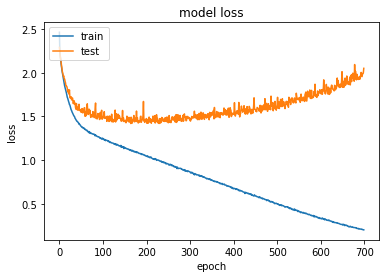

In [341]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [342]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\pranav\Desktop\saved_models\Emotion_Voice_Detection_Model.h5 


In [343]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [345]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 44.79%


## Predicting emotions on the test data

In [347]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

355/355 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 3ms/step


In [348]:
preds

array([[1.4473349e-07, 9.9864608e-01, 1.7444214e-07, ..., 2.9179098e-10,
        4.5685247e-09, 3.3200675e-07],
       [3.3178358e-04, 2.5577401e-03, 1.0866145e-05, ..., 3.0719312e-02,
        2.6371932e-01, 6.1018842e-01],
       [3.9605628e-05, 1.8363297e-08, 8.4159339e-08, ..., 6.4284939e-01,
        1.6855605e-01, 1.3364529e-02],
       ...,
       [9.4780858e-05, 2.0215945e-17, 1.5030613e-09, ..., 7.4200170e-06,
        7.7437602e-05, 1.6252535e-08],
       [1.0328042e-04, 5.2118665e-03, 1.3182412e-07, ..., 8.6186573e-02,
        1.7135671e-01, 5.6733614e-01],
       [9.9996126e-01, 1.7521634e-08, 3.2920103e-05, ..., 4.5457518e-09,
        4.5314405e-06, 9.2682179e-10]], dtype=float32)

In [349]:
preds1=preds.argmax(axis=1)

In [350]:
preds1

array([1, 9, 7, 6, 6, 9, 3, 9, 0, 7, 0, 1, 0, 1, 9, 3, 1, 8, 2, 1, 0, 8,
       3, 0, 5, 2, 5, 5, 0, 1, 4, 6, 6, 5, 4, 9, 3, 1, 1, 9, 5, 9, 1, 9,
       0, 9, 9, 6, 1, 3, 9, 9, 1, 1, 3, 1, 9, 4, 7, 2, 5, 6, 0, 4, 1, 6,
       1, 8, 9, 6, 2, 8, 3, 0, 7, 9, 7, 1, 7, 4, 0, 3, 1, 1, 0, 8, 6, 5,
       3, 9, 3, 2, 3, 4, 6, 1, 6, 7, 7, 1, 5, 5, 9, 0, 8, 6, 6, 9, 6, 3,
       3, 9, 8, 2, 9, 3, 0, 5, 7, 1, 7, 0, 1, 2, 1, 4, 0, 6, 3, 9, 2, 1,
       4, 7, 2, 8, 8, 1, 1, 4, 4, 4, 3, 3, 4, 2, 1, 5, 9, 2, 6, 7, 0, 7,
       3, 0, 0, 1, 1, 1, 1, 0, 2, 6, 8, 1, 0, 5, 4, 8, 5, 6, 0, 6, 4, 7,
       8, 9, 0, 8, 2, 1, 2, 7, 9, 1, 6, 4, 9, 7, 3, 5, 7, 3, 9, 5, 2, 5,
       1, 7, 6, 1, 8, 9, 0, 1, 1, 1, 4, 7, 6, 7, 8, 1, 3, 2, 8, 5, 5, 3,
       7, 1, 1, 1, 8, 7, 2, 4, 5, 2, 5, 2, 8, 5, 5, 7, 2, 8, 4, 1, 1, 2,
       5, 7, 7, 0, 0, 8, 1, 3, 5, 0, 5, 7, 5, 5, 0, 5, 9, 1, 9, 5, 0, 5,
       8, 2, 0, 9, 2, 3, 9, 1, 0, 6, 1, 6, 6, 1, 1, 6, 4, 2, 1, 1, 6, 4,
       4, 0, 7, 2, 7, 1, 1, 8, 9, 7, 9, 1, 7, 1, 9,

In [351]:
abc = preds1.astype(int).flatten()

In [352]:
predictions = (lb.inverse_transform((abc)))

In [353]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_calm
1,male_sad
2,male_fearful
3,male_calm
4,male_calm
5,male_sad
6,female_happy
7,male_sad
8,female_angry
9,male_fearful


In [354]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [355]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_sad
1,male_sad
2,male_happy
3,male_calm
4,male_happy
5,male_sad
6,female_happy
7,male_sad
8,female_fearful
9,male_happy


In [356]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [357]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_angry,male_angry
171,male_sad,male_calm
172,female_angry,female_angry
173,male_calm,male_calm
174,female_calm,female_sad
175,male_happy,male_fearful
176,male_happy,male_happy
177,male_sad,male_sad
178,female_angry,female_angry
179,male_happy,male_happy


In [358]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,34
female_calm,36
female_fearful,36
female_happy,32
female_sad,41
male_angry,40
male_calm,32
male_fearful,29
male_happy,45


In [359]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,37
female_calm,64
female_fearful,27
female_happy,30
female_sad,22
male_angry,37
male_calm,27
male_fearful,37
male_happy,28


In [360]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'pranav.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder 

In [374]:
data, sampling_rate = librosa.load('pranav.wav')

Populating the interactive namespace from numpy and matplotlib


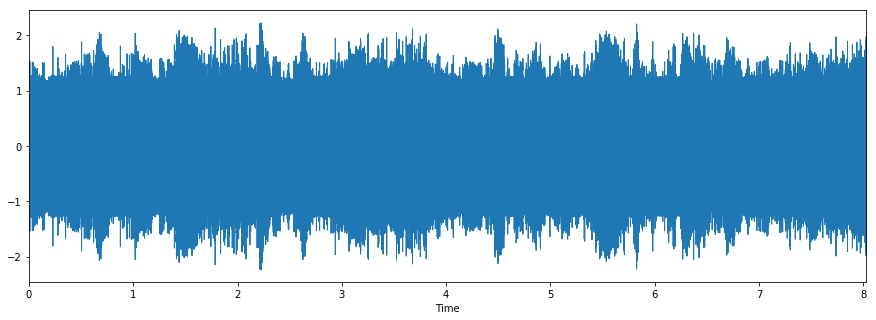

In [375]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [376]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('pranav.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [377]:
livedf2= pd.DataFrame(data=livedf2)

In [378]:
livedf2 = livedf2.stack().to_frame().T

In [379]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,18.919545,16.221954,15.10257,14.48089,14.975601,13.118913,13.188997,12.068094,10.24041,7.993032,...,10.275322,9.491875,10.813893,15.939725,16.732975,15.458225,15.492116,17.880933,18.454542,17.638608


In [380]:
twodim= np.expand_dims(livedf2, axis=2)

In [381]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 8ms/step


In [382]:
livepreds

array([[2.2344072e-34, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 3.1332897e-35,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [383]:
livepreds1=livepreds.argmax(axis=1)

In [384]:
liveabc = livepreds1.astype(int).flatten()

In [385]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)